# Building a 5000 dimensional Logistic Regression and Softmax Regression Sentiment Classifier Based on the Netflix Large Movie Review dataset
The final exercise in Chapter 4 suggests implementing a final project for sentiment analysis. "Sentiment analysis can be considered a binary classification problem. The input is natural language text, and the output is a binary decision that infers positive or negative sentiment." The chapter end suggests taking a look at some datasets in particular the [Large Movie Review Dataset](http://mng.bz/60nj). The excercise also suggests visiting the Kaggle challenge for [Bag of Words Meets Bags of Popcorn](https://www.kaggle.com/c/word2vec-nlp-tutorial). 

The Kaggle tutorial is excellent, and I've borrowed big pieces from it. The main differences in the Kaggle tutorial are that they use Scikit-Learn and Random Forrest, and there is no Tensorflow in it. They also use Pandas and assume that the train data is a 25000 * 5000 column Pandas data frame, and that each vertical slice / column in the frame is the full term frequency feature set counts for word X1, word X2.... word XN.

I've made a few changes to the tutorial besides using Tensorflow. I outline them below:

   1. Instead of using [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/), I used [Tika Python](http://github.com/chrismattmann/tika-python) to clean the review text. Should be obvious why...
   2. I added [TQDM](https://github.com/tqdm/tqdm) progress bars on the most important iterations. 
   3. I added some plots here and there, including looking at the term frequency distribution for the first 100 words in the 5000 word vocabulary, and a plot for the ROC curve.
   4. I added computation of precision and recall, and TP, TN, FP, FN
   5. I added saving for the model weights. 
   
I have a feeling I made this harder than it needed to be &#9786; That said, I couldn't even visualize based on the example given in the book for 2d logistic regresion what 5000d logistic regression looked like. So, I made a visual of it to hopefully help others when they are similarly thinking about it. I think once I learn more about Tensorflow, I will be able to clean this code up some more too. 

<img src="figs/ch04-final-bow-model.png" width="400" height="200" alt="Bag of Word Model in 5000 dimensions"/>

Here are some immensely useful references I found along the way. FWIW, my Nd logreg classifier is <b>~87%</b> accurate. The softmax reg classifier is <b>~81%</b> Not bad!

## Useful References

   1. [Plot ROC Curve for Binary Classification](https://qiita.com/bmj0114/items/460424c110a8ce22d945) by @bmj0114
   2. [Intersecting Lists and Finding their Indices](https://stackoverflow.com/questions/12570417/python-finding-corresponding-indices-for-an-intersection-of-two-lists) by mgilson
   3. [An Introduction to Bag of Words](https://medium.freecodecamp.org/an-introduction-to-bag-of-words-and-how-to-code-it-in-python-for-nlp-282e87a9da04) by Free Code Camp.
   4. [Bag of Words Meets Popcorn Tutorial](https://www.kaggle.com/c/word2vec-nlp-tutorial/overview) by Kaggle.
   5. [Large Movie Review Dataset](http://ai.stanford.edu/~amaas/data/sentiment/) by Stanford.
   6. [What Bag of Words Looks Like Visually](https://bit.ly/2KCTYGe) by Unknown.
   7. [Working with Bag of Words - Tensorflow Cookbook](https://github.com/nfmcclure/tensorflow_cookbook/blob/master/07_Natural_Language_Processing/02_Working_with_Bag_of_Words/02_bag_of_words.ipynb) by Nick F. Mcclure.


In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tika import parser
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_curve, auc
import re
import math
from tqdm import tqdm_notebook as tqdm
from os import listdir
from os.path import isfile, join
import nltk
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /home/mattmann/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /home/mattmann/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /home/mattmann/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /home/mattmann/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /home/mattmann/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /home/mattmann/nltk_data...
[nltk_data]    |   Package movie_reviews is a

True

In [3]:
def review_to_words( raw_review ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove HTML
    review_text = parser.from_buffer( "<html>" + raw_review + "</html>" )["content"]
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words )) 

In [5]:
train = pd.read_csv("word2vec-nlp-tutorial/labeledTrainData.tsv", header=0, \
                    delimiter="\t", quoting=3)

In [6]:
train.shape

(25000, 3)

In [7]:
train.columns.values

array(['id', 'sentiment', 'review'], dtype=object)

In [8]:
train.head()

id  sentiment                                             review
0  "5814_8"          1  "With all this stuff going down at the moment ...
1  "2381_9"          1  "\"The Classic War of the Worlds\" by Timothy ...
2  "7759_3"          0  "The film starts with a manager (Nicholas Bell...
3  "3630_4"          0  "It must be assumed that those who praised thi...
4  "9495_8"          1  "Superbly trashy and wondrously unpretentious ...

In [9]:
parsed = parser.from_buffer("<html>"+train["review"][0]+"</html>")
print(train["review"][0])
print(parsed["content"])

2020-05-09 12:18:20,909 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar to /tmp/tika-server.jar.
2020-05-09 12:18:24,343 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /tmp/tika-server.jar.md5.
2020-05-09 12:18:25,203 [MainThread  ] [WARNI]  Failed to see startup log message; retrying...


"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally sta

In [10]:
# Get the number of reviews based on the dataframe column size
num_reviews = train["review"].size

# Initialize an empty list to hold the clean reviews
clean_train_reviews = []

# Loop over each review; create an index i that goes from 0 to the length
# of the movie review list 
for i in tqdm(range( 0, num_reviews )):
    # Call our function for each one, and add the result to the list of
    # clean reviews
    clean_train_reviews.append( review_to_words( train["review"][i] ) )

/home/mattmann/install/python37/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


In [11]:
# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
train_data_features = vectorizer.fit_transform(clean_train_reviews)

# Numpy arrays are easy to work with, so convert the result to an 
# array
train_data_features = train_data_features.toarray()

In [12]:
print(train_data_features.shape)

(25000, 5000)


In [13]:
# Take a look at the words in the vocabulary
vocab = vectorizer.get_feature_names()
print("size %d %s " % (len(vocab), vocab))

size 5000 ['abandoned', 'abc', 'abilities', 'ability', 'able', 'abraham', 'absence', 'absent', 'absolute', 'absolutely', 'absurd', 'abuse', 'abusive', 'abysmal', 'academy', 'accent', 'accents', 'accept', 'acceptable', 'accepted', 'access', 'accident', 'accidentally', 'accompanied', 'accomplished', 'according', 'account', 'accuracy', 'accurate', 'accused', 'achieve', 'achieved', 'achievement', 'acid', 'across', 'act', 'acted', 'acting', 'action', 'actions', 'activities', 'actor', 'actors', 'actress', 'actresses', 'acts', 'actual', 'actually', 'ad', 'adam', 'adams', 'adaptation', 'adaptations', 'adapted', 'add', 'added', 'adding', 'addition', 'adds', 'adequate', 'admire', 'admit', 'admittedly', 'adorable', 'adult', 'adults', 'advance', 'advanced', 'advantage', 'adventure', 'adventures', 'advertising', 'advice', 'advise', 'affair', 'affect', 'affected', 'afford', 'aforementioned', 'afraid', 'africa', 'african', 'afternoon', 'afterwards', 'age', 'aged', 'agent', 'agents', 'ages', 'aging', 

In [14]:
# Sum up the counts of each vocabulary word
dist = np.sum(train_data_features, axis=0)

# For each, print the vocabulary word and the number of times it 
# appears in the training set
for tag, count in zip(vocab, dist):
    print("%d, %s" % (count, tag))

187, abandoned
125, abc
108, abilities
454, ability
1259, able
85, abraham
116, absence
83, absent
352, absolute
1485, absolutely
306, absurd
192, abuse
91, abusive
98, abysmal
297, academy
485, accent
203, accents
300, accept
130, acceptable
144, accepted
92, access
318, accident
200, accidentally
88, accompanied
124, accomplished
296, according
186, account
81, accuracy
284, accurate
123, accused
179, achieve
139, achieved
124, achievement
90, acid
971, across
1251, act
660, acted
6494, acting
3355, action
311, actions
83, activities
2389, actor
4488, actors
1219, actress
369, actresses
394, acts
793, actual
4240, actually
148, ad
303, adam
98, adams
454, adaptation
80, adaptations
154, adapted
810, add
440, added
166, adding
347, addition
337, adds
113, adequate
124, admire
621, admit
134, admittedly
101, adorable
511, adult
376, adults
101, advance
90, advanced
153, advantage
510, adventure
204, adventures
91, advertising
259, advice
90, advise
346, affair
93, affect
113, affected


105, remarkably
91, remarks
1703, remember
258, remembered
157, remind
347, reminded
297, reminds
175, reminiscent
163, remote
189, remotely
108, removed
90, rendition
720, rent
214, rental
337, rented
177, renting
143, repeat
204, repeated
119, repeatedly
123, repetitive
162, replaced
96, report
213, reporter
103, represent
99, represented
132, represents
191, reputation
190, required
132, requires
231, rescue
222, research
107, resemblance
80, resemble
113, resembles
85, resident
84, resist
130, resolution
89, resort
89, resources
499, respect
83, respected
79, respectively
122, response
88, responsibility
276, responsible
1803, rest
119, restaurant
90, restored
632, result
82, resulting
274, results
161, retarded
82, retired
624, return
117, returned
126, returning
307, returns
151, reunion
189, reveal
257, revealed
122, revealing
183, reveals
133, revelation
555, revenge
851, review
240, reviewer
267, reviewers
718, reviews
188, revolution
103, revolutionary
154, revolves
128, rex


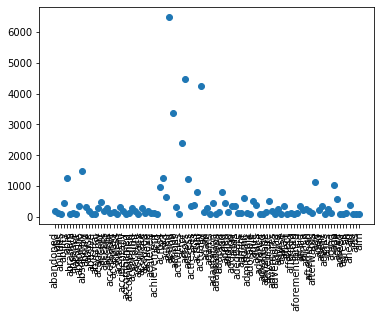

In [15]:
# plot the word count for first 100 words
plt.scatter(vocab[0:99], dist[0:99])
plt.xticks(vocab[0:99], rotation='vertical')
plt.show()

In [16]:
# set up Tensorflow nD logistic regression
learning_rate = 0.1
training_epochs = 2000

In [17]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

In [18]:
Y = tf.placeholder(tf.float32, shape=(None,), name="y")
w = tf.Variable([0.] * (len(train_data_features)+1), name="w", trainable=True)
print(w.shape)

(25001,)


In [19]:
ys = train['sentiment'].values

In [20]:
Xs = {}
for i in range(train_data_features.shape[1]):
    Xs["X"+str(i)] = tf.placeholder(tf.float32, shape=(None,), name="x"+str(i))

In [21]:
linear = w[0]
for i in range(0, train_data_features.shape[1]):
    linear = linear + (w[i+1] * Xs["X"+str(i)])
y_model = tf.sigmoid(linear)

In [22]:
cost = tf.reduce_mean(-tf.log(y_model * Y + (1 - y_model) * (1 - Y)))
train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

In [23]:
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    prev_err = 0
    for epoch in tqdm(range(training_epochs)):
        feed_dict = {}
        for i in range(train_data_features.shape[1]):
            feed_dict[Xs["X"+str(i)]] = train_data_features[:, i, None].reshape(len(train_data_features))
        feed_dict[Y] = ys
        err, _ = sess.run([cost, train_op], feed_dict=feed_dict)
        print(epoch, err)
        if abs(prev_err - err) < 0.0001:
            break
        prev_err = err
    
    w_val = sess.run(w, feed_dict)
    save_path = saver.save(sess, "./en-netflix-binary-sentiment.ckpt")

/home/mattmann/install/python37/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


0 0.6931475
1 0.68367267
2 0.67517424
3 0.6673778
4 0.6601468
5 0.6533886
6 0.6470343
7 0.64103085
8 0.6353368
9 0.62991923
10 0.62475115
11 0.6198105
12 0.6150785
13 0.6105392
14 0.6061786
15 0.6019846
16 0.59794647
17 0.59405404
18 0.5902991
19 0.58667326
20 0.5831693
21 0.5797805
22 0.5765007
23 0.5733241
24 0.57024544
25 0.5672598
26 0.5643625
27 0.5615493
28 0.5588163
29 0.55615956
30 0.5535756
31 0.55106133
32 0.5486133
33 0.546229
34 0.54390526
35 0.54163986
36 0.53943014
37 0.537274
38 0.535169
39 0.5331134
40 0.5311051
41 0.52914226
42 0.5272231
43 0.5253461
44 0.5235097
45 0.5217122
46 0.5199523
47 0.51822865
48 0.51654017
49 0.5148855
50 0.5132633
51 0.51167256
52 0.5101124
53 0.5085817
54 0.5070795
55 0.50560474
56 0.5041569
57 0.5027348
58 0.50133777
59 0.499965
60 0.49861583
61 0.49728957
62 0.49598548
63 0.49470282
64 0.4934411
65 0.4921997
66 0.49097803
67 0.48977554
68 0.48859173
69 0.4874259
70 0.48627788
71 0.48514712
72 0.4840329
73 0.482935
74 0.481853
75 0.4807864

569 0.3361943
570 0.3360846
571 0.33597508
572 0.33586586
573 0.3357568
574 0.3356481
575 0.33553946
576 0.3354311
577 0.33532292
578 0.335215
579 0.33510736
580 0.33499983
581 0.3348925
582 0.33478546
583 0.33467856
584 0.334572
585 0.3344655
586 0.33435938
587 0.3342533
588 0.33414757
589 0.33404186
590 0.3339366
591 0.3338314
592 0.3337264
593 0.3336217
594 0.3335171
595 0.33341283
596 0.33330867
597 0.3332047
598 0.33310097
599 0.3329974
600 0.33289415
601 0.33279103
602 0.33268812
603 0.33258536
604 0.3324828
605 0.33238044
606 0.3322783
607 0.33217642
608 0.33207464
609 0.33197314
610 0.33187172
611 0.3317706
612 0.3316696
613 0.3315689
614 0.33146828
615 0.33136788
616 0.33126768
617 0.33116767
618 0.3310678



In [24]:
print(w_val)
print(np.max(w_val))

[ 0.0028774  -0.00082148  0.01867105 ...  0.          0.
  0.        ]
0.49940136


In [25]:
def predict(test_review, vocab, weights, threshold=0.5):
    #clean the review
    test_review_c = review_to_words(test_review)
    
    #create the test vocabulary and counts
    n_vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 
    ex_data_features = n_vectorizer.fit_transform([test_review_c])
    ex_data_features = ex_data_features.toarray()
    test_vocab = n_vectorizer.get_feature_names()
    test_vocab_counts = ex_data_features.reshape(ex_data_features.shape[1])
    
    # figure out the intersection of the test vocabulary from the review with the actual full vocabulary
    ind_dict = dict((k, i) for i, k in enumerate(vocab))
    test_ind_dict = dict((k, i) for i, k in enumerate(test_vocab))
    inter = set(ind_dict).intersection(test_vocab)
    indices = [ ind_dict[x] for x in inter ]
    test_indices = [test_ind_dict[x] for x in inter]
    
    # all zeros for the 5000 feature vec except for the overlap indices that we have counts for
    test_feature_vec = np.zeros(train_data_features.shape[1])
    for i in range(len(indices)):
        test_feature_vec[indices[i]] = test_vocab_counts[test_indices[i]]
     
    # our log reg model
    test_linear = weights[0]
    for i in range(0, train_data_features.shape[1]):
        test_linear = test_linear + (weights[i+1] * test_feature_vec[i])
    y_test = sigmoid(test_linear)
    
    # here it is the prediction
    return np.greater(y_test, threshold).astype(float)

In [26]:
test = pd.read_csv("word2vec-nlp-tutorial/testData.tsv", header=0, \
                    delimiter="\t", quoting=3)

In [27]:
test.head()

id                                             review
0  "12311_10"  "Naturally in a film who's main themes are of ...
1    "8348_2"  "This movie is a disaster within a disaster fi...
2    "5828_4"  "All in all, this is a movie for kids. We saw ...
3    "7186_2"  "Afraid of the Dark left me with the impressio...
4   "12128_7"  "A very accurate depiction of small time mob l...

In [28]:
#try it out on new data
new_neg_review = "Man, this movie really sucked. It was terrible. I could not possibly watch this movie again!"
new_pos_review = "I think that this is a fantastic movie, it really "

In [29]:
new_neg_review_c = review_to_words(new_neg_review)
new_pos_review_c = review_to_words(new_pos_review)
print(new_neg_review_c)
print(new_pos_review_c)         

man movie really sucked terrible could possibly watch movie
think fantastic movie really


In [30]:
predict(new_neg_review, vocab, w_val)

0.0

In [31]:
predict(new_pos_review, vocab, w_val)

1.0

In [32]:
# Generate Kaggle Submission
# Create an empty list and append the clean reviews one by one
num_reviews = len(test["review"])
result = [] 
for i in tqdm(range(0, num_reviews)):
    r = predict(test["review"][i], vocab, w_val)
    result.append(r)

# Copy the results to a pandas dataframe with an "id" column and
# a "sentiment" column
output = pd.DataFrame( data={"id":test["id"], "sentiment":result} )

# Use pandas to write the comma-separated output file
output.to_csv( "Bag_of_Words_model.csv", index=False, quoting=3 )

/home/mattmann/install/python37/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [33]:
# test on unseen samples from IMDB movie reviews and compute TP, TN, FP, FN and precision + accuracy
pos_test_path = "aclImdb/test/pos/"
neg_test_path = "aclImdb/test/neg/"
only_pos_files = [f for f in listdir(pos_test_path) if isfile(join(pos_test_path, f))]
only_neg_files = [f for f in listdir(neg_test_path) if isfile(join(neg_test_path, f))]

only_pos_file_contents = []
for i in range(0, len(only_pos_files)):
    with open(pos_test_path + only_pos_files[i], 'r') as file:
        r_data = file.read()
        only_pos_file_contents.append(r_data)
        
only_neg_file_contents = []
for i in range(0, len(only_neg_files)):
    with open(neg_test_path + only_neg_files[i], 'r') as file:
        r_data = file.read()
        only_neg_file_contents.append(r_data)

In [34]:
TP = 0.
TN = 0.
FP = 0.
FN = 0.
predictions_test = np.zeros(len(only_pos_file_contents) * 2)

In [35]:
for i in tqdm(range(0, len(only_pos_file_contents))):
    sent = predict(only_pos_file_contents[i], vocab, w_val)
    predictions_test[i] = sent
    if sent == 1.:
        TP += 1
    elif sent == 0.:
        FN += 1

/home/mattmann/install/python37/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [36]:
for i in tqdm(range(0, len(only_neg_file_contents))):
    sent = predict(only_neg_file_contents[i], vocab, w_val)
    predictions_test[len(only_neg_file_contents)+i] = sent
    if sent == 0.:
        TN += 1
    elif sent == 1.:
        FP += 1

/home/mattmann/install/python37/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [37]:
precision = (TP) / (TP + FP)

In [38]:
recall = (TP) / (TP + FN)

In [39]:
print("precision %f recall %f" % (precision, recall))

precision 0.859793 recall 0.875200


In [40]:
print(TP)
print(TN)
print(FP)
print(FN)

10940.0
10716.0
1784.0
1560.0


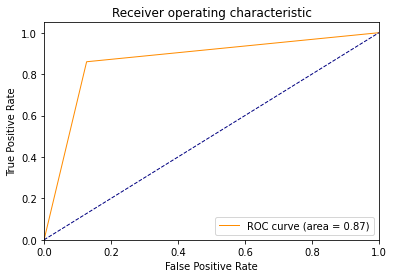

In [41]:
outcome_test = np.ones(len(only_pos_files))
outcome_test = np.append(outcome_test, np.zeros(len(only_neg_files)))

fpr, tpr, thresholds = roc_curve(predictions_test, outcome_test)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Try Softmax Regression
Chapter 4 in the book teaches us also about softmax regression. The big difference with softmax is that we can predict more than 2 classes (N output classes) and to do so, we set up an equation like Y = WX + B, where W are the weights (num_features * num_labels), X is the input feature data (num_train * num_features), and B the offset constant (num_labels) and Y is the one-hot encoded class labels we are trying to predict (num_labels). Y, X, W and B are matrices. The book also teaches us to use batch training, so we'll set all that up here. One interesting property is that Softmax natively provides class confidence for each prediction. This could be done with n-d logistic regression by estimating tthe difference from absolute 0 or 1 for the predicted y_model value and then divide by 0.5.

In [42]:
learning_rate = 0.01
training_epochs = 1000
num_labels = 2
batch_size = 100

In [44]:
def softmax_feat_vec_from_review(test_review, vocab):
    #assumption: review is clean
    #create the test vocabulary and counts
    n_vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 
    
    ex_data_features = n_vectorizer.fit_transform([test_review])
    ex_data_features = ex_data_features.toarray()
    test_vocab = n_vectorizer.get_feature_names()
    test_vocab_counts = ex_data_features.reshape(ex_data_features.shape[1])
    
    # figure out the intersection of the test vocabulary from the review with the actual full vocabulary
    ind_dict = dict((k, i) for i, k in enumerate(vocab))
    test_ind_dict = dict((k, i) for i, k in enumerate(test_vocab))
    inter = set(ind_dict).intersection(test_vocab)
    indices = [ ind_dict[x] for x in inter ]
    test_indices = [test_ind_dict[x] for x in inter]
    
    # all zeros for the 5000 feature vec except for the overlap indices that we have counts for
    test_feature_vec = np.zeros(train_data_features.shape[1])
    for i in range(len(indices)):
        test_feature_vec[indices[i]] = test_vocab_counts[test_indices[i]]
     
    
    return test_feature_vec


In [45]:
num_pos_labels = len(train.loc[train['sentiment'] == 1.])
num_neg_labels = len(train.loc[train['sentiment'] == 0.])
lab_mat = []
for i in range(len(train['sentiment'])):
    if train['sentiment'][i] == 1.0:
        #lab_mat = lab_mat + [[1., 0.]]
        lab_mat = lab_mat + [[0., 1.]]
    elif train['sentiment'][i] == 0.0:
        #lab_mat = lab_mat + [[0., 1.]]
        lab_mat = lab_mat + [[1., 0.]]

labels = np.matrix(lab_mat)
print(labels)

[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [46]:
xs = train_data_features.astype(float)
train_size, num_features = xs.shape
print(xs.shape)
print(labels.shape)

(25000, 5000)
(25000, 2)


In [47]:
#shuffle the labels so that the system doesn't learn that the order of the data matters
arr = np.arange(xs.shape[0])
np.random.shuffle(arr)
xs = xs[arr, :]
labels = labels[arr, :]

In [48]:
X = tf.placeholder("float", shape=[None, num_features])
Y = tf.placeholder("float", shape=[None, num_labels])
W = tf.Variable(tf.zeros([num_features, num_labels]))
b = tf.Variable(tf.zeros([num_labels]))
y_model = tf.nn.softmax(tf.matmul(X, W) + b)

In [49]:
# sometimes the result of y_model can be 0, and log0 is NaN, so account for it
# see: https://stackoverflow.com/questions/38538635/tensorflow-returning-nan-when-implementing-logistic-regression
cost = -tf.reduce_sum(Y * tf.log(tf.maximum(y_model, 1e-15))) 
train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [50]:
correct_prediction = tf.equal(tf.argmax(y_model, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [51]:
test_reviews = []
clean_test_reviews = []
test_reviews.extend(only_pos_file_contents)
test_reviews.extend(only_neg_file_contents)

In [52]:
for i in tqdm(range(len(test_reviews))):
    test_review_c = review_to_words(test_reviews[i])
    clean_test_reviews.append(test_review_c)

/home/mattmann/install/python37/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [53]:
test_xs = np.zeros((len(clean_test_reviews), num_features))
for i in tqdm(range(len(clean_test_reviews))):
    test_xs[i] = softmax_feat_vec_from_review(clean_test_reviews[i], vocab)

/home/mattmann/install/python37/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [54]:
test_xs.shape

(25000, 5000)

In [55]:
test_labels = np.matrix([[0., 1.]] * len(only_pos_file_contents) + [[1., 0.]] * len(only_neg_file_contents))

In [56]:
saver = tf.train.Saver()
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for step in tqdm(range(training_epochs * train_size // batch_size)):
        offset = (step * batch_size) % train_size
        batch_xs = xs[offset:(offset + batch_size), :]
        batch_labels = labels[offset:(offset + batch_size)]
        err, _ = sess.run([cost, train_op], feed_dict={X: batch_xs, Y: batch_labels})
        print (step, err)            
    
    W_val = sess.run(W)
    print('w', W_val)
    b_val = sess.run(b)
    print('b', b_val)
    print("accuracy", accuracy.eval(feed_dict={X: test_xs, Y: test_labels}))
    save_path = saver.save(sess, "./ch4-softmax-netflix-sentiment.ckpt")
    print("Model saved in path: %s" % save_path)

/home/mattmann/install/python37/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


0 69.31472
1 70.27361
2 202.52441
3 373.493
4 130.21266
5 237.44778
6 492.30334
7 263.57602
8 535.22046
9 140.67279
10 131.2782
11 321.18338
12 438.60162
13 104.08228
14 264.6877
15 267.8468
16 115.00819
17 172.75127
18 134.14983
19 121.44874
20 117.31978
21 85.24243
22 98.1247
23 93.74172
24 79.24234
25 56.62791
26 60.046364
27 140.66356
28 182.01532
29 263.24866
30 125.87929
31 109.026665
32 122.56451
33 58.18374
34 56.469414
35 45.4698
36 82.24233
37 68.851265
38 79.81413
39 62.677372
40 109.966606
41 46.23139
42 35.22958
43 58.387222
44 60.965195
45 40.261703
46 56.11737
47 63.953613
48 94.18615
49 90.293045
50 74.893394
51 118.39181
52 230.75961
53 246.40836
54 132.13658
55 103.09577
56 81.85001
57 76.70274
58 39.235363
59 102.69719
60 51.93369
61 50.739788
62 58.088852
63 48.346634
64 71.20326
65 57.839203
66 75.46087
67 59.95285
68 42.799427
69 57.350464
70 50.11071
71 70.24161
72 66.5499
73 107.963135
74 155.10233
75 140.50905
76 123.9189
77 63.333942
78 56.326057
79 35.791206


755 28.064089
756 20.909195
757 25.8278
758 15.053172
759 26.215748
760 24.029087
761 23.970419
762 32.84275
763 20.545622
764 20.819464
765 30.04345
766 11.445315
767 29.828148
768 26.079512
769 17.113619
770 15.602447
771 23.233183
772 19.619234
773 24.231178
774 29.530106
775 34.65544
776 17.787634
777 38.80988
778 31.493177
779 25.76772
780 19.067001
781 20.755527
782 18.585684
783 22.882786
784 26.543823
785 28.502903
786 24.804314
787 25.140343
788 26.442846
789 23.605467
790 14.059679
791 25.043123
792 14.691513
793 17.508472
794 21.793238
795 23.504055
796 27.524357
797 29.733822
798 21.322517
799 28.153774
800 15.457283
801 33.671722
802 13.451843
803 51.013336
804 19.300264
805 17.627914
806 11.815477
807 20.519943
808 16.451094
809 25.386105
810 24.603111
811 40.884865
812 26.367256
813 16.87315
814 27.375149
815 15.288444
816 27.907648
817 25.22831
818 43.27095
819 42.08081
820 35.113766
821 23.955797
822 35.34089
823 74.11528
824 65.406204
825 46.555115
826 34.608982
827 2

1502 32.49121
1503 31.551678
1504 14.449786
1505 22.999367
1506 17.66829
1507 20.871864
1508 10.9072895
1509 20.20702
1510 17.522442
1511 15.843265
1512 27.986607
1513 16.698002
1514 17.164936
1515 26.161087
1516 9.8224125
1517 25.847328
1518 19.952768
1519 15.784995
1520 11.289448
1521 21.80658
1522 14.08727
1523 21.102047
1524 27.652842
1525 25.491749
1526 14.252812
1527 30.220287
1528 19.782347
1529 13.608379
1530 19.604397
1531 19.963806
1532 15.189484
1533 25.253544
1534 20.24062
1535 31.19815
1536 33.261864
1537 20.127205
1538 23.989124
1539 25.373846
1540 17.85529
1541 26.297253
1542 12.92536
1543 17.684229
1544 17.514877
1545 22.17524
1546 26.594257
1547 32.3158
1548 18.536684
1549 24.279655
1550 8.861424
1551 25.356344
1552 9.2804785
1553 47.971214
1554 15.424425
1555 17.145477
1556 11.401037
1557 18.156574
1558 16.382011
1559 19.623066
1560 18.826025
1561 33.5896
1562 21.22982
1563 15.1292515
1564 24.897823
1565 13.381451
1566 25.375263
1567 18.57108
1568 25.763458
1569 13.81

2072 27.55571
2073 49.456356
2074 25.842525
2075 21.417479
2076 40.524204
2077 42.287964
2078 21.938837
2079 21.16072
2080 18.566095
2081 20.584423
2082 12.101747
2083 16.525562
2084 22.44859
2085 16.574032
2086 17.314886
2087 22.24064
2088 18.135256
2089 22.429527
2090 13.572215
2091 23.40886
2092 16.279358
2093 38.656677
2094 29.19503
2095 17.757895
2096 22.607098
2097 20.31828
2098 28.256859
2099 16.422024
2100 14.609096
2101 19.585258
2102 24.818901
2103 26.697784
2104 20.57827
2105 25.386162
2106 17.34186
2107 19.558964
2108 22.13564
2109 14.450091
2110 24.03286
2111 13.54026
2112 11.964002
2113 27.14354
2114 15.293747
2115 18.838575
2116 9.847589
2117 29.653296
2118 18.3271
2119 20.643671
2120 17.909529
2121 26.03859
2122 15.829094
2123 23.457901
2124 28.181793
2125 16.026272
2126 19.845634
2127 22.36343
2128 16.180082
2129 18.078691
2130 14.195185
2131 23.041344
2132 17.974243
2133 15.529837
2134 28.914394
2135 20.542665
2136 24.46658
2137 19.97845
2138 15.490127
2139 23.953926


2635 22.146378
2636 32.287624
2637 15.448245
2638 12.795355
2639 22.258799
2640 14.460933
2641 15.193138
2642 15.665944
2643 17.216755
2644 14.835075
2645 14.2316885
2646 19.70456
2647 9.73337
2648 19.975204
2649 20.388638
2650 26.227562
2651 20.054125
2652 23.300323
2653 12.240217
2654 17.2885
2655 23.495197
2656 10.103649
2657 22.662079
2658 20.684132
2659 13.1684265
2660 13.103427
2661 31.702374
2662 17.949911
2663 14.325572
2664 10.283114
2665 20.192722
2666 22.367126
2667 15.27355
2668 15.610329
2669 22.129038
2670 10.262611
2671 19.824886
2672 13.015705
2673 20.89744
2674 16.608168
2675 20.090328
2676 10.385006
2677 15.6033535
2678 21.926052
2679 14.32378
2680 19.205551
2681 7.438286
2682 23.024998
2683 20.624313
2684 30.079155
2685 24.186743
2686 13.184698
2687 8.9443445
2688 17.157822
2689 16.83852
2690 22.791706
2691 31.51434
2692 19.39107
2693 16.557428
2694 25.08178
2695 13.242165
2696 29.639053
2697 9.938615
2698 20.769302
2699 15.848387
2700 11.932541
2701 19.558746
2702 1

3200 11.285942
3201 18.686298
3202 15.087702
3203 16.87913
3204 10.171951
3205 14.13026
3206 6.140383
3207 19.699991
3208 20.528988
3209 27.894875
3210 10.187495
3211 15.1148205
3212 21.22675
3213 18.7905
3214 19.12862
3215 21.727644
3216 20.039516
3217 21.619602
3218 26.02293
3219 28.215727
3220 22.903126
3221 21.968666
3222 14.785208
3223 19.523245
3224 21.754013
3225 23.346598
3226 21.056915
3227 14.922325
3228 13.728249
3229 24.103943
3230 17.917086
3231 19.54996
3232 24.839943
3233 15.746336
3234 14.25721
3235 25.251139
3236 25.029274
3237 9.050667
3238 18.7901
3239 16.258137
3240 20.776604
3241 10.358917
3242 14.882767
3243 15.777454
3244 18.51631
3245 32.561714
3246 35.75701
3247 12.816313
3248 14.180878
3249 15.797678
3250 16.099167
3251 16.374157
3252 27.71071
3253 29.080664
3254 13.717026
3255 19.311647
3256 13.969884
3257 16.579407
3258 8.133669
3259 16.666573
3260 14.398333
3261 14.656678
3262 22.930344
3263 11.194323
3264 10.30289
3265 23.203476
3266 7.645061
3267 22.90219

3763 12.576969
3764 10.695765
3765 23.001854
3766 7.372698
3767 20.818596
3768 19.518114
3769 13.743797
3770 9.946043
3771 15.626562
3772 12.007543
3773 19.184193
3774 24.299091
3775 18.984463
3776 14.665253
3777 27.292263
3778 14.043296
3779 11.967468
3780 11.743292
3781 14.30961
3782 12.83124
3783 17.836313
3784 14.498155
3785 21.429
3786 18.354202
3787 18.00136
3788 21.287884
3789 16.813816
3790 11.583562
3791 24.234478
3792 12.88063
3793 10.574775
3794 14.182133
3795 18.673046
3796 21.791264
3797 24.266945
3798 13.717626
3799 17.562944
3800 7.786424
3801 21.008213
3802 7.1945353
3803 40.305183
3804 12.764568
3805 16.228539
3806 9.495535
3807 15.409192
3808 16.170477
3809 15.007641
3810 16.414501
3811 26.06361
3812 16.926003
3813 11.732193
3814 17.961782
3815 10.075667
3816 21.510464
3817 15.832028
3818 21.328152
3819 13.650519
3820 23.441647
3821 17.054295
3822 24.68153
3823 45.436558
3824 25.236607
3825 15.766228
3826 21.268024
3827 15.134071
3828 8.265463
3829 14.112574
3830 16.9

4328 7.9914484
4329 13.878751
4330 17.491776
4331 15.716183
4332 9.90249
4333 15.423416
4334 19.038773
4335 13.691298
4336 14.119577
4337 19.345726
4338 18.033667
4339 15.998642
4340 8.560992
4341 19.370537
4342 15.26402
4343 35.05626
4344 23.927452
4345 16.383177
4346 20.823154
4347 16.869787
4348 24.467857
4349 15.814882
4350 11.24559
4351 16.617228
4352 20.128359
4353 21.699106
4354 17.374708
4355 18.22469
4356 14.246143
4357 18.88633
4358 17.802116
4359 9.164288
4360 20.55979
4361 11.809367
4362 10.887762
4363 23.942245
4364 11.282563
4365 15.813766
4366 8.875303
4367 20.757862
4368 13.956625
4369 16.761198
4370 13.837561
4371 20.38781
4372 11.879743
4373 18.333538
4374 23.90326
4375 12.985876
4376 17.16368
4377 16.856844
4378 12.5673065
4379 14.614847
4380 13.73866
4381 18.373394
4382 14.923841
4383 13.466665
4384 24.572313
4385 17.89687
4386 22.17369
4387 14.088931
4388 12.729846
4389 19.673336
4390 12.923684
4391 14.741527
4392 13.368262
4393 14.547058
4394 13.296194
4395 12.113

4890 12.697323
4891 15.445745
4892 13.381286
4893 14.098421
4894 12.648347
4895 11.265945
4896 16.960209
4897 9.087984
4898 18.221718
4899 16.158724
4900 22.73379
4901 19.95346
4902 15.14216
4903 8.634884
4904 14.152452
4905 18.16003
4906 8.870791
4907 19.26335
4908 15.64076
4909 11.829279
4910 9.513945
4911 26.262066
4912 15.167788
4913 14.559312
4914 8.439807
4915 18.463963
4916 15.81629
4917 13.259317
4918 13.786383
4919 18.198456
4920 9.417728
4921 16.58025
4922 10.838758
4923 17.02171
4924 16.153433
4925 15.910939
4926 9.0534525
4927 13.92087
4928 17.733402
4929 13.568558
4930 17.173233
4931 6.6078415
4932 20.592896
4933 17.6077
4934 27.36568
4935 22.562202
4936 9.801835
4937 7.0026255
4938 15.431206
4939 14.247496
4940 19.060734
4941 27.060411
4942 17.041584
4943 15.047434
4944 22.107288
4945 12.319962
4946 26.177689
4947 8.335815
4948 22.242771
4949 11.214821
4950 9.994694
4951 17.831268
4952 12.896352
4953 14.255495
4954 9.557037
4955 13.124089
4956 5.56377
4957 17.913744
4958 

5450 9.747836
5451 17.528517
5452 12.807417
5453 14.033665
5454 9.6002035
5455 13.273588
5456 5.3229856
5457 17.621323
5458 17.526262
5459 22.429966
5460 9.421871
5461 12.676542
5462 21.349129
5463 17.71928
5464 16.472637
5465 16.382725
5466 19.364067
5467 21.05336
5468 23.260008
5469 23.639221
5470 20.607054
5471 18.720308
5472 12.674866
5473 15.989817
5474 18.77214
5475 18.770561
5476 19.998594
5477 14.681023
5478 10.998175
5479 23.910528
5480 14.710494
5481 16.236195
5482 22.147827
5483 13.922137
5484 11.810442
5485 20.780552
5486 23.002213
5487 7.130463
5488 17.900074
5489 16.775034
5490 16.971727
5491 8.893467
5492 16.693424
5493 17.129568
5494 18.36325
5495 29.753822
5496 32.933697
5497 11.073763
5498 11.996441
5499 14.57943
5500 14.986597
5501 14.974673
5502 23.086452
5503 27.72523
5504 11.975221
5505 15.183462
5506 11.83741
5507 13.250694
5508 6.7720394
5509 13.425896
5510 12.071587
5511 13.937243
5512 21.18528
5513 9.920242
5514 8.554825
5515 23.21027
5516 6.615759
5517 19.215

6016 6.421585
6017 19.264664
6018 18.98663
6019 11.134999
6020 9.077121
6021 13.938116
6022 11.212515
6023 15.744299
6024 23.08268
6025 20.010529
6026 11.6035795
6027 24.849976
6028 11.785698
6029 10.916603
6030 9.556297
6031 12.579891
6032 11.517239
6033 16.365265
6034 12.191854
6035 18.72734
6036 15.684041
6037 16.785753
6038 18.690933
6039 15.815308
6040 11.324434
6041 25.144901
6042 12.06102
6043 7.7485256
6044 12.300518
6045 18.163692
6046 17.66737
6047 18.589252
6048 12.734045
6049 15.6069565
6050 7.032933
6051 18.304987
6052 6.1413145
6053 37.23426
6054 12.414024
6055 15.48808
6056 9.057322
6057 13.962238
6058 15.915316
6059 14.056882
6060 14.944445
6061 23.42339
6062 15.452041
6063 10.839742
6064 15.705624
6065 8.598861
6066 20.82619
6067 13.770541
6068 19.423536
6069 12.296341
6070 20.571787
6071 15.734179
6072 18.787357
6073 38.59662
6074 24.483828
6075 13.109631
6076 18.357296
6077 13.880598
6078 8.125978
6079 13.330483
6080 16.55915
6081 14.837248
6082 9.170139
6083 15.0630

6585 13.706885
6586 12.963965
6587 17.354612
6588 15.856676
6589 14.216791
6590 7.5201197
6591 18.176704
6592 13.422749
6593 33.199047
6594 20.25758
6595 14.767884
6596 17.54052
6597 15.467004
6598 23.013287
6599 14.754909
6600 10.309896
6601 12.369677
6602 16.091784
6603 20.849594
6604 16.1523
6605 16.1109
6606 13.566963
6607 19.23827
6608 15.656887
6609 7.6790447
6610 18.907885
6611 10.806206
6612 9.935693
6613 22.123703
6614 9.550616
6615 14.774017
6616 8.45329
6617 17.734608
6618 9.784666
6619 13.599977
6620 11.881428
6621 18.762562
6622 9.960672
6623 15.794083
6624 21.754347
6625 10.979044
6626 16.216602
6627 15.4528055
6628 12.774638
6629 13.947488
6630 12.340164
6631 15.805272
6632 13.655043
6633 11.380189
6634 22.27251
6635 15.710646
6636 20.210424
6637 12.337776
6638 12.004597
6639 18.010237
6640 11.841016
6641 16.346268
6642 12.486966
6643 13.397871
6644 11.574103
6645 10.0907
6646 15.910597
6647 8.983496
6648 17.794273
6649 17.408676
6650 21.138283
6651 18.17052
6652 11.7694

7145 9.808162
7146 15.617369
7147 8.875982
7148 17.472748
7149 16.563398
7150 20.771801
7151 18.167637
7152 11.282797
7153 7.7081723
7154 12.211948
7155 14.501892
7156 8.48825
7157 18.349628
7158 14.069224
7159 10.8283825
7160 8.109714
7161 22.390469
7162 13.712837
7163 12.569123
7164 7.870318
7165 17.396973
7166 14.892275
7167 12.494425
7168 12.674548
7169 17.018623
7170 9.120214
7171 15.167039
7172 10.071041
7173 15.659468
7174 15.791168
7175 16.444565
7176 7.9239054
7177 13.613532
7178 15.720556
7179 13.333113
7180 15.934211
7181 6.7271957
7182 19.00918
7183 16.14199
7184 25.2086
7185 21.484276
7186 8.245204
7187 7.005657
7188 13.848694
7189 12.764137
7190 17.305704
7191 24.645687
7192 16.601578
7193 13.804409
7194 20.75534
7195 11.933237
7196 24.416155
7197 7.50616
7198 21.080677
7199 9.045927
7200 8.928116
7201 16.98421
7202 11.599936
7203 13.038456
7204 9.056625
7205 12.3090725
7206 4.614559
7207 16.89133
7208 16.349854
7209 21.184
7210 8.845761
7211 11.404504
7212 21.050575
7213

7704 8.809496
7705 12.229716
7706 4.549549
7707 16.589506
7708 16.100018
7709 20.627512
7710 8.713154
7711 11.139578
7712 20.831678
7713 16.21104
7714 15.546711
7715 15.674755
7716 19.660526
7717 20.57354
7718 21.089813
7719 19.794865
7720 19.905201
7721 18.056637
7722 11.078365
7723 13.733731
7724 17.189411
7725 17.176498
7726 18.153463
7727 14.350341
7728 10.465019
7729 22.07965
7730 12.939453
7731 13.770863
7732 20.289433
7733 12.381351
7734 10.655149
7735 17.55794
7736 20.671526
7737 7.080192
7738 16.891064
7739 12.285087
7740 15.0248165
7741 8.58349
7742 14.0622835
7743 16.684422
7744 16.693357
7745 26.195772
7746 28.693806
7747 9.996253
7748 10.777849
7749 13.8106575
7750 14.993715
7751 14.1014185
7752 21.590902
7753 26.29005
7754 11.143424
7755 14.270443
7756 10.149597
7757 11.995331
7758 5.830184
7759 11.748967
7760 11.416079
7761 13.3611145
7762 19.53012
7763 9.21685
7764 8.0578165
7765 22.809483
7766 6.1105385
7767 17.93546
7768 18.23801
7769 10.439756
7770 8.976015
7771 13.4

8445 11.622122
8446 23.924828
8447 7.292571
8448 21.217783
8449 8.629082
8450 8.561232
8451 16.565306
8452 11.066809
8453 12.403723
8454 8.485581
8455 12.016245
8456 4.5921755
8457 16.131218
8458 15.640761
8459 20.353294
8460 8.086299
8461 10.879652
8462 21.179947
8463 16.13235
8464 15.787701
8465 14.9835615
8466 19.537586
8467 21.635128
8468 20.84975
8469 19.103525
8470 19.726418
8471 18.303753
8472 10.71509
8473 13.720687
8474 17.149124
8475 16.643024
8476 18.419434
8477 13.624667
8478 9.614609
8479 21.309372
8480 12.762651
8481 13.26766
8482 20.03644
8483 11.993851
8484 10.148775
8485 16.337538
8486 20.072163
8487 7.495796
8488 16.05136
8489 10.249426
8490 14.604493
8491 8.854688
8492 13.097532
8493 16.979065
8494 16.693802
8495 25.575493
8496 26.878334
8497 9.69047
8498 10.706322
8499 13.692341
8500 14.905777
8501 14.019932
8502 21.528412
8503 25.82357
8504 10.579138
8505 13.449039
8506 9.960117
8507 11.526006
8508 5.7203226
8509 11.028684
8510 11.17386
8511 13.166412
8512 19.71558

9005 13.259329
9006 9.748762
9007 11.24215
9008 5.596512
9009 10.735352
9010 11.035828
9011 13.084179
9012 19.491888
9013 8.713558
9014 7.7469144
9015 22.69045
9016 5.945054
9017 17.492342
9018 17.976736
9019 9.70971
9020 8.906232
9021 12.854702
9022 10.763624
9023 13.78956
9024 21.39874
9025 17.630886
9026 10.06541
9027 23.617268
9028 10.479472
9029 10.110495
9030 8.506196
9031 10.835949
9032 10.216692
9033 15.847117
9034 10.69194
9035 17.031044
9036 14.229452
9037 15.419149
9038 16.649399
9039 15.191715
9040 10.647796
9041 26.154972
9042 11.741313
9043 6.8120584
9044 11.728855
9045 15.904724
9046 15.57049
9047 14.429029
9048 11.553655
9049 14.143906
9050 6.990774
9051 17.059769
9052 6.118391
9053 34.59174
9054 10.997783
9055 15.425519
9056 8.726297
9057 12.427304
9058 15.231806
9059 13.131857
9060 12.625177
9061 20.97221
9062 14.072309
9063 9.78845
9064 14.495475
9065 7.5978117
9066 20.259235
9067 12.354927
9068 17.189743
9069 12.381758
9070 19.034775
9071 14.879223
9072 14.64625
907

9572 14.224508
9573 32.92279
9574 22.885826
9575 11.219421
9576 16.473354
9577 12.255894
9578 7.167284
9579 12.148078
9580 15.307579
9581 13.528475
9582 8.002553
9583 14.316107
9584 15.676413
9585 12.778088
9586 13.580444
9587 16.240374
9588 14.516437
9589 13.033405
9590 6.953191
9591 17.402615
9592 12.324894
9593 30.193493
9594 17.327175
9595 13.326458
9596 16.504528
9597 15.191774
9598 21.964924
9599 13.109956
9600 10.066937
9601 11.012991
9602 13.604413
9603 19.649614
9604 15.283198
9605 15.794674
9606 12.059614
9607 17.5285
9608 14.005386
9609 6.772608
9610 17.802298
9611 10.557103
9612 8.78928
9613 19.878994
9614 7.9045477
9615 13.820845
9616 7.830674
9617 15.259638
9618 9.3468075
9619 12.625868
9620 10.453176
9621 16.806566
9622 9.112801
9623 14.039568
9624 19.752386
9625 9.769171
9626 14.301355
9627 14.4321785
9628 12.504499
9629 13.52041
9630 11.450986
9631 14.095486
9632 12.991642
9633 9.867967
9634 21.425034
9635 13.108627
9636 18.671806
9637 11.287543
9638 11.552929
9639 16.

10126 13.867271
10127 14.213106
10128 12.399466
10129 13.260029
10130 11.37443
10131 14.047702
10132 12.940256
10133 9.72633
10134 21.287767
10135 12.60509
10136 18.433367
10137 11.136888
10138 11.510818
10139 16.355967
10140 11.890088
10141 14.947346
10142 10.947786
10143 11.586748
10144 10.41268
10145 8.8444195
10146 14.281328
10147 8.599694
10148 16.728321
10149 16.352736
10150 19.556915
10151 18.087961
10152 10.470351
10153 6.4542384
10154 10.062328
10155 13.536008
10156 8.005331
10157 16.96204
10158 13.13808
10159 10.045009
10160 7.0531087
10161 18.509079
10162 12.883146
10163 10.189479
10164 7.11589
10165 17.15283
10166 13.953183
10167 11.180581
10168 11.478598
10169 16.315544
10170 8.579523
10171 13.962166
10172 9.3681965
10173 14.961107
10174 15.231176
10175 15.349417
10176 7.3583426
10177 13.101463
10178 13.481612
10179 12.994344
10180 15.658569
10181 5.9983883
10182 17.451084
10183 14.7042465
10184 22.376602
10185 21.230867
10186 7.430931
10187 6.3571024
10188 13.083684
10189

10687 6.3147006
10688 13.124944
10689 11.742655
10690 15.673388
10691 22.93261
10692 16.0912
10693 12.233054
10694 19.734974
10695 11.327569
10696 22.401958
10697 6.7927275
10698 20.629805
10699 8.40333
10700 8.102926
10701 15.935263
10702 10.54415
10703 11.647423
10704 7.887374
10705 11.690477
10706 4.3409996
10707 15.083625
10708 14.569805
10709 19.073303
10710 7.9744334
10711 9.85567
10712 21.241207
10713 15.234621
10714 14.892891
10715 14.598516
10716 19.492855
10717 19.955116
10718 19.58353
10719 16.674595
10720 19.270565
10721 17.811518
10722 10.05358
10723 12.847301
10724 16.408981
10725 15.855196
10726 17.934055
10727 12.950155
10728 9.47155
10729 20.098312
10730 11.667366
10731 12.028124
10732 19.178253
10733 10.919192
10734 9.594906
10735 14.882452
10736 18.839817
10737 6.9846067
10738 15.92199
10739 9.211811
10740 13.750719
10741 8.507363
10742 12.715079
10743 17.123777
10744 16.628922
10745 24.077406
10746 24.473217
10747 8.955757
10748 9.989138
10749 13.369261
10750 14.798

11246 23.856056
11247 8.8917885
11248 9.907433
11249 13.191238
11250 14.533018
11251 13.713205
11252 20.486664
11253 24.475807
11254 9.928068
11255 12.868269
11256 8.851985
11257 10.104765
11258 5.065051
11259 9.794907
11260 10.642918
11261 12.721113
11262 18.502146
11263 8.117708
11264 7.173154
11265 22.351479
11266 5.64428
11267 16.047096
11268 17.740719
11269 9.396795
11270 8.8419075
11271 12.356359
11272 10.529148
11273 12.4277725
11274 20.407122
11275 16.56916
11276 9.361576
11277 22.741743
11278 9.71433
11279 9.61671
11280 7.9008703
11281 10.200934
11282 9.637688
11283 15.6939335
11284 9.792914
11285 16.696232
11286 13.590477
11287 14.490549
11288 15.6445
11289 14.932833
11290 10.215748
11291 26.548475
11292 11.507145
11293 6.399757
11294 11.390399
11295 14.625755
11296 14.432152
11297 13.404505
11298 11.148671
11299 13.257851
11300 6.4629793
11301 16.314058
11302 5.543766
11303 33.049694
11304 10.325941
11305 14.332548
11306 8.493223
11307 11.5512085
11308 15.097044
11309 12.467

11804 10.288496
11805 14.117783
11806 8.236944
11807 11.346106
11808 15.009821
11809 12.276178
11810 11.518822
11811 19.817276
11812 13.412436
11813 8.851448
11814 13.967519
11815 6.8236
11816 19.49423
11817 11.364048
11818 15.940878
11819 12.539133
11820 18.730171
11821 14.510491
11822 12.82771
11823 31.105318
11824 22.5784
11825 10.227642
11826 15.688492
11827 11.307685
11828 6.246441
11829 11.503786
11830 14.546725
11831 13.06819
11832 7.7428517
11833 14.237337
11834 15.277126
11835 12.057535
11836 13.541945
11837 15.958757
11838 13.799632
11839 12.106085
11840 6.7202225
11841 17.221949
11842 11.670687
11843 28.276268
11844 15.825351
11845 12.736658
11846 14.619709
11847 15.058787
11848 21.34556
11849 12.357874
11850 9.415009
11851 10.093263
11852 12.738905
11853 18.983257
11854 14.863354
11855 15.436968
11856 11.586067
11857 16.79473
11858 12.7846775
11859 6.550172
11860 17.275806
11861 10.129133
11862 8.114158
11863 18.710617
11864 7.4441066
11865 13.716608
11866 7.3537064
11867 1

12362 8.092022
12363 18.465998
12364 7.132766
12365 13.593257
12366 7.128638
12367 14.894313
12368 8.611826
12369 11.499767
12370 9.664976
12371 15.454839
12372 8.256599
12373 13.089432
12374 18.606031
12375 9.2927475
12376 13.4613495
12377 13.90822
12378 12.447852
12379 12.932501
12380 11.322935
12381 13.551708
12382 12.169664
12383 8.964933
12384 21.436445
12385 11.601389
12386 17.85549
12387 10.567065
12388 11.19693
12389 15.617157
12390 11.221191
12391 15.650563
12392 10.465721
12393 11.020952
12394 10.237623
12395 8.302604
12396 13.713773
12397 8.54335
12398 16.597664
12399 17.243298
12400 18.662918
12401 17.673357
12402 9.898167
12403 6.485492
12404 9.15337
12405 13.2057
12406 7.7998896
12407 17.106106
12408 12.765128
12409 9.323153
12410 6.407664
12411 15.568245
12412 11.901594
12413 10.244483
12414 7.1203985
12415 16.80081
12416 13.950937
12417 10.437072
12418 11.105994
12419 15.820858
12420 8.340753
12421 13.343374
12422 9.120548
12423 14.395592
12424 15.293638
12425 14.467513

12924 15.282823
12925 14.408275
12926 7.1768713
12927 12.929152
12928 12.5803795
12929 12.820402
12930 15.589563
12931 5.8606663
12932 16.655596
12933 13.551258
12934 20.838673
12935 21.198875
12936 6.8466864
12937 6.2822523
12938 12.67787
12939 11.208948
12940 14.928116
12941 21.480602
12942 15.931242
12943 11.490009
12944 19.243032
12945 11.183254
12946 21.379185
12947 6.6548123
12948 20.04123
12949 8.083687
12950 7.6752625
12951 15.154669
12952 9.991142
12953 10.87723
12954 7.6210794
12955 11.193127
12956 4.0976467
12957 14.645677
12958 13.839724
12959 18.345184
12960 7.6069775
12961 9.461664
12962 21.415386
12963 14.548201
12964 14.417923
12965 14.470288
12966 19.238853
12967 18.91294
12968 18.72755
12969 15.19389
12970 18.282305
12971 17.053036
12972 8.887583
12973 11.810952
12974 16.05671
12975 15.132693
12976 16.735607
12977 12.47939
12978 9.164736
12979 19.760338
12980 11.117081
12981 11.514262
12982 17.840092
12983 10.253363
12984 9.20476
12985 13.662611
12986 18.186958
12987 

13487 5.9092507
13488 15.285854
13489 8.339758
13490 12.9036875
13491 7.969909
13492 12.008333
13493 17.312628
13494 16.040478
13495 22.36055
13496 21.572159
13497 8.422152
13498 9.420017
13499 13.041904
13500 13.923243
13501 12.922485
13502 19.595074
13503 23.09221
13504 9.280444
13505 12.409511
13506 8.291662
13507 9.3978195
13508 4.752538
13509 8.755159
13510 10.249052
13511 12.673225
13512 18.061913
13513 7.802974
13514 6.7815948
13515 22.14968
13516 5.502537
13517 15.095102
13518 17.375433
13519 8.732152
13520 8.780365
13521 11.835062
13522 10.274576
13523 11.913557
13524 19.309805
13525 15.515596
13526 8.919568
13527 22.122032
13528 9.28479
13529 9.421024
13530 7.5931697
13531 9.702199
13532 9.108349
13533 15.354612
13534 9.354022
13535 16.115261
13536 13.016457
13537 14.009451
13538 14.919043
13539 14.675755
13540 9.860668
13541 26.77533
13542 11.385697
13543 6.2353168
13544 11.253389
13545 13.681885
13546 13.634326
13547 12.841748
13548 10.668516
13549 12.734388
13550 6.3207607

14044 11.346735
14045 13.477634
14046 13.372838
14047 12.760929
14048 10.648727
14049 12.5397
14050 6.3110423
14051 15.895806
14052 5.458488
14053 31.803886
14054 9.793485
14055 13.844431
14056 8.089329
14057 10.686662
14058 14.716537
14059 11.835681
14060 10.886051
14061 19.028217
14062 12.987284
14063 8.742379
14064 13.477121
14065 6.4209423
14066 18.969204
14067 10.9151
14068 14.925617
14069 12.411482
14070 18.556763
14071 14.373525
14072 11.913517
14073 29.79508
14074 22.267735
14075 9.588747
14076 15.223778
14077 11.33424
14078 6.541613
14079 11.479646
14080 14.282585
14081 12.392489
14082 7.3709936
14083 14.0153265
14084 14.89786
14085 11.679896
14086 14.012893
14087 15.57496
14088 13.709034
14089 11.617275
14090 6.5354285
14091 17.125736
14092 11.526043
14093 26.60557
14094 14.98346
14095 12.391478
14096 14.15801
14097 14.89003
14098 20.884085
14099 11.659794
14100 9.463221
14101 9.447729
14102 11.833246
14103 18.457186
14104 14.477085
14105 15.271854
14106 11.24946
14107 16.202

14595 12.44235
14596 14.386709
14597 15.12554
14598 20.914751
14599 11.521051
14600 9.427874
14601 9.78227
14602 11.968494
14603 18.26921
14604 14.493423
14605 15.381426
14606 10.977887
14607 16.044228
14608 11.985975
14609 6.0668073
14610 16.610657
14611 9.999056
14612 7.4429607
14613 17.665476
14614 6.7767363
14615 13.476307
14616 6.6579742
14617 13.6637125
14618 9.036322
14619 12.153806
14620 9.121489
14621 15.058181
14622 7.8525085
14623 12.268204
14624 17.805546
14625 8.812208
14626 12.526227
14627 13.254705
14628 12.403767
14629 12.900575
14630 10.842228
14631 12.6749
14632 12.3450985
14633 8.40148
14634 20.713366
14635 10.674635
14636 17.100163
14637 10.637311
14638 11.159983
14639 14.995694
14640 11.066362
14641 15.279617
14642 10.138979
14643 10.518993
14644 9.8544445
14645 8.100085
14646 13.237755
14647 8.444281
14648 15.789705
14649 16.251413
14650 18.630562
14651 17.707628
14652 9.539005
14653 5.8908052
14654 8.922243
14655 12.382744
14656 7.6591883
14657 16.104996
14658 12

15158 12.225919
15159 8.93759
15160 6.059253
15161 13.633574
15162 11.604773
15163 8.769583
15164 6.6426105
15165 16.741663
15166 12.800638
15167 9.82313
15168 10.168079
15169 15.2873535
15170 7.9088206
15171 12.513106
15172 8.74851
15173 14.024244
15174 14.981689
15175 14.143597
15176 6.8798027
15177 12.549719
15178 11.588649
15179 12.322818
15180 15.200447
15181 5.565295
15182 15.916692
15183 13.182688
15184 19.815096
15185 21.163746
15186 6.4971666
15187 5.966592
15188 12.279329
15189 10.688632
15190 14.345783
15191 20.847551
15192 15.677602
15193 10.886193
15194 19.024597
15195 10.989748
15196 20.271168
15197 6.45674
15198 19.642471
15199 7.6969686
15200 7.3170424
15201 14.885533
15202 9.904833
15203 10.544479
15204 7.1418934
15205 10.953571
15206 3.971591
15207 13.598596
15208 12.5584755
15209 17.454666
15210 7.695182
15211 8.845266
15212 21.607609
15213 13.963976
15214 13.791113
15215 13.662085
15216 18.994232
15217 18.605282
15218 17.748606
15219 14.301972
15220 17.877169
15221 

15715 13.5146675
15716 18.930077
15717 18.608244
15718 17.56577
15719 14.159487
15720 17.741554
15721 16.662413
15722 8.654991
15723 11.7257805
15724 15.505621
15725 14.788663
15726 16.212229
15727 12.275101
15728 9.0890045
15729 19.590836
15730 10.506586
15731 10.90639
15732 16.845947
15733 9.874975
15734 8.678793
15735 13.203528
15736 17.414227
15737 5.7428036
15738 15.219371
15739 7.8033943
15740 12.32109
15741 7.811648
15742 11.372106
15743 17.33448
15744 16.22705
15745 21.457376
15746 20.138058
15747 7.9633446
15748 9.101824
15749 12.850073
15750 13.6060915
15751 12.656769
15752 18.829779
15753 21.820053
15754 8.644402
15755 11.697033
15756 7.970475
15757 8.786442
15758 4.5276475
15759 8.103508
15760 9.749701
15761 12.114997
15762 18.06092
15763 7.401565
15764 6.3648944
15765 21.928888
15766 5.3474727
15767 14.373262
15768 17.308517
15769 8.426281
15770 8.781165
15771 11.33013
15772 10.191221
15773 11.311653
15774 18.561295
15775 15.575462
15776 8.198377
15777 21.680698
15778 8.82

16271 11.24411
16272 10.170552
16273 11.234553
16274 18.392578
16275 15.483114
16276 8.122921
16277 21.547709
16278 8.745846
16279 9.051764
16280 7.237118
16281 9.331991
16282 8.688595
16283 15.121956
16284 8.738956
16285 15.659704
16286 12.751254
16287 13.585478
16288 14.320548
16289 14.339451
16290 9.460987
16291 26.984402
16292 11.119177
16293 5.7670937
16294 11.1158495
16295 12.775427
16296 12.678027
16297 12.507475
16298 10.359613
16299 12.097888
16300 6.177849
16301 15.368713
16302 5.291524
16303 31.034042
16304 9.498539
16305 13.282487
16306 7.9526005
16307 10.111095
16308 14.594666
16309 11.525225
16310 10.337852
16311 18.628853
16312 12.564355
16313 8.48227
16314 13.137393
16315 6.1592655
16316 18.38552
16317 10.432341
16318 14.051891
16319 12.400695
16320 18.635227
16321 14.2839775
16322 11.185908
16323 28.722202
16324 22.350658
16325 8.977731
16326 14.840516
16327 10.513669
16328 5.67312
16329 10.909313
16330 13.768288
16331 12.141888
16332 7.2167535
16333 13.927307
16334 14

16829 10.871454
16830 13.722011
16831 12.057071
16832 7.1508694
16833 13.883949
16834 14.597628
16835 11.1379795
16836 14.007519
16837 15.213304
16838 13.22184
16839 11.024233
16840 6.2942886
16841 16.904024
16842 10.951923
16843 24.590149
16844 14.141547
16845 11.92432
16846 13.52346
16847 14.721584
16848 20.034843
16849 11.231697
16850 9.17469
16851 8.97216
16852 11.535739
16853 17.819698
16854 14.239436
16855 15.069832
16856 10.4304905
16857 15.408598
16858 11.253591
16859 5.947194
16860 16.085585
16861 9.65625
16862 7.125375
16863 17.09303
16864 6.6043153
16865 13.47887
16866 6.425268
16867 13.264051
16868 7.8585625
16869 10.628273
16870 8.801701
16871 14.42067
16872 7.4820194
16873 11.759577
16874 17.401867
16875 8.426864
16876 12.140425
16877 12.964574
16878 12.347284
16879 12.684156
16880 10.773762
16881 12.427535
16882 11.74582
16883 7.980879
16884 21.108644
16885 10.395403
16886 16.86572
16887 10.10449
16888 10.902438
16889 14.464235
16890 10.505394
16891 15.736687
16892 9.811

17388 10.878767
17389 14.366407
17390 10.46825
17391 15.657223
17392 9.737353
17393 10.084668
17394 9.763401
17395 7.5045476
17396 12.82966
17397 8.32664
17398 15.630894
17399 16.890087
17400 17.985773
17401 17.304443
17402 9.175542
17403 5.696301
17404 8.472622
17405 11.905868
17406 7.468582
17407 15.933641
17408 11.975168
17409 8.50743
17410 5.70972
17411 12.369786
17412 10.806138
17413 9.085007
17414 6.6277275
17415 16.40916
17416 12.564203
17417 9.526405
17418 9.819373
17419 14.89189
17420 7.643054
17421 12.098489
17422 8.742245
17423 13.669407
17424 14.82693
17425 13.383176
17426 6.800483
17427 12.499517
17428 11.276702
17429 12.125486
17430 14.9571705
17431 5.430402
17432 15.3569355
17433 12.549817
17434 19.148054
17435 21.151136
17436 6.2915087
17437 5.879959
17438 12.016379
17439 10.257965
17440 13.82078
17441 19.907465
17442 15.514346
17443 10.414989
17444 18.618176
17445 10.845879
17446 19.556543
17447 6.3345146
17448 19.352642
17449 7.484354
17450 6.9912214
17451 14.37812
17

17946 19.402245
17947 6.3450713
17948 19.331392
17949 7.4197884
17950 6.9321737
17951 14.307994
17952 9.52397
17953 9.946585
17954 6.8582377
17955 10.634214
17956 3.7903085
17957 13.096316
17958 11.593303
17959 16.899399
17960 7.4738326
17961 8.6473055
17962 21.631298
17963 13.447622
17964 13.239976
17965 13.30854
17966 18.84631
17967 17.726795
17968 16.823778
17969 13.60184
17970 16.99729
17971 15.95877
17972 8.133784
17973 11.033129
17974 15.297205
17975 14.585295
17976 15.641495
17977 12.249162
17978 8.796877
17979 19.498844
17980 10.11058
17981 10.5190735
17982 15.802967
17983 9.676897
17984 8.484495
17985 12.781231
17986 16.822027
17987 5.401323
17988 14.820135
17989 7.3147974
17990 12.015972
17991 7.5722485
17992 10.875253
17993 17.41386
17994 15.624307
17995 20.44412
17996 18.864193
17997 7.6222653
17998 8.736299
17999 12.695948
18000 13.347996
18001 12.32848
18002 18.164642
18003 20.55326
18004 8.206751
18005 11.53735
18006 7.512269
18007 8.286012
18008 4.319522
18009 7.612672


18512 17.682947
18513 7.1453137
18514 6.0443363
18515 21.549902
18516 5.194418
18517 13.536129
18518 17.037518
18519 7.968257
18520 8.727488
18521 10.953267
18522 10.067107
18523 10.797155
18524 17.56958
18525 15.035937
18526 7.713133
18527 21.004988
18528 8.433396
18529 8.885015
18530 7.0373526
18531 9.119579
18532 8.291773
18533 14.80607
18534 8.487766
18535 15.317519
18536 12.3627405
18537 13.314402
18538 13.939619
18539 14.211856
18540 9.128407
18541 27.052372
18542 11.0364
18543 5.5754538
18544 10.951127
18545 12.252144
18546 12.189526
18547 12.258244
18548 10.155421
18549 11.659526
18550 5.8920455
18551 14.951597
18552 4.9309053
18553 30.293247
18554 9.259661
18555 12.693459
18556 7.8639646
18557 9.673292
18558 14.510616
18559 11.099732
18560 9.963778
18561 18.036348
18562 12.281991
18563 8.073961
18564 12.668823
18565 5.8862047
18566 17.919916
18567 10.143208
18568 13.456383
18569 12.456646
18570 18.523155
18571 14.208377
18572 10.501586
18573 28.1418
18574 21.932108
18575 8.508

19068 13.2528
19069 12.371635
19070 18.57507
19071 14.2041
19072 10.524429
19073 27.895477
19074 22.100044
19075 8.422998
19076 14.354267
19077 10.3309765
19078 5.7001157
19079 10.761615
19080 13.461875
19081 11.52907
19082 6.9509964
19083 13.745396
19084 14.534064
19085 10.96991
19086 14.069853
19087 15.079747
19088 13.130409
19089 10.582683
19090 6.0941415
19091 16.775597
19092 10.937889
19093 23.32205
19094 13.54869
19095 11.661922
19096 12.771277
19097 14.482272
19098 19.605207
19099 10.859819
19100 8.881903
19101 8.452937
19102 11.00135
19103 17.408941
19104 13.981838
19105 14.826687
19106 10.396295
19107 15.168717
19108 10.812853
19109 5.758091
19110 15.634596
19111 9.625473
19112 6.724965
19113 16.42944
19114 6.4265833
19115 13.403254
19116 6.0827723
19117 12.56988
19118 7.9504385
19119 10.834173
19120 8.392139
19121 14.169076
19122 7.145548
19123 11.154283
19124 16.893986
19125 8.028998
19126 11.465767
19127 12.432989
19128 12.353582
19129 12.593887
19130 10.512076
19131 11.924

19634 20.64375
19635 9.878864
19636 16.178215
19637 10.084166
19638 10.946875
19639 13.918055
19640 10.331403
19641 15.261667
19642 9.470034
19643 9.696212
19644 9.646674
19645 7.4561944
19646 12.432932
19647 8.231879
19648 15.093235
19649 16.471899
19650 18.068855
19651 17.400684
19652 9.012414
19653 5.4914107
19654 8.49465
19655 11.418694
19656 7.3465834
19657 15.49308
19658 11.76746
19659 8.2602005
19660 5.558383
19661 11.966672
19662 10.601513
19663 8.372435
19664 6.4136214
19665 16.38665
19666 11.85714
19667 9.13394
19668 9.295084
19669 14.617035
19670 7.3242064
19671 11.561406
19672 8.494848
19673 13.346358
19674 14.704506
19675 13.080532
19676 6.655773
19677 12.23936
19678 10.691085
19679 11.749825
19680 14.705427
19681 5.1991253
19682 14.782449
19683 12.229826
19684 18.558926
19685 21.205364
19686 6.0960298
19687 5.6876545
19688 11.674467
19689 9.9336605
19690 13.417864
19691 19.377901
19692 15.3395405
19693 10.025461
19694 18.445114
19695 10.726023
19696 18.833815
19697 6.2219

20190 13.32204
20191 19.230373
20192 15.324362
20193 9.9462
20194 18.37133
20195 10.698271
20196 18.707642
20197 6.1916475
20198 18.945942
20199 7.2552004
20200 6.7024403
20201 14.018808
20202 9.426342
20203 9.584257
20204 6.5310802
20205 10.4199915
20206 3.7464776
20207 12.438573
20208 10.699477
20209 16.429962
20210 7.4130163
20211 8.291689
20212 21.791378
20213 12.961521
20214 12.936368
20215 12.905516
20216 18.651829
20217 17.188818
20218 16.025543
20219 13.173815
20220 16.595413
20221 15.645297
20222 7.9942107
20223 11.054275
20224 14.969083
20225 14.443907
20226 15.3114
20227 11.942996
20228 8.750092
20229 18.897577
20230 9.680065
20231 10.133133
20232 15.058399
20233 9.432283
20234 8.22738
20235 12.587013
20236 16.373306
20237 5.130691
20238 14.709029
20239 6.960252
20240 11.589201
20241 7.43365
20242 10.366705
20243 17.383114
20244 15.572409
20245 19.638641
20246 17.88006
20247 7.3409514
20248 8.510151
20249 12.494536
20250 13.091715
20251 12.200371
20252 17.666883
20253 19.356

20753 19.101696
20754 7.743677
20755 11.059192
20756 7.157037
20757 7.7597213
20758 4.139515
20759 7.1653724
20760 9.14185
20761 11.888235
20762 17.346636
20763 6.965253
20764 5.7507095
20765 21.150545
20766 5.08405
20767 12.926361
20768 16.91215
20769 7.851347
20770 8.74566
20771 10.753472
20772 9.983033
20773 10.310452
20774 16.979374
20775 14.610426
20776 7.499221
20777 20.545757
20778 8.128979
20779 8.641797
20780 6.755069
20781 9.034826
20782 8.0797
20783 14.664332
20784 8.226353
20785 15.084896
20786 12.156921
20787 13.095568
20788 13.723339
20789 13.854146
20790 8.871729
20791 27.235039
20792 10.852293
20793 5.338437
20794 10.747183
20795 11.814117
20796 11.76898
20797 12.115834
20798 9.955189
20799 11.329073
20800 5.7412524
20801 14.568687
20802 4.788126
20803 29.834951
20804 9.1850605
20805 12.240601
20806 7.816936
20807 9.320621
20808 14.399506
20809 11.000725
20810 9.965752
20811 17.892721
20812 12.032837
20813 8.014189
20814 12.571064
20815 5.7009754
20816 17.415821
20817 9

21320 18.609356
21321 14.129176
21322 9.767876
21323 27.186283
21324 21.636753
21325 8.086827
21326 13.975212
21327 9.822234
21328 5.1422977
21329 10.35342
21330 13.109243
21331 11.127258
21332 6.8188653
21333 13.616486
21334 14.562262
21335 10.524846
21336 14.055073
21337 14.798844
21338 12.869662
21339 10.318367
21340 5.9229903
21341 16.447989
21342 10.769424
21343 21.835913
21344 13.047213
21345 11.403166
21346 12.111271
21347 14.307298
21348 19.254679
21349 10.538824
21350 8.525311
21351 8.286696
21352 11.022986
21353 16.848299
21354 13.75013
21355 14.730022
21356 10.055679
21357 14.645773
21358 10.515219
21359 5.7020397
21360 15.117116
21361 9.333388
21362 6.4522734
21363 15.841959
21364 6.3576727
21365 13.330523
21366 5.843011
21367 12.570814
21368 7.4929047
21369 10.090778
21370 8.188026
21371 13.585703
21372 6.8963003
21373 10.695302
21374 16.592907
21375 7.7606797
21376 11.120974
21377 12.226175
21378 12.28903
21379 12.302167
21380 10.503054
21381 11.8315
21382 11.413006
21383

21881 11.767195
21882 11.341465
21883 7.266899
21884 20.919588
21885 9.663633
21886 15.939418
21887 9.654139
21888 10.8028145
21889 13.56397
21890 9.909557
21891 15.44227
21892 9.14053
21893 9.487249
21894 9.700544
21895 7.1363997
21896 12.05514
21897 8.147009
21898 15.023166
21899 17.213303
21900 17.560078
21901 17.189224
21902 8.98675
21903 5.5302076
21904 8.284673
21905 11.181026
21906 7.2002597
21907 15.49246
21908 11.609716
21909 7.9089427
21910 5.318618
21911 11.277717
21912 10.296902
21913 8.315421
21914 6.460927
21915 16.149487
21916 11.782946
21917 8.950069
21918 9.098919
21919 14.329175
21920 7.1947737
21921 11.28423
21922 8.425407
21923 13.083571
21924 14.69747
21925 12.627418
21926 6.626646
21927 12.147555
21928 10.43586
21929 11.581941
21930 14.460174
21931 5.1077623
21932 14.574692
21933 11.83205
21934 18.082375
21935 21.27396
21936 5.944151
21937 5.6757812
21938 11.42312
21939 9.597591
21940 13.028183
21941 18.575916
21942 15.278524
21943 9.648716
21944 18.203362
21945 1

22443 9.602053
22444 18.103487
22445 10.572187
22446 18.159075
22447 6.0948424
22448 18.791725
22449 7.1122746
22450 6.4298196
22451 13.607063
22452 9.1478
22453 9.218848
22454 6.356178
22455 10.140308
22456 3.6539538
22457 12.238999
22458 10.197902
22459 16.061745
22460 7.137594
22461 8.2359705
22462 21.822357
22463 12.722521
22464 12.551336
22465 12.406455
22466 18.496159
22467 17.206757
22468 15.43075
22469 12.929053
22470 16.04221
22471 15.019545
22472 7.4881706
22473 10.671085
22474 14.748901
22475 14.139727
22476 14.929912
22477 11.80282
22478 8.811655
22479 18.376957
22480 9.389509
22481 9.865557
22482 14.242092
22483 9.2295475
22484 8.11291
22485 12.075709
22486 15.981264
22487 4.9821444
22488 14.16122
22489 6.531389
22490 11.368011
22491 7.2499356
22492 9.986845
22493 17.488636
22494 15.191237
22495 19.097475
22496 16.94881
22497 7.120122
22498 8.287071
22499 12.377197
22500 12.799367
22501 11.897009
22502 17.165619
22503 18.309372
22504 7.4567738
22505 10.777812
22506 6.98138

23002 17.022175
23003 18.039438
23004 7.37814
23005 10.673344
23006 6.954561
23007 7.4186926
23008 4.0404005
23009 6.75769
23010 8.918338
23011 11.827105
23012 17.321688
23013 6.822262
23014 5.581338
23015 20.88365
23016 4.9677086
23017 12.563972
23018 16.659752
23019 7.528433
23020 8.753388
23021 10.421035
23022 9.899458
23023 10.219612
23024 16.384964
23025 14.543317
23026 7.2314434
23027 20.205425
23028 7.920181
23029 8.539005
23030 6.6230607
23031 8.834146
23032 7.797557
23033 14.284231
23034 8.052868
23035 14.640894
23036 11.840512
23037 12.86631
23038 13.4008255
23039 13.739042
23040 8.687838
23041 27.259079
23042 10.809269
23043 5.203702
23044 10.574116
23045 11.475681
23046 11.437778
23047 11.983817
23048 9.682224
23049 11.181917
23050 5.7777796
23051 14.2705555
23052 4.807373
23053 29.109112
23054 8.64929
23055 12.125158
23056 7.603213
23057 8.98133
23058 14.103319
23059 10.713264
23060 9.532932
23061 17.648321
23062 11.805262
23063 7.963144
23064 12.099362
23065 5.5205264
230

23558 14.062788
23559 10.690662
23560 9.504062
23561 17.628035
23562 11.760841
23563 7.946266
23564 12.029399
23565 5.4880495
23566 17.110641
23567 9.489775
23568 12.026463
23569 12.240989
23570 18.584639
23571 14.07645
23572 9.505199
23573 26.604694
23574 21.480846
23575 7.8545218
23576 13.794357
23577 9.713154
23578 5.175685
23579 10.119547
23580 13.033262
23581 10.771206
23582 6.5578833
23583 13.458841
23584 14.479786
23585 10.453613
23586 14.297217
23587 14.489498
23588 12.778388
23589 10.155903
23590 5.7969513
23591 16.352816
23592 10.640893
23593 20.636427
23594 12.795189
23595 11.186961
23596 11.925905
23597 14.247112
23598 18.903358
23599 10.205022
23600 8.59732
23601 7.9206
23602 10.6002445
23603 16.567818
23604 13.563711
23605 14.608357
23606 9.69059
23607 14.2832155
23608 10.199189
23609 5.54585
23610 14.709551
23611 9.162331
23612 6.2121506
23613 15.4199505
23614 6.15538
23615 13.349998
23616 5.5286093
23617 11.913353
23618 7.6490293
23619 10.539387
23620 7.9182673
23621 13

24112 6.172355
24113 15.326612
24114 6.127418
24115 13.35692
24116 5.477068
24117 11.867354
24118 7.6269026
24119 10.510099
24120 7.8673563
24121 13.465175
24122 6.6260176
24123 10.154014
24124 16.208586
24125 7.6047373
24126 10.429874
24127 11.791088
24128 12.247429
24129 12.117297
24130 10.271627
24131 11.444248
24132 11.378739
24133 7.0384693
24134 20.67634
24135 9.251545
24136 15.442814
24137 9.687675
24138 10.914212
24139 13.246105
24140 9.8105345
24141 14.999107
24142 8.968271
24143 9.163765
24144 9.622406
24145 7.117111
24146 11.714127
24147 8.075578
24148 14.557851
24149 16.826786
24150 17.613056
24151 17.19479
24152 8.779854
24153 5.316922
24154 8.366449
24155 10.722012
24156 7.1289225
24157 15.035802
24158 11.451715
24159 7.7052555
24160 5.2220316
24161 11.091549
24162 10.167318
24163 7.7693996
24164 6.283508
24165 16.12452
24166 11.241352
24167 8.690466
24168 8.708133
24169 14.191506
24170 6.922555
24171 10.829887
24172 8.183794
24173 12.802079
24174 14.567923
24175 12.35231

24668 8.670575
24669 14.167877
24670 6.896614
24671 10.776541
24672 8.143148
24673 12.738982
24674 14.585068
24675 12.29984
24676 6.465086
24677 11.862221
24678 9.927679
24679 11.185589
24680 14.213528
24681 4.8939385
24682 14.170603
24683 11.571938
24684 17.518513
24685 21.311474
24686 5.8198867
24687 5.5377383
24688 11.145206
24689 9.272633
24690 12.696163
24691 18.115181
24692 15.11953
24693 9.290998
24694 18.063745
24695 10.498024
24696 17.544468
24697 5.831735
24698 18.258684
24699 7.0080256
24700 6.252078
24701 13.379634
24702 9.109654
24703 9.022497
24704 6.136133
24705 9.8534355
24706 3.6205356
24707 11.708234
24708 9.581757
24709 15.811486
24710 7.097004
24711 7.8882375
24712 22.047188
24713 12.324465
24714 12.353736
24715 12.026732
24716 18.237476
24717 16.953184
24718 14.834629
24719 12.618259
24720 15.607897
24721 14.8313265
24722 7.3740754
24723 10.785603
24724 14.477331
24725 13.991125
24726 14.777406
24727 11.432662
24728 9.024513
24729 17.639582
24730 9.112766
24731 9.6

25224 14.425183
25225 13.948741
25226 14.700591
25227 11.346579
25228 9.052446
25229 17.36515
25230 8.987543
25231 9.544867
25232 13.532661
25233 8.905922
25234 7.913289
25235 11.832944
25236 15.587532
25237 4.77095
25238 13.992979
25239 6.2541075
25240 10.963629
25241 7.1201286
25242 9.489889
25243 17.500153
25244 15.1632185
25245 18.46833
25246 16.049654
25247 6.9062376
25248 8.048758
25249 12.208713
25250 12.496548
25251 11.6959915
25252 16.618557
25253 17.060791
25254 7.0963984
25255 10.268257
25256 6.7696767
25257 7.1337557
25258 3.992283
25259 6.4783926
25260 8.741098
25261 11.559723
25262 17.26602
25263 6.6471515
25264 5.3472176
25265 20.595839
25266 4.8884125
25267 12.206827
25268 16.536583
25269 7.404661
25270 8.808006
25271 10.143192
25272 9.858905
25273 9.9864025
25274 15.9451275
25275 14.288085
25276 7.042171
25277 19.962471
25278 7.755339
25279 8.39387
25280 6.4129853
25281 8.713912
25282 7.6074877
25283 14.102043
25284 7.8255377
25285 14.389001
25286 11.691774
25287 12.69

25784 7.7838607
25785 14.316615
25786 11.62771
25787 12.645042
25788 13.135719
25789 13.419723
25790 8.457033
25791 27.355528
25792 10.675493
25793 5.064734
25794 10.312036
25795 11.124704
25796 11.041579
25797 11.877898
25798 9.43621
25799 10.950232
25800 5.770459
25801 13.970449
25802 4.823038
25803 28.620913
25804 8.496059
25805 11.726387
25806 7.4211917
25807 8.620529
25808 13.853655
25809 10.4304905
25810 8.999323
25811 17.413021
25812 11.494301
25813 7.822837
25814 11.54224
25815 5.4042015
25816 16.861767
25817 9.222317
25818 11.539394
25819 12.040153
25820 18.690285
25821 14.023567
25822 9.240011
25823 26.192333
25824 21.380928
25825 7.662492
25826 13.691681
25827 9.373123
25828 4.9379306
25829 9.849888
25830 12.834776
25831 10.577281
25832 6.4866657
25833 13.32884
25834 14.471816
25835 10.327351
25836 14.128748
25837 14.256294
25838 12.608976
25839 9.93577
25840 5.7287455
25841 16.31385
25842 10.373148
25843 19.52956
25844 12.412283
25845 10.926899
25846 11.586254
25847 14.0798

26334 14.493371
26335 10.345892
26336 14.082562
26337 14.260284
26338 12.601661
26339 9.857996
26340 5.7081404
26341 16.35605
26342 10.363993
26343 19.346474
26344 12.315256
26345 10.852417
26346 11.51988
26347 14.022217
26348 18.387627
26349 9.93941
26350 8.611612
26351 7.4681873
26352 10.30994
26353 16.190792
26354 13.331602
26355 14.458932
26356 9.20472
26357 13.805044
26358 9.8588
26359 5.454696
26360 14.272379
26361 8.916524
26362 6.023097
26363 15.104818
26364 6.00154
26365 13.4480095
26366 5.3046274
26367 11.624712
26368 7.161692
26369 9.702591
26370 7.7810717
26371 13.234498
26372 6.4785647
26373 9.903715
26374 15.985334
26375 7.469353
26376 10.179617
26377 11.601238
26378 12.224079
26379 11.945859
26380 10.196534
26381 11.305271
26382 10.992151
26383 6.8769045
26384 21.03519
26385 9.341642
26386 15.246718
26387 9.366244
26388 10.780994
26389 12.947707
26390 9.436501
26391 15.126047
26392 8.810442
26393 8.9485
26394 9.609632
26395 6.8009624
26396 11.5578785
26397 8.017368
26398

26888 10.77882
26889 12.887537
26890 9.406364
26891 15.059406
26892 8.773352
26893 8.882284
26894 9.607135
26895 6.7822866
26896 11.493528
26897 8.000307
26898 14.413757
26899 16.809147
26900 17.527788
26901 17.229761
26902 8.65594
26903 5.1298695
26904 8.303524
26905 10.448765
26906 7.020694
26907 14.875856
26908 11.292698
26909 7.4583683
26910 5.05106
26911 10.769852
26912 9.689728
26913 7.9156594
26914 6.196185
26915 15.89019
26916 10.830183
26917 8.484684
26918 8.438009
26919 13.986704
26920 6.657358
26921 10.420006
26922 8.142645
26923 12.538227
26924 14.369673
26925 11.801853
26926 6.4798455
26927 11.819576
26928 9.845559
26929 11.02953
26930 13.956699
26931 4.7659855
26932 13.731951
26933 11.1581545
26934 17.213207
26935 21.372826
26936 5.643853
26937 5.4446597
26938 10.978413
26939 8.949496
26940 12.365837
26941 17.62284
26942 15.04518
26943 9.129423
26944 17.628012
26945 10.381877
26946 17.097425
26947 5.776998
26948 18.18401
26949 6.925473
26950 6.0750523
26951 13.186957
2695

27442 15.024657
27443 9.078763
27444 17.57745
27445 10.358234
27446 17.004824
27447 5.7625756
27448 18.136518
27449 6.899811
27450 6.0438514
27451 13.14665
27452 8.911961
27453 8.683712
27454 5.9163632
27455 9.690976
27456 3.5556595
27457 11.277996
27458 9.018616
27459 15.452618
27460 6.9628367
27461 7.7966046
27462 21.982044
27463 11.984845
27464 12.038245
27465 11.780372
27466 18.164677
27467 16.38094
27468 14.14061
27469 12.290815
27470 15.003027
27471 14.262858
27472 7.169329
27473 10.407383
27474 14.309152
27475 13.953065
27476 14.405981
27477 11.51866
27478 8.639338
27479 17.560888
27480 8.835579
27481 9.336086
27482 12.943969
27483 8.939608
27484 7.7308855
27485 11.84509
27486 15.249282
27487 4.539151
27488 13.797032
27489 6.063016
27490 10.795523
27491 6.9612694
27492 9.177112
27493 17.532213
27494 14.736364
27495 17.849892
27496 15.477638
27497 6.6847296
27498 7.86063
27499 12.073591
27500 12.330791
27501 11.514624
27502 16.21399
27503 16.13406
27504 6.918168
27505 10.16983
27

27999 12.047661
28000 12.271396
28001 11.468131
28002 16.126087
28003 15.94021
28004 6.873913
28005 10.089197
28006 6.475127
28007 6.8126764
28008 3.8404078
28009 6.2516856
28010 8.496725
28011 11.527617
28012 17.0189
28013 6.533867
28014 5.160901
28015 20.240334
28016 4.792884
28017 11.752277
28018 16.304283
28019 7.2039576
28020 8.766756
28021 9.973597
28022 9.785799
28023 9.622473
28024 15.366203
28025 13.944521
28026 6.7647214
28027 19.55808
28028 7.5455804
28029 8.235396
28030 6.2648425
28031 8.598919
28032 7.338996
28033 13.807512
28034 7.6744027
28035 14.021282
28036 11.420109
28037 12.518961
28038 12.945457
28039 13.249562
28040 8.245466
28041 27.345036
28042 10.593045
28043 4.897084
28044 10.180234
28045 10.894907
28046 10.78727
28047 11.83843
28048 9.373695
28049 10.6060915
28050 5.5493813
28051 13.689968
28052 4.538384
28053 28.193436
28054 8.372396
28055 11.285813
28056 7.393637
28057 8.4294195
28058 13.795826
28059 10.389448
28060 9.396595
28061 17.261768
28062 11.426857
2

28555 11.216618
28556 7.3704686
28557 8.386762
28558 13.758387
28559 10.301361
28560 9.159363
28561 17.186499
28562 11.364019
28563 7.5499296
28564 11.379913
28565 5.2295556
28566 16.573555
28567 9.01503
28568 11.20351
28569 12.171583
28570 18.633974
28571 13.987747
28572 8.702931
28573 25.715176
28574 20.93863
28575 7.3620872
28576 13.28059
28577 9.093189
28578 4.683984
28579 9.564131
28580 12.584105
28581 10.099521
28582 6.3223867
28583 13.166469
28584 14.550354
28585 10.10306
28586 14.149302
28587 14.071882
28588 12.516266
28589 9.712513
28590 5.589924
28591 16.02445
28592 10.444294
28593 18.179028
28594 12.086927
28595 10.747927
28596 10.988305
28597 13.859371
28598 18.20532
28599 9.742458
28600 8.184693
28601 7.3947973
28602 10.3273735
28603 15.707624
28604 13.097635
28605 14.266613
28606 9.246643
28607 13.600157
28608 9.71689
28609 5.3914986
28610 13.900944
28611 8.787175
28612 5.8217325
28613 14.655168
28614 5.9862204
28615 13.364001
28616 5.1213803
28617 11.502363
28618 7.14169

29110 13.8489895
29111 8.729449
29112 5.7991858
29113 14.594989
29114 5.9655733
29115 13.3785095
29116 5.0831184
29117 11.513662
29118 7.1067963
29119 9.661692
29120 7.5158696
29121 12.8694
29122 6.2375116
29123 9.4521
29124 15.732088
29125 7.175749
29126 9.856226
29127 11.31593
29128 12.194937
29129 11.685708
29130 10.108757
29131 11.178906
29132 10.888538
29133 6.618601
29134 20.94376
29135 8.92229
29136 14.815174
29137 9.132269
29138 10.829678
29139 12.64551
29140 9.183505
29141 14.909321
29142 8.519081
29143 8.704197
29144 9.700413
29145 6.7131505
29146 11.1366005
29147 7.9062543
29148 14.255771
29149 17.318174
29150 17.149847
29151 17.178696
29152 8.767355
29153 5.229906
29154 8.278111
29155 10.169011
29156 6.879581
29157 14.766069
29158 11.183462
29159 7.2251415
29160 4.926318
29161 10.397892
29162 9.687337
29163 7.4441566
29164 6.2273197
29165 15.747692
29166 10.815977
29167 8.401271
29168 8.278845
29169 13.822767
29170 6.5696626
29171 10.24641
29172 7.9817505
29173 12.338132
29

29670 6.531945
29671 10.167507
29672 7.9811263
29673 12.294195
29674 14.393286
29675 11.571115
29676 6.3894024
29677 11.575022
29678 9.528801
29679 10.785061
29680 13.703985
29681 4.6516027
29682 13.600889
29683 10.963101
29684 16.739058
29685 21.383186
29686 5.5578012
29687 5.429545
29688 10.705982
29689 8.682523
29690 12.105682
29691 17.047846
29692 14.936822
29693 8.813483
29694 17.529734
29695 10.297219
29696 16.574306
29697 5.595216
29698 17.811195
29699 6.8201423
29700 5.862643
29701 12.860552
29702 8.772377
29703 8.453821
29704 5.7537613
29705 9.449056
29706 3.5144567
29707 11.108355
29708 8.745842
29709 15.257888
29710 6.7770915
29711 7.6327295
29712 22.119152
29713 11.7499695
29714 11.803293
29715 11.386028
29716 17.967762
29717 16.442314
29718 13.653808
29719 12.203932
29720 14.677656
29721 13.900247
29722 6.878696
29723 10.342325
29724 14.115886
29725 13.678025
29726 14.166411
29727 11.148621
29728 9.039192
29729 16.599705
29730 8.600186
29731 9.148549
29732 12.508545
29733 

30228 8.986479
30229 16.619549
30230 8.600445
30231 9.132408
30232 12.415023
30233 8.65946
30234 7.6214933
30235 11.440914
30236 14.958246
30237 4.428157
30238 13.375595
30239 5.782999
30240 10.54973
30241 6.831168
30242 8.837843
30243 17.622871
30244 14.590106
30245 17.443342
30246 14.686972
30247 6.532604
30248 7.6654396
30249 11.964049
30250 11.990225
30251 11.25853
30252 15.7499895
30253 15.278462
30254 6.6735916
30255 9.741585
30256 6.3577003
30257 6.6251106
30258 3.8199766
30259 5.9850035
30260 8.382413
30261 11.396179
30262 17.048363
30263 6.4183774
30264 5.0267367
30265 20.003788
30266 4.7029104
30267 11.570747
30268 16.159363
30269 7.0394106
30270 8.829327
30271 9.6947775
30272 9.725002
30273 9.620457
30274 14.996316
30275 13.853163
30276 6.627173
30277 19.373863
30278 7.43015
30279 8.153499
30280 6.1516943
30281 8.444897
30282 7.157301
30283 13.509563
30284 7.5145354
30285 13.729853
30286 11.229913
30287 12.337467
30288 12.71982
30289 13.099565
30290 8.121273
30291 27.354832


30788 12.682005
30789 13.061514
30790 8.087908
30791 27.355831
30792 10.550043
30793 4.8102155
30794 9.951386
30795 10.650581
30796 10.509614
30797 11.765036
30798 9.121192
30799 10.4930725
30800 5.651555
30801 13.517687
30802 4.680038
30803 27.719952
30804 8.168936
30805 11.106804
30806 7.174941
30807 8.105352
30808 13.408567
30809 9.959799
30810 8.388885
30811 17.052734
30812 11.126562
30813 7.620202
30814 10.780595
30815 5.1555357
30816 16.342594
30817 8.782916
30818 10.731968
30819 11.854847
30820 18.72651
30821 13.926088
30822 8.718782
30823 25.457577
30824 20.877388
30825 7.2731104
30826 13.289518
30827 9.075517
30828 4.867918
30829 9.443062
30830 12.579747
30831 9.976041
30832 6.185865
30833 13.022984
30834 14.57099
30835 10.180175
30836 14.083162
30837 13.844997
30838 12.399405
30839 9.558039
30840 5.5215864
30841 16.147928
30842 10.212289
30843 17.37671
30844 11.830431
30845 10.484737
30846 10.935252
30847 13.79125
30848 17.815466
30849 9.493032
30850 8.49255
30851 6.983876
30

31343 17.202087
31344 11.7480135
31345 10.440418
31346 10.854543
31347 13.7488
31348 17.75085
31349 9.456276
31350 8.483185
31351 6.921687
31352 9.853859
31353 15.497485
31354 12.915532
31355 14.1425705
31356 8.784349
31357 13.212409
31358 9.402901
31359 5.273894
31360 13.565954
31361 8.637108
31362 5.652944
31363 14.422316
31364 5.8197436
31365 13.515266
31366 4.9112263
31367 10.855785
31368 7.0635986
31369 9.853351
31370 7.415208
31371 12.970823
31372 6.0829554
31373 9.234887
31374 15.528558
31375 7.2012067
31376 9.49265
31377 11.055475
31378 12.182735
31379 11.569027
31380 9.889117
31381 10.909692
31382 10.795941
31383 6.5002823
31384 20.992445
31385 8.963484
31386 14.520217
31387 9.108127
31388 10.871405
31389 12.390528
31390 8.990362
31391 14.678282
31392 8.444117
31393 8.482563
31394 9.567629
31395 6.5854416
31396 11.029129
31397 7.8716726
31398 13.936781
31399 16.698086
31400 17.424974
31401 17.231705
31402 8.471205
31403 4.938265
31404 8.358416
31405 9.850447
31406 6.8271904
31

31897 7.85494
31898 13.905014
31899 16.725372
31900 17.383343
31901 17.21672
31902 8.4721775
31903 4.9317923
31904 8.360497
31905 9.804781
31906 6.8082027
31907 14.405489
31908 10.948355
31909 7.126808
31910 4.8530188
31911 10.387909
31912 9.318476
31913 7.4034195
31914 5.9838057
31915 15.621151
31916 10.120972
31917 8.134202
31918 7.912255
31919 13.684011
31920 6.247875
31921 9.756528
31922 7.859026
31923 12.07886
31924 14.191078
31925 11.215987
31926 6.3556952
31927 11.477107
31928 9.361426
31929 10.517328
31930 13.511827
31931 4.524607
31932 13.141445
31933 10.713875
31934 16.45654
31935 21.401148
31936 5.4386854
31937 5.2965975
31938 10.590094
31939 8.452679
31940 11.88198
31941 16.828575
31942 14.819257
31943 8.703939
31944 17.224047
31945 10.182271
31946 16.158978
31947 5.5043426
31948 17.595554
31949 6.7124047
31950 5.7592154
31951 12.784559
31952 8.700911
31953 8.284305
31954 5.570962
31955 9.325409
31956 3.4855318
31957 10.61092
31958 8.304693
31959 15.038465
31960 6.825982
31

32462 22.097286
32463 11.459032
32464 11.576857
32465 11.247852
32466 17.920326
32467 15.83711
32468 13.083216
32469 11.844875
32470 14.148233
32471 13.630629
32472 6.8536067
32473 10.177869
32474 13.950594
32475 13.760239
32476 13.921318
32477 11.218508
32478 8.593075
32479 16.706581
32480 8.421313
32481 8.938702
32482 12.048006
32483 8.67319
32484 7.4283247
32485 11.642166
32486 14.647387
32487 4.2144203
32488 13.381595
32489 5.6868157
32490 10.34672
32491 6.73651
32492 8.54422
32493 17.595018
32494 14.295111
32495 16.893522
32496 14.268669
32497 6.356535
32498 7.5112977
32499 11.795587
32500 11.902746
32501 11.206854
32502 15.439635
32503 14.590629
32504 6.520208
32505 9.606785
32506 6.1474175
32507 6.3912506
32508 3.723936
32509 5.8779483
32510 8.218691
32511 11.305039
32512 16.816017
32513 6.3297734
32514 4.880455
32515 19.770914
32516 4.669223
32517 11.229822
32518 15.968311
32519 6.9517946
32520 8.786663
32521 9.643681
32522 9.703428
32523 9.246941
32524 14.658208
32525 13.49013

33023 9.206549
33024 14.581784
33025 13.466274
33026 6.4042835
33027 19.055984
33028 7.271731
33029 8.010737
33030 5.989932
33031 8.375773
33032 6.966374
33033 13.306001
33034 7.3790445
33035 13.416571
33036 11.064136
33037 12.210808
33038 12.541364
33039 12.805488
33040 7.9000387
33041 27.365631
33042 10.427681
33043 4.6780224
33044 9.813227
33045 10.482463
33046 10.296096
33047 11.75115
33048 9.063154
33049 10.210636
33050 5.4486885
33051 13.261739
33052 4.4135475
33053 27.384872
33054 8.025982
33055 10.646424
33056 7.1524963
33057 7.990426
33058 13.403867
33059 10.002933
33060 8.871155
33061 16.916372
33062 11.089214
33063 7.312119
33064 10.845077
33065 5.0485225
33066 16.263903
33067 8.64418
33068 10.594391
33069 12.004288
33070 18.669407
33071 13.899024
33072 8.228608
33073 25.038706
33074 20.467676
33075 7.058464
33076 12.98744
33077 8.714905
33078 4.477256
33079 9.171468
33080 12.334573
33081 9.652871
33082 6.1121354
33083 12.878828
33084 14.643805
33085 9.94293
33086 13.993166


33582 6.103384
33583 12.856837
33584 14.661053
33585 9.931303
33586 13.97397
33587 13.707895
33588 12.288412
33589 9.373182
33590 5.4382286
33591 15.8444195
33592 10.256498
33593 16.15998
33594 11.531736
33595 10.328668
33596 10.366135
33597 13.564342
33598 17.586212
33599 9.336282
33600 8.049055
33601 6.8866997
33602 9.950758
33603 15.046229
33604 12.678378
33605 13.95449
33606 8.819817
33607 13.008436
33608 9.293517
33609 5.2494383
33610 13.263786
33611 8.5037365
33612 5.5164204
33613 14.077513
33614 5.8275104
33615 13.440081
33616 4.7946315
33617 10.987049
33618 6.8546185
33619 9.384348
33620 7.278392
33621 12.600002
33622 5.950218
33623 8.978437
33624 15.36027
33625 6.9491997
33626 9.394746
33627 10.916401
33628 12.159664
33629 11.360886
33630 9.891514
33631 10.901866
33632 10.598724
33633 6.319606
33634 21.121805
33635 8.729797
33636 14.264233
33637 8.79755
33638 10.819456
33639 12.196226
33640 8.706783
33641 14.710596
33642 8.220795
33643 8.342812
33644 9.695332
33645 6.429702
33

34140 8.661448
34141 14.67726
34142 8.191666
34143 8.303539
34144 9.703342
34145 6.4136133
34146 10.727593
34147 7.7556224
34148 13.891364
34149 17.244915
34150 16.903273
34151 17.141085
34152 8.595743
34153 5.036952
34154 8.295746
34155 9.63594
34156 6.684239
34157 14.381445
34158 10.885715
34159 6.9128895
34160 4.73079
34161 10.012594
34162 9.263139
34163 7.143255
34164 6.0640745
34165 15.42399
34166 10.247192
34167 8.101973
34168 7.8613415
34169 13.549082
34170 6.210881
34171 9.68013
34172 7.769175
34173 11.938363
34174 14.187086
34175 11.031697
34176 6.2785816
34177 11.306774
34178 9.222148
34179 10.383274
34180 13.305311
34181 4.443296
34182 13.144659
34183 10.546363
34184 16.097946
34185 21.39166
34186 5.3836527
34187 5.327572
34188 10.375231
34189 8.238182
34190 11.6890545
34191 16.349037
34192 14.767996
34193 8.47756
34194 17.122553
34195 10.113359
34196 15.772886
34197 5.406787
34198 17.441736
34199 6.6209702
34200 5.6043196
34201 12.542888
34202 8.536749
34203 8.115576
34204 

34701 12.503235
34702 8.517357
34703 8.06757
34704 5.4132905
34705 9.096037
34706 3.4319248
34707 10.456976
34708 8.101955
34709 14.819096
34710 6.5908723
34711 7.3500786
34712 22.152159
34713 11.275609
34714 11.366308
34715 10.897431
34716 17.711218
34717 15.913324
34718 12.7255335
34719 11.808277
34720 13.841122
34721 13.26218
34722 6.587485
34723 10.07799
34724 13.840883
34725 13.49554
34726 13.690117
34727 10.961094
34728 8.924096
34729 15.929019
34730 8.25519
34731 8.809299
34732 11.735782
34733 8.469137
34734 7.3815837
34735 11.271892
34736 14.452427
34737 4.1587906
34738 13.005379
34739 5.504987
34740 10.190281
34741 6.651726
34742 8.331671
34743 17.68366
34744 14.165366
34745 16.634657
34746 13.721332
34747 6.2645607
34748 7.3674936
34749 11.739374
34750 11.646075
34751 11.001493
34752 15.0654
34753 14.146095
34754 6.353134
34755 9.315279
34756 6.0642366
34757 6.2497606
34758 3.6976628
34759 5.6657076
34760 8.126278
34761 11.194214
34762 16.86747
34763 6.241109
34764 4.781122
3

35253 14.039609
35254 6.3331165
35255 9.272276
35256 6.032587
35257 6.2125807
35258 3.6831298
35259 5.632919
35260 8.100513
35261 11.175686
35262 16.855778
35263 6.223604
35264 4.756472
35265 19.524208
35266 4.5772424
35267 11.048103
35268 15.764902
35269 6.7756824
35270 8.827751
35271 9.375591
35272 9.631277
35273 9.228158
35274 14.268828
35275 13.403227
35276 6.295554
35277 18.889912
35278 7.1877503
35279 7.94487
35280 5.9233203
35281 8.216304
35282 6.8036757
35283 13.000652
35284 7.2570405
35285 13.1402855
35286 10.874298
35287 12.040472
35288 12.331804
35289 12.693632
35290 7.806214
35291 27.347687
35292 10.421698
35293 4.6260347
35294 9.641679
35295 10.335358
35296 10.105798
35297 11.716811
35298 8.875801
35299 10.129228
35300 5.5281034
35301 13.163174
35302 4.544038
35303 27.011896
35304 7.8565273
35305 10.54015
35306 6.984122
35307 7.746896
35308 13.051018
35309 9.6109085
35310 7.9766645
35311 16.780481
35312 10.85767
35313 7.400058
35314 10.2266865
35315 4.996849
35316 15.99525

35806 6.9706683
35807 7.713544
35808 13.015355
35809 9.594124
35810 7.9711223
35811 16.765831
35812 10.840058
35813 7.3910275
35814 10.197998
35815 4.970235
35816 15.961113
35817 8.420982
35818 10.150856
35819 11.711174
35820 18.737808
35821 13.841263
35822 8.218121
35823 24.860529
35824 20.329327
35825 6.972907
35826 12.943401
35827 8.723394
35828 4.6786323
35829 9.047026
35830 12.325964
35831 9.506758
35832 5.971345
35833 12.718141
35834 14.728275
35835 10.016059
35836 13.921755
35837 13.501762
35838 12.178183
35839 9.276461
35840 5.3769116
35841 15.951237
35842 10.048878
35843 15.513837
35844 11.315651
35845 10.104279
35846 10.333939
35847 13.544453
35848 17.262367
35849 9.109282
35850 8.357033
35851 6.5460644
35852 9.566446
35853 14.924603
35854 12.542048
35855 13.873895
35856 8.497901
35857 12.734028
35858 9.06923
35859 5.163986
35860 13.026182
35861 8.417017
35862 5.402709
35863 13.918996
35864 5.707786
35865 13.566951
35866 4.6431613
35867 10.4429035
35868 6.853746
35869 9.65399

36363 13.871107
36364 5.7003856
36365 13.579174
36366 4.6213684
36367 10.393194
36368 6.8120356
36369 9.597853
36370 7.1736927
36371 12.666417
36372 5.7864485
36373 8.765504
36374 15.189976
36375 6.9538383
36376 9.058689
36377 10.664179
36378 12.133537
36379 11.195313
36380 9.673983
36381 10.645519
36382 10.51971
36383 6.1956134
36384 21.187689
36385 8.715853
36386 13.929597
36387 8.726775
36388 10.855751
36389 11.9465065
36390 8.497498
36391 14.440974
36392 8.112924
36393 8.124945
36394 9.591983
36395 6.316683
36396 10.622553
36397 7.7231154
36398 13.625998
36399 16.739475
36400 17.11907
36401 17.181557
36402 8.362698
36403 4.8046904
36404 8.374189
36405 9.363713
36406 6.630774
36407 14.109257
36408 10.68289
36409 6.8674307
36410 4.6935472
36411 10.062319
36412 8.973618
36413 7.143345
36414 5.848519
36415 15.32263
36416 9.692089
36417 7.894632
36418 7.578517
36419 13.453844
36420 5.9638195
36421 9.324223
36422 7.663492
36423 11.744812
36424 14.015138
36425 10.718491
36426 6.2709837
36

36928 9.062678
36929 10.11772
36930 13.073657
36931 4.329999
36932 12.71633
36933 10.295354
36934 15.794295
36935 21.400208
36936 5.253314
36937 5.213769
36938 10.24553
36939 8.000578
36940 11.468952
36941 16.087976
36942 14.649754
36943 8.361132
36944 16.779537
36945 9.974892
36946 15.347998
36947 5.297378
36948 17.180965
36949 6.5382376
36950 5.490933
36951 12.424736
36952 8.442114
36953 7.9224005
36954 5.2689924
36955 8.983126
36956 3.4131103
36957 10.048823
36958 7.780958
36959 14.654735
36960 6.625026
36961 7.213397
36962 22.111092
36963 11.062136
36964 11.198744
36965 10.814333
36966 17.687654
36967 15.494762
36968 12.356718
36969 11.5293045
36970 13.463274
36971 13.113289
36972 6.58174
36973 9.939732
36974 13.7331505
36975 13.57957
36976 13.527911
36977 11.005201
36978 8.546963
36979 16.064148
36980 8.138831
36981 8.65684
36982 11.450537
36983 8.492886
36984 7.2040615
36985 11.421746
36986 14.190969
36987 3.9883513
36988 12.960346
36989 5.421288
36990 10.025961
36991 6.5556545
3

37484 7.1773415
37485 11.402761
37486 14.1397915
37487 3.9638395
37488 12.919602
37489 5.395554
37490 9.99283
37491 6.538285
37492 8.049969
37493 17.688086
37494 13.832346
37495 16.118053
37496 13.315515
37497 6.0845184
37498 7.208104
37499 11.570305
37500 11.518109
37501 10.899115
37502 14.738572
37503 13.553667
37504 6.1949162
37505 9.159091
37506 5.8587565
37507 6.025238
37508 3.599254
37509 5.5492115
37510 7.9673543
37511 11.107113
37512 16.652845
37513 6.154127
37514 4.649807
37515 19.34846
37516 4.545644
37517 10.771879
37518 15.553461
37519 6.690703
37520 8.785128
37521 9.329496
37522 9.601957
37523 8.9259815
37524 13.983951
37525 13.085149
37526 6.135079
37527 18.662956
37528 7.0813656
37529 7.8514123
37530 5.8033705
37531 8.168791
37532 6.6719112
37533 12.836868
37534 7.179529
37535 12.881003
37536 10.768668
37537 11.958717
37538 12.200624
37539 12.464485
37540 7.6437397
37541 27.34517
37542 10.320921
37543 4.507638
37544 9.52598
37545 10.19052
37546 9.934562
37547 11.709334
3

38035 12.823801
38036 10.734269
38037 11.930122
38038 12.163204
38039 12.429836
38040 7.6186147
38041 27.340364
38042 10.309512
38043 4.491982
38044 9.493723
38045 10.161974
38046 9.895226
38047 11.707338
38048 8.80638
38049 9.851337
38050 5.356059
38051 12.917725
38052 4.3092494
38053 26.610023
38054 7.700074
38055 10.0739155
38056 6.946866
38057 7.630735
38058 12.983891
38059 9.639211
38060 8.388148
38061 16.64148
38062 10.816872
38063 7.123767
38064 10.248058
38065 4.877845
38066 15.899171
38067 8.304736
38068 10.065464
38069 11.839097
38070 18.664913
38071 13.8237915
38072 7.818969
38073 24.50566
38074 19.95663
38075 6.7969913
38076 12.688269
38077 8.402593
38078 4.348879
38079 8.813135
38080 12.120061
38081 9.252391
38082 5.907169
38083 12.573254
38084 14.790991
38085 9.834246
38086 13.840376
38087 13.451824
38088 12.111095
38089 9.127223
38090 5.3280087
38091 15.70613
38092 10.134106
38093 14.629309
38094 11.119057
38095 10.010788
38096 9.927907
38097 13.3822
38098 17.11726
38099

38594 11.071932
38595 9.971849
38596 9.881273
38597 13.355274
38598 17.068262
38599 8.9825115
38600 7.9859657
38601 6.4719024
38602 9.593506
38603 14.481503
38604 12.270767
38605 13.642441
38606 8.506746
38607 12.517493
38608 8.943637
38609 5.124037
38610 12.725782
38611 8.293121
38612 5.2670007
38613 13.572086
38614 5.7026024
38615 13.515995
38616 4.527526
38617 10.503429
38618 6.6589637
38619 9.258745
38620 7.051961
38621 12.377693
38622 5.674621
38623 8.564745
38624 15.063925
38625 6.7325583
38626 8.988428
38627 10.534702
38628 12.107308
38629 11.012545
38630 9.670034
38631 10.628746
38632 10.375835
38633 6.037471
38634 21.27928
38635 8.494158
38636 13.683294
38637 8.496042
38638 10.819626
38639 11.78884
38640 8.254797
38641 14.443376
38642 7.9332643
38643 7.99945
38644 9.69301
38645 6.1985407
38646 10.422841
38647 7.6259246
38648 13.601255
38649 17.150543
38650 16.703026
38651 17.105658
38652 8.465982
38653 4.8998365
38654 8.333652
38655 9.198489
38656 6.5201855
38657 14.06071
3865

39150 16.679367
39151 17.104961
39152 8.452223
39153 4.8854017
39154 8.342178
39155 9.157246
39156 6.503032
39157 14.030174
39158 10.590603
39159 6.664332
39160 4.587674
39161 9.731478
39162 8.915456
39163 6.8411016
39164 5.895626
39165 15.10536
39166 9.766706
39167 7.8430214
39168 7.5023394
39169 13.314165
39170 5.9081125
39171 9.22197
39172 7.555888
39173 11.583173
39174 13.981912
39175 10.524471
39176 6.1798487
39177 11.005299
39178 8.938254
39179 9.990959
39180 12.888648
39181 4.2578874
39182 12.7240305
39183 10.176395
39184 15.466791
39185 21.359385
39186 5.213986
39187 5.240683
39188 10.056845
39189 7.8233294
39190 11.316419
39191 15.703707
39192 14.587618
39193 8.175872
39194 16.69336
39195 9.909425
39196 15.002058
39197 5.2115097
39198 17.031872
39199 6.447056
39200 5.365975
39201 12.223042
39202 8.311585
39203 7.784525
39204 5.152423
39205 8.820522
39206 3.3708901
39207 9.948406
39208 7.6677914
39209 14.504687
39210 6.45355
39211 7.119796
39212 22.155268
39213 10.91308
39214 1

39699 6.43301
39700 5.344256
39701 12.191412
39702 8.291307
39703 7.751689
39704 5.1253757
39705 8.79336
39706 3.3654118
39707 9.896549
39708 7.625806
39709 14.4755
39710 6.439612
39711 7.095524
39712 22.154945
39713 10.876266
39714 10.984604
39715 10.514263
39716 17.477621
39717 15.4421425
39718 11.986443
39719 11.461969
39720 13.126852
39721 12.753173
39722 6.3543925
39723 9.833744
39724 13.634798
39725 13.349867
39726 13.286209
39727 10.776301
39728 8.804676
39729 15.341348
39730 7.9859886
39731 8.533401
39732 11.158967
39733 8.298174
39734 7.1213765
39735 11.10573
39736 13.971945
39737 3.90646
39738 12.606737
39739 5.2554746
39740 9.862562
39741 6.470713
39742 7.8778353
39743 17.755508
39744 13.721569
39745 15.87804
39746 12.885493
39747 6.009697
39748 7.0857115
39749 11.51855
39750 11.293619
39751 10.727233
39752 14.423435
39753 13.25947
39754 6.075452
39755 8.90814
39756 5.7896857
39757 5.9118648
39758 3.5752199
39759 5.38089
39760 7.9009676
39761 10.994222
39762 16.700436
39763 

40254 6.0523257
40255 8.870686
40256 5.764555
40257 5.8816295
40258 3.5634623
40259 5.3555202
40260 7.8809557
40261 10.975636
40262 16.686424
40263 6.0655384
40264 4.546962
40265 19.1418
40266 4.4719367
40267 10.623583
40268 15.360649
40269 6.5500293
40270 8.815363
40271 9.117718
40272 9.533096
40273 8.89064
40274 13.658154
40275 12.983028
40276 6.021354
40277 18.478432
40278 6.99559
40279 7.7743955
40280 5.739791
40281 8.004105
40282 6.506811
40283 12.508142
40284 7.0496926
40285 12.582384
40286 10.567759
40287 11.774327
40288 11.97723
40289 12.309186
40290 7.5420585
40291 27.312485
40292 10.296741
40293 4.451339
40294 9.336656
40295 10.041275
40296 9.725365
40297 11.691597
40298 8.649913
40299 9.77406
40300 5.4191933
40301 12.844736
40302 4.4189596
40303 26.28595
40304 7.5509644
40305 9.954805
40306 6.802319
40307 7.422576
40308 12.660093
40309 9.304674
40310 7.6458483
40311 16.55132
40312 10.624783
40313 7.207918
40314 9.745158
40315 4.8316956
40316 15.676004
40317 8.144026
40318 9.

40814 9.706585
40815 4.814736
40816 15.646994
40817 8.11488
40818 9.699982
40819 11.582422
40820 18.711979
40821 13.770216
40822 7.8166637
40823 24.394493
40824 19.79293
40825 6.732083
40826 12.656221
40827 8.420224
40828 4.5358624
40829 8.70558
40830 12.114128
40831 9.1497
40832 5.7922864
40833 12.415716
40834 14.904958
40835 9.904863
40836 13.747095
40837 13.216921
40838 11.979502
40839 9.04715
40840 5.268243
40841 15.771481
40842 9.905419
40843 13.960842
40844 10.86735
40845 9.768822
40846 9.840312
40847 13.348423
40848 16.787277
40849 8.778345
40850 8.273308
40851 6.182611
40852 9.265725
40853 14.376703
40854 12.133724
40855 13.574757
40856 8.238372
40857 12.274244
40858 8.752987
40859 5.0567617
40860 12.5155525
40861 8.229032
40862 5.1772585
40863 13.430791
40864 5.6124845
40865 13.635771
40866 4.4098606
40867 10.036985
40868 6.6218805
40869 9.4213295
40870 6.9943438
40871 12.448715
40872 5.5608397
40873 8.437635
40874 14.946499
40875 6.7606716
40876 8.755083
40877 10.358984
40878

41365 13.643221
41366 4.389644
41367 9.998434
41368 6.5984573
41369 9.396706
41370 6.976921
41371 12.427553
41372 5.5386424
41373 8.406311
41374 14.922426
41375 6.741514
41376 8.725093
41377 10.327242
41378 12.07972
41379 10.845502
41380 9.474726
41381 10.4071045
41382 10.301241
41383 5.931487
41384 21.38609
41385 8.514389
41386 13.390922
41387 8.397848
41388 10.82173
41389 11.581657
41390 8.057085
41391 14.22843
41392 7.8297696
41393 7.825231
41394 9.615622
41395 6.079083
41396 10.3019705
41397 7.581384
41398 13.371392
41399 16.721214
41400 16.83314
41401 17.1447
41402 8.270542
41403 4.6950555
41404 8.405979
41405 8.949681
41406 6.4520035
41407 13.827253
41408 10.404892
41409 6.6266217
41410 4.5549865
41411 9.767437
41412 8.651688
41413 6.8786407
41414 5.7106833
41415 14.988883
41416 9.31072
41417 7.657269
41418 7.2789617
41419 13.231224
41420 5.705143
41421 8.932912
41422 7.460518
41423 11.419061
41424 13.821209
41425 10.239523
41426 6.173521
41427 10.92933
41428 8.845223
41429 9.799

41924 13.80192
41925 10.19529
41926 6.1634502
41927 10.901693
41928 8.82317
41929 9.766598
41930 12.672394
41931 4.1676445
41932 12.3757105
41933 9.94545
41934 15.194344
41935 21.356884
41936 5.096228
41937 5.153406
41938 9.939777
41939 7.6174917
41940 11.128295
41941 15.463183
41942 14.488771
41943 8.07889
41944 16.359848
41945 9.769794
41946 14.636745
41947 5.123021
41948 16.821396
41949 6.3758316
41950 5.2714953
41951 12.1093645
41952 8.209622
41953 7.6283283
41954 5.0100775
41955 8.693779
41956 3.3539562
41957 9.562167
41958 7.387128
41959 14.337493
41960 6.452759
41961 6.9978156
41962 22.098043
41963 10.698133
41964 10.829785
41965 10.442794
41966 17.45083
41967 15.10988
41968 11.696463
41969 11.221108
41970 12.801345
41971 12.61828
41972 6.3354816
41973 9.687731
41974 13.557337
41975 13.413647
41976 13.151784
41977 10.800524
41978 8.47825
41979 15.405939
41980 7.8850613
41981 8.394139
41982 10.933462
41983 8.320945
41984 6.9690466
41985 11.202772
41986 13.742986
41987 3.774611
41

42482 10.887748
42483 8.304973
42484 6.946435
42485 11.181416
42486 13.701173
42487 3.7552521
42488 12.496294
42489 5.1698837
42490 9.692488
42491 6.3712673
42492 7.649746
42493 17.774267
42494 13.406595
42495 15.46489
42496 12.5828085
42497 5.8545794
42498 6.9467773
42499 11.370323
42500 11.176281
42501 10.624471
42502 14.1387005
42503 12.819328
42504 5.9268646
42505 8.774317
42506 5.6202497
42507 5.7276154
42508 3.4890523
42509 5.2876005
42510 7.769535
42511 10.922664
42512 16.513796
42513 6.0095673
42514 4.4671187
42515 19.007416
42516 4.4404273
42517 10.395836
42518 15.142923
42519 6.4656153
42520 8.772371
42521 9.071716
42522 9.494516
42523 8.646608
42524 13.40696
42525 12.708332
42526 5.8803787
42527 18.285122
42528 6.908274
42529 7.7017326
42530 5.643288
42531 7.9513416
42532 6.392644
42533 12.331274
42534 6.992299
42535 12.325361
42536 10.473154
42537 11.697015
42538 11.849522
42539 12.111481
42540 7.4052405
42541 27.298035
42542 10.216664
42543 4.3489203
42544 9.234881
42545 9

43045 9.898142
43046 9.546663
43047 11.690527
43048 8.589039
43049 9.534214
43050 5.276227
43051 12.638409
43052 4.2260447
43053 25.897968
43054 7.413964
43055 9.5443535
43056 6.76593
43057 7.332257
43058 12.567935
43059 9.327909
43060 7.999323
43061 16.425583
43062 10.592617
43063 6.961422
43064 9.757084
43065 4.7302585
43066 15.585728
43067 8.01379
43068 9.639729
43069 11.697231
43070 18.626904
43071 13.759708
43072 7.483173
43073 24.07362
43074 19.448898
43075 6.5803204
43076 12.434677
43077 8.129473
43078 4.251484
43079 8.499982
43080 11.940805
43081 8.947462
43082 5.730017
43083 12.27504
43084 14.96103
43085 9.761154
43086 13.682139
43087 13.177662
43088 11.921216
43089 8.915539
43090 5.233966
43091 15.54089
43092 9.988213
43093 13.213534
43094 10.704405
43095 9.684368
43096 9.514532
43097 13.208788
43098 16.659086
43099 8.698364
43100 7.964428
43101 6.1571975
43102 9.309952
43103 14.044893
43104 11.917583
43105 13.373001
43106 8.28042
43107 12.127663
43108 8.672425
43109 5.023556

43597 13.19385
43598 16.616291
43599 8.668048
43600 7.9639907
43601 6.1240435
43602 9.2803545
43603 14.0009
43604 11.879789
43605 13.343822
43606 8.258051
43607 12.086666
43608 8.6442795
43609 5.012993
43610 12.26193
43611 8.1320715
43612 5.0611625
43613 13.11221
43614 5.602847
43615 13.589938
43616 4.3127165
43617 10.083969
43618 6.483106
43619 9.171879
43620 6.865963
43621 12.202426
43622 5.4388266
43623 8.241077
43624 14.822876
43625 6.549314
43626 8.667812
43627 10.203491
43628 12.051134
43629 10.681482
43630 9.463982
43631 10.377633
43632 10.200933
43633 5.7903743
43634 21.444695
43635 8.297958
43636 13.158926
43637 8.224464
43638 10.797978
43639 11.44846
43640 7.8528585
43641 14.203991
43642 7.682541
43643 7.7084484
43644 9.692131
43645 5.9913263
43646 10.145498
43647 7.494607
43648 13.334327
43649 17.023232
43650 16.483574
43651 17.073387
43652 8.340912
43653 4.770914
43654 8.389517
43655 8.787808
43656 6.352882
43657 13.757485
43658 10.338972
43659 6.474062
43660 4.4861965
4366

44156 6.3369284
44157 13.729534
44158 10.312071
44159 6.454275
44160 4.4760904
44161 9.502454
44162 8.608049
44163 6.5797276
44164 5.7432165
44165 14.781048
44166 9.375725
44167 7.613274
44168 7.2069697
44169 13.106583
44170 5.660268
44171 8.857469
44172 7.3596606
44173 11.268355
44174 13.788062
44175 10.081785
44176 6.0845947
44177 10.724489
44178 8.706048
44179 9.645517
44180 12.510557
44181 4.104418
44182 12.3835945
44183 9.861494
44184 14.894431
44185 21.293797
44186 5.0688643
44187 5.1745467
44188 9.775219
44189 7.471876
44190 11.005833
44191 15.150108
44192 14.416132
44193 7.924715
44194 16.288805
44195 9.704875
44196 14.332061
44197 5.0460863
44198 16.675594
44199 6.285324
44200 5.1693244
44201 11.934905
44202 8.1032095
44203 7.5113354
44204 4.9026194
44205 8.558563
44206 3.3175716
44207 9.461624
44208 7.293257
44209 14.215801
44210 6.317493
44211 6.896549
44212 22.138718
44213 10.567535
44214 10.676044
44215 10.227631
44216 17.270008
44217 15.067114
44218 11.44945
44219 11.1818

44712 22.1362
44713 10.535774
44714 10.643478
44715 10.19845
44716 17.246729
44717 15.027771
44718 11.395674
44719 11.152283
44720 12.510942
44721 12.323229
44722 6.156447
44723 9.603528
44724 13.483031
44725 13.224434
44726 12.939722
44727 10.591292
44728 8.685896
44729 14.8146715
44730 7.7638826
44731 8.297498
44732 10.695081
44733 8.149573
44734 6.8855944
44735 10.935628
44736 13.550797
44737 3.7007668
44738 12.235257
44739 5.0574512
44740 9.580322
44741 6.315515
44742 7.50486
44743 17.826323
44744 13.307835
44745 15.247235
44746 12.245256
44747 5.791067
44748 6.84111
44749 11.321617
44750 10.981621
44751 10.477743
44752 13.87757
44753 12.604524
44754 5.8373976
44755 8.554971
44756 5.560046
44757 5.6334276
44758 3.4662912
44759 5.150221
44760 7.72053
44761 10.811511
44762 16.552633
44763 5.9452944
44764 4.39454
44765 18.861986
44766 4.3884974
44767 10.301569
44768 15.0009
44769 6.368059
44770 8.7974415
44771 8.922297
44772 9.439194
44773 8.625165
44774 13.172697
44775 12.6345625
447

45272 9.42846
45273 8.597591
45274 13.121594
45275 12.59747
45276 5.7852707
45277 18.12097
45278 6.836527
45279 7.6328497
45280 5.5923634
45281 7.8049655
45282 6.252731
45283 12.023979
45284 6.8773074
45285 12.056533
45286 10.296544
45287 11.528353
45288 11.648489
45289 11.952002
45290 7.319065
45291 27.257595
45292 10.187688
45293 4.3021746
45294 9.062349
45295 9.79673
45296 9.391539
45297 11.686939
45298 8.45339
45299 9.464199
45300 5.327084
45301 12.581505
45302 4.3185678
45303 25.611713
45304 7.279314
45305 9.419734
45306 6.6394444
45307 7.1526885
45308 12.270872
45309 9.037517
45310 7.371728
45311 16.360107
45312 10.4289255
45313 7.0341883
45314 9.340764
45315 4.689026
45316 15.397826
45317 7.8745356
45318 9.365036
45319 11.484684
45320 18.661596
45321 13.715379
45322 7.5125165
45323 24.040009
45324 19.31783
45325 6.5474987
45326 12.431566
45327 8.17416
45328 4.427043
45329 8.433528
45330 11.952685
45331 8.8991165
45332 5.650673
45333 12.152401
45334 15.07058
45335 9.832911
45336 

45822 7.481516
45823 24.003498
45824 19.265625
45825 6.528455
45826 12.408266
45827 8.148166
45828 4.415928
45829 8.405212
45830 11.936214
45831 8.874596
45832 5.635848
45833 12.123865
45834 15.08916
45835 9.826176
45836 13.58142
45837 12.973058
45838 11.798496
45839 8.853464
45840 5.1787176
45841 15.588313
45842 9.777586
45843 12.657473
45844 10.475987
45845 9.473043
45846 9.429295
45847 13.195895
45848 16.36813
45849 8.484034
45850 8.222532
45851 5.879175
45852 9.002745
45853 13.908644
45854 11.742838
45855 13.287826
45856 8.03376
45857 11.869415
45858 8.48049
45859 4.957882
45860 12.075962
45861 8.083081
45862 4.9889545
45863 12.978376
45864 5.532255
45865 13.700757
45866 4.218303
45867 9.686739
45868 6.4263945
45869 9.244461
45870 6.8267546
45871 12.250625
45872 5.3476677
45873 8.146116
45874 14.720286
45875 6.5709357
45876 8.480852
45877 10.057577
45878 12.028604
45879 10.5495405
45880 9.307908
45881 10.203401
45882 10.143995
45883 5.718745
45884 21.558933
45885 8.360051
45886 12.

46385 8.344133
46386 12.894377
46387 8.116832
46388 10.76906
46389 11.274688
46390 7.6673017
46391 14.039524
46392 7.5845385
46393 7.5694838
46394 9.638399
46395 5.867133
46396 10.040386
46397 7.448147
46398 13.159835
46399 16.655231
46400 16.565405
46401 17.106451
46402 8.185122
46403 4.6012254
46404 8.445419
46405 8.590244
46406 6.2888193
46407 13.576256
46408 10.141422
46409 6.4215307
46410 4.446603
46411 9.525894
46412 8.372221
46413 6.6359644
46414 5.584963
46415 14.65314
46416 8.997816
46417 7.446623
46418 7.028394
46419 13.030626
46420 5.4932775
46421 8.623011
46422 7.2741914
46423 11.128071
46424 13.637779
46425 9.828282
46426 6.0755434
46427 10.65939
46428 8.638033
46429 9.485558
46430 12.34465
46431 4.0441117
46432 12.121802
46433 9.675005
46434 14.700009
46435 21.289574
46436 4.97465
46437 5.1121325
46438 9.690325
46439 7.323159
46440 10.869188
46441 14.978508
46442 14.3444
46443 7.8644743
46444 16.006784
46445 9.587725
46446 14.077446
46447 4.987671
46448 16.534225
46449 6.

46942 14.328191
46943 7.8426023
46944 15.968934
46945 9.567645
46946 14.019882
46947 4.9737062
46948 16.504122
46949 6.2224092
46950 5.089176
46951 11.823475
46952 7.9996176
46953 7.382735
46954 4.7840853
46955 8.447758
46956 3.306126
46957 9.139422
46958 7.0756016
46959 14.0669
46960 6.301342
46961 6.8087006
46962 22.070211
46963 10.382678
46964 10.501674
46965 10.131271
46966 17.205444
46967 14.760292
46968 11.164965
46969 10.943971
46970 12.227924
46971 12.197987
46972 6.1285696
46973 9.462286
46974 13.427496
46975 13.270474
46976 12.82538
46977 10.599962
46978 8.405039
46979 14.831083
46980 7.6751747
46981 8.170277
46982 10.510278
46983 8.169906
46984 6.7529774
46985 10.988516
46986 13.351013
46987 3.596784
46988 12.151593
46989 5.00527
46990 9.456503
46991 6.241189
46992 7.347871
46993 17.843946
46994 13.052114
46995 14.964906
46996 12.071661
46997 5.6755395
46998 6.741201
46999 11.208754
47000 10.90137
47001 10.397696
47002 13.680208
47003 12.307316
47004 5.7222595
47005 8.471333

47498 6.7198863
47499 11.191809
47500 10.872567
47501 10.373399
47502 13.6336155
47503 12.256476
47504 5.7013297
47505 8.439823
47506 5.417293
47507 5.4784718
47508 3.3907104
47509 5.072837
47510 7.609853
47511 10.75159
47512 16.387426
47513 5.887313
47514 4.3178954
47515 18.727346
47516 4.347874
47517 10.074638
47518 14.745338
47519 6.2672515
47520 8.7535095
47521 8.856771
47522 9.381427
47523 8.398745
47524 12.895091
47525 12.354856
47526 5.661542
47527 17.951378
47528 6.7625284
47529 7.573651
47530 5.5125036
47531 7.7482905
47532 6.152788
47533 11.836661
47534 6.832864
47535 11.8098545
47536 10.2113495
47537 11.454348
47538 11.527128
47539 11.7807045
47540 7.202343
47541 27.234959
47542 10.123066
47543 4.2115183
47544 8.972567
47545 9.694547
47546 9.265583
47547 11.691399
47548 8.417746
47549 9.279426
47550 5.213152
47551 12.427631
47552 4.165663
47553 25.299107
47554 7.1831903
47555 9.107763
47556 6.6215034
47557 7.1021204
47558 12.198535
47559 9.0873785
47560 7.724709
47561 16.269

48051 12.40616
48052 4.159631
48053 25.23473
48054 7.158991
48055 9.061657
48056 6.606434
48057 7.0784044
48058 12.157881
48059 9.062384
48060 7.6969137
48061 16.253883
48062 10.403469
48063 6.817071
48064 9.358402
48065 4.599011
48066 15.3088455
48067 7.758939
48068 9.282263
48069 11.575677
48070 18.563736
48071 13.703258
48072 7.202286
48073 23.708725
48074 18.947748
48075 6.394992
48076 12.217987
48077 7.8858013
48078 4.1737375
48079 8.225266
48080 11.788803
48081 8.711376
48082 5.5728765
48083 11.989632
48084 15.142172
48085 9.711216
48086 13.529472
48087 12.945707
48088 11.745819
48089 8.735793
48090 5.153284
48091 15.374664
48092 9.852715
48093 12.036127
48094 10.336941
48095 9.39573
48096 9.164181
48097 13.078585
48098 16.250961
48099 8.41025
48100 7.9694996
48101 5.8543673
48102 9.031868
48103 13.630583
48104 11.544894
48105 13.089122
48106 8.075776
48107 11.739481
48108 8.408324
48109 4.9204903
48110 11.895485
48111 8.017924
48112 4.90296
48113 12.723684
48114 5.5269003
48115 

48609 4.910514
48610 11.857434
48611 8.006585
48612 4.8867
48613 12.681745
48614 5.5190268
48615 13.662631
48616 4.1356363
48617 9.715389
48618 6.3214684
48619 9.103924
48620 6.708056
48621 12.055035
48622 5.234743
48623 7.977157
48624 14.615733
48625 6.3865757
48626 8.404003
48627 9.909075
48628 11.991247
48629 10.367689
48630 9.273741
48631 10.139524
48632 10.06196
48633 5.569117
48634 21.612211
48635 8.131678
48636 12.679092
48637 7.980295
48638 10.753558
48639 11.156878
48640 7.497174
48641 13.994598
48642 7.4614058
48643 7.457895
48644 9.695042
48645 5.8023
48646 9.913266
48647 7.3725967
48648 13.115718
48649 16.878036
48650 16.271282
48651 17.034378
48652 8.232639
48653 4.6613827
48654 8.445204
48655 8.433308
48656 6.1991644
48657 13.49473
48658 10.074638
48659 6.288801
48660 4.394519
48661 9.324503
48662 8.360308
48663 6.3718433
48664 5.6193333
48665 14.483603
48666 9.08204
48667 7.4257646
48668 6.982533
48669 12.935321
48670 5.47528
48671 8.591644
48672 7.195666
48673 11.011272

49157 13.470433
49158 10.048896
49159 6.2715864
49160 4.386346
49161 9.305982
49162 8.334326
49163 6.3500776
49164 5.606223
49165 14.450205
49166 9.05218
49167 7.4058967
49168 6.959553
49169 12.9169235
49170 5.4565954
49171 8.565006
49172 7.178141
49173 10.983941
49174 13.603573
49175 9.693564
49176 5.991392
49177 10.463595
49178 8.506237
49179 9.3397455
49180 12.17081
49181 3.9763556
49182 12.100733
49183 9.587971
49184 14.372115
49185 21.20356
49186 4.942909
49187 5.123619
49188 9.520426
49189 7.1716814
49190 10.742872
49191 14.669338
49192 14.246486
49193 7.712324
49194 15.908788
49195 9.501585
49196 13.755924
49197 4.9043694
49198 16.363083
49199 6.1330233
49200 5.004933
49201 11.66869
49202 7.910042
49203 7.2812347
49204 4.686207
49205 8.333595
49206 3.275396
49207 9.043819
49208 6.994699
49209 13.965707
49210 6.1918187
49211 6.7034745
49212 22.10801
49213 10.269395
49214 10.366443
49215 9.954552
49216 17.03142
49217 14.691036
49218 10.957516
49219 10.900038
49220 12.02351
49221 1

49720 11.972608
49721 11.9509535
49722 5.98313
49723 9.389405
49724 13.368725
49725 13.114488
49726 12.6390705
49727 10.404844
49728 8.572014
49729 14.334752
49730 7.57506
49731 8.090191
49732 10.305618
49733 8.018023
49734 6.670086
49735 10.7579565
49736 13.177541
49737 3.531735
49738 11.896071
49739 4.8963065
49740 9.33198
49741 6.1800404
49742 7.191103
49743 17.89249
49744 12.924927
49745 14.720598
49746 11.752773
49747 5.6009455
49748 6.627738
49749 11.146736
49750 10.703654
49751 10.243854
49752 13.41815
49753 12.084086
49754 5.6313314
49755 8.245615
49756 5.3636694
49757 5.398193
49758 3.368471
49759 4.957622
49760 7.5718627
49761 10.644246
49762 16.416874
49763 5.830466
49764 4.2537136
49765 18.60278
49766 4.304211
49767 9.990717
49768 14.614127
49769 6.1850796
49770 8.773694
49771 8.73569
49772 9.329787
49773 8.363846
49774 12.6836195
49775 12.276184
49776 5.597808
49777 17.833996
49778 6.713109
49779 7.522415
49780 5.4826374
49781 7.637152
49782 6.0534706
49783 11.593263
49784

50272 9.318622
50273 8.339357
50274 12.637154
50275 12.241841
50276 5.578225
50277 17.803783
50278 6.700304
50279 7.510894
50280 5.4715405
50281 7.6191893
50282 6.032835
50283 11.545672
50284 6.7297735
50285 11.566076
50286 10.052059
50287 11.298964
50288 11.344664
50289 11.622156
50290 7.127077
50291 27.187393
50292 10.090107
50293 4.17222
50294 8.813461
50295 9.586563
50296 9.093205
50297 11.696786
50298 8.279409
50299 9.189074
50300 5.247183
50301 12.35968
50302 4.237245
50303 24.977213
50304 7.036677
50305 8.936791
50306 6.494188
50307 6.922693
50308 11.885429
50309 8.801566
50310 7.139022
50311 16.197624
50312 10.259108
50313 6.8756127
50314 8.998853
50315 4.562481
50316 15.145388
50317 7.637666
50318 9.047216
50319 11.3910475
50320 18.584711
50321 13.661821
50322 7.225706
50323 23.700485
50324 18.80217
50325 6.369184
50326 12.213183
50327 7.9260945
50328 4.3242254
50329 8.16698
50330 11.798233
50331 8.677738
50332 5.51009
50333 11.874603
50334 15.25693
50335 9.775163
50336 13.442

50831 8.658173
50832 5.4968667
50833 11.8477955
50834 15.275562
50835 9.770396
50836 13.428196
50837 12.760817
50838 11.632517
50839 8.68582
50840 5.1024356
50841 15.402432
50842 9.658733
50843 11.598801
50844 10.127595
50845 9.209328
50846 9.079133
50847 13.073565
50848 15.988539
50849 8.217798
50850 8.1992
50851 5.620123
50852 8.77116
50853 13.508116
50854 11.37365
50855 13.014067
50856 7.869496
50857 11.508072
50858 8.2416115
50859 4.8630958
50860 11.693378
50861 7.9677334
50862 4.8276253
50863 12.551762
50864 5.4611554
50865 13.764929
50866 4.0578394
50867 9.378659
50868 6.2548113
50869 9.105885
50870 6.680359
50871 12.081876
50872 5.1626787
50873 7.9038906
50874 14.523391
50875 6.397251
50876 8.250538
50877 9.784744
50878 11.967333
50879 10.24014
50880 9.136091
50881 9.983782
50882 10.003824
50883 5.504083
50884 21.741291
50885 8.20874
50886 12.477907
50887 7.896861
50888 10.707676
50889 11.034177
50890 7.3571215
50891 13.887492
50892 7.3890705
50893 7.367057
50894 9.65962
50895 5

51381 9.962099
51382 9.991471
51383 5.483713
51384 21.758888
51385 8.194466
51386 12.433246
51387 7.8740463
51388 10.700138
51389 11.009098
51390 7.3248634
51391 13.871567
51392 7.36859
51393 7.3458996
51394 9.662077
51395 5.676869
51396 9.820378
51397 7.3251305
51398 12.98208
51399 16.550686
51400 16.314003
51401 17.05994
51402 8.106134
51403 4.5188828
51404 8.489981
51405 8.275038
51406 6.1393776
51407 13.352064
51408 9.889712
51409 6.242894
51410 4.359857
51411 9.319454
51412 8.126946
51413 6.4117365
51414 5.4694877
51415 14.31353
51416 8.735065
51417 7.25562
51418 6.813656
51419 12.844088
51420 5.3177147
51421 8.37196
51422 7.1014957
51423 10.861031
51424 13.4640045
51425 9.471164
51426 5.978937
51427 10.404685
51428 8.452608
51429 9.204287
51430 12.016646
51431 3.927433
51432 11.880269
51433 9.413542
51434 14.19562
51435 21.192444
51436 4.8565316
51437 5.076227
51438 9.436882
51439 7.0409346
51440 10.623164
51441 14.508828
51442 14.179542
51443 7.660513
51444 15.640196
51445 9.388

51941 14.465281
51942 14.162649
51943 7.6417723
51944 15.604945
51945 9.368748
51946 13.491098
51947 4.84412
51948 16.219475
51949 6.076598
51950 4.9360666
51951 11.558212
51952 7.808671
51953 7.172184
51954 4.5844107
51955 8.238165
51956 3.267722
51957 8.772464
51958 6.8194246
51959 13.830542
51960 6.1644845
51961 6.641453
51962 22.032814
51963 10.108332
51964 10.208752
51965 9.864479
51966 16.948557
51967 14.4332075
51968 10.724865
51969 10.692685
51970 11.723692
51971 11.833286
51972 5.9498987
51973 9.257865
51974 13.327976
51975 13.147138
51976 12.539562
51977 10.402952
51978 8.328897
51979 14.318459
51980 7.4967504
51981 7.974073
51982 10.150643
51983 8.035481
51984 6.55284
51985 10.777707
51986 13.002489
51987 3.448013
51988 11.808409
51989 4.853562
51990 9.222443
51991 6.113676
51992 7.059827
51993 17.912298
51994 12.688438
51995 14.491725
51996 11.624162
51997 5.500828
51998 6.5401125
51999 11.047838
52000 10.627781
52001 10.160926
52002 13.248768
52003 11.839674
52004 5.527143

52490 9.200334
52491 6.101758
52492 7.033257
52493 17.918575
52494 12.653715
52495 14.448576
52496 11.584913
52497 5.48456
52498 6.521387
52499 11.03275
52500 10.602124
52501 10.137951
52502 13.209518
52503 11.797258
52504 5.5092382
52505 8.14533
52506 5.241052
52507 5.2651796
52508 3.3017893
52509 4.8912935
52510 7.4771323
52511 10.59221
52512 16.268162
52513 5.782082
52514 4.192131
52515 18.49108
52516 4.26423
52517 9.792304
52518 14.36698
52519 6.090271
52520 8.731706
52521 8.674551
52522 9.26564
52523 8.174559
52524 12.430559
52525 12.024891
52526 5.4696703
52527 17.65158
52528 6.635912
52529 7.4602127
52530 5.40413
52531 7.560866
52532 5.9449434
52533 11.351411
52534 6.6927567
52535 11.335299
52536 9.974178
52537 11.228157
52538 11.231415
52539 11.472037
52540 7.025876
52541 27.157995
52542 10.036297
52543 4.0912266
52544 8.733032
52545 9.496004
52546 8.982164
52547 11.705062
52548 8.247396
52549 9.024166
52550 5.149994
52551 12.227655
52552 4.1106024
52553 24.673002
52554 6.95311

53045 9.477472
53046 8.955273
53047 11.707011
53048 8.23129
53049 9.000067
53050 5.144018
53051 12.20934
53052 4.1056876
53053 24.612442
53054 6.9314995
53055 8.627451
53056 6.4654856
53057 6.858293
53058 11.756312
53059 8.828459
53060 7.4416575
53061 16.11069
53062 10.238042
53063 6.685979
53064 9.024295
53065 4.4807577
53066 15.055332
53067 7.5325174
53068 8.973551
53069 11.469224
53070 18.483364
53071 13.653196
53072 6.963791
53073 23.395283
53074 18.455284
53075 6.234041
53076 12.02895
53077 7.6651316
53078 4.1080804
53079 7.9843397
53080 11.656866
53081 8.523788
53082 5.4332438
53083 11.721606
53084 15.326996
53085 9.6765
53086 13.387341
53087 12.740291
53088 11.583481
53089 8.580796
53090 5.082
53091 15.2048645
53092 9.723355
53093 11.106103
53094 10.006937
53095 9.13742
53096 8.861135
53097 12.976517
53098 15.878501
53099 8.148267
53100 7.9951963
53101 5.5957966
53102 8.78912
53103 13.2731285
53104 11.193275
53105 12.823303
53106 7.907918
53107 11.3905525
53108 8.176081
53109 4.

53591 15.187722
53592 9.710724
53593 11.026884
53594 9.975764
53595 9.113078
53596 8.833048
53597 12.967514
53598 15.842815
53599 8.123388
53600 7.9986773
53601 5.5719967
53602 8.766579
53603 13.240026
53604 11.159407
53605 12.797741
53606 7.892734
53607 11.35749
53608 8.154339
53609 4.8134336
53610 11.502803
53611 7.904512
53612 4.7361574
53613 12.274242
53614 5.4446
53615 13.735517
53616 3.985991
53617 9.392721
53618 6.1705775
53619 9.041199
53620 6.5703
53621 11.922176
53622 5.05804
53623 7.754536
53624 14.432133
53625 6.235652
53626 8.17948
53627 9.643082
53628 11.925526
53629 10.071915
53630 9.100327
53631 9.910654
53632 9.948378
53633 5.3687954
53634 21.778929
53635 7.9884343
53636 12.235154
53637 7.7604084
53638 10.68821
53639 10.901446
53640 7.182499
53641 13.813723
53642 7.2636886
53643 7.2387705
53644 9.704723
53645 5.6278715
53646 9.714094
53647 7.2604933
53648 12.9348755
53649 16.712553
53650 16.063519
53651 16.986141
53652 8.138248
53653 4.565713
53654 8.500618
53655 8.125

54144 9.706088
54145 5.6111145
54146 9.69562
54147 7.2498045
54148 12.9184885
54149 16.694893
54150 16.042934
54151 16.980772
54152 8.12948
54153 4.5567703
54154 8.506109
54155 8.097134
54156 6.0444202
54157 13.244827
54158 9.797562
54159 6.1103153
54160 4.3127146
54161 9.13116
54162 8.089863
54163 6.145154
54164 5.4812083
54165 14.112136
54166 8.77898
54167 7.2163935
54168 6.747502
54169 12.738176
54170 5.2868843
54171 8.324384
54172 7.0096645
54173 10.721787
54174 13.427576
54175 9.351593
54176 5.90165
54177 10.2215605
54178 8.326642
54179 9.066534
54180 11.86598
54181 3.868459
54182 11.857424
54183 9.347042
54184 13.89425
54185 21.097519
54186 4.8312426
54187 5.0840297
54188 9.286448
54189 6.911912
54190 10.517957
54191 14.247227
54192 14.073437
54193 7.5303845
54194 15.550792
54195 9.301233
54196 13.263552
54197 4.781291
54198 16.08468
54199 5.989526
54200 4.865773
54201 11.417957
54202 7.730625
54203 7.082472
54204 4.4963284
54205 8.139987
54206 3.2418447
54207 8.683495
54208 6.74

54694 15.516098
54695 9.281429
54696 13.218382
54697 4.769849
54698 16.058437
54699 5.9756136
54700 4.8530455
54701 11.393608
54702 7.7133703
54703 7.06402
54704 4.4786158
54705 8.122094
54706 3.2388747
54707 8.650202
54708 6.7255864
54709 13.724298
54710 6.0618467
54711 6.5197897
54712 22.063042
54713 9.985171
54714 10.062157
54715 9.692595
54716 16.752926
54717 14.314002
54718 10.51018
54719 10.6219635
54720 11.494506
54721 11.622832
54722 5.828457
54723 9.19175
54724 13.279335
54725 13.017522
54726 12.374985
54727 10.219764
54728 8.463594
54729 13.895339
54730 7.4125586
54731 7.905281
54732 9.969561
54733 7.9009175
54734 6.4711776
54735 10.574631
54736 12.844631
54737 3.39137
54738 11.590504
54739 4.7621384
54740 9.10899
54741 6.0594115
54742 6.921749
54743 17.951462
54744 12.570715
54745 14.27825
54746 11.366486
54747 5.4338455
54748 6.4402847
54749 10.991924
54750 10.454878
54751 10.019902
54752 13.030256
54753 11.649494
54754 5.452503
54755 7.973088
54756 5.1924386
54757 5.195242

55249 10.977457
55250 10.431455
55251 9.997953
55252 12.994749
55253 11.6096325
55254 5.4359446
55255 7.9476314
55256 5.17648
55257 5.176423
55258 3.2715147
55259 4.777152
55260 7.434395
55261 10.476303
55262 16.275806
55263 5.7220764
55264 4.123745
55265 18.361563
55266 4.218955
55267 9.689833
55268 14.210706
55269 6.0036697
55270 8.744848
55271 8.559692
55272 9.205469
55273 8.1084585
55274 12.193554
55275 11.912206
55276 5.394455
55277 17.517231
55278 6.580258
55279 7.4019203
55280 5.370607
55281 7.4471836
55282 5.840969
55283 11.072853
55284 6.5997267
55285 11.113491
55286 9.828239
55287 11.085285
55288 11.065577
55289 11.318199
55290 6.9581304
55291 27.103138
55292 10.000416
55293 4.0572996
55294 8.58555
55295 9.401499
55296 8.823411
55297 11.717467
55298 8.122915
55299 8.940978
55300 5.175995
55301 12.169949
55302 4.1702127
55303 24.376152
55304 6.81952
55305 8.506193
55306 6.365377
55307 6.722947
55308 11.5067215
55309 8.592819
55310 6.94092
55311 16.058294
55312 10.109721
55313 

55804 6.7991
55805 8.46594
55806 6.35332
55807 6.7043724
55808 11.469361
55809 8.573255
55810 6.922695
55811 16.045446
55812 10.095739
55813 6.7150397
55814 8.682495
55815 4.43658
55816 14.888752
55817 7.406842
55818 8.745986
55819 11.301094
55820 18.482803
55821 13.610152
55822 6.9594665
55823 23.37467
55824 18.249857
55825 6.1984043
55826 12.003489
55827 7.678821
55828 4.2276316
55829 7.911971
55830 11.650654
55831 8.482807
55832 5.371475
55833 11.589902
55834 15.460251
55835 9.7299795
55836 13.289237
55837 12.571621
55838 11.480219
55839 8.538264
55840 5.035452
55841 15.2149725
55842 9.546148
55843 10.791992
55844 9.813961
55845 8.972497
55846 8.775976
55847 12.972705
55848 15.637958
55849 7.975541
55850 8.197497
55851 5.395834
55852 8.566658
55853 13.161129
55854 11.02943
55855 12.754948
55856 7.734738
55857 11.181364
55858 8.029572
55859 4.771008
55860 11.357164
55861 7.8733296
55862 4.6863656
55863 12.14634
55864 5.3954225
55865 13.829403
55866 3.9206734
55867 9.104576
55868 6.09

56356 7.7225394
56357 11.150345
56358 8.009647
56359 4.761941
56360 11.325783
56361 7.8647127
56362 4.6731477
56363 12.10688
56364 5.3890367
56365 13.835892
56366 3.908002
56367 9.078825
56368 6.0851383
56369 8.98422
56370 6.536251
56371 11.917172
56372 4.9849777
56373 7.676132
56374 14.329806
56375 6.2199383
56376 8.031106
56377 9.509279
56378 11.89157
56379 9.922989
56380 8.962949
56381 9.74749
56382 9.881281
56383 5.2898784
56384 21.927792
56385 8.058302
56386 12.003031
56387 7.6609507
56388 10.618017
56389 10.77235
56390 7.024436
56391 13.721802
56392 7.1755905
56393 7.146805
56394 9.688075
56395 5.504382
56396 9.629961
56397 7.212684
56398 12.83037
56399 16.415022
56400 16.07519
56401 17.002539
56402 8.03389
56403 4.4453526
56404 8.53755
56405 7.9955378
56406 6.0019016
56407 13.150852
56408 9.647863
56409 6.0844607
56410 4.289159
56411 9.13616
56412 7.909872
56413 6.203874
56414 5.362276
56415 13.968448
56416 8.510494
56417 7.0806427
56418 6.6256285
56419 12.666904
56420 5.1701145

56913 6.183965
56914 5.3519626
56915 13.933624
56916 8.489796
56917 7.0639563
56918 6.608034
56919 12.649596
56920 5.1566544
56921 8.144346
56922 6.924307
56923 10.58737
56924 13.283457
56925 9.128348
56926 5.876604
56927 10.143511
56928 8.263559
56929 8.925027
56930 11.695424
56931 3.8188002
56932 11.648978
56933 9.164507
56934 13.68798
56935 21.069126
56936 4.7427206
56937 5.0451164
56938 9.182671
56939 6.773645
56940 10.393663
56941 14.059264
56942 13.989269
56943 7.468097
56944 15.264877
56945 9.174334
56946 13.038218
56947 4.7299128
56948 15.960245
56949 5.937538
56950 4.8060703
56951 11.308135
56952 7.633321
56953 6.9878535
56954 4.40706
56955 8.057306
56956 3.2366838
56957 8.45279
56958 6.60266
56959 13.621318
56960 6.0384717
56961 6.4919076
56962 21.989601
56963 9.86801
56964 9.945753
56965 9.629608
56966 16.678953
56967 14.123661
56968 10.351383
56969 10.464476
56970 11.274389
56971 11.512394
56972 5.7927446
56973 9.070922
56974 13.247921
56975 13.039845
56976 12.286781
56977 

57446 12.99655
57447 4.7192116
57448 15.935558
57449 5.923997
57450 4.7941465
57451 11.283865
57452 7.6165295
57453 6.970625
57454 4.3904333
57455 8.040531
57456 3.2339206
57457 8.423108
57458 6.5827436
57459 13.601694
57460 6.026368
57461 6.4777856
57462 21.98511
57463 9.845598
57464 9.920925
57465 9.607523
57466 16.651308
57467 14.093575
57468 10.317024
57469 10.442829
57470 11.232067
57471 11.482382
57472 5.7780333
57473 9.053089
57474 13.240721
57475 13.029863
57476 12.263052
57477 10.188915
57478 8.246414
57479 13.80921
57480 7.3272114
57481 7.7822394
57482 9.807512
57483 7.903527
57484 6.3487144
57485 10.549979
57486 12.66077
57487 3.311604
57488 11.476296
57489 4.715093
57490 8.989607
57491 5.989666
57492 6.7863045
57493 17.97569
57494 12.322166
57495 14.052924
57496 11.235272
57497 5.332279
57498 6.3459496
57499 10.891209
57500 10.360775
57501 9.913912
57502 12.849133
57503 11.406828
57504 5.344133
57505 7.884145
57506 5.085667
57507 5.079373
57508 3.2209911
57509 4.733671
5751

57978 8.2390785
57979 13.765392
57980 7.3129263
57981 7.7658367
57982 9.778526
57983 7.8922644
57984 6.330901
57985 10.529553
57986 12.631668
57987 3.3004022
57988 11.448299
57989 4.7037287
57990 8.969446
57991 5.9791136
57992 6.7633247
57993 17.980843
57994 12.290525
57995 14.016644
57996 11.20405
57997 5.3179965
57998 6.329494
57999 10.877947
58000 10.338083
58001 9.892038
58002 12.8159485
58003 11.370741
58004 5.328932
58005 7.8596644
58006 5.0711117
58007 5.0620623
58008 3.2133188
58009 4.7189627
58010 7.3536043
58011 10.429637
58012 16.141775
58013 5.681127
58014 4.0733023
58015 18.266146
58016 4.1803017
58017 9.515788
58018 13.978082
58019 5.9160166
58020 8.706642
58021 8.503237
58022 9.137026
58023 7.9500628
58024 11.963226
58025 11.686794
58026 5.2832007
58027 17.352623
58028 6.512545
58029 7.34653
58030 5.3045435
58031 7.372608
58032 5.746378
58033 10.82783
58034 6.554288
58035 10.860127
58036 9.735548
58037 10.99786
58038 10.93569
58039 11.157659
58040 6.854315
58041 27.05697

58517 9.49216
58518 13.944214
58519 5.9010887
58520 8.704393
58521 8.488946
58522 9.125292
58523 7.930655
58524 11.922742
58525 11.657228
58526 5.267357
58527 17.326801
58528 6.5020156
58529 7.3366137
58530 5.296328
58531 7.3563733
58532 5.729672
58533 10.780798
58534 6.5423446
58535 10.819309
58536 9.714902
58537 10.977907
58538 10.910306
58539 11.1303835
58540 6.8396845
58541 27.046879
58542 9.9377
58543 3.9655557
58544 8.469911
58545 9.287102
58546 8.67477
58547 11.734276
58548 8.063464
58549 8.749582
58550 5.0819554
58551 12.025167
58552 4.0573664
58553 23.96887
58554 6.7087045
58555 8.205254
58556 6.328526
58557 6.646508
58558 11.328209
58559 8.600552
58560 7.2002487
58561 15.977242
58562 10.077265
58563 6.5525393
58564 8.713586
58565 4.3621783
58566 14.797686
58567 7.310547
58568 8.6771755
58569 11.365224
58570 18.382275
58571 13.604273
58572 6.7396684
58573 23.089806
58574 17.923943
58575 6.0790005
58576 11.845026
58577 7.4438486
58578 4.044648
58579 7.753124
58580 11.528913
585

59048 8.048986
59049 8.728033
59050 5.076639
59051 12.009855
59052 4.0534205
59053 23.91228
59054 6.6897326
59055 8.169653
59056 6.316912
59057 6.6286182
59058 11.290192
59059 8.581167
59060 7.179967
59061 15.966139
59062 10.0636015
59063 6.5408506
59064 8.687789
59065 4.351901
59066 14.7752285
59067 7.291631
59068 8.652193
59069 11.356363
59070 18.372692
59071 13.600111
59072 6.720952
59073 23.063437
59074 17.876192
59075 6.0658865
59076 11.829298
59077 7.4247274
59078 4.039212
59079 7.733678
59080 11.518019
59081 8.342902
59082 5.2836537
59083 11.424708
59084 15.546759
59085 9.647749
59086 13.232313
59087 12.518341
59088 11.40501
59089 8.419352
59090 5.0050936
59091 14.997332
59092 9.575364
59093 10.303051
59094 9.652384
59095 8.861292
59096 8.547077
59097 12.879552
59098 15.466074
59099 7.8648586
59100 8.045221
59101 5.331363
59102 8.536509
59103 12.902236
59104 10.802868
59105 12.528481
59106 7.741448
59107 11.012941
59108 7.930726
59109 4.711525
59110 11.160437
59111 7.809819
5911

59587 12.500802
59588 11.390874
59589 8.406912
59590 4.9990387
59591 14.97986
59592 9.563391
59593 10.249071
59594 9.624665
59595 8.839753
59596 8.52301
59597 12.872423
59598 15.433138
59599 7.8427057
59600 8.050056
59601 5.311263
59602 8.517067
59603 12.873655
59604 10.771897
59605 12.505036
59606 7.7289286
59607 10.9832535
59608 7.9116983
59609 4.702487
59610 11.1314945
59611 7.801839
59612 4.5791187
59613 11.811611
59614 5.362227
59615 13.823797
59616 3.8331358
59617 9.055072
59618 6.0014744
59619 8.966042
59620 6.4238024
59621 11.772877
59622 4.8748856
59623 7.5254736
59624 14.233313
59625 6.0651236
59626 7.9457474
59627 9.352921
59628 11.83625
59629 9.742706
59630 8.912769
59631 9.645178
59632 9.835871
59633 5.1519136
59634 21.972364
59635 7.8393354
59636 11.741459
59637 7.524386
59638 10.587507
59639 10.627702
59640 6.8523283
59641 13.628178
59642 7.051622
59643 7.0085487
59644 9.725523
59645 5.434445
59646 9.506298
59647 7.137739
59648 12.754193
59649 16.488394
59650 15.819021
5

60123 7.5078564
60124 14.217596
60125 6.0513425
60126 7.927638
60127 9.329992
60128 11.828251
60129 9.716619
60130 8.898105
60131 9.623474
60132 9.827427
60133 5.1349096
60134 21.988008
60135 7.8277855
60136 11.702045
60137 7.5059237
60138 10.578207
60139 10.606062
60140 6.826946
60141 13.613956
60142 7.0350723
60143 6.9907413
60144 9.727682
60145 5.4190655
60146 9.490193
60147 7.128002
60148 12.740502
60149 16.468615
60150 15.798891
60151 16.909023
60152 8.032543
60153 4.4566474
60154 8.571115
60155 7.7811227
60156 5.8906083
60157 13.010338
60158 9.5089445
60159 5.938893
60160 4.2408304
60161 8.940916
60162 7.830116
60163 5.926386
60164 5.343941
60165 13.697211
60166 8.500872
60167 7.0087967
60168 6.527523
60169 12.533772
60170 5.1175413
60171 8.085034
60172 6.8220735
60173 10.430589
60174 13.228014
60175 8.991674
60176 5.799352
60177 9.956358
60178 8.128456
60179 8.772997
60180 11.539249
60181 3.759082
60182 11.602013
60183 9.092884
60184 13.370547
60185 20.960987
60186 4.7117853
601

60667 6.9923964
60668 6.510568
60669 12.517178
60670 5.104864
60671 8.067043
60672 6.807104
60673 10.407387
60674 13.211977
60675 8.963856
60676 5.7911167
60677 9.935524
60678 8.1126
60679 8.749975
60680 11.513684
60681 3.7507706
60682 11.582166
60683 9.073191
60684 13.32907
60685 20.949522
60686 4.702441
60687 5.0438075
60688 9.008829
60689 6.621722
60690 10.270332
60691 13.7686825
60692 13.840012
60693 7.3277655
60694 15.113284
60695 9.048883
60696 12.725747
60697 4.642911
60698 15.762928
60699 5.81481
60700 4.714309
60701 11.110575
60702 7.5150347
60703 6.859539
60704 4.2818193
60705 7.924654
60706 3.2077453
60707 8.283965
60708 6.481519
60709 13.492491
60710 5.928096
60711 6.3470316
60712 22.006937
60713 9.717003
60714 9.767259
60715 9.439436
60716 16.429596
60717 13.93532
60718 10.102891
60719 10.351544
60720 10.984684
60721 11.275833
60722 5.663034
60723 8.974261
60724 13.193542
60725 12.915003
60726 12.096405
60727 10.001587
60728 8.342525
60729 13.4120865
60730 7.2432675
60731 

61196 12.688401
61197 4.633092
61198 15.739763
61199 5.801923
61200 4.703805
61201 11.087724
61202 7.4992056
61203 6.8437796
61204 4.2666264
61205 7.9094787
61206 3.2054904
61207 8.255972
61208 6.4630356
61209 13.474438
61210 5.9172997
61211 6.333727
61212 22.002193
61213 9.696347
61214 9.744234
61215 9.419598
61216 16.40181
61217 13.905045
61218 10.072006
61219 10.330384
61220 10.94495
61221 11.248907
61222 5.6501303
61223 8.957043
61224 13.18722
61225 12.90704
61226 12.074782
61227 9.983722
61228 8.332907
61229 13.373746
61230 7.230156
61231 7.6906166
61232 9.591771
61233 7.766656
61234 6.233354
61235 10.333834
61236 12.463276
61237 3.2418103
61238 11.242038
61239 4.618282
61240 8.846125
61241 5.9205427
61242 6.622088
61243 18.015165
61244 12.150637
61245 13.801308
61246 10.972659
61247 5.244027
61248 6.2271886
61249 10.816678
61250 10.168951
61251 9.740538
61252 12.605627
61253 11.171457
61254 5.2539663
61255 7.6647143
61256 4.99891
61257 4.9679837
61258 3.176731
61259 4.6071315
612

61736 12.436088
61737 3.231574
61738 11.217395
61739 4.608402
61740 8.826927
61741 5.9105754
61742 6.601034
61743 18.019438
61744 12.120134
61745 13.768431
61746 10.946168
61747 5.230505
61748 6.2119865
61749 10.804282
61750 10.148512
61751 9.719563
61752 12.575879
61753 11.137896
61754 5.2400937
61755 7.6428814
61756 4.9851747
61757 4.951917
61758 3.1693048
61759 4.59398
61760 7.297045
61761 10.297094
61762 16.116894
61763 5.611616
61764 3.99404
61765 18.115814
61766 4.126916
61767 9.376747
61768 13.769833
61769 5.811671
61770 8.710825
61771 8.382492
61772 9.055405
61773 7.8403664
61774 11.667861
61775 11.516533
61776 5.1839256
61777 17.180477
61778 6.4418406
61779 7.2723308
61780 5.2615876
61781 7.243229
61782 5.625433
61783 10.468636
61784 6.4484196
61785 10.5822735
61786 9.563376
61787 10.831354
61788 10.73954
61789 10.959725
61790 6.76418
61791 26.971468
61792 9.891001
61793 3.926835
61794 8.315564
61795 9.189938
61796 8.507687
61797 11.755766
61798 7.939455
61799 8.650644
61800 5

62280 5.2540364
62281 7.228394
62282 5.6102085
62283 10.422809
62284 6.437434
62285 10.544016
62286 9.544159
62287 10.812946
62288 10.7161455
62289 10.933792
62290 6.7502713
62291 26.960258
62292 9.88278
62293 3.917596
62294 8.295917
62295 9.174841
62296 8.484859
62297 11.759101
62298 7.9261365
62299 8.629615
62300 5.0879765
62301 11.946941
62302 4.094017
62303 23.583973
62304 6.553029
62305 7.987173
62306 6.208741
62307 6.4825068
62308 10.995555
62309 8.337924
62310 6.7069416
62311 15.893907
62312 9.927629
62313 6.540267
62314 8.370869
62315 4.301446
62316 14.607432
62317 7.1670713
62318 8.440452
62319 11.207946
62320 18.35046
62321 13.557577
62322 6.6952667
62323 23.025663
62324 17.615753
62325 6.0232387
62326 11.785305
62327 7.414417
62328 4.1283054
62329 7.6538105
62330 11.498348
62331 8.297193
62332 5.2233744
62333 11.282502
62334 15.693123
62335 9.692144
62336 13.128327
62337 12.349843
62338 11.299639
62339 8.37046
62340 4.9579954
62341 14.96937
62342 9.407612
62343 10.058483
623

62824 17.56778
62825 6.0107956
62826 11.769556
62827 7.395193
62828 4.1211715
62829 7.6356525
62830 11.487446
62831 8.284453
62832 5.2125535
62833 11.2601185
62834 15.710588
62835 9.689735
62836 13.116757
62837 12.333664
62838 11.286433
62839 8.358539
62840 4.952389
62841 14.950412
62842 9.397287
62843 10.013216
62844 9.424269
62845 8.6782875
62846 8.414725
62847 12.857624
62848 15.18487
62849 7.673109
62850 8.221052
62851 5.1290665
62852 8.317483
62853 12.742856
62854 10.590454
62855 12.417769
62856 7.579471
62857 10.770863
62858 7.769305
62859 4.646535
62860 10.950083
62861 7.76171
62862 4.513591
62863 11.611496
62864 5.308082
62865 13.921306
62866 3.75761
62867 8.768425
62868 5.9048147
62869 8.868795
62870 6.382331
62871 11.740552
62872 4.8021507
62873 7.4433537
62874 14.123295
62875 6.024822
62876 7.8033757
62877 9.211356
62878 11.788303
62879 9.580872
62880 8.779158
62881 9.474737
62882 9.766642
62883 5.0629454
62884 22.128613
62885 7.8952236
62886 11.48497
62887 7.417201
62888 10

63364 5.3019996
63365 13.927977
63366 3.7470407
63367 8.746273
63368 5.8917484
63369 8.860863
63370 6.3710957
63371 11.72761
63372 4.7891192
63373 7.4267397
63374 14.10821
63375 6.0103903
63376 7.786962
63377 9.189582
63378 11.779731
63379 9.556064
63380 8.765942
63381 9.454071
63382 9.758889
63383 5.04659
63384 22.1432
63385 7.8832073
63386 11.446945
63387 7.3997283
63388 10.4853325
63389 10.471652
63390 6.6643143
63391 13.5355215
63392 6.937396
63393 6.900482
63394 9.729419
63395 5.2877707
63396 9.398359
63397 7.0704765
63398 12.648611
63399 16.184195
63400 15.7584505
63401 16.905617
63402 7.943451
63403 4.3533006
63404 8.606359
63405 7.6524153
63406 5.826358
63407 12.903679
63408 9.323924
63409 5.888665
63410 4.210843
63411 8.906853
63412 7.6448145
63413 5.939529
63414 5.223991
63415 13.476513
63416 8.244361
63417 6.859096
63418 6.3956623
63419 12.43074
63420 5.0000463
63421 7.9219627
63422 6.7301726
63423 10.287228
63424 13.08424
63425 8.776508
63426 5.7632675
63427 9.863304
63428 

63899 16.166237
63900 15.736567
63901 16.898071
63902 7.9374266
63903 4.34711
63904 8.611321
63905 7.62978
63906 5.8144636
63907 12.887497
63908 9.301405
63909 5.875633
63910 4.206007
63911 8.89148
63912 7.6273866
63913 5.9218316
63914 5.214603
63915 13.441052
63916 8.227106
63917 6.844217
63918 6.380469
63919 12.414364
63920 4.9893036
63921 7.9064984
63922 6.7159
63923 10.265148
63924 13.069478
63925 8.751479
63926 5.7549334
63927 9.84306
63928 8.038355
63929 8.606197
63930 11.335498
63931 3.7025774
63932 11.390612
63933 8.893615
63934 13.101809
63935 20.905201
63936 4.616275
63937 5.012725
63938 8.891709
63939 6.4841614
63940 10.149338
63941 13.56734
63942 13.7335825
63943 7.2584276
63944 14.820486
63945 8.913893
63946 12.505617
63947 4.5896897
63948 15.632433
63949 5.754409
63950 4.6541185
63951 10.979366
63952 7.409011
63953 6.763776
63954 4.1905184
63955 7.840107
63956 3.2027
63957 8.069405
63958 6.34744
63959 13.364738
63960 5.876322
63961 6.3065233
63962 21.927626
63963 9.577521

64432 11.3733635
64433 8.875896
64434 13.062213
64435 20.893646
64436 4.6078854
64437 5.010586
64438 8.872221
64439 6.4652805
64440 10.133557
64441 13.535111
64442 13.714789
64443 7.2446456
64444 14.789892
64445 8.895961
64446 12.471333
64447 4.5803866
64448 15.610395
64449 5.7418795
64450 4.644367
64451 10.956768
64452 7.3938
64453 6.749056
64454 4.176306
64455 7.8259034
64456 3.2006216
64457 8.044439
64458 6.3309574
64459 13.347767
64460 5.865288
64461 6.2942066
64462 21.923416
64463 9.55853
64464 9.598231
64465 9.320159
64466 16.252405
64467 13.687145
64468 9.882902
64469 10.159481
64470 10.682167
64471 11.096299
64472 5.588454
64473 8.817795
64474 13.1521635
64475 12.90215
64476 11.956022
64477 9.924415
64478 8.147239
64479 13.2276325
64480 7.140724
64481 7.5658503
64482 9.429518
64483 7.7554502
64484 6.1091757
64485 10.269488
64486 12.279848
64487 3.1698704
64488 11.114942
64489 4.5711737
64490 8.719921
64491 5.8511686
64492 6.489136
64493 18.038803
64494 11.902706
64495 13.590798

64964 9.576811
64965 9.301012
64966 16.223148
64967 13.659126
64968 9.854872
64969 10.140558
64970 10.645708
64971 11.070911
64972 5.575961
64973 8.801945
64974 13.146601
64975 12.893795
64976 11.935691
64977 9.906029
64978 8.140452
64979 13.188563
64980 7.1283774
64981 7.551377
64982 9.404589
64983 7.7455893
64984 6.0928264
64985 10.24995
64986 12.2547035
64987 3.1608727
64988 11.091503
64989 4.562007
64990 8.701598
64991 5.8419685
64992 6.4697685
64993 18.042595
64994 11.874588
64995 13.561206
64996 10.821293
64997 5.133077
64998 6.1162257
64999 10.707489
65000 10.044678
65001 9.594883
65002 12.394129
65003 10.909922
65004 5.1371694
65005 7.544767
65006 4.8833017
65007 4.839975
65008 3.112992
65009 4.5295553
65010 7.220337
65011 10.24147
65012 15.986984
65013 5.5685287
65014 3.9437218
65015 18.015831
65016 4.0843334
65017 9.204716
65018 13.526331
65019 5.7187366
65020 8.676491
65021 8.31948
65022 8.972346
65023 7.691516
65024 11.424161
65025 11.288531
65026 5.075771
65027 17.009102
6

65499 10.696311
65500 10.025326
65501 9.574279
65502 12.3666
65503 10.879789
65504 5.124854
65505 7.524116
65506 4.870928
65507 4.82541
65508 3.1062915
65509 4.5170746
65510 7.211601
65511 10.228788
65512 15.976184
65513 5.5610127
65514 3.9352305
65515 17.999128
65516 4.0779114
65517 9.183996
65518 13.495858
65519 5.7055106
65520 8.674479
65521 8.307581
65522 8.960571
65523 7.6740627
65524 11.387812
65525 11.261311
65526 5.06204
65527 16.985928
65528 6.364326
65529 7.202836
65530 5.193052
65531 7.1430125
65532 5.515748
65533 10.134591
65534 6.384236
65535 10.286955
65536 9.443039
65537 10.715677
65538 10.5804825
65539 10.771074
65540 6.648924
65541 26.889317
65542 9.826043
65543 3.8404083
65544 8.192036
65545 9.075193
65546 8.353688
65547 11.779875
65548 7.870684
65549 8.463894
65550 5.011921
65551 11.829442
65552 4.0069094
65553 23.202272
65554 6.460366
65555 7.7455053
65556 6.177351
65557 6.4140196
65558 10.8127575
65559 8.346214
65560 6.9362297
65561 15.834859
65562 9.898752
65563 6

66031 7.1287026
66032 5.5017543
66033 10.089483
66034 6.373513
66035 10.2516
66036 9.424807
66037 10.698154
66038 10.558678
66039 10.746973
66040 6.63621
66041 26.876907
66042 9.818094
66043 3.8322356
66044 8.173299
66045 9.061184
66046 8.332143
66047 11.783442
66048 7.857679
66049 8.44471
66050 5.0072713
66051 11.816862
66052 4.003622
66053 23.149483
66054 6.443944
66055 7.715667
66056 6.167428
66057 6.398783
66058 10.777437
66059 8.329351
66060 6.918846
66061 15.825659
66062 9.886986
66063 6.3841047
66064 8.361227
66065 4.215388
66066 14.474869
66067 7.0463595
66068 8.332356
66069 11.241203
66070 18.236336
66071 13.546906
66072 6.4828844
66073 22.707909
66074 17.217459
66075 5.897253
66076 11.622358
66077 7.172535
66078 3.9670353
66079 7.48585
66080 11.376041
66081 8.172907
66082 5.1277127
66083 11.111715
66084 15.7939205
66085 9.625567
66086 13.069347
66087 12.283636
66088 11.21591
66089 8.257431
66090 4.9242144
66091 14.750748
66092 9.412754
66093 9.676887
66094 9.286276
66095 8.57

66736 12.179451
66737 3.137528
66738 10.986779
66739 4.5172544
66740 8.641779
66741 5.8158784
66742 6.4041266
66743 18.057266
66744 11.828451
66745 13.464684
66746 10.704454
66747 5.102401
66748 6.067914
66749 10.687761
66750 9.955218
66751 9.513829
66752 12.296716
66753 10.823055
66754 5.111127
66755 7.4377093
66756 4.8555903
66757 4.8008194
66758 3.0986524
66759 4.469767
66760 7.2047644
66761 10.171923
66762 15.999844
66763 5.535865
66764 3.907447
66765 17.946804
66766 4.062277
66767 9.161225
66768 13.457636
66769 5.6773624
66770 8.686771
66771 8.26441
66772 8.938587
66773 7.654159
66774 11.29789
66775 11.233419
66776 5.040211
66777 16.943787
66778 6.345992
66779 7.1783895
66780 5.1905026
66781 7.0999284
66782 5.480838
66783 10.016098
66784 6.3418293
66785 10.2156105
66786 9.378161
66787 10.654354
66788 10.516039
66789 10.710412
66790 6.6307087
66791 26.852398
66792 9.809437
66793 3.8390722
66794 8.12589
66795 9.045479
66796 8.287745
66797 11.790825
66798 7.8107357
66799 8.447837
668

67269 5.6644773
67270 8.684491
67271 8.25334
67272 8.9268875
67273 7.636385
67274 11.2624035
67275 11.206011
67276 5.0266
67277 16.921043
67278 6.336839
67279 7.1691847
67280 5.1838923
67281 7.0861926
67282 5.4672585
67283 9.971648
67284 6.3315353
67285 10.180851
67286 9.360477
67287 10.637501
67288 10.494909
67289 10.686666
67290 6.6180096
67291 26.83965
67292 9.801335
67293 3.8308358
67294 8.107736
67295 9.031799
67296 8.266742
67297 11.794506
67298 7.798383
67299 8.42845
67300 5.032536
67301 11.812352
67302 4.04839
67303 23.048903
67304 6.385725
67305 7.6701856
67306 6.1112757
67307 6.3331943
67308 10.649782
67309 8.177602
67310 6.563178
67311 15.794644
67312 9.813622
67313 6.4159675
67314 8.166601
67315 4.205574
67316 14.4039135
67317 7.003028
67318 8.235905
67319 11.143923
67320 18.246971
67321 13.522907
67322 6.5207624
67323 22.768816
67324 17.140974
67325 5.9047403
67326 11.633326
67327 7.228522
67328 4.0594177
67329 7.481874
67330 11.393709
67331 8.17772
67332 5.118244
67333 11

67800 5.0273085
67801 11.799873
67802 4.04412
67803 22.99667
67804 6.369917
67805 7.640685
67806 6.102116
67807 6.3191366
67808 10.616247
67809 8.162435
67810 6.549686
67811 15.785441
67812 9.802883
67813 6.4040117
67814 8.147588
67815 4.1963224
67816 14.384071
67817 6.9874825
67818 8.216728
67819 11.137836
67820 18.23671
67821 13.519693
67822 6.5044565
67823 22.743364
67824 17.094082
67825 5.893581
67826 11.618752
67827 7.210678
67828 4.0528097
67829 7.4657993
67830 11.383741
67831 8.1666565
67832 5.108097
67833 11.045744
67834 15.881165
67835 9.66873
67836 13.006082
67837 12.177444
67838 11.15922
67839 8.246141
67840 4.8984137
67841 14.760597
67842 9.296592
67843 9.622324
67844 9.175669
67845 8.490058
67846 8.193299
67847 12.788932
67848 14.883154
67849 7.4805202
67850 8.249903
67851 4.966424
67852 8.1605625
67853 12.480275
67854 10.305253
67855 12.193291
67856 7.484218
67857 10.506542
67858 7.6053014
67859 4.5611
67860 10.6968
67861 7.689308
67862 4.4034796
67863 11.253637
67864 5.2

68491 5.7797575
68492 6.340327
68493 18.06649
68494 11.684069
68495 13.364969
68496 10.660274
68497 5.049556
68498 6.0199866
68499 10.631752
68500 9.913245
68501 9.452305
68502 12.207511
68503 10.705683
68504 5.0543118
68505 7.4048653
68506 4.799166
68507 4.7411737
68508 3.0672784
68509 4.4447985
68510 7.160941
68511 10.154732
68512 15.912078
68513 5.51717
68514 3.8861573
68515 17.90158
68516 4.040499
68517 9.063414
68518 13.3179
68519 5.6282735
68520 8.662753
68521 8.239076
68522 8.890032
68523 7.572022
68524 11.175379
68525 11.101068
68526 4.982355
68527 16.85033
68528 6.310177
68529 7.147727
68530 5.154432
68531 7.058858
68532 5.4340935
68533 9.866571
68534 6.3208685
68535 10.079891
68536 9.335876
68537 10.612821
68538 10.452916
68539 10.629417
68540 6.5742807
68541 26.812557
68542 9.778339
68543 3.7927694
68544 8.081756
68545 8.993141
68546 8.226908
68547 11.801733
68548 7.794083
68549 8.351019
68550 4.9846935
68551 11.75645
68552 3.987619
68553 22.88909
68554 6.364197
68555 7.5719

69028 6.3013854
69029 7.138647
69030 5.148267
69031 7.045216
69032 5.4210014
69033 9.82257
69034 6.310521
69035 10.046536
69036 9.318512
69037 10.596209
69038 10.432402
69039 10.606489
69040 6.562201
69041 26.79925
69042 9.770378
69043 3.785136
69044 8.063862
69045 8.979914
69046 8.206366
69047 11.805473
69048 7.7816315
69049 8.332715
69050 4.9803104
69051 11.744835
69052 3.9844975
69053 22.8377
69054 6.3487024
69055 7.5442104
69056 6.110094
69057 6.3107724
69058 10.570137
69059 8.231366
69060 6.818076
69061 15.772821
69062 9.818897
69063 6.320595
69064 8.238028
69065 4.1606917
69066 14.353043
69067 6.9513803
69068 8.210785
69069 11.196541
69070 18.178041
69071 13.526812
69072 6.39264
69073 22.560143
69074 16.940624
69075 5.8326807
69076 11.540019
69077 7.072606
69078 3.9378395
69079 7.3921676
69080 11.320382
69081 8.109881
69082 5.06587
69083 10.987756
69084 15.895752
69085 9.61865
69086 13.004215
69087 12.189077
69088 11.140224
69089 8.195186
69090 4.8917055
69091 14.644062
69092 9.3

69559 8.215542
69560 6.801836
69561 15.764379
69562 9.807956
69563 6.3102074
69564 8.218325
69565 4.151778
69566 14.3330765
69567 6.9360857
69568 8.191338
69569 11.189339
69570 18.168396
69571 13.52361
69572 6.378198
69573 22.535648
69574 16.89479
69575 5.822321
69576 11.526613
69577 7.0563893
69578 3.9330487
69579 7.3772144
69580 11.311371
69581 8.09984
69582 5.0558214
69583 10.967654
69584 15.912483
69585 9.6176195
69586 12.993599
69587 12.17361
69588 11.127902
69589 8.185177
69590 4.8863792
69591 14.6262455
69592 9.335541
69593 9.442681
69594 9.119291
69595 8.448462
69596 8.096941
69597 12.749724
69598 14.812801
69599 7.441572
69600 8.157428
69601 4.9610763
69602 8.169964
69603 12.358957
69604 10.199425
69605 12.065734
69606 7.5093284
69607 10.439856
69608 7.570205
69609 4.5294323
69610 10.616645
69611 7.6544514
69612 4.357132
69613 11.103296
69614 5.2348933
69615 13.973953
69616 3.6256857
69617 8.585278
69618 5.748682
69619 8.838341
69620 6.211009
69621 11.540262
69622 4.6218348
69

70260 7.145354
70261 10.09
70262 15.920458
70263 5.486478
70264 3.8523293
70265 17.836166
70266 4.020015
70267 9.021296
70268 13.252436
70269 5.5890837
70270 8.671245
70271 8.189434
70272 8.856718
70273 7.5326996
70274 11.055004
70275 11.044859
70276 4.9475455
70277 16.787983
70278 6.283361
70279 7.114643
70280 5.1458373
70281 7.0059223
70282 5.3887753
70283 9.708933
70284 6.2710123
70285 9.979086
70286 9.257456
70287 10.539476
70288 10.372661
70289 10.548378
70290 6.544095
70291 26.760069
70292 9.752727
70293 3.7832892
70294 8.001708
70295 8.952345
70296 8.14422
70297 11.817112
70298 7.72608
70299 8.315195
70300 5.0020003
70301 11.739851
70302 4.023419
70303 22.738836
70304 6.2932076
70305 7.4986877
70306 6.057764
70307 6.2510123
70308 10.4516115
70309 8.088764
70310 6.4844823
70311 15.741242
70312 9.750824
70313 6.34549
70314 8.055957
70315 4.1509676
70316 14.286085
70317 6.911913
70318 8.124017
70319 11.108175
70320 18.185692
70321 13.504303
70322 6.4257894
70323 22.616312
70324 16.

70792 9.744619
70793 3.7756646
70794 7.984522
70795 8.939529
70796 8.124374
70797 11.820946
70798 7.714307
70799 8.296831
70800 4.9971
70801 11.728304
70802 4.019397
70803 22.687925
70804 6.2783246
70805 7.471348
70806 6.049178
70807 6.2378035
70808 10.419308
70809 8.07445
70810 6.4718637
70811 15.732747
70812 9.740732
70813 6.33404
70814 8.038279
70815 4.1420636
70816 14.266718
70817 6.8972178
70818 8.106076
70819 11.10239
70820 18.175581
70821 13.501353
70822 6.4105935
70823 22.59093
70824 16.814829
70825 5.8290634
70826 11.533424
70827 7.106344
70828 4.014102
70829 7.373298
70830 11.325724
70831 8.1032
70832 5.048482
70833 10.92481
70834 15.979876
70835 9.658358
70836 12.94368
70837 12.087835
70838 11.086745
70839 8.184069
70840 4.867471
70841 14.646762
70842 9.238295
70843 9.43018
70844 9.036686
70845 8.384454
70846 8.072638
70847 12.751684
70848 14.709365
70849 7.3731236
70850 8.270187
70851 4.8782454
70852 8.073364
70853 12.334095
70854 10.144333
70855 12.064079
70856 7.4314137
7

71324 16.768631
71325 5.8187065
71326 11.519533
71327 7.0893917
71328 4.007803
71329 7.3585167
71330 11.3163395
71331 8.093074
71332 5.038763
71333 10.905173
71334 15.996066
71335 9.656767
71336 12.933531
71337 12.073168
71338 11.074938
71339 8.174082
71340 4.862398
71341 14.62781
71342 9.228733
71343 9.400585
71344 9.014206
71345 8.367344
71346 8.053331
71347 12.745728
71348 14.680874
71349 7.3557634
71350 8.27372
71351 4.864173
71352 8.059286
71353 12.310468
71354 10.118214
71355 12.04291
71356 7.42287
71357 10.334466
71358 7.499748
71359 4.5030804
71360 10.534955
71361 7.6403093
71362 4.33146
71363 11.015863
71364 5.207046
71365 14.037142
71366 3.5939932
71367 8.420306
71368 5.6967793
71369 8.7456665
71370 6.201475
71371 11.530345
71372 4.5976896
71373 7.18153
71374 13.879297
71375 5.7892814
71376 7.5409355
71377 8.862437
71378 11.630974
71379 9.188433
71380 8.571068
71381 9.130995
71382 9.650075
71383 4.804165
71384 22.361193
71385 7.6996694
71386 10.872723
71387 7.140228
71388 10.

71859 4.494914
71860 10.512767
71861 7.6333675
71862 4.3214664
71863 10.982762
71864 5.201265
71865 14.044121
71866 3.5853455
71867 8.40156
71868 5.685405
71869 8.739057
71870 6.1914315
71871 11.518557
71872 4.5866833
71873 7.1673403
71874 13.8656645
71875 5.776041
71876 7.5264606
71877 8.843248
71878 11.620968
71879 9.167234
71880 8.559867
71881 9.111298
71882 9.644083
71883 4.7901354
71884 22.3739
71885 7.688714
71886 10.838943
71887 7.125143
71888 10.302433
71889 10.132841
71890 6.3054676
71891 13.330335
71892 6.690403
71893 6.6413975
71894 9.787947
71895 5.0579696
71896 9.156371
71897 6.915681
71898 12.458026
71899 15.858628
71900 15.399094
71901 16.769005
71902 7.848019
71903 4.253689
71904 8.690591
71905 7.2966647
71906 5.633339
71907 12.653099
71908 8.952785
71909 5.680971
71910 4.13958
71911 8.660741
71912 7.371661
71913 5.658869
71914 5.072407
71915 12.869293
71916 7.9768972
71917 6.6211243
71918 6.156039
71919 12.161054
71920 4.8386955
71921 7.683543
71922 6.4999123
71923 9.9

72391 13.318646
72392 6.677102
72393 6.6273007
72394 9.791656
72395 5.045436
72396 9.143227
72397 6.9070654
72398 12.447535
72399 15.838318
72400 15.37876
72401 16.760517
72402 7.842826
72403 4.2481637
72404 8.695513
72405 7.277525
72406 5.622527
72407 12.6399145
72408 8.931741
72409 5.6695614
72410 4.1360188
72411 8.647185
72412 7.3569794
72413 5.6436377
72414 5.0639887
72415 12.833336
72416 7.9627004
72417 6.608037
72418 6.143083
72419 12.1457615
72420 4.8304825
72421 7.6709332
72422 6.487164
72423 9.9107685
72424 12.828669
72425 8.363306
72426 5.6216927
72427 9.526593
72428 7.783059
72429 8.2631035
72430 10.954451
72431 3.585287
72432 11.113893
72433 8.615786
72434 12.465923
72435 20.716825
72436 4.4828987
72437 4.977803
72438 8.581844
72439 6.18923
72440 9.905336
72441 13.062955
72442 13.405958
72443 7.0411005
72444 14.317189
72445 8.623472
72446 11.977255
72447 4.4419856
72448 15.278494
72449 5.55206
72450 4.5044327
72451 10.608976
72452 7.16319
72453 6.5330915
72454 3.9680595
724

73086 12.921097
73087 12.067364
73088 11.043825
73089 8.117773
73090 4.849822
73091 14.50135
73092 9.26099
73093 9.243441
73094 8.96158
73095 8.326578
73096 7.96883
73097 12.712949
73098 14.610222
73099 7.317796
73100 8.196907
73101 4.8581586
73102 8.064123
73103 12.199431
73104 10.018419
73105 11.922727
73106 7.4429727
73107 10.270567
73108 7.4658694
73109 4.4721084
73110 10.4608135
73111 7.605919
73112 4.2877088
73113 10.874953
73114 5.192667
73115 14.027465
73116 3.564146
73117 8.442486
73118 5.668559
73119 8.793059
73120 6.1433334
73121 11.4627285
73122 4.5452275
73123 7.1086655
73124 13.84206
73125 5.7125044
73126 7.5087786
73127 8.792522
73128 11.590719
73129 9.113186
73130 8.563759
73131 9.082609
73132 9.645235
73133 4.743168
73134 22.361416
73135 7.5597305
73136 10.763476
73137 7.079305
73138 10.300262
73139 10.080112
73140 6.2653384
73141 13.284269
73142 6.656616
73143 6.586046
73144 9.802986
73145 5.0570416
73146 9.119837
73147 6.8947306
73148 12.431206
73149 15.911632
73150 

73792 9.695899
73793 3.7315903
73794 7.8841815
73795 8.864966
73796 8.008528
73797 11.844286
73798 7.645382
73799 8.18953
73800 4.968801
73801 11.66202
73802 3.9959652
73803 22.386766
73804 6.191903
73805 7.314241
73806 5.9995017
73807 6.1612196
73808 10.229942
73809 7.99132
73810 6.3989506
73811 15.684084
73812 9.682329
73813 6.2669964
73814 7.9364033
73815 4.089775
73816 14.15192
73817 6.8117876
73818 8.002468
73819 11.06865
73820 18.11556
73821 13.48448
73822 6.3228807
73823 22.438513
73824 16.539019
73825 5.768503
73826 11.45146
73827 7.006358
73828 3.976837
73829 7.287141
73830 11.270445
73831 8.044256
73832 4.9909687
73833 10.809102
73834 16.07587
73835 9.649326
73836 12.883818
73837 12.000813
73838 11.016957
73839 8.125488
73840 4.8373127
73841 14.533203
73842 9.181545
73843 9.261457
73844 8.90452
73845 8.283706
73846 7.959997
73847 12.716784
73848 14.540262
73849 7.2711987
73850 8.291969
73851 4.796305
73852 7.9907303
73853 12.195215
73854 9.990486
73855 11.9384
73856 7.3811836

74328 3.9707527
74329 7.273362
74330 11.261485
74331 8.03482
74332 4.981578
74333 10.7902975
74334 16.091614
74335 9.647926
74336 12.874069
74337 11.986542
74338 11.0055895
74339 8.1160345
74340 4.8323565
74341 14.514314
74342 9.172237
74343 9.235268
74344 8.8831215
74345 8.267362
74346 7.9419456
74347 12.711163
74348 14.512489
74349 7.2547245
74350 8.295717
74351 4.783204
74352 7.9773655
74353 12.172704
74354 9.965493
74355 11.917766
74356 7.3730383
74357 10.194912
74358 7.414651
74359 4.454529
74360 10.405083
74361 7.598812
74362 4.27247
74363 10.820629
74364 5.172548
74365 14.079229
74366 3.5435443
74367 8.310336
74368 5.629919
74369 8.706652
74370 6.1420994
74371 11.460398
74372 4.533185
74373 7.0982027
74374 13.798507
74375 5.7107916
74376 7.4553943
74377 8.749445
74378 11.569794
74379 9.0643015
74380 8.505374
74381 9.013795
74382 9.615229
74383 4.721794
74384 22.435955
74385 7.6347733
74386 10.673656
74387 7.0514383
74388 10.244951
74389 10.036184
74390 6.2136106
74391 13.272186


74861 7.5919304
74862 4.2628584
74863 10.788857
74864 5.166853
74865 14.086299
74866 3.5354638
74867 8.29259
74868 5.6190777
74869 8.700312
74870 6.1323977
74871 11.448923
74872 4.5227766
74873 7.0847225
74874 13.785265
74875 5.697929
74876 7.441438
74877 8.7311
74878 11.559328
74879 9.044293
74880 8.494776
74881 8.994488
74882 9.60967
74883 4.7084694
74884 22.44806
74885 7.624156
74886 10.641318
74887 7.0370317
74888 10.233288
74889 10.016953
74890 6.1959
74891 13.260628
74892 6.612424
74893 6.558513
74894 9.810676
74895 4.984214
74896 9.079041
74897 6.864713
74898 12.395964
74899 15.735248
74900 15.278358
74901 16.717518
74902 7.817484
74903 4.221011
74904 8.720018
74905 7.184555
74906 5.5692854
74907 12.576364
74908 8.8278885
74909 5.6136904
74910 4.119071
74911 8.580763
74912 7.2856026
74913 5.569456
74914 5.022677
74915 12.653171
74916 7.8939066
74917 6.543937
74918 6.0800047
74919 12.070193
74920 4.791289
74921 7.609853
74922 6.4247446
74923 9.813684
74924 12.760696
74925 8.26095

75395 4.9722576
75396 9.066508
75397 6.8563843
75398 12.385827
75399 15.714334
75400 15.258529
75401 16.70882
75402 7.812539
75403 4.2156744
75404 8.724882
75405 7.166483
75406 5.55879
75407 12.564125
75408 8.807383
75409 5.60274
75410 4.1158476
75411 8.567742
75412 7.271716
75413 5.554992
75414 5.0145674
75415 12.617083
75416 7.8805885
75417 6.5313845
75418 6.067728
75419 12.0552635
75420 4.7838073
75421 7.5979986
75422 6.4125185
75423 9.794633
75424 12.747229
75425 8.241041
75426 5.578451
75427 9.426401
75428 7.6971254
75429 8.151753
75430 10.831529
75431 3.54868
75432 11.023126
75433 8.527981
75434 12.259127
75435 20.655243
75436 4.439893
75437 4.965873
75438 8.482702
75439 6.0965085
75440 9.829822
75441 12.90439
75442 13.286316
75443 6.9717383
75444 14.147061
75445 8.528451
75446 11.814369
75447 4.3944907
75448 15.162494
75449 5.4860086
75450 4.4586515
75451 10.48468
75452 7.082196
75453 6.4603424
75454 3.8982878
75455 7.546714
75456 3.163119
75457 7.561239
75458 6.0131617
75459 13

76099 7.217504
76100 8.230587
76101 4.7765775
76102 7.978668
76103 12.069408
76104 9.87043
76105 11.803511
76106 7.389209
76107 10.133285
76108 7.381709
76109 4.424262
76110 10.33548
76111 7.5648103
76112 4.230766
76113 10.687541
76114 5.1572957
76115 14.073686
76116 3.5152416
76117 8.327469
76118 5.6030903
76119 8.754016
76120 6.0874686
76121 11.397608
76122 4.483609
76123 7.0294313
76124 13.762409
76125 5.6391964
76126 7.4229183
76127 8.682917
76128 11.528218
76129 8.99361
76130 8.497746
76131 8.964557
76132 9.610928
76133 4.664788
76134 22.438202
76135 7.5045414
76136 10.569789
76137 6.9931884
76138 10.228539
76139 9.96473
76140 6.158924
76141 13.214563
76142 6.581353
76143 6.5057125
76144 9.824755
76145 4.9828744
76146 9.045131
76147 6.8452907
76148 12.368744
76149 15.774684
76150 15.180851
76151 16.668617
76152 7.8302345
76153 4.238258
76154 8.735615
76155 7.1202354
76156 5.534559
76157 12.537826
76158 8.801055
76159 5.5624967
76160 4.110326
76161 8.507722
76162 7.2821183
76163 5.

76801 11.600409
76802 3.9735382
76803 22.092907
76804 6.110195
76805 7.1681814
76806 5.9527855
76807 6.0889015
76808 10.048414
76809 7.912674
76810 6.3305883
76811 15.639068
76812 9.62739
76813 6.2027516
76814 7.8410597
76815 4.0393505
76816 14.039305
76817 6.730842
76818 7.9052076
76819 11.036416
76820 18.056808
76821 13.468934
76822 6.2406683
76823 22.285576
76824 16.266413
76825 5.711581
76826 11.372515
76827 6.910385
76828 3.9408371
76829 7.2068048
76830 11.217626
76831 7.989194
76832 4.935407
76833 10.698214
76834 16.169209
76835 9.641351
76836 12.826279
76837 11.916021
76838 10.94973
76839 8.069996
76840 4.807743
76841 14.420049
76842 9.126297
76843 9.111451
76844 8.778657
76845 8.187386
76846 7.85463
76847 12.683774
76848 14.37529
76849 7.1743016
76850 8.314762
76851 4.7199926
76852 7.912225
76853 12.062826
76854 9.843238
76855 11.815834
76856 7.3331046
76857 10.0839405
76858 7.3471894
76859 4.414923
76860 10.302462
76861 7.564391
76862 4.225003
76863 10.664005
76864 5.1441965
7

77504 4.8725967
77505 7.0897074
77506 4.6066246
77507 4.5167212
77508 2.9610722
77509 4.251432
77510 7.023277
77511 9.951034
77512 15.727063
77513 5.396516
77514 3.7555985
77515 17.631033
77516 3.938825
77517 8.735149
77518 12.830297
77519 5.415176
77520 8.630295
77521 8.0584
77522 8.681291
77523 7.2909646
77524 10.591435
77525 10.650133
77526 4.7669477
77527 16.475817
77528 6.1610184
77529 6.987686
77530 5.053316
77531 6.8291516
77532 5.218026
77533 9.111765
77534 6.1421375
77535 9.525655
77536 9.044407
77537 10.335546
77538 10.113395
77539 10.244246
77540 6.3711576
77541 26.551504
77542 9.633503
77543 3.667264
77544 7.7800465
77545 8.77241
77546 7.8805676
77547 11.871576
77548 7.582394
77549 8.04151
77550 4.9121003
77551 11.56815
77552 3.933918
77553 21.99666
77554 6.1059647
77555 7.1204853
77556 5.965672
77557 6.089044
77558 10.027756
77559 7.980394
77560 6.560875
77561 15.642004
77562 9.64706
77563 6.1518292
77564 7.930009
77565 4.0164537
77566 14.024041
77567 6.710055
77568 7.9080

78206 3.1493955
78207 7.4772773
78208 5.953495
78209 12.941631
78210 5.5785365
78211 5.9571857
78212 21.871365
78213 9.112726
78214 9.074205
78215 8.8314705
78216 15.401894
78217 12.967518
78218 9.223373
78219 9.713518
78220 9.799966
78221 10.475057
78222 5.2744236
78223 8.440999
78224 13.022532
78225 12.67843
78226 11.446241
78227 9.4223385
78228 8.0492325
78229 12.208355
78230 6.844914
78231 7.225501
78232 8.817062
78233 7.4793673
78234 5.6961756
78235 9.733719
78236 11.678847
78237 2.9668949
78238 10.550753
78239 4.3488674
78240 8.256969
78241 5.6257515
78242 6.0282006
78243 18.11121
78244 11.238703
78245 12.902076
78246 10.263585
78247 4.847348
78248 5.781169
78249 10.461233
78250 9.575373
78251 9.069208
78252 11.749498
78253 10.214186
78254 4.8701954
78255 7.042368
78256 4.601466
78257 4.5068583
78258 2.957641
78259 4.226055
78260 7.021525
78261 9.917789
78262 15.746726
78263 5.38249
78264 3.7401705
78265 17.600916
78266 3.9317362
78267 8.729727
78268 12.821362
78269 5.4020967
782

78736 11.6595
78737 2.960628
78738 10.534302
78739 4.342553
78740 8.24139
78741 5.6182
78742 6.01385
78743 18.112547
78744 11.215273
78745 12.880962
78746 10.247068
78747 4.8372793
78748 5.769863
78749 10.452419
78750 9.56058
78751 9.050822
78752 11.727987
78753 10.190681
78754 4.861187
78755 7.027216
78756 4.591565
78757 4.495469
78758 2.952091
78759 4.2165766
78760 7.0142365
78761 9.907644
78762 15.736219
78763 5.376352
78764 3.7337112
78765 17.58686
78766 3.9265773
78767 8.712658
78768 12.79604
78769 5.391021
78770 8.636443
78771 8.027907
78772 8.660248
78773 7.2644424
78774 10.514807
78775 10.616166
78776 4.744857
78777 16.439095
78778 6.143477
78779 6.964604
78780 5.0505714
78781 6.79712
78782 5.1910324
78783 9.012042
78784 6.108405
78785 9.4664135
78786 8.991977
78787 10.288689
78788 10.063626
78789 10.192612
78790 6.3532476
78791 26.507545
78792 9.613987
78793 3.6639495
78794 7.7272015
78795 8.748802
78796 7.8270736
78797 11.883958
78798 7.536211
78799 8.021102
78800 4.9255676
7

79426 5.5236864
79427 9.301039
79428 7.585743
79429 8.010309
79430 10.675348
79431 3.5030508
79432 10.906355
79433 8.417751
79434 11.996567
79435 20.577381
79436 4.385303
79437 4.950057
79438 8.358061
79439 5.9803495
79440 9.73604
79441 12.70622
79442 13.123807
79443 6.884055
79444 13.9254675
79445 8.407774
79446 11.61257
79447 4.33431
79448 15.013387
79449 5.4021626
79450 4.4023376
79451 10.323464
79452 6.9782844
79453 6.3691196
79454 3.8113203
79455 7.4579496
79456 3.1521354
79457 7.411922
79458 5.9146976
79459 12.896513
79460 5.561799
79461 5.970075
79462 21.830816
79463 9.072705
79464 9.0307045
79465 8.807417
79466 15.34448
79467 12.896962
79468 9.172369
79469 9.655533
79470 9.725491
79471 10.434036
79472 5.2604423
79473 8.388633
79474 13.015835
79475 12.687252
79476 11.416254
79477 9.413565
79478 7.9620748
79479 12.170657
79480 6.810176
79481 7.176647
79482 8.775175
79483 7.489979
79484 5.6561604
79485 9.718851
79486 11.624453
79487 2.9484043
79488 10.523674
79489 4.342879
79490 8

79958 5.902896
79959 12.882893
79960 5.552497
79961 5.9605503
79962 21.82914
79963 9.058815
79964 9.014037
79965 8.792184
79966 15.313481
79967 12.872264
79968 9.152575
79969 9.640726
79970 9.697997
79971 10.414953
79972 5.250902
79973 8.375765
79974 13.01214
79975 12.6811495
79976 11.400357
79977 9.398031
79978 7.956547
79979 12.138994
79980 6.800288
79981 7.165064
79982 8.756204
79983 7.482025
79984 5.6422753
79985 9.701825
79986 11.605711
79987 2.9424481
79988 10.507334
79989 4.336603
79990 8.200455
79991 5.597772
79992 5.9785175
79993 18.114489
79994 11.125849
79995 12.829063
79996 10.225773
79997 4.8065314
79998 5.74129
79999 10.417051
80000 9.53854
80001 9.011291
80002 11.673412
80003 10.126446
80004 4.8288603
80005 7.011988
80006 4.5583153
80007 4.4607863
80008 2.934092
80009 4.203149
80010 6.987979
80011 9.898818
80012 15.677687
80013 5.3654585
80014 3.7230735
80015 17.560373
80016 3.9130878
80017 8.651713
80018 12.706028
80019 5.360223
80020 8.621537
80021 8.013496
80022 8.624

80493 18.115564
80494 11.103627
80495 12.808819
80496 10.209398
80497 4.796872
80498 5.73027
80499 10.408682
80500 9.523927
80501 8.993095
80502 11.652369
80503 10.103945
80504 4.8204165
80505 6.9968915
80506 4.548889
80507 4.4498916
80508 2.9288237
80509 4.19375
80510 6.981039
80511 9.888587
80512 15.667906
80513 5.3593554
80514 3.7167344
80515 17.546425
80516 3.9080591
80517 8.63538
80518 12.681715
80519 5.349427
80520 8.619776
80521 8.004744
80522 8.613287
80523 7.204939
80524 10.413092
80525 10.5089035
80526 4.7017264
80527 16.36063
80528 6.1149325
80529 6.935636
80530 5.0235023
80531 6.7594385
80532 5.1541357
80533 8.881401
80534 6.085427
80535 9.36084
80536 8.956297
80537 10.252638
80538 10.012732
80539 10.12783
80540 6.309374
80541 26.455112
80542 9.584244
80543 3.6303115
80544 7.688571
80545 8.7059965
80546 7.775283
80547 11.895539
80548 7.5170817
80549 7.947005
80550 4.890671
80551 11.513745
80552 3.9167335
80553 21.713573
80554 6.02853
80555 6.9895735
80556 5.9201155
80557 6.

81025 10.485782
81026 4.6911364
81027 16.341866
81028 6.1073966
81029 6.927011
81030 5.0186934
81031 6.7481227
81032 5.143835
81033 8.8442
81034 6.0760803
81035 9.334252
81036 8.942017
81037 10.239244
81038 9.996478
81039 10.108963
81040 6.29933
81041 26.438637
81042 9.575978
81043 3.6243615
81044 7.6737437
81045 8.695232
81046 7.75819
81047 11.899544
81048 7.506439
81049 7.931637
81050 4.8872232
81051 11.505018
81052 3.9138858
81053 21.667042
81054 6.0160017
81055 6.968573
81056 5.912754
81057 6.007788
81058 9.824255
81059 7.886939
81060 6.4651523
81061 15.595018
81062 9.584223
81063 6.086875
81064 7.8172503
81065 3.9612358
81066 13.893782
81067 6.6211853
81068 7.7985797
81069 11.040122
81070 17.954338
81071 13.460058
81072 6.0851574
81073 21.973074
81074 15.862771
81075 5.6122894
81076 11.239119
81077 6.713541
81078 3.8277793
81079 7.0781155
81080 11.121326
81081 7.898165
81082 4.8428984
81083 10.542987
81084 16.277119
81085 9.600689
81086 12.765995
81087 11.83593
81088 10.8652725
81

81559 7.8739977
81560 6.4518833
81561 15.588593
81562 9.575586
81563 6.0778103
81564 7.8016963
81565 3.9535255
81566 13.875373
81567 6.6089334
81568 7.7835736
81569 11.034239
81570 17.945435
81571 13.457661
81572 6.073889
81573 21.948463
81574 15.818785
81575 5.604258
81576 11.227411
81577 6.6998158
81578 3.8233898
81579 7.0668325
81580 11.113699
81581 7.890431
81582 4.8343487
81583 10.52599
81584 16.292143
81585 9.6001625
81586 12.756748
81587 11.821901
81588 10.85471
81589 7.970497
81590 4.764621
81591 14.198194
81592 9.09033
81593 8.859577
81594 8.612104
81595 8.055965
81596 7.6929855
81597 12.630165
81598 14.141945
81599 7.0459695
81600 8.291025
81601 4.6408467
81602 7.83292
81603 11.845107
81604 9.614882
81605 11.591841
81606 7.2965417
81607 9.8991165
81608 7.2386284
81609 4.3395805
81610 10.122994
81611 7.48981
81612 4.131523
81613 10.363739
81614 5.094093
81615 14.159201
81616 3.433776
81617 8.13205
81618 5.4902477
81619 8.681786
81620 5.9893208
81621 11.281187
81622 4.379142
81

82089 7.962454
82090 4.75972
82091 14.180415
82092 9.080713
82093 8.840328
82094 8.592884
82095 8.041026
82096 7.678134
82097 12.625475
82098 14.11529
82099 7.031103
82100 8.296399
82101 4.629301
82102 7.8202963
82103 11.825536
82104 9.592596
82105 11.572991
82106 7.2884445
82107 9.878886
82108 7.2262783
82109 4.332074
82110 10.104672
82111 7.4830065
82112 4.122796
82113 10.335532
82114 5.0884438
82115 14.167019
82116 3.4268541
82117 8.115183
82118 5.480416
82119 8.675167
82120 5.9806356
82121 11.270781
82122 4.370145
82123 6.8822126
82124 13.608774
82125 5.4975405
82126 7.2599382
82127 8.477946
82128 11.395499
82129 8.7742405
82130 8.375736
82131 8.73647
82132 9.548113
82133 4.51912
82134 22.58188
82135 7.399741
82136 10.206904
82137 6.832182
82138 10.0792885
82139 9.736996
82140 5.9670987
82141 13.07804
82142 6.4414663
82143 6.3564262
82144 9.8719635
82145 4.843396
82146 8.90514
82147 6.750333
82148 12.250032
82149 15.494418
82150 14.963073
82151 16.567818
82152 7.768753
82153 4.1693

82797 11.915955
82798 7.453557
82799 7.894928
82800 4.8941846
82801 11.489176
82802 3.9307952
82803 21.52593
82804 5.9592457
82805 6.904993
82806 5.867103
82807 5.9555364
82808 9.709273
82809 7.767498
82810 6.2062798
82811 15.55875
82812 9.526899
82813 6.082003
82814 7.6671724
82815 3.9435914
82816 13.819378
82817 6.581108
82818 7.7273283
82819 10.97594
82820 17.943382
82821 13.441063
82822 6.0902977
82823 21.976542
82824 15.730032
82825 5.6075883
82826 11.22259
82827 6.7292466
82828 3.8720727
82829 7.061634
82830 11.1183605
82831 7.8888054
82832 4.8296213
82833 10.489276
82834 16.348269
82835 9.627783
82836 12.71719
82837 11.752233
82838 10.822533
82839 7.966903
82840 4.7498255
82841 14.195366
82842 9.020073
82843 8.854471
82844 8.543809
82845 8.006451
82846 7.662984
82847 12.621816
82848 14.056053
82849 6.993957
82850 8.361786
82851 4.582243
82852 7.766057
82853 11.815054
82854 9.566824
82855 11.5787735
82856 7.2422094
82857 9.836009
82858 7.1967683
82859 4.3230333
82860 10.074597
82

83504 4.771797
83505 6.909339
83506 4.4939137
83507 4.3864903
83508 2.8979633
83509 4.138998
83510 6.9402337
83511 9.828551
83512 15.610067
83513 5.3235016
83514 3.679839
83515 17.463833
83516 3.8786569
83517 8.539803
83518 12.539375
83519 5.2859817
83520 8.609093
83521 7.953717
83522 8.546249
83523 7.122449
83524 10.24221
83525 10.371828
83526 4.6393294
83527 16.249792
83528 6.0703278
83529 6.8840866
83530 4.995259
83531 6.692812
83532 5.0936923
83533 8.663604
83534 6.0298147
83535 9.204874
83536 8.872237
83537 10.1740265
83538 9.917368
83539 10.016796
83540 6.250142
83541 26.35451
83542 9.534377
83543 3.595423
83544 7.601317
83545 8.642597
83546 7.674595
83547 11.919566
83548 7.4540954
83549 7.8563814
83550 4.8704906
83551 11.462733
83552 3.8996983
83553 21.437214
83554 5.9548225
83555 6.8669205
83556 5.8769236
83557 5.952836
83558 9.685842
83559 7.8232512
83560 6.399865
83561 15.563551
83562 9.54183
83563 6.042017
83564 7.7408
83565 3.9231339
83566 13.80216
83567 6.5610104
83568 7.7

84202 6.862836
84203 6.26795
84204 3.7145128
84205 7.3529263
84206 3.134988
84207 7.2643247
84208 5.8130417
84209 12.778232
84210 5.4708853
84211 5.8504543
84212 21.84893
84213 8.948845
84214 8.878136
84215 8.655403
84216 15.033642
84217 12.670774
84218 8.993259
84219 9.534576
84220 9.476566
84221 10.253465
84222 5.1649985
84223 8.285577
84224 12.980138
84225 12.61351
84226 11.26166
84227 9.24798
84228 7.9670224
84229 11.850206
84230 6.727967
84231 7.085849
84232 8.595875
84233 7.3921337
84234 5.5301065
84235 9.540465
84236 11.458098
84237 2.8967688
84238 10.364568
84239 4.277478
84240 8.075581
84241 5.538484
84242 5.864746
84243 18.121973
84244 10.968084
84245 12.66311
84246 10.076153
84247 4.7310834
84248 5.6506553
84249 10.359821
84250 9.405758
84251 8.853954
84252 11.501309
84253 9.945456
84254 4.7686605
84255 6.8698573
84256 4.487877
84257 4.37666
84258 2.8937874
84259 4.1175685
84260 6.9368906
84261 9.800337
84262 15.6233835
84263 5.3111467
84264 3.666283
84265 17.43602
84266 3.8

84899 15.301425
84900 14.896093
84901 16.539734
84902 7.725132
84903 4.119646
84904 8.814836
84905 6.852986
84906 5.368291
84907 12.358409
84908 8.435827
84909 5.4070077
84910 4.0630894
84911 8.335182
84912 7.0295753
84913 5.302136
84914 4.8690696
84915 11.9283905
84916 7.6509347
84917 6.307558
84918 5.8534884
84919 11.782003
84920 4.661196
84921 7.3932323
84922 6.1954994
84923 9.4542465
84924 12.497265
84925 7.8945947
84926 5.453494
84927 9.142383
84928 7.4383154
84929 7.8278675
84930 10.473114
84931 3.4454284
84932 10.752405
84933 8.277254
84934 11.658724
84935 20.477953
84936 4.3148127
84937 4.928318
84938 8.199636
84939 5.832651
84940 9.61775
84941 12.455404
84942 12.895147
84943 6.7710648
84944 13.629901
84945 8.252594
84946 11.359617
84947 4.256734
84948 14.816523
84949 5.2942786
84950 4.332569
84951 10.109577
84952 6.8423204
84953 6.2529945
84954 3.701756
84955 7.3441944
84956 3.1381526
84957 7.225214
84958 5.7904425
84959 12.749714
84960 5.461941
84961 5.8689423
84962 21.818136

85596 7.5778685
85597 12.592885
85598 13.931089
85599 6.930168
85600 8.333348
85601 4.5518484
85602 7.734609
85603 11.69205
85604 9.440775
85605 11.442711
85606 7.2330246
85607 9.741941
85608 7.142646
85609 4.280448
85610 9.980719
85611 7.4351606
85612 4.062943
85613 10.143819
85614 5.049226
85615 14.22191
85616 3.3804362
85617 8.000969
85618 5.4135656
85619 8.628657
85620 5.9208403
85621 11.198713
85622 4.309273
85623 6.802421
85624 13.522103
85625 5.417855
85626 7.169437
85627 8.366524
85628 11.313818
85629 8.657307
85630 8.309988
85631 8.608496
85632 9.514297
85633 4.4402966
85634 22.6601
85635 7.3417234
85636 10.009619
85637 6.744444
85638 9.989395
85639 9.605384
85640 5.8665533
85641 12.999453
85642 6.365639
85643 6.2755837
85644 9.901386
85645 4.7668858
85646 8.828654
85647 6.697175
85648 12.183708
85649 15.327638
85650 14.839454
85651 16.507992
85652 7.735421
85653 4.131582
85654 8.825402
85655 6.8166347
85656 5.348131
85657 12.337896
85658 8.425297
85659 5.3755145
85660 4.05929

86300 4.868804
86301 11.43052
86302 3.9067624
86303 21.207489
86304 5.877979
86305 6.766925
86306 5.8212576
86307 5.883869
86308 9.525938
86309 7.6895514
86310 6.140837
86311 15.51721
86312 9.473471
86313 6.015929
86314 7.574624
86315 3.8906136
86316 13.693775
86317 6.5005245
86318 7.632474
86319 10.942791
86320 17.879776
86321 13.426302
86322 6.0099955
86323 21.793617
86324 15.422269
86325 5.5523386
86326 11.139387
86327 6.629575
86328 3.8336627
86329 6.985431
86330 11.063837
86331 7.8352137
86332 4.770933
86333 10.374363
86334 16.448286
86335 9.620876
86336 12.656797
86337 11.659838
86338 10.752505
86339 7.9108524
86340 4.7166185
86341 14.065456
86342 8.960613
86343 8.725135
86344 8.416163
86345 7.9073567
86346 7.5615206
86347 12.587368
86348 13.875473
86349 6.896201
86350 8.389271
86351 4.5098763
86352 7.686644
86353 11.679703
86354 9.415728
86355 11.4447775
86356 7.1918974
86357 9.702544
86358 7.1157103
86359 4.271515
86360 9.952265
86361 7.4330378
86362 4.056213
86363 10.117846
86

87004 4.7191243
87005 6.813259
87006 4.4330006
87007 4.31649
87008 2.8636084
87009 4.0785503
87010 6.8942156
87011 9.7614
87012 15.544285
87013 5.283207
87014 3.639014
87015 17.36964
87016 3.8459413
87017 8.433212
87018 12.380636
87019 5.21468
87020 8.5962
87021 7.8970804
87022 8.469396
87023 7.0304346
87024 10.051829
87025 10.216879
87026 4.569758
87027 16.125599
87028 6.0199933
87029 6.8244267
87030 4.9640775
87031 6.618763
87032 5.02711
87033 8.426416
87034 5.9661903
87035 9.033256
87036 8.778881
87037 10.087446
87038 9.812105
87039 9.893563
87040 6.1840115
87041 26.232119
87042 9.475349
87043 3.5570393
87044 7.5045643
87045 8.572043
87046 7.5625596
87047 11.947567
87048 7.3832493
87049 7.7552743
87050 4.8484
87051 11.407017
87052 3.8799145
87053 21.123055
87054 5.8731203
87055 6.733233
87056 5.829213
87057 5.879794
87058 9.501579
87059 7.738014
87060 6.312362
87061 15.522272
87062 9.4856825
87063 5.9812536
87064 7.638823
87065 3.8715665
87066 13.675585
87067 6.48108
87068 7.6277857

87537 10.07551
87538 9.797549
87539 9.876492
87540 6.1748037
87541 26.214235
87542 9.466827
87543 3.5517473
87544 7.4911604
87545 8.562239
87546 7.547008
87547 11.951544
87548 7.373346
87549 7.7412314
87550 4.8453627
87551 11.399351
87552 3.8770905
87553 21.078873
87554 5.861805
87555 6.7149
87556 5.82261
87557 5.8697085
87558 9.476131
87559 7.726186
87560 6.300208
87561 15.516625
87562 9.477944
87563 5.972762
87564 7.624694
87565 3.8643627
87566 13.65767
87567 6.4700556
87568 7.614415
87569 10.966765
87570 17.84119
87571 13.43036
87572 5.9462695
87573 21.65051
87574 15.2965975
87575 5.5140038
87576 11.091129
87577 6.541864
87578 3.7717924
87579 6.9410157
87580 11.025702
87581 7.8028398
87582 4.735732
87583 10.3298645
87584 16.467329
87585 9.594662
87586 12.649327
87587 11.657122
87588 10.732843
87589 7.8776035
87590 4.7065616
87591 13.985581
87592 8.977795
87593 8.646818
87594 8.389938
87595 7.883027
87596 7.5233865
87597 12.5744095
87598 13.827608
87599 6.874801
87600 8.353901
87601 

88077 6.5292325
88078 3.7675793
88079 6.9312735
88080 11.018637
88081 7.795931
88082 4.7278295
88083 10.3141365
88084 16.481514
88085 9.594257
88086 12.6406555
88087 11.643668
88088 10.723095
88089 7.8702106
88090 4.701791
88091 13.967936
88092 8.968685
88093 8.630707
88094 8.372217
88095 7.869211
88096 7.5100584
88097 12.569792
88098 13.801922
88099 6.861213
88100 8.358967
88101 4.499857
88102 7.6760383
88103 11.6002655
88104 9.336568
88105 11.351346
88106 7.1946363
88107 9.648919
88108 7.085717
88109 4.2445326
88110 9.896446
88111 7.4008703
88112 4.0214467
88113 10.012783
88114 5.0215573
88115 14.261303
88116 3.3493397
88117 7.923245
88118 5.367767
88119 8.595196
88120 5.8790936
88121 11.1480465
88122 4.26797
88123 6.7478876
88124 13.461321
88125 5.3622427
88126 7.1065736
88127 8.290382
88128 11.253824
88129 8.578289
88130 8.265198
88131 8.51938
88132 9.491192
88133 4.3865213
88134 22.71368
88135 7.301577
88136 9.874862
88137 6.684264
88138 9.924201
88139 9.5117855
88140 5.7992444
88

88607 9.630767
88608 7.074594
88609 4.2374454
88610 9.879989
88611 7.3939815
88612 4.0132713
88613 9.987148
88614 5.016052
88615 14.269195
88616 3.3433127
88617 7.9080586
88618 5.3587823
88619 8.588453
88620 5.870843
88621 11.137987
88622 4.2599077
88623 6.7372093
88624 13.449272
88625 5.351249
88626 7.0941744
88627 8.275492
88628 11.241676
88629 8.562904
88630 8.256444
88631 8.501794
88632 9.486657
88633 4.37601
88634 22.724173
88635 7.2936735
88636 9.848511
88637 6.672469
88638 9.911072
88639 9.493097
88640 5.786208
88641 12.932394
88642 6.30363
88643 6.209587
88644 9.927498
88645 4.703885
88646 8.765801
88647 6.652828
88648 12.12818
88649 15.183002
88650 14.7354145
88651 16.456444
88652 7.7081127
88653 4.1004767
88654 8.852003
88655 6.7310467
88656 5.2924023
88657 12.284362
88658 8.3139305
88659 5.3205748
88660 4.0457263
88661 8.225016
88662 6.9586105
88663 5.167328
88664 4.8330226
88665 11.653754
88666 7.6141677
88667 6.2432733
88668 5.78563
88669 11.679892
88670 4.635891
88671 7.3

89138 9.897915
89139 9.474432
89140 5.773306
89141 12.921244
89142 6.29355
89143 6.198874
89144 9.931927
89145 4.693595
89146 8.755542
89147 6.645547
89148 12.119036
89149 15.158749
89150 14.718243
89151 16.44785
89152 7.7036667
89153 4.095392
89154 8.856342
89155 6.7172003
89156 5.283263
89157 12.275838
89158 8.295712
89159 5.3115916
89160 4.0435658
89161 8.214508
89162 6.947049
89163 5.1569324
89164 4.8256087
89165 11.617433
89166 7.602769
89167 6.2322445
89168 5.7756824
89169 11.666374
89170 4.630565
89171 7.3298316
89172 6.1044087
89173 9.3108015
89174 12.400134
89175 7.7670074
89176 5.3986874
89177 9.016596
89178 7.3182955
89179 7.6937947
89180 10.336069
89181 3.4023843
89182 10.660848
89183 8.202889
89184 11.398056
89185 20.394516
89186 4.2741814
89187 4.91483
89188 8.083189
89189 5.7313805
89190 9.537483
89191 12.275218
89192 12.708336
89193 6.6822762
89194 13.443048
89195 8.143782
89196 11.172806
89197 4.1974273
89198 14.66378
89199 5.2052646
89200 4.2823734
89201 9.948339
8920

89839 7.857291
89840 4.6837435
89841 13.93652
89842 8.902905
89843 8.607721
89844 8.294717
89845 7.812561
89846 7.4667387
89847 12.553704
89848 13.69857
89849 6.8033333
89850 8.416313
89851 4.442665
89852 7.611018
89853 11.550369
89854 9.271389
89855 11.313585
89856 7.143156
89857 9.576651
89858 7.0390043
89859 4.2215414
89860 9.836749
89861 7.3840213
89862 3.9979959
89863 9.935169
89864 5.001088
89865 14.304981
89866 3.329646
89867 7.825173
89868 5.3292646
89869 8.520744
89870 5.8615828
89871 11.123829
89872 4.248915
89873 6.724798
89874 13.411724
89875 5.3373785
89876 7.0547376
89877 8.239725
89878 11.214127
89879 8.525318
89880 8.216553
89881 8.448206
89882 9.466045
89883 4.3554163
89884 22.772194
89885 7.3292437
89886 9.776108
89887 6.6493154
89888 9.862761
89889 9.449635
89890 5.749783
89891 12.918224
89892 6.276519
89893 6.196123
89894 9.93749
89895 4.6598263
89896 8.7402
89897 6.6320095
89898 12.109489
89899 15.074331
89900 14.715153
89901 16.449665
89902 7.6834736
89903 4.07275

90382 9.461833
90383 4.345011
90384 22.781868
90385 7.320142
90386 9.750519
90387 6.6376624
90388 9.849905
90389 9.430931
90390 5.737298
90391 12.906836
90392 6.2666016
90393 6.1853313
90394 9.942024
90395 4.6500835
90396 8.7300625
90397 6.624806
90398 12.100378
90399 15.051322
90400 14.697382
90401 16.440649
90402 7.679444
90403 4.0681896
90404 8.863649
90405 6.6941185
90406 5.2651663
90407 12.259984
90408 8.236603
90409 5.3029747
90410 4.038327
90411 8.21165
90412 6.9054117
90413 5.1723566
90414 4.7915325
90415 11.528213
90416 7.535344
90417 6.1892505
90418 5.744047
90419 11.631926
90420 4.604415
90421 7.289217
90422 6.082396
90423 9.274386
90424 12.356122
90425 7.7176647
90426 5.388683
90427 8.997433
90428 7.297308
90429 7.658043
90430 10.283317
90431 3.3928294
90432 10.604755
90433 8.147779
90434 11.346092
90435 20.386744
90436 4.2490296
90437 4.9064846
90438 8.05466
90439 5.6968145
90440 9.50914
90441 12.226412
90442 12.66094
90443 6.6652927
90444 13.344297
90445 8.108957
90446 11

90918 5.734567
90919 11.618543
90920 4.599693
90921 7.2802043
90922 6.0725374
90923 9.258596
90924 12.343394
90925 7.7023087
90926 5.3830504
90927 8.984844
90928 7.2848063
90929 7.6431813
90930 10.266624
90931 3.3882673
90932 10.591608
90933 8.136509
90934 11.318876
90935 20.378826
90936 4.243268
90937 4.904494
90938 8.0420885
90939 5.68499
90940 9.499651
90941 12.2065735
90942 12.639397
90943 6.65599
90944 13.318814
90945 8.096432
90946 11.110692
90947 4.177867
90948 14.609606
90949 5.1855145
90950 4.2650404
90951 9.886089
90952 6.70228
90953 6.136695
90954 3.5937505
90955 7.229188
90956 3.123641
90957 7.042714
90958 5.6668806
90959 12.595681
90960 5.3587923
90961 5.766897
90962 21.818611
90963 8.781029
90964 8.67511
90965 8.480678
90966 14.627095
90967 12.351048
90968 8.763253
90969 9.341158
90970 9.152514
90971 10.032225
90972 5.058428
90973 8.111887
90974 12.940426
90975 12.560741
90976 11.076774
90977 9.080024
90978 7.84379
90979 11.490266
90980 6.5956736
90981 6.9280267
90982 8.3

91620 5.821908
91621 11.078175
91622 4.2129536
91623 6.6747026
91624 13.377599
91625 5.2861786
91626 7.0208564
91627 8.188359
91628 11.167856
91629 8.473355
91630 8.205252
91631 8.397882
91632 9.460033
91633 4.3145385
91634 22.78577
91635 7.2471404
91636 9.694395
91637 6.603236
91638 9.831789
91639 9.381226
91640 5.7107215
91641 12.865515
91642 6.244158
91643 6.1464386
91644 9.954354
91645 4.64305
91646 8.705269
91647 6.6095676
91648 12.0736475
91649 15.036904
91650 14.633049
91651 16.404888
91652 7.68183
91653 4.070429
91654 8.877613
91655 6.6497164
91656 5.2381177
91657 12.234815
91658 8.2060795
91659 5.2673864
91660 4.033104
91661 8.162779
91662 6.8905845
91663 5.1060867
91664 4.7891445
91665 11.435781
91666 7.547168
91667 6.1779966
91668 5.727106
91669 11.599402
91670 4.6050205
91671 7.2823687
91672 6.0552235
91673 9.232065
91674 12.334583
91675 7.688374
91676 5.370995
91677 8.955278
91678 7.2570124
91679 7.6194696
91680 10.251236
91681 3.3796887
91682 10.592018
91683 8.143281
9168

92151 16.39631
92152 7.6775494
92153 4.0655165
92154 8.881775
92155 6.636553
92156 5.2292147
92157 12.226928
92158 8.1884575
92159 5.2586813
92160 4.0310817
92161 8.152582
92162 6.8795547
92163 5.096134
92164 4.7819676
92165 11.399462
92166 7.5363216
92167 6.1673326
92168 5.717618
92169 11.586118
92170 4.6001244
92171 7.2730885
92172 6.04559
92173 9.216591
92174 12.321516
92175 7.673009
92176 5.3655767
92177 8.9432745
92178 7.2448945
92179 7.6048784
92180 10.234526
92181 3.3752508
92182 10.578391
92183 8.1316
92184 11.236825
92185 20.348824
92186 4.237959
92187 4.9022927
92188 8.008221
92189 5.659878
92190 9.479821
92191 12.156498
92192 12.580031
92193 6.6275787
92194 13.285119
92195 8.067926
92196 11.054988
92197 4.159762
92198 14.562788
92199 5.154308
92200 4.2506776
92201 9.839602
92202 6.675517
92203 6.114032
92204 3.5716448
92205 7.201881
92206 3.1170406
92207 7.016534
92208 5.646284
92209 12.570361
92210 5.3357105
92211 5.723037
92212 21.841906
92213 8.754312
92214 8.6402645
9221

92854 9.152702
92855 11.2031975
92856 7.1025257
92857 9.474409
92858 6.9764347
92859 4.1799345
92860 9.742725
92861 7.3416576
92862 3.9496095
92863 9.785932
92864 4.9687767
92865 14.349934
92866 3.2956173
92867 7.7446094
92868 5.278466
92869 8.486077
92870 5.811236
92871 11.062499
92872 4.2017937
92873 6.661496
92874 13.341333
92875 5.2707024
92876 6.983509
92877 8.153894
92878 11.139324
92879 8.437564
92880 8.168694
92881 8.346951
92882 9.441105
92883 4.294155
92884 22.829327
92885 7.2753
92886 9.625435
92887 6.5804734
92888 9.785309
92889 9.337523
92890 5.6767573
92891 12.849876
92892 6.21807
92893 6.132455
92894 9.9649105
92895 4.6022863
92896 8.680318
92897 6.589279
92898 12.05518
92899 14.935447
92900 14.6094
92901 16.395811
92902 7.659653
92903 4.0456924
92904 8.884824
92905 6.62659
92906 5.2199426
92907 12.219614
92908 8.149946
92909 5.25764
92910 4.0280924
92911 8.157756
92912 6.852214
92913 5.116838
92914 4.7577057
92915 11.346294
92916 7.4862475
92917 6.1378355
92918 5.697382

93540 6.068677
93541 25.992138
93542 9.36307
93543 3.4915605
93544 7.3382125
93545 8.449514
93546 7.3687325
93547 11.998848
93548 7.2585316
93549 7.5797405
93550 4.8109884
93551 11.312571
93552 3.843334
93553 20.56238
93554 5.732271
93555 6.5085564
93556 5.7471952
93557 5.7550006
93558 9.187136
93559 7.590452
93560 6.1602073
93561 15.453325
93562 9.390291
93563 5.8743863
93564 7.462785
93565 3.7809138
93566 13.445221
93567 6.3447914
93568 7.462858
93569 10.904169
93570 17.741997
93571 13.404913
93572 5.831122
93573 21.347496
93574 14.784864
93575 5.433845
93576 10.961921
93577 6.3952875
93578 3.7221487
93579 6.8306575
93580 10.943142
93581 7.723358
93582 4.643855
93583 10.146872
93584 16.633686
93585 9.590174
93586 12.547654
93587 11.498133
93588 10.619537
93589 7.7917194
93590 4.6498184
93591 13.775
93592 8.870941
93593 8.466926
93594 8.1848545
93595 7.722632
93596 7.3709307
93597 12.519022
93598 13.524112
93599 6.7179003
93600 8.412792
93601 4.3940535
93602 7.5540295
93603 11.407917


94246 9.806287
94247 4.556822
94248 5.454984
94249 10.207626
94250 9.156137
94251 8.521682
94252 11.128284
94253 9.5538
94254 4.6270504
94255 6.621677
94256 4.3209085
94257 4.1866565
94258 2.799236
94259 3.9590404
94260 6.8071094
94261 9.623431
94262 15.430659
94263 5.2022934
94264 3.558125
94265 17.175232
94266 3.783503
94267 8.237915
94268 12.090139
94269 5.077242
94270 8.571835
94271 7.7849855
94272 8.319793
94273 6.85557
94274 9.684666
94275 9.923985
94276 4.4367185
94277 15.891076
94278 5.920845
94279 6.701256
94280 4.9098835
94281 6.476715
94282 4.901103
94283 7.9930606
94284 5.8336797
94285 8.714613
94286 8.591032
94287 9.918338
94288 9.608148
94289 9.65581
94290 6.059554
94291 25.96098
94292 9.350093
94293 3.4902053
94294 7.3126593
94295 8.438694
94296 7.3429694
94297 12.006552
94298 7.2353287
94299 7.569172
94300 4.816868
94301 11.309947
94302 3.8533888
94303 20.511873
94304 5.7081227
94305 6.486745
94306 5.7258635
94307 5.734604
94308 9.144793
94309 7.527645
94310 6.0090575
9

94949 5.1176643
94950 4.224261
94951 9.742893
94952 6.613406
94953 6.064329
94954 3.5276232
94955 7.156955
94956 3.1140964
94957 6.931673
94958 5.5902042
94959 12.495439
94960 5.293068
94961 5.7030573
94962 21.826954
94963 8.691267
94964 8.563248
94965 8.377432
94966 14.376965
94967 12.170876
94968 8.640352
94969 9.242878
94970 8.979376
94971 9.90826
94972 4.9956617
94973 8.02405
94974 12.918261
94975 12.522457
94976 10.970076
94977 8.9746275
94978 7.806612
94979 11.274481
94980 6.5265913
94981 6.8495436
94982 8.251696
94983 7.2622876
94984 5.256712
94985 9.232655
94986 11.11456
94987 2.79343
94988 10.08703
94989 4.17433
94990 7.7771072
94991 5.3979044
94992 5.612456
94993 18.113518
94994 10.518235
94995 12.298482
94996 9.795958
94997 4.5424695
94998 5.4408474
94999 10.189324
95000 9.146237
95001 8.501232
95002 11.09976
95003 9.5254965
95004 4.6129208
95005 6.615041
95006 4.3053975
95007 4.1705527
95008 2.7911203
95009 3.952632
95010 6.7944136
95011 9.618574
95012 15.400649
95013 5.196

95652 7.6481953
95653 4.0318418
95654 8.91006
95655 6.547314
95656 5.1679664
95657 12.174466
95658 8.067797
95659 5.198989
95660 4.0174885
95661 8.082686
95662 6.8045692
95663 5.0285177
95664 4.7327714
95665 11.145305
95666 7.4627724
95667 6.0942345
95668 5.6532083
95669 11.494212
95670 4.567625
95671 7.209898
95672 5.9800463
95673 9.1108
95674 12.230534
95675 7.5686655
95676 5.3285875
95677 8.861603
95678 7.1614895
95679 7.505267
95680 10.119838
95681 3.345129
95682 10.484304
95683 8.051837
95684 11.057472
95685 20.29811
95686 4.1973305
95687 4.8876705
95688 7.924988
95689 5.580068
95690 9.415095
95691 12.024633
95692 12.428539
95693 6.565751
95694 13.104627
95695 7.9833417
95696 10.924708
95697 4.1172304
95698 14.446361
95699 5.0973988
95700 4.21595
95701 9.715907
95702 6.5981503
95703 6.0516515
95704 3.514929
95705 7.1402216
95706 3.1093285
95707 6.919073
95708 5.579194
95709 12.481824
95710 5.2793446
95711 5.671832
95712 21.846756
95713 8.676437
95714 8.543408
95715 8.352461
95716 

96184 11.032599
96185 20.29109
96186 4.1916666
96187 4.8855805
96188 7.913454
96189 5.5689573
96190 9.406047
96191 12.006345
96192 12.406749
96193 6.55709
96194 13.079167
96195 7.9715805
96196 10.906679
96197 4.1112823
96198 14.429849
96199 5.089489
96200 4.211169
96201 9.698515
96202 6.5873137
96203 6.042959
96204 3.507084
96205 7.1315937
96206 3.108231
96207 6.905629
96208 5.569859
96209 12.469276
96210 5.2714214
96211 5.6647124
96212 21.847826
96213 8.665627
96214 8.529906
96215 8.340222
96216 14.291113
96217 12.116434
96218 8.604841
96219 9.220449
96220 8.927865
96221 9.867898
96222 4.9727488
96223 8.006109
96224 12.910477
96225 12.502096
96226 10.933635
96227 8.933315
96228 7.8234544
96229 11.199341
96230 6.512392
96231 6.8352537
96232 8.211643
96233 7.2326946
96234 5.227842
96235 9.187782
96236 11.081453
96237 2.783751
96238 10.051788
96239 4.15786
96240 7.746121
96241 5.3825483
96242 5.5862045
96243 18.110928
96244 10.48612
96245 12.259593
96246 9.757331
96247 4.524518
96248 5.4

96877 8.045161
96878 11.037714
96879 8.327204
96880 8.108191
96881 8.216137
96882 9.409177
96883 4.216587
96884 22.90232
96885 7.205737
96886 9.434797
96887 6.4923773
96888 9.681074
96889 9.188646
96890 5.5859866
96891 12.758545
96892 6.1438265
96893 6.0514793
96894 10.002253
96895 4.528763
96896 8.603857
96897 6.5340843
96898 11.983677
96899 14.747532
96900 14.471302
96901 16.324512
96902 7.6291356
96903 4.0107427
96904 8.917176
96905 6.5239754
96906 5.149669
96907 12.160131
96908 8.016359
96909 5.1874294
96910 4.0128107
96911 8.074167
96912 6.770833
96913 5.032159
96914 4.7053266
96915 11.05555
96916 7.411668
96917 6.05838
96918 5.626322
96919 11.4610195
96920 4.547908
96921 7.176903
96922 5.9593997
96923 9.076305
96924 12.191326
96925 7.5267344
96926 5.3182764
96927 8.840827
96928 7.138716
96929 7.4718785
96930 10.072699
96931 3.3360908
96932 10.437027
96933 8.006915
96934 11.006937
96935 20.288357
96936 4.1767344
96937 4.880484
96938 7.8984423
96939 5.5492773
96940 9.390043
96941 1

97408 8.000111
97409 5.178853
97410 4.0109825
97411 8.063927
97412 6.7609587
97413 5.021905
97414 4.6989207
97415 11.019246
97416 7.4026456
97417 6.048675
97418 5.617736
97419 11.448143
97420 4.5439825
97421 7.1686754
97422 5.9503794
97423 9.061679
97424 12.178723
97425 7.5127735
97426 5.3131166
97427 8.829347
97428 7.126869
97429 7.4581614
97430 10.057056
97431 3.3319407
97432 10.424398
97433 7.9965596
97434 10.982149
97435 20.281176
97436 4.171405
97437 4.87848
97438 7.887037
97439 5.538453
97440 9.381212
97441 11.961834
97442 12.355824
97443 6.539198
97444 12.994696
97445 7.9410386
97446 10.867478
97447 4.098005
97448 14.391529
97449 5.076996
97450 4.200309
97451 9.655795
97452 6.5596027
97453 6.020985
97454 3.488442
97455 7.1133747
97456 3.108132
97457 6.8661146
97458 5.544273
97459 12.433565
97460 5.253151
97461 5.6646767
97462 21.835262
97463 8.6377325
97464 8.496005
97465 8.315342
97466 14.220842
97467 12.060475
97468 8.567719
97469 9.183914
97470 8.877123
97471 9.834246
97472 4

98108 6.878128
98109 4.1087713
98110 9.590028
98111 7.2618933
98112 3.865057
98113 9.533782
98114 4.9130416
98115 14.420186
98116 3.2396727
98117 7.6396704
98118 5.19899
98119 8.458847
98120 5.719138
98121 10.951519
98122 4.118804
98123 6.5474973
98124 13.225736
98125 5.1505365
98126 6.8679476
98127 8.012091
98128 11.003678
98129 8.294104
98130 8.101494
98131 8.182146
98132 9.4052725
98133 4.1903024
98134 22.91159
98135 7.151177
98136 9.382781
98137 6.4616594
98138 9.6578045
98139 9.140216
98140 5.56181
98141 12.720772
98142 6.1231527
98143 6.0186
98144 10.014501
98145 4.518134
98146 8.581255
98147 6.5193567
98148 11.958142
98149 14.715778
98150 14.416548
98151 16.293858
98152 7.627922
98153 4.008524
98154 8.929293
98155 6.486495
98156 5.1254025
98157 12.1397915
98158 7.9845476
98159 5.1576443
98160 4.008331
98161 8.034176
98162 6.75327
98163 4.982239
98164 4.698675
98165 10.96401
98166 7.4126196
98167 6.0436554
98168 5.6092052
98169 11.429614
98170 4.546224
98171 7.166567
98172 5.9351

98800 4.790685
98801 11.24873
98802 3.8241038
98803 20.139465
98804 5.621005
98805 6.3476133
98806 5.6770597
98807 5.658496
98808 8.951654
98809 7.4454317
98810 5.9449143
98811 15.395825
98812 9.308971
98813 5.802293
98814 7.2866626
98815 3.7164605
98816 13.258783
98817 6.2472467
98818 7.336282
98819 10.834863
98820 17.667372
98821 13.378
98822 5.757533
98823 21.120771
98824 14.354757
98825 5.381381
98826 10.863089
98827 6.3037553
98828 3.704583
98829 6.7544107
98830 10.884454
98831 7.6661367
98832 4.577153
98833 9.998638
98834 16.780964
98835 9.59915
98836 12.455841
98837 11.346729
98838 10.524693
98839 7.7287836
98840 4.6006846
98841 13.609676
98842 8.762078
98843 8.348101
98844 8.007534
98845 7.586435
98846 7.2494774
98847 12.468761
98848 13.258479
98849 6.584483
98850 8.481985
98851 4.2898483
98852 7.431639
98853 11.2420635
98854 8.927997
98855 10.987749
98856 7.0240235
98857 9.284437
98858 6.8590693
98859 4.100066
98860 9.566971
98861 7.2558384
98862 3.8568342
98863 9.506348
98864

99490 7.66251
99491 5.3442745
99492 5.519391
99493 18.10078
99494 10.356535
99495 12.163469
99496 9.686469
99497 4.4722147
99498 5.3609943
99499 10.128038
99500 9.043894
99501 8.362495
99502 10.947097
99503 9.370632
99504 4.560464
99505 6.514846
99506 4.2399364
99507 4.0959315
99508 2.7537203
99509 3.888359
99510 6.7410107
99511 9.544261
99512 15.323788
99513 5.150658
99514 3.50956
99515 17.04645
99516 3.740957
99517 8.090151
99518 11.869713
99519 4.9811316
99520 8.543946
99521 7.715207
99522 8.207343
99523 6.7350416
99524 9.44286
99525 9.703406
99526 4.345681
99527 15.721018
99528 5.852671
99529 6.6142597
99530 4.8656473
99531 6.3828554
99532 4.8181696
99533 7.726783
99534 5.748856
99535 8.498911
99536 8.480524
99537 9.817919
99538 9.478745
99539 9.501573
99540 5.96973
99541 25.757988
99542 9.256322
99543 3.436781
99544 7.198496
99545 8.344606
99546 7.2045984
99547 12.044887
99548 7.150378
99549 7.4304285
99550 4.7798905
99551 11.233807
99552 3.8097725
99553 20.070059
99554 5.6131864


100018 11.850887
100019 4.972418
100020 8.541609
100021 7.7084794
100022 8.19726
100023 6.7241955
100024 9.420607
100025 9.684078
100026 4.3374147
100027 15.705931
100028 5.8463306
100029 6.6059256
100030 4.862071
100031 6.374252
100032 4.810609
100033 7.7032137
100034 5.7404847
100035 8.479773
100036 8.469572
100037 9.808283
100038 9.466553
100039 9.487266
100040 5.9617767
100041 25.738022
100042 9.247303
100043 3.432425
100044 7.187397
100045 8.336178
100046 7.1915007
100047 12.048641
100048 7.141644
100049 7.4184957
100050 4.777417
100051 11.227541
100052 3.8069866
100053 20.030079
100054 5.603685
100055 6.3100867
100056 5.6722827
100057 5.6425104
100058 8.905432
100059 7.454994
100060 6.019333
100061 15.3935375
100062 9.305038
100063 5.7747326
100064 7.3012934
100065 3.6963344
100066 13.220317
100067 6.22237
100068 7.3149805
100069 10.840797
100070 17.639969
100071 13.377855
100072 5.717986
100073 21.01282
100074 14.243805
100075 5.356604
100076 10.828764
100077 6.2479124
100078 3.

100544 7.1763887
100545 8.327782
100546 7.1784954
100547 12.052395
100548 7.1329546
100549 7.4066405
100550 4.774967
100551 11.221319
100552 3.8042023
100553 19.990257
100554 5.5942545
100555 6.295782
100556 5.6667833
100557 5.6343164
100558 8.885007
100559 7.44504
100560 6.008932
100561 15.389299
100562 9.298861
100563 5.7673445
100564 7.2894106
100565 3.6900597
100566 13.203239
100567 6.2134657
100568 7.3042116
100569 10.836095
100570 17.632343
100571 13.375763
100572 5.7097135
100573 20.986788
100574 14.202834
100575 5.3510246
100576 10.818786
100577 6.237022
100578 3.666554
100579 6.7181187
100580 10.852332
100581 7.6388307
100582 4.544205
100583 9.947615
100584 16.81725
100585 9.585575
100586 12.434767
100587 11.319262
100588 10.49706
100589 7.698553
100590 4.585173
100591 13.532599
100592 8.752581
100593 8.287828
100594 7.964226
100595 7.549354
100596 7.211443
100597 12.453655
100598 13.181885
100599 6.5503287
100600 8.475817
100601 4.2739363
100602 7.4106755
100603 11.180218
100

101076 10.8088455
101077 6.226194
101078 3.6626568
101079 6.710653
101080 10.846037
101081 7.6330824
101082 4.5373597
101083 9.933907
101084 16.829927
101085 9.585256
101086 12.426895
101087 11.306742
101088 10.48867
101089 7.692141
101090 4.580619
101091 13.515427
101092 8.744371
101093 8.276064
101094 7.9491634
101095 7.5374956
101096 7.20072
101097 12.44893
101098 13.15789
101099 6.538947
101100 8.480074
101101 4.2659082
101102 7.4009056
101103 11.164636
101104 8.844849
101105 10.896544
101106 7.0071883
101107 9.222132
101108 6.821267
101109 4.0704618
101110 9.506453
101111 7.2195907
101112 3.8209553
101113 9.402961
101114 4.881056
101115 14.468111
101116 3.210694
101117 7.5619955
101118 5.1523714
101119 8.417191
101120 5.6731253
101121 10.894286
101122 4.078595
101123 6.492181
101124 13.1569805
101125 5.090357
101126 6.7998767
101127 7.9360986
101128 10.926592
101129 8.21734
101130 8.056599
101131 8.086831
101132 9.381144
101133 4.136754
101134 22.96659
101135 7.109
101136 9.248466

101597 12.444191
101598 13.133944
101599 6.527624
101600 8.484277
101601 4.257946
101602 7.3911824
101603 11.14913
101604 8.827446
101605 10.879696
101606 7.0003138
101607 9.207432
101608 6.812001
101609 4.0641794
101610 9.492859
101611 7.2125187
101612 3.813733
101613 9.381683
101614 4.8757496
101615 14.476107
101616 3.206016
101617 7.5493593
101618 5.1447706
101619 8.410222
101620 5.6655436
101621 10.884818
101622 4.0720854
101623 6.483156
101624 13.145585
101625 5.0804763
101626 6.7886734
101627 7.923751
101628 10.913693
101629 8.2048855
101630 8.04929
101631 8.071211
101632 9.377186
101633 4.128044
101634 22.975582
101635 7.1020966
101636 9.22663
101637 6.389759
101638 9.56332
101639 9.0114
101640 5.4888773
101641 12.642876
101642 6.062026
101643 5.9544425
101644 10.047788
101645 4.4544325
101646 8.518129
101647 6.472684
101648 11.897067
101649 14.540498
101650 14.3026495
101651 16.234762
101652 7.600411
101653 3.9768393
101654 8.954771
101655 6.4051604
101656 5.0674577
101657 12.0

102123 6.4741664
102124 13.134217
102125 5.0706377
102126 6.7775106
102127 7.9114842
102128 10.900782
102129 8.192517
102130 8.042027
102131 8.055655
102132 9.373255
102133 4.119397
102134 22.984526
102135 7.095207
102136 9.204938
102137 6.379724
102138 9.549803
102139 8.993063
102140 5.478828
102141 12.631745
102142 6.053506
102143 5.945525
102144 10.052574
102145 4.4455233
102146 8.509312
102147 6.4661202
102148 11.888376
102149 14.515341
102150 14.286527
102151 16.226368
102152 7.59657
102153 3.9723954
102154 8.958267
102155 6.3938737
102156 5.059335
102157 12.088749
102158 7.8564076
102159 5.093556
102160 3.9944758
102161 7.9588366
102162 6.6747646
102163 4.9115324
102164 4.645858
102165 10.674707
102166 7.3361235
102167 5.9653816
102168 5.542025
102169 11.328089
102170 4.5147996
102171 7.10006
102172 5.8664784
102173 8.925314
102174 12.063261
102175 7.388425
102176 5.2642403
102177 8.719558
102178 7.0128536
102179 7.3310976
102180 9.916599
102181 3.2930384
102182 10.314987
102183 

102639 8.974737
102640 5.468875
102641 12.620601
102642 6.045043
102643 5.936656
102644 10.057375
102645 4.436671
102646 8.500526
102647 6.459585
102648 11.879711
102649 14.490162
102650 14.270426
102651 16.217978
102652 7.592733
102653 3.967973
102654 8.961739
102655 6.38267
102656 5.051247
102657 12.082718
102658 7.8408384
102659 5.0857143
102660 3.9928064
102661 7.9495845
102662 6.6652493
102663 4.9029555
102664 4.6393967
102665 10.63863
102666 7.32687
102667 5.9558077
102668 5.533893
102669 11.315548
102670 4.511103
102671 7.091978
102672 5.858162
102673 8.911611
102674 12.0504675
102675 7.3752394
102676 5.2595043
102677 8.709086
102678 7.001745
102679 7.3182397
102680 9.901462
102681 3.2892272
102682 10.302235
102683 7.9021273
102684 10.725539
102685 20.204296
102686 4.1210537
102687 4.8583364
102688 7.770781
102689 5.4309025
102690 9.292398
102691 11.780071
102692 12.120184
102693 6.447744
102694 12.755637
102695 7.8256397
102696 10.684785
102697 4.0362353
102698 14.216906
102699

103172 5.849896
103173 8.897983
103174 12.037702
103175 7.3621426
103176 5.2547917
103177 8.698676
103178 6.9906898
103179 7.3054595
103180 9.886393
103181 3.2854366
103182 10.289532
103183 7.8918953
103184 10.703135
103185 20.197945
103186 4.1158605
103187 4.856237
103188 7.7603393
103189 5.420732
103190 9.283935
103191 11.763496
103192 12.0979
103193 6.439569
103194 12.731318
103195 7.8149204
103196 10.668594
103197 4.030631
103198 14.200642
103199 4.9838433
103200 4.1486907
103201 9.462709
103202 6.4412146
103203 5.9266286
103204 3.4037037
103205 7.015484
103206 3.0927382
103207 6.7289357
103208 5.4450417
103209 12.295413
103210 5.1638317
103211 5.569809
103212 21.872162
103213 8.521883
103214 8.34857
103215 8.175964
103216 13.859159
103217 11.812324
103218 8.412207
103219 9.058434
103220 8.657696
103221 9.671513
103222 4.874448
103223 7.8593607
103224 12.877794
103225 12.446439
103226 10.763674
103227 8.767902
103228 7.749503
103229 10.854755
103230 6.3958282
103231 6.7040777
10323

103698 14.184399
103699 4.976634
103700 4.1445193
103701 9.446421
103702 6.431174
103703 5.9186707
103704 3.3967514
103705 7.007489
103706 3.0916214
103707 6.717078
103708 5.4365187
103709 12.2831135
103710 5.156375
103711 5.563325
103712 21.874544
103713 8.512123
103714 8.336151
103715 8.164719
103716 13.828417
103717 11.791037
103718 8.399227
103719 9.047365
103720 8.639607
103721 9.658169
103722 4.867776
103723 7.849285
103724 12.875669
103725 12.4426775
103726 10.752068
103727 8.756538
103728 7.7444525
103729 10.831045
103730 6.3877487
103731 6.6950912
103732 8.003395
103733 7.14142
103734 5.0567894
103735 8.989778
103736 10.882068
103737 2.7268453
103738 9.8858185
103739 4.094939
103740 7.559519
103741 5.2956247
103742 5.4372535
103743 18.084232
103744 10.217775
103745 12.042997
103746 9.585674
103747 4.4099584
103748 5.2893696
103749 10.075617
103750 8.94887
103751 8.235789
103752 10.811003
103753 9.233575
103754 4.5170155
103755 6.422048
103756 4.1835423
103757 4.031058
103758 2

104218 8.386345
104219 9.036356
104220 8.621653
104221 9.6449
104222 4.8611293
104223 7.8392754
104224 12.873579
104225 12.438935
104226 10.740536
104227 8.745219
104228 7.7394514
104229 10.807442
104230 6.379691
104231 6.6861496
104232 7.9902515
104233 7.1355324
104234 5.045836
104235 8.977166
104236 10.869621
104237 2.7233493
104238 9.875374
104239 4.091007
104240 7.547542
104241 5.29008
104242 5.427886
104243 18.081959
104244 10.200672
104245 12.0293
104246 9.574826
104247 4.4026723
104248 5.2811184
104249 10.068901
104250 8.938624
104251 8.221507
104252 10.795149
104253 9.217905
104254 4.511755
104255 6.412347
104256 4.1768055
104257 4.0234356
104258 2.7172432
104259 3.8231192
104260 6.687793
104261 9.467029
104262 15.252489
104263 5.1033983
104264 3.4646153
104265 16.925022
104266 3.7053654
104267 7.977661
104268 11.702002
104269 4.90088
104270 8.522765
104271 7.651552
104272 8.114986
104273 6.635332
104274 9.2369175
104275 9.528339
104276 4.269284
104277 15.58378
104278 5.793212


104745 12.015677
104746 9.564052
104747 4.395425
104748 5.2729087
104749 10.062201
104750 8.92844
104751 8.207289
104752 10.779387
104753 9.202341
104754 4.506548
104755 6.40271
104756 4.170115
104757 4.015869
104758 2.7134461
104759 3.8168268
104760 6.6820498
104761 9.459691
104762 15.243942
104763 5.0986757
104764 3.460254
104765 16.912685
104766 3.7016966
104767 7.9654484
104768 11.683748
104769 4.892522
104770 8.520123
104771 7.645235
104772 8.105052
104773 6.625071
104774 9.2161045
104775 9.509509
104776 4.2614417
104777 15.569173
104778 5.787105
104779 6.526571
104780 4.8313403
104781 6.295497
104782 4.7414594
104783 7.493531
104784 5.660551
104785 8.307293
104786 8.364914
104787 9.718349
104788 9.352978
104789 9.3550825
104790 5.8895254
104791 25.54402
104792 9.160604
104793 3.3947
104794 7.0829544
104795 8.259215
104796 7.0696707
104797 12.084721
104798 7.0569773
104799 7.3119817
104800 4.758472
104801 11.172907
104802 3.7859058
104803 19.663086
104804 5.5127697
104805 6.179565

105277 15.55464
105278 5.7810273
105279 6.518304
105280 4.827875
105281 6.287476
105282 4.7344313
105283 7.4729233
105284 5.652568
105285 8.289549
105286 8.354845
105287 9.709658
105288 9.341606
105289 9.341793
105290 5.8818917
105291 25.523487
105292 9.151368
105293 3.3904972
105294 7.072853
105295 8.251135
105296 7.0575733
105297 12.088305
105298 7.048898
105299 7.300567
105300 4.7559185
105301 11.166845
105302 3.7827835
105303 19.624414
105304 5.504115
105305 6.166386
105306 5.611471
105307 5.557281
105308 8.696505
105309 7.3359423
105310 5.8618755
105311 15.3469305
105312 9.236865
105313 5.703141
105314 7.1577086
105315 3.6342273
105316 13.040469
105317 6.1335225
105318 7.2031927
105319 10.783924
105320 17.565458
105321 13.35283
105322 5.643078
105323 20.75936
105324 13.822877
105325 5.3056097
105326 10.730202
105327 6.150738
105328 3.6418736
105329 6.6547756
105330 10.798307
105331 7.5889664
105332 4.485099
105333 9.821342
105334 16.93978
105335 9.588681
105336 12.357605
105337 11

105790 5.8742924
105791 25.502878
105792 9.1421175
105793 3.3863254
105794 7.062827
105795 8.243082
105796 7.045545
105797 12.091892
105798 7.0408535
105799 7.289216
105800 4.753383
105801 11.160817
105802 3.7796607
105803 19.5859
105804 5.4955087
105805 6.153321
105806 5.606631
105807 5.549881
105808 8.677948
105809 7.327882
105810 5.855763
105811 15.34351
105812 9.231619
105813 5.6958275
105814 7.148211
105815 3.628123
105816 13.023894
105817 6.1252155
105818 7.19344
105819 10.780106
105820 17.55785
105821 13.350826
105822 5.634694
105823 20.731354
105824 13.782783
105825 5.300111
105826 10.720264
105827 6.1394286
105828 3.6371984
105829 6.647604
105830 10.7918415
105831 7.5832934
105832 4.4782553
105833 9.808159
105834 16.951622
105835 9.587901
105836 12.350158
105837 11.181731
105838 10.4105
105839 7.6362033
105840 4.5377254
105841 13.360961
105842 8.658966
105843 8.178238
105844 7.805664
105845 7.425951
105846 7.1025066
105847 12.402697
105848 12.929193
105849 6.4314036
105850 8.5

106310 5.849665
106311 15.340132
106312 9.226422
106313 5.688558
106314 7.1387568
106315 3.6220546
106316 13.007362
106317 6.116969
106318 7.18375
106319 10.776301
106320 17.550287
106321 13.348809
106322 5.626358
106323 20.703327
106324 13.742824
106325 5.294649
106326 10.710358
106327 6.1281853
106328 3.6325455
106329 6.6405
106330 10.785404
106331 7.5776367
106332 4.4714584
106333 9.795028
106334 16.963402
106335 9.587119
106336 12.342717
106337 11.170172
106338 10.402671
106339 7.6298156
106340 4.5332866
106341 13.34342
106342 8.651757
106343 8.166983
106344 7.791859
106345 7.4149475
106346 7.0926275
106347 12.397944
106348 12.90607
106349 6.42097
106350 8.531239
106351 4.180175
106352 7.2960587
106353 11.00855
106354 8.668597
106355 10.728058
106356 6.9299088
106357 9.071243
106358 6.724786
106359 4.0063996
106360 9.367374
106361 7.146825
106362 3.7480912
106363 9.1889
106364 4.8256216
106365 14.555427
106366 3.164002
106367 7.422137
106368 5.072951
106369 8.330116
106370 5.59699


106838 10.394868
106839 7.623445
106840 4.528859
106841 13.325919
106842 8.644579
106843 8.155842
106844 7.7781334
106845 7.404001
106846 7.0828347
106847 12.3931875
106848 12.882986
106849 6.410589
106850 8.534367
106851 4.173312
106852 7.287388
106853 10.99368
106854 8.652088
106855 10.711132
106856 6.9237504
106857 9.057888
106858 6.716254
106859 4.000393
106860 9.354775
106861 7.139497
106862 3.7411172
106863 9.168885
106864 4.8203897
106865 14.563112
106866 3.1596985
106867 7.4112043
106868 5.065958
106869 8.324207
106870 5.5894356
106871 10.78866
106872 4.008957
106873 6.394644
106874 13.02529
106875 4.9818563
106876 6.671579
106877 7.7992315
106878 10.778646
106879 8.07941
106880 7.970942
106881 7.909292
106882 9.33457
106883 4.0411983
106884 23.071842
106885 7.0436583
106886 9.004099
106887 6.2886677
106888 9.417721
106889 8.820671
106890 5.386593
106891 12.529593
106892 5.974316
106893 5.8669977
106894 10.098458
106895 4.358822
106896 8.427336
106897 6.4040985
106898 11.807971

107358 6.70777
107359 3.9944172
107360 9.342258
107361 7.13217
107362 3.7341866
107363 9.149012
107364 4.8151646
107365 14.570803
107366 3.155436
107367 7.4003267
107368 5.058997
107369 8.318283
107370 5.5819025
107371 10.779224
107372 4.002825
107373 6.385893
107374 13.014301
107375 4.972225
107376 6.660983
107377 7.7878294
107378 10.76564
107379 8.067936
107380 7.964511
107381 7.8946657
107382 9.330995
107383 4.033064
107384 23.07993
107385 7.0360713
107386 8.984122
107387 6.279055
107388 9.40448
107389 8.802498
107390 5.3775053
107391 12.518154
107392 5.9663644
107393 5.858409
107394 10.103342
107395 4.3507595
107396 8.418994
107397 6.397872
107398 11.799286
107399 14.240495
107400 14.122816
107401 16.141922
107402 7.5545874
107403 3.9243236
107404 8.99198
107405 6.2822943
107406 4.977291
107407 12.030199
107408 7.6946583
107409 5.0158696
107410 3.9774456
107411 7.868633
107412 6.5757504
107413 4.832302
107414 4.576588
107415 10.297384
107416 7.2344146
107417 5.8640366
107418 5.4579

107886 8.964285
107887 6.269495
107888 9.391249
107889 8.784338
107890 5.3684964
107891 12.506727
107892 5.958477
107893 5.849887
107894 10.108221
107895 4.3427477
107896 8.410688
107897 6.3916693
107898 11.7906065
107899 14.215855
107900 14.106682
107901 16.13344
107902 7.5511885
107903 3.9203582
107904 8.99514
107905 6.2716885
107906 4.969519
107907 12.024861
107908 7.680326
107909 5.008154
107910 3.9758914
107911 7.8593493
107912 6.5670323
107913 4.823576
107914 4.570732
107915 10.2615795
107916 7.226492
107917 5.855215
107918 5.450487
107919 11.185591
107920 4.472583
107921 7.0068016
107922 5.7746058
107923 8.772892
107924 11.915161
107925 7.2405314
107926 5.2120028
107927 8.604502
107928 6.8896527
107929 7.187978
107930 9.7443495
107931 3.251073
107932 10.166746
107933 7.7925005
107934 10.501593
107935 20.141788
107936 4.066239
107937 4.835719
107938 7.6651807
107939 5.326293
107940 9.204581
107941 11.61157
107942 11.885711
107943 6.3643827
107944 12.498272
107945 7.71605
107946 1

108405 6.261138
108406 4.9617853
108407 12.019587
108408 7.6660843
108409 5.0004706
108410 3.97435
108411 7.850112
108412 6.5583563
108413 4.814918
108414 4.564893
108415 10.225806
108416 7.218603
108417 5.846445
108418 5.44308
108419 11.173458
108420 4.4696302
108421 6.9995317
108422 5.7668476
108423 8.759962
108424 11.902657
108425 7.228467
108426 5.2075124
108427 8.594482
108428 6.8789005
108429 7.175919
108430 9.730138
108431 3.247498
108432 10.154781
108433 7.783312
108434 10.480546
108435 20.13566
108436 4.0615273
108437 4.833643
108438 7.6553807
108439 5.3168483
108440 9.196537
108441 11.596106
108442 11.863
108443 6.3564405
108444 12.475408
108445 7.706053
108446 10.507089
108447 3.97353
108448 14.0311985
108449 4.9121714
108450 4.1068554
108451 9.295498
108452 6.337994
108453 5.845148
108454 3.3335338
108455 6.9341536
108456 3.0816514
108457 6.607248
108458 5.3571587
108459 12.165632
108460 5.087311
108461 5.5083904
108462 21.897058
108463 8.4220295
108464 8.221298
108465 8.06

108913 4.8063455
108914 4.559068
108915 10.1900625
108916 7.2107553
108917 5.8376966
108918 5.435717
108919 11.16135
108920 4.4667196
108921 6.992309
108922 5.7591376
108923 8.747112
108924 11.890149
108925 7.2164755
108926 5.203045
108927 8.584513
108928 6.868202
108929 7.1639132
108930 9.71599
108931 3.243941
108932 10.142837
108933 7.774168
108934 10.459667
108935 20.129595
108936 4.056839
108937 4.8315554
108938 7.6456504
108939 5.3074646
108940 9.188505
108941 11.580725
108942 11.840271
108943 6.3485217
108944 12.452613
108945 7.696106
108946 10.492042
108947 3.9681463
108948 14.015001
108949 4.9051948
108950 4.103024
108951 9.280022
108952 6.3284845
108953 5.8376775
108954 3.3271012
108955 6.926447
108956 3.080438
108957 6.5964785
108958 5.3491597
108959 12.15355
108960 5.08012
108961 5.501775
108962 21.900723
108963 8.412905
108964 8.209546
108965 8.051708
108966 13.50853
108967 11.5709915
108968 8.268213
108969 8.933306
108970 8.458324
108971 9.523668
108972 4.801013
108973 7.7

109429 7.1519837
109430 9.701893
109431 3.2404225
109432 10.130924
109433 7.765071
109434 10.438959
109435 20.123554
109436 4.0521717
109437 4.829473
109438 7.6359873
109439 5.298129
109440 9.180521
109441 11.56545
109442 11.8175125
109443 6.340639
109444 12.42987
109445 7.6862345
109446 10.477111
109447 3.9627888
109448 13.998796
109449 4.898264
109450 4.099226
109451 9.264624
109452 6.3190227
109453 5.8302383
109454 3.3207262
109455 6.918775
109456 3.07922
109457 6.585766
109458 5.3411875
109459 12.141473
109460 5.072968
109461 5.4951897
109462 21.904463
109463 8.40382
109464 8.197841
109465 8.041025
109466 13.477892
109467 11.550322
109468 8.256293
109469 8.923077
109470 8.441846
109471 9.511148
109472 4.7947106
109473 7.73551
109474 12.853467
109475 12.402905
109476 10.62426
109477 8.631165
109478 7.6831646
109479 10.567633
109480 6.2954245
109481 6.593241
109482 7.857961
109483 7.077441
109484 4.9339666
109485 8.850366
109486 10.744314
109487 2.6884866
109488 9.770779
109489 4.052

109941 11.550276
109942 11.794737
109943 6.3327866
109944 12.407201
109945 7.676413
109946 10.462285
109947 3.9574494
109948 13.982616
109949 4.8913674
109950 4.0954537
109951 9.249311
109952 6.309601
109953 5.822851
109954 3.3143992
109955 6.9111366
109956 3.0780144
109957 6.575138
109958 5.3332596
109959 12.129394
109960 5.0658574
109961 5.4886627
109962 21.908255
109963 8.394795
109964 8.186207
109965 8.030407
109966 13.447278
109967 11.529697
109968 8.244471
109969 8.912893
109970 8.425486
109971 9.498722
109972 4.7884603
109973 7.726275
109974 12.851646
109975 12.399261
109976 10.613373
109977 8.6203
109978 7.6790648
109979 10.545151
109980 6.2879004
109981 6.585068
109982 7.845688
109983 7.071509
109984 4.9236126
109985 8.838342
109986 10.732965
109987 2.6853428
109988 9.760983
109989 4.0486417
109990 7.4132934
109991 5.2286015
109992 5.3245792
109993 18.051771
109994 10.008239
109995 11.877307
109996 9.456001
109997 4.3215027
109998 5.189133
109999 9.991517
110000 8.826044
11000

110472 4.782247
110473 7.717082
110474 12.849855
110475 12.395645
110476 10.602561
110477 8.60948
110478 7.6749597
110479 10.522821
110480 6.2804146
110481 6.576915
110482 7.8335023
110483 7.065608
110484 4.913312
110485 8.826393
110486 10.721716
110487 2.6822355
110488 9.751251
110489 4.044942
110490 7.4019823
110491 5.2234054
110492 5.3159676
110493 18.048826
110494 9.992518
110495 11.864503
110496 9.445795
110497 4.3147473
110498 5.181398
110499 9.985131
110500 8.816325
110501 8.0492935
110502 10.603123
110503 9.03077
110504 4.449301
110505 6.298299
110506 4.0958996
110507 3.9320037
110508 2.671348
110509 3.7480533
110510 6.616997
110511 9.379277
110512 15.145613
110513 5.0457964
110514 3.4124203
110515 16.772263
110516 3.6609063
110517 7.8286095
110518 11.478971
110519 4.7991586
110520 8.48789
110521 7.5748715
110522 7.992248
110523 6.5114613
110524 8.986616
110525 9.297854
110526 4.174408
110527 15.404819
110528 5.7185493
110529 6.4318886
110530 4.7920794
110531 6.206212
110532 4.

110997 4.308027
110998 5.1736984
110999 9.978759
111000 8.806673
111001 8.035898
111002 10.588365
111003 9.016478
111004 4.444723
111005 6.2893286
111006 4.089819
111007 3.9250898
111008 2.6678848
111009 3.742188
111010 6.6115465
111011 9.372314
111012 15.137755
111013 5.0412517
111014 3.4083233
111015 16.75996
111016 3.6574988
111017 7.817457
111018 11.462257
111019 4.791353
111020 8.485103
111021 7.568829
111022 7.982763
111023 6.5019903
111024 8.967434
111025 9.280357
111026 4.1671143
111027 15.3911295
111028 5.712706
111029 6.4236584
111030 4.7889547
111031 6.1987705
111032 4.6567974
111033 7.252987
111034 5.5629516
111035 8.094473
111036 8.243983
111037 9.615057
111038 9.215469
111039 9.195156
111040 5.796304
111041 25.283962
111042 9.043986
111043 3.3434532
111044 6.9624376
111045 8.160287
111046 6.9242268
111047 12.128485
111048 6.959628
111049 7.17309
111050 4.7266593
111051 11.098852
111052 3.7458472
111053 19.188974
111054 5.4092755
111055 6.022917
111056 5.558805
111057 5.47

111519 4.783581
111520 8.482296
111521 7.562823
111522 7.9733167
111523 6.4925847
111524 8.948377
111525 9.262934
111526 4.1598496
111527 15.377487
111528 5.706884
111529 6.415428
111530 4.785842
111531 6.191376
111532 4.650316
111533 7.2352195
111534 5.555192
111535 8.078417
111536 8.234385
111537 9.607058
111538 9.204747
111539 9.182807
111540 5.789169
111541 25.262794
111542 9.034544
111543 3.3396769
111544 6.953028
111545 8.152668
111546 6.9129567
111547 12.131974
111548 6.951809
111549 7.1626353
111550 4.72447
111551 11.093343
111552 3.7430537
111553 19.152386
111554 5.401055
111555 6.011127
111556 5.554015
111557 5.4692144
111558 8.47524
111559 7.243428
111560 5.801907
111561 15.308561
111562 9.175659
111563 5.6134887
111564 7.0489063
111565 3.5595906
111566 12.83621
111567 6.033356
111568 7.086455
111569 10.739573
111570 17.471693
111571 13.327538
111572 5.5395164
111573 20.401222
111574 13.330442
111575 5.2382545
111576 10.607462
111577 6.0098515
111578 3.581574
111579 6.568319

112052 3.7402592
112053 19.115921
112054 5.392887
112055 5.9994264
112056 5.54926
112057 5.462356
112058 8.458286
112059 7.23513
112060 5.7937565
112061 15.305464
112062 9.170635
112063 5.60684
112064 7.0390015
112065 3.5539699
112066 12.819948
112067 6.0257936
112068 7.0773335
112069 10.735534
112070 17.464666
112071 13.325228
112072 5.5322084
112073 20.373917
112074 13.292291
112075 5.2334986
112076 10.598192
112077 5.9999676
112078 3.5776815
112079 6.5621214
112080 10.711496
112081 7.514286
112082 4.3944554
112083 9.648126
112084 17.094048
112085 9.576871
112086 12.258446
112087 11.041402
112088 10.315508
112089 7.557166
112090 4.482956
112091 13.142031
112092 8.572564
112093 8.042715
112094 7.639843
112095 7.2929554
112096 6.9843845
112097 12.342979
112098 12.644629
112099 6.306039
112100 8.563344
112101 4.105671
112102 7.2004356
112103 10.841652
112104 8.483845
112105 10.5343485
112106 6.861451
112107 8.924228
112108 6.6300135
112109 3.9389675
112110 9.227541
112111 7.0617704
1121

112587 11.02983
112588 10.308107
112589 7.5512476
112590 4.4786215
112591 13.12522
112592 8.565184
112593 8.033029
112594 7.626737
112595 7.2825394
112596 6.975355
112597 12.338076
112598 12.621949
112599 6.2962103
112600 8.566621
112601 4.0990953
112602 7.191963
112603 10.827829
112604 8.468445
112605 10.518265
112606 6.855118
112607 8.911873
112608 6.621894
112609 3.9332995
112610 9.215787
112611 7.05449
112612 3.6630306
112613 8.947765
112614 4.760649
112615 14.6508255
112616 3.1125536
112617 7.292201
112618 4.988614
112619 8.258898
112620 5.5037193
112621 10.680948
112622 3.9406948
112623 6.295841
112624 12.900477
112625 4.873126
112626 6.5522833
112627 7.6726675
112628 10.629332
112629 7.951937
112630 7.9001913
112631 7.7454786
112632 9.294853
112633 3.9507473
112634 23.161606
112635 6.9555483
112636 8.783258
112637 6.1806793
112638 9.266493
112639 8.613032
112640 5.286743
112641 12.397241
112642 5.885909
112643 5.77071
112644 10.154852
112645 4.2697124
112646 8.333834
112647 6.33

113120 5.496584
113121 10.671864
113122 3.9352095
113123 6.287761
113124 12.889579
113125 4.864138
113126 6.5419817
113127 7.6621323
113128 10.616471
113129 7.9413023
113130 7.893929
113131 7.7314715
113132 9.2913265
113133 3.9432857
113134 23.169556
113135 6.949032
113136 8.76469
113137 6.1717176
113138 9.253088
113139 8.5952215
113140 5.278409
113141 12.386028
113142 5.8784285
113143 5.762911
113144 10.159769
113145 4.2618675
113146 8.325909
113147 6.328116
113148 11.699678
113149 13.956806
113150 13.938673
113151 16.044823
113152 7.516897
113153 3.880162
113154 9.026289
113155 6.1638746
113156 4.88998
113157 11.972465
113158 7.535923
113159 4.928767
113160 3.9601164
113161 7.763056
113162 6.478723
113163 4.7339764
113164 4.5112486
113165 9.887863
113166 7.1475434
113167 5.7655997
113168 5.375205
113169 11.059755
113170 4.4440117
113171 6.93307
113172 5.6954575
113173 8.6404
113174 11.784484
113175 7.1179194
113176 5.1660337
113177 8.501308
113178 6.7786922
113179 7.064495
113180 9.5

113651 16.036705
113652 7.513504
113653 3.8762102
113654 9.028971
113655 6.1541524
113656 4.8826947
113657 11.967901
113658 7.5224504
113659 4.9216256
113660 3.9586554
113661 7.75447
113662 6.4704294
113663 4.726385
113664 4.5054965
113665 9.852531
113666 7.139699
113667 5.757022
113668 5.368182
113669 11.047934
113670 4.4412766
113671 6.9259996
113672 5.688241
113673 8.628227
113674 11.771933
113675 7.1065354
113676 5.1618423
113677 8.4918995
113678 6.7685356
113679 7.0531354
113680 9.58486
113681 3.2112212
113682 10.031467
113683 7.6905994
113684 10.268182
113685 20.073338
113686 4.013956
113687 4.811683
113688 7.5561237
113689 5.221155
113690 9.113795
113691 11.439463
113692 11.622805
113693 6.274624
113694 12.240914
113695 7.6046896
113696 10.353895
113697 3.9180284
113698 13.861362
113699 4.8404045
113700 4.0680695
113701 9.136921
113702 6.240526
113703 5.768694
113704 3.268405
113705 6.854691
113706 3.0687013
113707 6.4981365
113708 5.2751384
113709 12.039234
113710 5.0133386
113

114165 9.817247
114166 7.1319094
114167 5.748482
114168 5.3612027
114169 11.036129
114170 4.438577
114171 6.918971
114172 5.6810737
114173 8.6161
114174 11.759399
114175 7.0952315
114176 5.1576633
114177 8.482545
114178 6.7584076
114179 7.041834
114180 9.571187
114181 3.2079225
114182 10.019594
114183 7.6816306
114184 10.2490425
114185 20.067772
114186 4.0094457
114187 4.8095345
114188 7.5470514
114189 5.212268
114190 9.106031
114191 11.425082
114192 11.599871
114193 6.267056
114194 12.218545
114195 7.5953293
114196 10.339996
114197 3.912886
114198 13.845282
114199 4.8339467
114200 4.064562
114201 9.122255
114202 6.23149
114203 5.761615
114204 3.2624874
114205 6.847373
114206 3.0675187
114207 6.4880276
114208 5.267491
114209 12.027125
114210 5.0064874
114211 5.4334445
114212 21.9442
114213 8.320068
114214 8.089535
114215 7.9421787
114216 13.188208
114217 11.356072
114218 8.147167
114219 8.828696
114220 8.291571
114221 9.395707
114222 4.7366815
114223 7.649942
114224 12.837194
114225 12

114690 9.098284
114691 11.410776
114692 11.576912
114693 6.259511
114694 12.196264
114695 7.586031
114696 10.326166
114697 3.9077673
114698 13.829197
114699 4.8275156
114700 4.06108
114701 9.107657
114702 6.222495
114703 5.7545805
114704 3.2566137
114705 6.840085
114706 3.0663412
114707 6.477974
114708 5.259878
114709 12.015011
114710 4.9996557
114711 5.42749
114712 21.948418
114713 8.311465
114714 8.078419
114715 7.932168
114716 13.158037
114717 11.335864
114718 8.13606
114719 8.818897
114720 8.276385
114721 9.383972
114722 4.730838
114723 7.6409936
114724 12.835647
114725 12.36554
114726 10.512913
114727 8.519415
114728 7.641582
114729 10.337159
114730 6.2182183
114731 6.5097055
114732 7.732838
114733 7.0159483
114734 4.827691
114735 8.727368
114736 10.629301
114737 2.6568499
114738 9.670773
114739 4.0142555
114740 7.3077965
114741 5.1802826
114742 5.2449856
114743 18.021784
114744 9.862452
114745 11.758127
114746 9.361084
114747 4.258819
114748 5.117175
114749 9.931467
114750 8.7355

115223 7.6321115
115224 12.834122
115225 12.362247
115226 10.5027275
115227 8.509182
115228 7.6372547
115229 10.315923
115230 6.210903
115231 6.5018177
115232 7.7213798
115233 7.0104375
115234 4.8178396
115235 8.716158
115236 10.618763
115237 2.6539698
115238 9.661643
115239 4.010852
115240 7.2969103
115241 5.175344
115242 5.2368736
115243 18.01837
115244 9.847281
115245 11.745897
115246 9.351498
115247 4.2523804
115248 5.109783
115249 9.925056
115250 8.726453
115251 7.9246264
115252 10.465843
115253 8.898685
115254 4.407402
115255 6.215272
115256 4.0397987
115257 3.8681507
115258 2.6394005
115259 3.6937656
115260 6.565972
115261 9.31458
115262 15.07235
115263 5.003192
115264 3.3743494
115265 16.655529
115266 3.6292195
115267 7.725377
115268 11.323999
115269 4.726533
115270 8.460823
115271 7.5183644
115272 7.903384
115273 6.423758
115274 8.809372
115275 9.135311
115276 4.1066637
115277 15.277033
115278 5.6638064
115279 6.3539114
115280 4.7631927
115281 6.137343
115282 4.602955
115283 7

115744 9.832186
115745 11.73373
115746 9.341971
115747 4.2459755
115748 5.1024213
115749 9.918653
115750 8.717343
115751 7.911892
115752 10.451697
115753 8.885248
115754 4.4031115
115755 6.2069807
115756 4.034045
115757 3.8616056
115758 2.6361344
115759 3.6883073
115760 6.5606403
115761 9.308064
115762 15.064531
115763 4.9988127
115764 3.370508
115765 16.643341
115766 3.625976
115767 7.714678
115768 11.307906
115769 4.7190523
115770 8.45783
115771 7.512559
115772 7.8940954
115773 6.4147944
115774 8.791363
115775 9.1185
115776 4.0997233
115777 15.263746
115778 5.6581526
115779 6.345748
115780 4.760171
115781 6.1303144
115782 4.596797
115783 7.091839
115784 5.4901376
115785 7.9467506
115786 8.154452
115787 9.541224
115788 9.115631
115789 9.080689
115790 5.7297697
115791 25.081203
115792 8.953763
115793 3.308529
115794 6.8752937
115795 8.089121
115796 6.819808
115797 12.161213
115798 6.8864536
115799 7.076285
115800 4.706481
115801 11.047577
115802 3.7198164
115803 18.847334
115804 5.3327

116257 3.855102
116258 2.6328964
116259 3.6828842
116260 6.5553274
116261 9.30158
116262 15.056747
116263 4.9944453
116264 3.3666768
116265 16.63115
116266 3.6227403
116267 7.7040443
116268 11.291908
116269 4.7116094
116270 8.454826
116271 7.5067787
116272 7.8848386
116273 6.405888
116274 8.773466
116275 9.101778
116276 4.0928173
116277 15.250515
116278 5.6525164
116279 6.33759
116280 4.7571654
116281 6.1233377
116282 4.590674
116283 7.0758204
116284 5.482647
116285 7.9317217
116286 8.14538
116287 9.533802
116288 9.105431
116289 9.069032
116290 5.7228765
116291 25.05972
116292 8.944197
116293 3.304904
116294 6.866502
116295 8.08174
116296 6.809213
116297 12.164583
116298 6.8790298
116299 7.0662746
116300 4.7043095
116301 11.042223
116302 3.7169504
116303 18.811937
116304 5.325055
116305 5.9040136
116306 5.509606
116307 5.405948
116308 8.319053
116309 7.1659803
116310 5.724427
116311 15.280732
116312 9.129225
116313 5.551897
116314 6.9564533
116315 3.5074162
116316 12.683112
116317 5.96

116773 6.3970337
116774 8.755696
116775 9.085134
116776 4.085945
116777 15.237326
116778 5.646903
116779 6.3294377
116780 4.754183
116781 6.1163893
116782 4.584586
116783 7.0599737
116784 5.4751744
116785 7.9167843
116786 8.136343
116787 9.526437
116788 9.095251
116789 9.057439
116790 5.7160144
116791 25.038208
116792 8.934619
116793 3.3012898
116794 6.857778
116795 8.074381
116796 6.7986693
116797 12.167929
116798 6.871632
116799 7.056335
116800 4.7021527
116801 11.036893
116802 3.7141037
116803 18.776678
116804 5.3173666
116805 5.8932343
116806 5.505178
116807 5.3995953
116808 8.303313
116809 7.158575
116810 5.7179413
116811 15.278139
116812 9.124681
116813 5.5454707
116814 6.947645
116815 3.502002
116816 12.66724
116817 5.956474
116818 6.9934473
116819 10.697988
116820 17.399536
116821 13.302332
116822 5.4646754
116823 20.113035
116824 12.937946
116825 5.1899586
116826 10.511692
116827 5.9086833
116828 3.541288
116829 6.5058284
116830 10.65527
116831 7.4668536
116832 4.3366704
11683

117284 5.467731
117285 7.9019794
117286 8.12734
117287 9.519121
117288 9.08511
117289 9.045912
117290 5.7091856
117291 25.016659
117292 8.925028
117293 3.2977085
117294 6.849099
117295 8.067049
117296 6.788197
117297 12.171261
117298 6.864258
117299 7.0464487
117300 4.7
117301 11.031581
117302 3.711265
117303 18.741562
117304 5.3097277
117305 5.8825426
117306 5.5007653
117307 5.3932843
117308 8.287674
117309 7.151204
117310 5.711462
117311 15.275585
117312 9.120176
117313 5.5390863
117314 6.9388714
117315 3.4966238
117316 12.651403
117317 5.949381
117318 6.984951
117319 10.694334
117320 17.392735
117321 13.299886
117322 5.4575443
117323 20.084902
117324 12.901464
117325 5.185399
117326 10.502662
117327 5.898969
117328 3.537218
117329 6.5000334
117330 10.649287
117331 7.4619026
117332 4.330612
117333 9.521122
117334 17.209856
117335 9.571516
117336 12.180122
117337 10.921403
117338 10.239487
117339 7.496038
117340 4.43797
117341 12.966877
117342 8.496172
117343 7.9448066
117344 7.505856

117804 5.3021097
117805 5.871943
117806 5.4963646
117807 5.3870215
117808 8.272156
117809 7.1438694
117810 5.7049685
117811 15.27306
117812 9.115699
117813 5.532734
117814 6.9301257
117815 3.491282
117816 12.635605
117817 5.9423327
117818 6.976497
117819 10.690698
117820 17.385963
117821 13.297424
117822 5.4504633
117823 20.056736
117824 12.865174
117825 5.1808796
117826 10.49366
117827 5.8893285
117828 3.5331788
117829 6.494292
117830 10.643317
117831 7.4569845
117832 4.3245945
117833 9.509291
117834 17.220463
117835 9.570848
117836 12.172737
117837 10.910337
117838 10.232445
117839 7.490243
117840 4.433749
117841 12.9501915
117842 8.489234
117843 7.935706
117844 7.493599
117845 7.1764507
117846 6.884184
117847 12.286016
117848 12.386976
117849 6.1964426
117850 8.5990305
117851 4.0329523
117852 7.105623
117853 10.686724
117854 8.311675
117855 10.351522
117856 6.7897706
117857 8.787481
117858 6.5391216
117859 3.8754282
117860 9.096676
117861 6.9778094
117862 3.5963573
117863 8.761279
1

118326 10.484688
118327 5.879732
118328 3.529151
118329 6.4886017
118330 10.637366
118331 7.452097
118332 4.318603
118333 9.497503
118334 17.231026
118335 9.570169
118336 12.165352
118337 10.899288
118338 10.225432
118339 7.4844666
118340 4.429534
118341 12.933516
118342 8.482305
118343 7.9266825
118344 7.481413
118345 7.166684
118346 6.875824
118347 12.281036
118348 12.364946
118349 6.1873116
118350 8.60177
118351 4.0270133
118352 7.097746
118353 10.6736355
118354 8.2971735
118355 10.335718
118356 6.7837815
118357 8.7761755
118358 6.5315003
118359 3.8700564
118360 9.085738
118361 6.970445
118362 3.590153
118363 8.744102
118364 4.7018023
118365 14.740656
118366 3.0696592
118367 7.172295
118368 4.9146276
118369 8.182299
118370 5.422823
118371 10.577499
118372 3.880179
118373 6.205193
118374 12.776361
118375 4.772071
118376 6.4359255
118377 7.555627
118378 10.482446
118379 7.8335104
118380 7.830288
118381 7.588266
118382 9.25518
118383 3.8678434
118384 23.250957
118385 6.8822126
118386 8

118849 6.17822
118850 8.604488
118851 4.021099
118852 7.089895
118853 10.6606045
118854 8.28274
118855 10.319954
118856 6.77775
118857 8.764929
118858 6.52391
118859 3.8647232
118860 9.074868
118861 6.9630766
118862 3.583971
118863 8.727031
118864 4.6967387
118865 14.748352
118866 3.066086
118867 7.162407
118868 4.908415
118869 8.175898
118870 5.4158916
118871 10.568574
118872 3.8751256
118873 6.197466
118874 12.765724
118875 4.7634883
118876 6.4260435
118877 7.5458612
118878 10.469778
118879 7.823608
118880 7.8244944
118881 7.57502
118882 9.251858
118883 3.8609042
118884 23.258442
118885 6.875761
118886 8.560025
118887 6.0718036
118888 9.0996
118889 8.39298
118890 5.1870556
118891 12.257238
118892 5.795329
118893 5.676495
118894 10.216436
118895 4.174608
118896 8.237219
118897 6.260485
118898 11.602292
118899 13.661771
118900 13.7614155
118901 15.952466
118902 7.4787
118903 3.8356743
118904 9.054951
118905 6.055571
118906 4.808316
118907 11.923347
118908 7.3861504
118909 4.848523
1189

119390 5.179492
119391 12.245999
119392 5.788361
119393 5.669201
119394 10.221374
119395 4.1673183
119396 8.229711
119397 6.254748
119398 11.593837
119399 13.636134
119400 13.746094
119401 15.944486
119402 7.475499
119403 3.8319478
119404 9.057224
119405 6.046464
119406 4.80142
119407 11.91938
119408 7.3736987
119409 4.8416967
119410 3.9423368
119411 7.657852
119412 6.3781824
119413 4.6422567
119414 4.441216
119415 9.449858
119416 7.052827
119417 5.661046
119418 5.290348
119419 10.914183
119420 4.4121943
119421 6.8473215
119422 5.6084113
119423 8.492599
119424 11.62829
119425 6.9806404
119426 5.1151257
119427 8.386585
119428 6.6546516
119429 6.9267807
119430 9.430956
119431 3.1744113
119432 9.89665
119433 7.590053
119434 10.056357
119435 20.011131
119436 3.9637575
119437 4.786665
119438 7.4550114
119439 5.121917
119440 9.02596
119441 11.279131
119442 11.357516
119443 6.189127
119444 11.988394
119445 7.5002985
119446 10.199352
119447 3.860037
119448 13.676617
119449 4.7680025
119450 4.0

119916 7.045648
119917 5.6529636
119918 5.2838364
119919 10.902761
119920 4.4098845
119921 6.840743
119922 5.6017246
119923 8.481171
119924 11.615854
119925 6.9701242
119926 5.1111856
119927 8.377626
119928 6.644971
119929 6.9161496
119930 9.4179325
119931 3.1713243
119932 9.885156
119933 7.5816507
119934 10.038719
119935 20.00587
119936 3.9595797
119937 4.7844563
119938 7.446532
119939 5.1136
119940 9.018488
119941 11.265696
119942 11.334286
119943 6.1818385
119944 11.967018
119945 7.491545
119946 10.186428
119947 3.8551116
119948 13.660549
119949 4.761877
119950 4.026073
119951 8.959002
119952 6.1307635
119953 5.6828346
119954 3.197501
119955 6.7652197
119956 3.053817
119957 6.3764143
119958 5.182004
119959 11.887842
119960 4.9296713
119961 5.3663483
119962 21.996685
119963 8.223757
119964 7.9646115
119965 7.830289
119966 12.843716
119967 11.126164
119968 8.023593
119969 8.718805
119970 8.123665
119971 9.264692
119972 4.6716194
119973 7.5497103
119974 12.820797
119975 12.331846
11997

120440 9.011033
120441 11.252335
120442 11.311042
120443 6.1745653
120444 11.945707
120445 7.4828367
120446 10.173578
120447 3.8501954
120448 13.644496
120449 4.7557774
120450 4.0228696
120451 8.945272
120452 6.1222773
120453 5.6762
120454 3.1921022
120455 6.7582474
120456 3.0526023
120457 6.3671117
120458 5.1747837
120459 11.875743
120460 4.923154
120461 5.360587
120462 22.00171
120463 8.215644
120464 7.9540434
120465 7.8208466
120466 12.814014
120467 11.1064205
120468 8.013277
120469 8.709567
120470 8.109733
120471 9.253683
120472 4.6661606
120473 7.541282
120474 12.819528
120475 12.328712
120476 10.399075
120477 8.404385
120478 7.59302
120479 10.098948
120480 6.135766
120481 6.4212914
120482 7.605185
120483 6.953662
120484 4.7172146
120485 8.602165
120486 10.51244
120487 2.625113
120488 9.568718
120489 3.976264
120490 7.185067
120491 5.1249876
120492 5.1544943
120493 17.979874
120494 9.692348
120495 11.620545
120496 9.25381
120497 4.186819
120498 5.034155
120499 9.857943
120500 8.63

120946 10.160829
120947 3.8452961
120948 13.628431
120949 4.7497005
120950 4.019703
120951 8.931617
120952 6.1138334
120953 5.6696014
120954 3.1867423
120955 6.751285
120956 3.0513883
120957 6.3578644
120958 5.1675844
120959 11.863631
120960 4.9166746
120961 5.3548546
120962 22.006796
120963 8.207554
120964 7.9435143
120965 7.8114657
120966 12.784349
120967 11.086706
120968 8.00303
120969 8.700357
120970 8.095898
120971 9.242704
120972 4.6607275
120973 7.532878
120974 12.818272
120975 12.325596
120976 10.389494
120977 8.394632
120978 7.588958
120979 10.07885
120980 6.1287966
120981 6.4138546
120982 7.5944796
120983 6.9483337
120984 4.707884
120985 8.59163
120986 10.502706
120987 2.6224856
120988 9.560121
120989 3.9730682
120990 7.174656
120991 5.120324
120992 5.146906
120993 17.975964
120994 9.678018
120995 11.608877
120996 9.244766
120997 4.1807637
120998 5.0271397
120999 9.8515835
121000 8.6244
121001 7.7818623
121002 10.307159
121003 8.748945
121004 4.3600845
121005 6.1230736
121006

121470 8.082167
121471 9.231801
121472 4.6553307
121473 7.5245333
121474 12.817037
121475 12.322498
121476 10.37999
121477 8.384933
121478 7.5849104
121479 10.058842
121480 6.1218514
121481 6.406452
121482 7.583829
121483 6.943026
121484 4.6985984
121485 8.5811615
121486 10.493031
121487 2.6198728
121488 9.551563
121489 3.9698877
121490 7.164294
121491 5.1156874
121492 5.1393633
121493 17.972015
121494 9.663748
121495 11.59725
121496 9.235744
121497 4.1747427
121498 5.0201635
121499 9.845223
121500 8.61578
121501 7.7698174
121502 10.293751
121503 8.736404
121504 4.3561735
121505 6.1153617
121506 3.9703436
121507 3.7891622
121508 2.600122
121509 3.6279156
121510 6.5004883
121511 9.2356205
121512 14.976403
121513 4.949391
121514 3.3277311
121515 16.503426
121516 3.5897498
121517 7.5958014
121518 11.12875
121519 4.6356106
121520 8.422309
121521 7.447168
121522 7.78914
121523 6.3154106
121524 8.592379
121525 8.931223
121526 4.0223794
121527 15.11433
121528 5.5944557
121529 6.252356
121530 

121986 10.483416
121987 2.6172874
121988 9.543061
121989 3.9667315
121990 7.153969
121991 5.111078
121992 5.13186
121993 17.968025
121994 9.649546
121995 11.58567
121996 9.226795
121997 4.1687565
121998 5.013205
121999 9.838857
122000 8.607199
122001 7.7578354
122002 10.280407
122003 8.7239485
122004 4.352285
122005 6.1077013
122006 3.9650178
122007 3.7830958
122008 2.597118
122009 3.6228476
122010 6.4953575
122011 9.229509
122012 14.968901
122013 4.9451585
122014 3.32413
122015 16.49125
122016 3.5866966
122017 7.5858183
122018 11.113685
122019 4.6285686
122020 8.419138
122021 7.44158
122022 7.780171
122023 6.307075
122024 8.575752
122025 8.915484
122026 4.0158496
122027 15.101615
122028 5.589034
122029 6.2442822
122030 4.7237287
122031 6.0458736
122032 4.52273
122033 6.902785
122034 5.3981094
122035 7.766232
122036 8.043729
122037 9.451855
122038 8.990971
122039 8.939442
122040 5.645594
122041 24.810621
122042 8.83343
122043 3.264651
122044 6.769165
122045 7.9985847
122046 6.691656
12

122503 8.711558
122504 4.3484273
122505 6.100088
122506 3.9597247
122507 3.7770662
122508 2.5941393
122509 3.6178215
122510 6.490237
122511 9.223434
122512 14.961414
122513 4.940952
122514 3.3205423
122515 16.479095
122516 3.5836525
122517 7.5758915
122518 11.0986805
122519 4.621566
122520 8.415946
122521 7.436012
122522 7.771231
122523 6.298775
122524 8.559226
122525 8.899822
122526 4.009361
122527 15.088934
122528 5.583612
122529 6.236221
122530 4.7209153
122531 6.0393734
122532 4.517027
122533 6.888629
122534 5.390895
122535 7.7524495
122536 8.035104
122537 9.4450035
122538 8.9812565
122539 8.928539
122540 5.639033
122541 24.788797
122542 8.823725
122543 3.261271
122544 6.7610006
122545 7.991504
122546 6.681801
122547 12.205723
122548 6.7885547
122549 6.945818
122550 4.6781445
122551 10.977184
122552 3.6819496
122553 18.38099
122554 5.231619
122555 5.775547
122556 5.455495
122557 5.329588
122558 8.1300745
122559 7.076083
122560 5.6444044
122561 15.2509165
122562 9.074696
122563 5.47

123021 7.430458
123022 7.7623177
123023 6.2905283
123024 8.542796
123025 8.884242
123026 4.0028954
123027 15.076317
123028 5.578213
123029 6.2281647
123030 4.718113
123031 6.032923
123032 4.511355
123033 6.87461
123034 5.383703
123035 7.738764
123036 8.026522
123037 9.43818
123038 8.971605
123039 8.917692
123040 5.632495
123041 24.766964
123042 8.814024
123043 3.2579174
123044 6.7528696
123045 7.984434
123046 6.6719913
123047 12.208956
123048 6.781502
123049 6.936525
123050 4.6761303
123051 10.972124
123052 3.6792164
123053 18.347397
123054 5.2243667
123055 5.7658334
123056 5.451269
123057 5.323757
123058 8.115671
123059 7.0691004
123060 5.6380053
123061 15.248762
123062 9.070518
123063 5.468013
123064 6.840995
123065 3.4367404
123066 12.471877
123067 5.8708744
123068 6.8905993
123069 10.653303
123070 17.316727
123071 13.270094
123072 5.378334
123073 19.760094
123074 12.495741
123075 5.135158
123076 10.401026
123077 5.791088
123078 3.491586
123079 6.4366927
123080 10.5814
123081 7.4067

123526 3.9964676
123527 15.063718
123528 5.57284
123529 6.2201157
123530 4.715329
123531 6.026502
123532 4.5057144
123533 6.860709
123534 5.3765154
123535 7.725171
123536 8.017972
123537 9.43141
123538 8.96197
123539 8.906897
123540 5.625986
123541 24.745129
123542 8.804311
123543 3.2545736
123544 6.744796
123545 7.977377
123546 6.6622443
123547 12.21217
123548 6.774468
123549 6.9272766
123550 4.6741304
123551 10.967076
123552 3.6764896
123553 18.313948
123554 5.217147
123555 5.756199
123556 5.4470625
123557 5.3179636
123558 8.101349
123559 7.062175
123560 5.6316414
123561 15.246643
123562 9.066368
123563 5.462032
123564 6.8327117
123565 3.4317012
123566 12.456497
123567 5.8642964
123568 6.882668
123569 10.649804
123570 17.31031
123571 13.26735
123572 5.3716755
123573 19.731787
123574 12.461723
123575 5.130972
123576 10.392382
123577 5.782033
123578 3.487721
123579 6.43145
123580 10.575569
123581 7.402078
123582 4.2572823
123583 9.376569
123584 17.338467
123585 9.562948
123586 12.08771

124032 4.5000997
124033 6.8469415
124034 5.3693695
124035 7.7116604
124036 8.00946
124037 9.424682
124038 8.952382
124039 8.89616
124040 5.6194935
124041 24.72327
124042 8.794608
124043 3.2512538
124044 6.736758
124045 7.970343
124046 6.652553
124047 12.215384
124048 6.767455
124049 6.918087
124050 4.672126
124051 10.9620495
124052 3.6737676
124053 18.280613
124054 5.2099686
124055 5.746651
124056 5.4428663
124057 5.312209
124058 8.08713
124059 7.0552807
124060 5.6253233
124061 15.244556
124062 9.062255
124063 5.456091
124064 6.8244886
124065 3.4266841
124066 12.441139
124067 5.857765
124068 6.8747854
124069 10.646318
124070 17.303915
124071 13.26458
124072 5.3650513
124073 19.703468
124074 12.427924
124075 5.1268067
124076 10.383784
124077 5.7730246
124078 3.483867
124079 6.426254
124080 10.56975
124081 7.3974404
124082 4.251593
124083 9.365311
124084 17.348383
124085 9.562244
124086 12.08029
124087 10.774076
124088 10.146893
124089 7.4193726
124090 4.381827
124091 12.744143
124092 8.

124544 6.7287703
124545 7.96333
124546 6.642913
124547 12.218582
124548 6.760477
124549 6.908931
124550 4.670141
124551 10.957045
124552 3.671049
124553 18.247414
124554 5.202817
124555 5.737173
124556 5.438693
124557 5.306489
124558 8.073004
124559 7.0484266
124560 5.619052
124561 15.242512
124562 9.058177
124563 5.4501762
124564 6.8163147
124565 3.4216933
124566 12.425838
124567 5.851264
124568 6.866934
124569 10.642857
124570 17.297554
124571 13.261797
124572 5.358468
124573 19.67513
124574 12.394327
124575 5.1226654
124576 10.375207
124577 5.7640777
124578 3.480034
124579 6.4210873
124580 10.5639515
124581 7.3928213
124582 4.2459264
124583 9.354095
124584 17.358246
124585 9.561528
124586 12.07285
124587 10.763334
124588 10.14023
124589 7.4138207
124590 4.377737
124591 12.727869
124592 8.397015
124593 7.819037
124594 7.3342724
124595 7.0484676
124596 6.775652
124597 12.217858
124598 12.093552
124599 6.0770617
124600 8.633873
124601 3.9558027
124602 7.001996
124603 10.515584
124604 8

125064 6.808175
125065 3.4167325
125066 12.410568
125067 5.844789
125068 6.859126
125069 10.639414
125070 17.291222
125071 13.258979
125072 5.3519135
125073 19.646786
125074 12.36095
125075 5.118553
125076 10.366646
125077 5.755144
125078 3.476193
125079 6.415962
125080 10.558146
125081 7.3882294
125082 4.2402916
125083 9.342924
125084 17.368036
125085 9.560812
125086 12.0654335
125087 10.75262
125088 10.133593
125089 7.408286
125090 4.373663
125091 12.711645
125092 8.390288
125093 7.8108187
125094 7.3229117
125095 7.0393143
125096 6.767945
125097 12.212742
125098 12.072152
125099 6.068535
125100 8.636274
125101 3.9503353
125102 6.9945393
125103 10.503378
125104 8.108749
125105 10.126201
125106 6.703727
125107 8.630786
125108 6.4317636
125109 3.7999687
125110 8.944075
125111 6.8710995
125112 3.509241
125113 8.522226
125114 4.634022
125115 14.84403
125116 3.023409
125117 7.042595
125118 4.833357
125119 8.095619
125120 5.330915
125121 10.4585905
125122 3.8151615
125123 6.1039124
125124 1

125583 9.331787
125584 17.377773
125585 9.560091
125586 12.057984
125587 10.741932
125588 10.12698
125589 7.402766
125590 4.3695984
125591 12.695443
125592 8.383582
125593 7.8026605
125594 7.3116026
125595 7.0301933
125596 6.7602882
125597 12.207613
125598 12.050798
125599 6.060069
125600 8.638662
125601 3.9449015
125602 6.987114
125603 10.49122
125604 8.095327
125605 10.110958
125606 6.6978893
125607 8.620527
125608 6.4245987
125609 3.7949457
125610 8.933994
125611 6.8637676
125612 3.5034637
125613 8.506501
125614 4.62906
125615 14.851624
125616 3.0201397
125617 7.03331
125618 4.827544
125619 8.089201
125620 5.3242626
125621 10.449919
125622 3.810607
125623 6.096652
125624 12.623751
125625 4.651343
125626 6.295724
125627 7.4199543
125628 10.301317
125629 7.6952734
125630 7.748763
125631 7.401663
125632 9.2082615
125633 3.771648
125634 23.357048
125635 6.792117
125636 8.33937
125637 5.961231
125638 8.921847
125639 8.162364
125640 5.089332
125641 12.106174
125642 5.7041163
125643 5.5816

126103 10.4791355
126104 8.081972
126105 10.09575
126106 6.69205
126107 8.610338
126108 6.4174595
126109 3.7899523
126110 8.923978
126111 6.8564234
126112 3.4977012
126113 8.490856
126114 4.624116
126115 14.859207
126116 3.0168998
126117 7.024041
126118 4.821747
126119 8.082767
126120 5.317626
126121 10.441265
126122 3.806096
126123 6.0894337
126124 12.613359
126125 4.643312
126126 6.2862864
126127 7.4110355
126128 10.28905
126129 7.6861463
126130 7.7433233
126131 7.3892326
126132 9.205112
126133 3.7653456
126134 23.364176
126135 6.786141
126136 8.32378
126137 5.95333
126138 8.9087515
126139 8.145621
126140 5.0824494
126141 12.095039
126142 5.697596
126143 5.5749283
126144 10.287716
126145 4.0720634
126146 8.131147
126147 6.179084
126148 11.48061
126149 13.2874775
126150 13.541718
126151 15.838641
126152 7.433234
126153 3.782654
126154 9.084383
126155 5.9284997
126156 4.7118044
126157 11.870466
126158 7.2131457
126159 4.7526155
126160 3.9240868
126161 7.5487356
126162 6.276699
126163 4

126620 5.311013
126621 10.4326315
126622 3.8016095
126623 6.0822463
126624 12.6029825
126625 4.635313
126626 6.2768764
126627 7.402179
126628 10.276807
126629 7.6770706
126630 7.7379246
126631 7.376848
126632 9.201995
126633 3.759078
126634 23.371283
126635 6.780198
126636 8.308288
126637 5.9454746
126638 8.89568
126639 8.128933
126640 5.075609
126641 12.083918
126642 5.6911144
126643 5.5682306
126644 10.292609
126645 4.0652304
126646 8.124044
126647 6.1736045
126648 11.472273
126649 13.261496
126650 13.526747
126651 15.830939
126652 7.4301624
126653 3.7790835
126654 9.086127
126655 5.9201174
126656 4.7054186
126657 11.867139
126658 7.2017975
126659 4.7462373
126660 3.9227684
126661 7.5408807
126662 6.269434
126663 4.543563
126664 4.364875
126665 8.953943
126666 6.9518814
126667 5.5465913
126668 5.1991744
126669 10.751514
126670 4.3809776
126671 6.7546506
126672 5.5152917
126673 8.33223
126674 11.448946
126675 6.834015
126676 5.05987
126677 8.259868
126678 6.5183954
126679 6.778019
126

127142 5.684664
127143 5.56157
127144 10.2975025
127145 4.0584164
127146 8.116959
127147 6.1681414
127148 11.463961
127149 13.235487
127150 13.511805
127151 15.823252
127152 7.4270983
127153 3.7755234
127154 9.0878525
127155 5.911767
127156 4.6990595
127157 11.8638735
127158 7.190516
127159 4.7398863
127160 3.9214542
127161 7.5330567
127162 6.2622037
127163 4.537112
127164 4.359764
127165 8.920324
127166 6.9451675
127167 5.5389132
127168 5.1931276
127169 10.740537
127170 4.378995
127171 6.748473
127172 5.5091653
127173 8.321577
127174 11.436644
127175 6.8243456
127176 5.0562034
127177 8.251357
127178 6.5093026
127179 6.768161
127180 9.234543
127181 3.1284678
127182 9.721279
127183 7.4633164
127184 9.796698
127185 19.932701
127186 3.9016953
127187 4.7516747
127188 7.328779
127189 4.9978094
127190 8.912384
127191 11.079113
127192 10.995207
127193 6.078808
127194 11.664849
127195 7.369799
127196 10.007839
127197 3.7855778
127198 13.427816
127199 4.6762114
127200 3.9818025
127201 8.766916


127674 11.4243355
127675 6.8147407
127676 5.0525403
127677 8.242878
127678 6.5002575
127679 6.758367
127680 9.222253
127681 3.1256433
127682 9.710157
127683 7.4554014
127684 9.780899
127685 19.927849
127686 3.8978782
127687 4.7493587
127688 7.3209968
127689 4.9901323
127690 8.905219
127691 11.066781
127692 10.971676
127693 6.071886
127694 11.644552
127695 7.3617425
127696 9.996107
127697 3.7809103
127698 13.411751
127699 4.6705194
127700 3.9789066
127701 8.7542
127702 6.003834
127703 5.5835724
127704 3.1181104
127705 6.6598144
127706 3.0349624
127707 6.2382574
127708 5.0733213
127709 11.6996355
127710 4.8318243
127711 5.2798824
127712 22.080517
127713 8.101881
127714 7.8056216
127715 7.689521
127716 12.389133
127717 10.824229
127718 7.870541
127719 8.579927
127720 7.9183197
127721 9.100094
127722 4.590496
127723 7.423082
127724 12.803383
127725 12.285086
127726 10.265268
127727 8.266965
127728 7.5350356
127729 9.816587
127730 6.03707
127731 6.31667
127732 7.4557333
127733 6.8784657
127

128195 7.353725
128196 9.984435
128197 3.7762558
128198 13.395701
128199 4.664846
128200 3.976028
128201 8.741563
128202 5.995964
128203 5.577423
128204 3.1132927
128205 6.653203
128206 3.0337465
128207 6.2297554
128208 5.0665298
128209 11.687438
128210 4.8257265
128211 5.274501
128212 22.086325
128213 8.09429
128214 7.7957015
128215 7.680814
128216 12.360276
128217 10.805064
128218 7.86115
128219 8.571276
128220 7.905802
128221 9.089913
128222 4.5855074
128223 7.415203
128224 12.8024235
128225 12.282187
128226 10.256428
128227 8.257801
128228 7.5310907
128229 9.797811
128230 6.0304556
128231 6.309693
128232 7.445867
128233 6.873434
128234 4.5773697
128235 8.445436
128236 10.368195
128237 2.5863838
128238 9.440165
128239 3.9286726
128240 7.028117
128241 5.0552416
128242 5.041483
128243 17.915077
128244 9.476957
128245 11.444376
128246 9.118446
128247 4.0963945
128248 4.928768
128249 9.7590065
128250 8.503284
128251 7.612837
128252 10.118605
128253 8.574186
128254 4.3059206
128255 6.015

128715 7.672169
128716 12.331461
128717 10.785917
128718 7.8518105
128719 8.562666
128720 7.8933773
128721 9.079792
128722 4.580548
128723 7.407357
128724 12.801497
128725 12.279309
128726 10.247625
128727 8.248661
128728 7.52717
128729 9.779133
128730 6.0238523
128731 6.3027344
128732 7.4360514
128733 6.86842
128734 4.568683
128735 8.435776
128736 10.359368
128737 2.5840187
128738 9.43219
128739 3.9257293
128740 7.0183086
128741 5.0509253
128742 5.0345135
128743 17.910606
128744 9.46353
128745 11.433334
128746 9.110043
128747 4.090805
128748 4.922202
128749 9.752594
128750 8.495237
128751 7.6015964
128752 10.106037
128753 8.56266
128754 4.302387
128755 6.008887
128756 3.89605
128757 3.7045436
128758 2.5583959
128759 3.5574846
128760 6.4274397
128761 9.150214
128762 14.869164
128763 4.8893423
128764 3.2772446
128765 16.327007
128766 3.546793
128767 7.4558306
128768 10.9169235
128769 4.536715
128770 8.374889
128771 7.367651
128772 7.6614337
128773 6.1988177
128774 8.361078
128775 8.7107

129236 10.350582
129237 2.5816755
129238 9.424251
129239 3.9228067
129240 7.0085306
129241 5.0466237
129242 5.0275717
129243 17.906109
129244 9.450159
129245 11.422328
129246 9.101678
129247 4.0852413
129248 4.9156666
129249 9.746162
129250 8.487216
129251 7.590411
129252 10.093521
129253 8.5511875
129254 4.2988534
129255 6.0018945
129256 3.891151
129257 3.6989603
129258 2.5556517
129259 3.5528486
129260 6.42251
129261 9.144552
129262 14.861884
129263 4.8852983
129264 3.2738965
129265 16.31483
129266 3.5439262
129267 7.446534
129268 10.902825
129269 4.530138
129270 8.3715105
129271 7.3622694
129272 7.6528006
129273 6.191101
129274 8.345869
129275 8.696163
129276 3.9245672
129277 14.9214735
129278 5.512085
129279 6.1281815
129280 4.6840878
129281 5.955071
129282 4.4429026
129283 6.7094517
129284 5.2955465
129285 7.574992
129286 7.922084
129287 9.356405
129288 8.85388
129289 8.786594
129290 5.5526795
129291 24.49282
129292 8.692247
129293 3.2173374
129294 6.6550736
129295 7.8976636
12929

129751 7.579282
129752 10.081059
129753 8.539799
129754 4.295351
129755 5.994936
129756 3.8862872
129757 3.6934009
129758 2.5529265
129759 3.5482383
129760 6.4175854
129761 9.1389265
129762 14.854616
129763 4.881255
129764 3.270559
129765 16.30266
129766 3.5410783
129767 7.4372897
129768 10.888797
129769 4.5235868
129770 8.368116
129771 7.356901
129772 7.6441927
129773 6.183423
129774 8.330748
129775 8.681646
129776 3.9184792
129777 14.90932
129778 5.5068955
129779 6.120243
129780 4.6814337
129781 5.949063
129782 4.4376144
129783 6.6969786
129784 5.2886367
129785 7.562452
129786 7.913942
129787 9.350121
129788 8.8447
129789 8.776453
129790 5.546433
129791 24.470789
129792 8.682471
129793 3.2141988
129794 6.6475263
129795 7.890847
129796 6.5449224
129797 12.251603
129798 6.688754
129799 6.815468
129800 4.6497135
129801 10.905386
129802 3.6429355
129803 17.906136
129804 5.129671
129805 5.642184
129806 5.395853
129807 5.248703
129808 7.930313
129809 6.978983
129810 5.5551696
129811 15.222

130274 8.31572
130275 8.667196
130276 3.9124222
130277 14.897197
130278 5.501721
130279 6.112318
130280 4.678796
130281 5.943084
130282 4.432354
130283 6.684602
130284 5.281745
130285 7.5499806
130286 7.9058213
130287 9.343859
130288 8.835538
130289 8.766355
130290 5.5402045
130291 24.448746
130292 8.67269
130293 3.2110739
130294 6.6400247
130295 7.8840427
130296 6.535877
130297 12.254688
130298 6.682064
130299 6.806814
130300 4.6478114
130301 10.900524
130302 3.6402917
130303 17.874325
130304 5.1228848
130305 5.633546
130306 5.391861
130307 5.2434106
130308 7.917228
130309 6.9725904
130310 5.54928
130311 15.221263
130312 9.013274
130313 5.3841267
130314 6.7256308
130315 3.3660684
130316 12.252555
130317 5.77896
130318 6.7796063
130319 10.604187
130320 17.226429
130321 13.227829
130322 5.2848086
130323 19.34804
130324 12.023831
130325 5.076678
130326 10.278453
130327 5.66387
130328 3.436481
130329 6.3642626
130330 10.4977255
130331 7.3409476
130332 4.1824527
130333 9.227998
130334 17.4

130801 10.895709
130802 3.6376588
130803 17.842615
130804 5.1161184
130805 5.6249733
130806 5.3878803
130807 5.2381463
130808 7.904235
130809 6.966237
130810 5.5434113
130811 15.2196045
130812 9.009534
130813 5.3785534
130814 6.7180233
130815 3.3613734
130816 12.237728
130817 5.7728825
130818 6.7722416
130819 10.600921
130820 17.220402
130821 13.22471
130822 5.2785697
130823 19.319513
130824 11.993025
130825 5.072811
130826 10.270208
130827 5.655408
130828 3.4327543
130829 6.3595376
130830 10.492012
130831 7.336529
130832 4.1770787
130833 9.2172785
130834 17.476603
130835 9.552123
130836 11.979519
130837 10.6313
130838 10.058994
130839 7.3456454
130840 4.327544
130841 12.527188
130842 8.314249
130843 7.719789
130844 7.1963167
130845 6.937064
130846 6.6822968
130847 12.153169
130848 11.829313
130849 5.973671
130850 8.662096
130851 3.8898287
130852 6.9109964
130853 10.367278
130854 7.9584355
130855 9.952934
130856 6.637287
130857 8.516837
130858 6.3509817
130859 3.743559
130860 8.831456


131327 5.646988
131328 3.4290342
131329 6.3548446
131330 10.486303
131331 7.3321314
131332 4.1717277
131333 9.206596
131334 17.485676
131335 9.551327
131336 11.971998
131337 10.620915
131338 10.052662
131339 7.3402834
131340 4.323595
131341 12.511342
131342 8.307734
131343 7.712146
131344 7.185665
131345 6.928432
131346 6.6750836
131347 12.147927
131348 11.80849
131349 5.9656773
131350 8.664192
131351 3.8847604
131352 6.903904
131353 10.355814
131354 7.9457846
131355 9.938076
131356 6.6316185
131357 8.507328
131358 6.3441186
131359 3.738791
131360 8.8219795
131361 6.7796016
131362 3.4388738
131363 8.331994
131364 4.572652
131365 14.938169
131366 2.9839332
131367 6.929364
131368 4.762542
131369 8.015512
131370 5.2491827
131371 10.351458
131372 3.7606516
131373 6.015433
131374 12.505373
131375 4.561088
131376 6.18906
131377 7.320651
131378 10.162086
131379 7.59312
131380 7.6876526
131381 7.261815
131382 9.172953
131383 3.7015524
131384 23.437708
131385 6.725048
131386 8.165886
131387 5.8

131856 6.625911
131857 8.497871
131858 6.3372808
131859 3.7340446
131860 8.812558
131861 6.772296
131862 3.4334176
131863 8.317352
131864 4.567806
131865 14.945622
131866 2.9808955
131867 6.9205794
131868 4.7570486
131869 8.009123
131870 5.2427664
131871 10.343018
131872 3.7564974
131873 6.008548
131874 12.495205
131875 4.553463
131876 6.1799726
131877 7.312336
131878 10.150183
131879 7.5845184
131880 7.6824756
131881 7.2499886
131882 9.16996
131883 3.6957045
131884 23.444584
131885 6.719367
131886 8.151386
131887 5.8651314
131888 8.759326
131889 7.956807
131890 5.0064335
131891 11.967633
131892 5.6249213
131893 5.500105
131894 10.343757
131895 3.9952404
131896 8.050879
131897 6.1170406
131898 11.385418
131899 12.987533
131900 13.370839
131901 15.751093
131902 7.398414
131903 3.742261
131904 9.102415
131905 5.83465
131906 4.640339
131907 11.834581
131908 7.086936
131909 4.680916
131910 3.909143
131911 7.4600782
131912 6.195096
131913 4.477944
131914 4.3121343
131915 8.605194
131916 6.8

132376 6.1709094
132377 7.304063
132378 10.1383095
132379 7.575964
132380 7.677312
132381 7.2381935
132382 9.16699
132383 3.6898875
132384 23.451435
132385 6.7137184
132386 8.136976
132387 5.8576794
132388 8.746433
132389 7.940734
132390 5.000087
132391 11.956596
132392 5.6187887
132393 5.4938164
132394 10.348602
132395 3.988739
132396 8.044048
132397 6.1117425
132398 11.377199
132399 12.961342
132400 13.356106
132401 15.74358
132402 7.3954315
132403 3.7388246
132404 9.103768
132405 5.826746
132406 4.634329
132407 11.831674
132408 7.0764074
132409 4.6748395
132410 3.9078712
132411 7.4525476
132412 6.188193
132413 4.4719315
132414 4.3072233
132415 8.572503
132416 6.876422
132417 5.4598255
132418 5.131479
132419 10.627033
132420 4.359234
132421 6.685108
132422 5.4468465
132423 8.212749
132424 11.307869
132425 6.726113
132426 5.018654
132427 8.1636505
132428 6.4160576
132429 6.667676
132430 9.107804
132431 3.0995579
132432 9.605873
132433 7.3815594
132434 9.636244
132435 19.882729
132436 

132886 8.122639
132887 5.8502684
132888 8.733556
132889 7.924714
132890 4.9937825
132891 11.945583
132892 5.612686
132893 5.48755
132894 10.353438
132895 3.9822702
132896 8.037237
132897 6.106462
132898 11.368993
132899 12.935145
132900 13.341394
132901 15.736085
132902 7.392466
132903 3.735389
132904 9.105085
132905 5.8188906
132906 4.6283493
132907 11.8288
132908 7.06594
132909 4.6687965
132910 3.9065957
132911 7.445021
132912 6.181317
132913 4.465959
132914 4.3023167
132915 8.539906
132916 6.8700457
132917 5.4524393
132918 5.1257687
132919 10.616392
132920 4.3574495
132921 6.679226
132922 5.4410987
132923 8.202644
132924 11.295653
132925 6.717062
132926 5.0151715
132927 8.15544
132928 6.407388
132929 6.658372
132930 9.095987
132931 3.096889
132932 9.59503
132933 7.373943
132934 9.621545
132935 19.878077
132936 3.8591278
132937 4.724496
132938 7.2417016
132939 4.9118843
132940 8.83105
132941 10.941095
132942 10.723644
132943 6.0005198
132944 11.435638
132945 7.2795863
132946 9.876884

133398 11.360794
133399 12.90893
133400 13.326691
133401 15.728602
133402 7.389506
133403 3.7319674
133404 9.106365
133405 5.81106
133406 4.622401
133407 11.825961
133408 7.0555434
133409 4.662775
133410 3.905329
133411 7.4375515
133412 6.1744833
133413 4.460024
133414 4.297439
133415 8.507404
133416 6.863697
133417 5.4450912
133418 5.120092
133419 10.605772
133420 4.3556805
133421 6.673356
133422 5.4353905
133423 8.192598
133424 11.283446
133425 6.7080517
133426 5.011699
133427 8.147255
133428 6.398754
133429 6.649132
133430 9.084215
133431 3.0942316
133432 9.5842
133433 7.366339
133434 9.606955
133435 19.87345
133436 3.85556
133437 4.7220783
133438 7.2343683
133439 4.9046397
133440 8.824081
133441 10.92947
133442 10.699938
133443 5.9938493
133444 11.41613
133445 7.27199
133446 9.865902
133447 3.728354
133448 13.227011
133449 4.6067486
133450 3.9468527
133451 8.61277
133452 5.915678
133453 5.514513
133454 3.0646338
133455 6.5851774
133456 3.020948
133457 6.1432076
133458 4.996863
1334

133919 10.59519
133920 4.3539295
133921 6.667511
133922 5.4297066
133923 8.1826
133924 11.271236
133925 6.699081
133926 5.008242
133927 8.139102
133928 6.3901563
133929 6.6399274
133930 9.072475
133931 3.0915956
133932 9.573412
133933 7.3587656
133934 9.592468
133935 19.868843
133936 3.8520083
133937 4.7196517
133938 7.227069
133939 4.8974323
133940 8.817133
133941 10.917908
133942 10.676212
133943 5.987209
133944 11.3967
133945 7.264425
133946 9.854966
133947 3.723873
133948 13.210926
133949 4.601355
133950 3.9441671
133951 8.600872
133952 5.9082355
133953 5.5086765
133954 3.060186
133955 6.5788198
133956 3.0197344
133957 6.135211
133958 4.990368
133959 11.546549
133960 4.7574983
133961 5.2140713
133962 22.156212
133963 8.00935
133964 7.684271
133965 7.583909
133966 12.03286
133967 10.587047
133968 7.756999
133969 8.474365
133970 7.7675047
133971 8.976387
133972 4.530058
133973 7.3269567
133974 12.792839
133975 12.249903
133976 10.158015
133977 8.1546955
133978 7.486399
133979 9.58818

134443 5.9805837
134444 11.377335
134445 7.256883
134446 9.844105
134447 3.7194126
134448 13.194839
134449 4.5959783
134450 3.9415002
134451 8.589033
134452 5.9008317
134453 5.5028706
134454 3.0557656
134455 6.572476
134456 3.0185137
134457 6.1272593
134458 4.9838996
134459 11.534246
134460 4.75171
134461 5.208941
134462 22.16252
134463 8.002163
134464 7.6748147
134465 7.5757446
134466 12.004793
134467 10.568314
134468 7.7482643
134469 8.466149
134470 7.7559414
134471 8.966816
134472 4.525399
134473 7.319475
134474 12.792112
134475 12.247176
134476 10.149739
134477 8.145956
134478 7.482551
134479 9.570483
134480 5.949526
134481 6.224923
134482 7.3268843
134483 6.812131
134484 4.4715595
134485 8.328396
134486 10.2612
134487 2.557918
134488 9.342951
134489 3.8928328
134490 6.9081535
134491 5.0026016
134492 4.9568877
134493 17.856926
134494 9.312793
134495 11.308784
134496 9.016219
134497 4.028426
134498 4.8486333
134499 9.678372
134500 8.405094
134501 7.4759927
134502 9.965267
134503 8.4

134949 4.590616
134950 3.9388444
134951 8.57727
134952 5.893465
134953 5.4970913
134954 3.0513673
134955 6.5661535
134956 3.0172992
134957 6.119345
134958 4.977457
134959 11.521918
134960 4.7459593
134961 5.2038326
134962 22.16887
134963 7.994999
134964 7.665368
134965 7.567625
134966 11.976808
134967 10.549602
134968 7.739585
134969 8.45797
134970 7.7444468
134971 8.957281
134972 4.520755
134973 7.3120317
134974 12.791415
134975 12.244455
134976 10.141508
134977 8.137229
134978 7.4787126
134979 9.552864
134980 5.943182
134981 6.218323
134982 7.317696
134983 6.807344
134984 4.4633503
134985 8.319372
134986 10.252957
134987 2.5557296
134988 9.3354025
134989 3.8900452
134990 6.8988047
134991 4.99852
134992 4.9503603
134993 17.852062
134994 9.299986
134995 11.298152
134996 9.008306
134997 4.0231733
134998 4.8424015
134999 9.6718855
135000 8.3974695
135001 7.4653587
135002 9.953342
135003 8.423712
135004 4.2598734
135005 5.92432
135006 3.8367214
135007 3.6368248
135008 2.5252676
135009 3.5

135460 4.7402253
135461 5.19874
135462 22.175262
135463 7.9878683
135464 7.6559715
135465 7.559537
135466 11.948889
135467 10.530928
135468 7.7309465
135469 8.449815
135470 7.733015
135471 8.947794
135472 4.516129
135473 7.3046227
135474 12.790724
135475 12.241758
135476 10.133312
135477 8.12853
135478 7.4749
135479 9.535305
135480 5.9368677
135481 6.21175
135482 7.30856
135483 6.802587
135484 4.4551764
135485 8.310379
135486 10.244764
135487 2.5535524
135488 9.327879
135489 3.8872647
135490 6.8894844
135491 4.99446
135492 4.943859
135493 17.847181
135494 9.28723
135495 11.287564
135496 9.000404
135497 4.0179386
135498 4.836188
135499 9.665386
135500 8.389866
135501 7.454792
135502 9.941479
135503 8.4129925
135504 4.2566056
135505 5.9178176
135506 3.8321528
135507 3.6316042
135508 2.5227127
135509 3.4970255
135510 6.361861
135511 9.076168
135512 14.771889
135513 4.8355975
135514 3.2332227
135515 16.1623
135516 3.5091321
135517 7.333997
135518 10.731892
135519 4.4503565
135520 8.32825
1

135975 12.2390585
135976 10.125167
135977 8.119866
135978 7.471069
135979 9.517864
135980 5.930572
135981 6.2052174
135982 7.299464
135983 6.797833
135984 4.44703
135985 8.301444
135986 10.236604
135987 2.551392
135988 9.320388
135989 3.8844934
135990 6.8802037
135991 4.9904127
135992 4.9373837
135993 17.842266
135994 9.274511
135995 11.277016
135996 8.992548
135997 4.0127363
135998 4.830005
135999 9.65888
136000 8.382301
136001 7.444256
136002 9.929651
136003 8.402327
136004 4.253365
136005 5.9113417
136006 3.8276
136007 3.6264076
136008 2.520183
136009 3.4927194
136010 6.3570843
136011 9.070884
136012 14.7647705
136013 4.8316965
136014 3.2300506
136015 16.150055
136016 3.506425
136017 7.3252664
136018 10.7186165
136019 4.4441595
136020 8.324698
136021 7.2907963
136022 7.538499
136023 6.0907793
136024 8.149113
136025 8.50658
136026 3.8445206
136027 14.7599945
136028 5.4432287
136029 6.0219193
136030 4.649127
136031 5.876344
136032 4.373684
136033 6.548995
136034 5.203905
136035 7.4119

136481 6.1987104
136482 7.290434
136483 6.793108
136484 4.438925
136485 8.292549
136486 10.228493
136487 2.5492432
136488 9.312916
136489 3.8817315
136490 6.870981
136491 4.9863853
136492 4.9309483
136493 17.837322
136494 9.261833
136495 11.26647
136496 8.984716
136497 4.007558
136498 4.82385
136499 9.652363
136500 8.374769
136501 7.4337716
136502 9.917871
136503 8.391712
136504 4.2501354
136505 5.904909
136506 3.823068
136507 3.6212437
136508 2.5176609
136509 3.488435
136510 6.3523235
136511 9.065614
136512 14.75765
136513 4.8278093
136514 3.2269092
136515 16.137794
136516 3.503725
136517 7.31658
136518 10.7054
136519 4.4380054
136520 8.321149
136521 7.285576
136522 7.5301876
136523 6.0836105
136524 8.135158
136525 8.49308
136526 3.838759
136527 14.748244
136528 5.4382215
136529 6.014124
136530 4.646601
136531 5.870712
136532 4.368735
136533 6.537734
136534 5.197253
136535 7.400385
136536 7.8070097
136537 9.268284
136538 8.723928
136539 8.643935
136540 5.463955
136541 24.172762
136542

136987 2.5471067
136988 9.305487
136989 3.8789783
136990 6.8617806
136991 4.982368
136992 4.9245386
136993 17.832354
136994 9.249203
136995 11.255965
136996 8.976929
136997 4.0024014
136998 4.817721
136999 9.645845
137000 8.367269
137001 7.423337
137002 9.906138
137003 8.381136
137004 4.246928
137005 5.898508
137006 3.8185716
137007 3.6160975
137008 2.5151587
137009 3.4841802
137010 6.347576
137011 9.060376
137012 14.750543
137013 4.8239245
137014 3.2237716
137015 16.125542
137016 3.5010357
137017 7.307947
137018 10.692236
137019 4.4318676
137020 8.3175955
137021 7.2803683
137022 7.521917
137023 6.076483
137024 8.121256
137025 8.479635
137026 3.833033
137027 14.736517
137028 5.4332314
137029 6.006341
137030 4.644085
137031 5.8651037
137032 4.3638105
137033 6.5265546
137034 5.190627
137035 7.3888903
137036 7.7993016
137037 9.262436
137038 8.715197
137039 8.634428
137040 5.4579773
137041 24.150652
137042 8.540524
137043 3.1702738
137044 6.542239
137045 7.793798
137046 6.418531
137047 12.

137497 3.9972646
137498 4.811604
137499 9.6393175
137500 8.359794
137501 7.4129333
137502 9.894476
137503 8.370628
137504 4.243736
137505 5.8921423
137506 3.8141034
137507 3.610979
137508 2.512669
137509 3.4799423
137510 6.3428354
137511 9.055151
137512 14.743449
137513 4.820056
137514 3.2206438
137515 16.11328
137516 3.4983568
137517 7.2993355
137518 10.67915
137519 4.4257636
137520 8.314017
137521 7.275176
137522 7.5136576
137523 6.069392
137524 8.107448
137525 8.466278
137526 3.8273134
137527 14.724826
137528 5.428259
137529 5.998571
137530 4.6415854
137531 5.859516
137532 4.358913
137533 6.5154552
137534 5.1840153
137535 7.3774548
137536 7.7916136
137537 9.256621
137538 8.706496
137539 8.624978
137540 5.452015
137541 24.128525
137542 8.530742
137543 3.1673446
137544 6.535253
137545 7.7872276
137546 6.4101667
137547 12.298393
137548 6.5876064
137549 6.685686
137550 4.621006
137551 10.831804
137552 3.6027346
137553 17.425806
137554 5.027454
137555 5.5156145
137556 5.3355026
137557 5.

138005 5.8858037
138006 3.8096507
138007 3.6058857
138008 2.510188
138009 3.4757316
138010 6.3381033
138011 9.049952
138012 14.7363615
138013 4.81619
138014 3.217534
138015 16.101011
138016 3.4956875
138017 7.2907696
138018 10.666109
138019 4.4196796
138020 8.310439
138021 7.2699857
138022 7.5054126
138023 6.0623417
138024 8.093716
138025 8.452997
138026 3.821621
138027 14.71316
138028 5.4232945
138029 5.990802
138030 4.6390867
138031 5.8539524
138032 4.3540297
138033 6.504439
138034 5.1774235
138035 7.3660917
138036 7.7839546
138037 9.250826
138038 8.697836
138039 8.615567
138040 5.446061
138041 24.106413
138042 8.5209465
138043 3.1644256
138044 6.528288
138045 7.7806683
138046 6.4018483
138047 12.301333
138048 6.5812683
138049 6.677619
138050 4.6192064
138051 10.827162
138052 3.600189
138053 17.395746
138054 5.0210624
138055 5.5079675
138056 5.3317137
138057 5.1653986
138058 7.7246256
138059 6.877996
138060 5.461469
138061 15.198855
138062 8.95808
138063 5.300618
138064 6.6123085
138

138509 3.4715405
138510 6.333382
138511 9.044788
138512 14.729279
138513 4.812339
138514 3.214425
138515 16.088741
138516 3.493031
138517 7.2822404
138518 10.653118
138519 4.41362
138520 8.306843
138521 7.2648144
138522 7.497203
138523 6.0553093
138524 8.080051
138525 8.439785
138526 3.8159494
138527 14.701519
138528 5.4183335
138529 5.9830537
138530 4.636596
138531 5.8484097
138532 4.3491716
138533 6.49349
138534 5.1708603
138535 7.3547997
138536 7.7763186
138537 9.245072
138538 8.6892
138539 8.606182
138540 5.440126
138541 24.084278
138542 8.511158
138543 3.161523
138544 6.521355
138545 7.7741237
138546 6.393581
138547 12.304266
138548 6.574937
138549 6.6695895
138550 4.61742
138551 10.822521
138552 3.5976515
138553 17.365782
138554 5.0147066
138555 5.500369
138556 5.3279333
138557 5.1606092
138558 7.7128224
138559 6.8721676
138560 5.4560175
138561 15.197632
138562 8.95471
138563 5.295438
138564 6.605319
138565 3.2914586
138566 12.012994
138567 5.682203
138568 6.6626086
138569 10.551

139020 8.303234
139021 7.2596517
139022 7.489003
139023 6.048319
139024 8.066477
139025 8.426644
139026 3.8103006
139027 14.689919
139028 5.4133925
139029 5.9753156
139030 4.634112
139031 5.8428965
139032 4.344341
139033 6.4826307
139034 5.164306
139035 7.3435607
139036 7.768714
139037 9.239332
139038 8.680596
139039 8.596851
139040 5.434206
139041 24.062162
139042 8.501368
139043 3.1586387
139044 6.5144587
139045 7.767598
139046 6.3853483
139047 12.307173
139048 6.568646
139049 6.6615877
139050 4.615633
139051 10.817894
139052 3.595117
139053 17.33594
139054 5.008364
139055 5.492831
139056 5.324175
139057 5.155854
139058 7.7010746
139059 6.8663588
139060 5.450595
139061 15.19644
139062 8.951361
139063 5.2902775
139064 6.5983667
139065 3.2871242
139066 11.998824
139067 5.6765776
139068 6.655797
139069 10.548911
139070 17.125237
139071 13.169199
139072 5.1795387
139073 18.847641
139074 11.518083
139075 5.0118356
139076 10.137621
139077 5.5210104
139078 3.3726606
139079 6.2856665
139080 

139544 6.5075893
139545 7.761077
139546 6.377166
139547 12.310078
139548 6.562361
139549 6.6536403
139550 4.6138554
139551 10.8132715
139552 3.5925853
139553 17.306192
139554 5.002055
139555 5.4853387
139556 5.320429
139557 5.1511292
139558 7.689411
139559 6.860582
139560 5.44521
139561 15.195257
139562 8.948032
139563 5.285141
139564 6.591446
139565 3.2828038
139566 11.984679
139567 5.6709695
139568 6.649021
139569 10.54587
139570 17.119696
139571 13.165585
139572 5.173752
139573 18.818996
139574 11.4913025
139575 5.0083
139576 10.129787
139577 5.513176
139578 3.369117
139579 6.281426
139580 10.393118
139581 7.2615414
139582 4.086506
139583 9.035518
139584 17.627596
139585 9.5372715
139586 11.846701
139587 10.452906
139588 9.951084
139589 7.2534666
139590 4.260087
139591 12.254912
139592 8.202647
139593 7.5917516
139594 7.0172305
139595 6.7914534
139596 6.56085
139597 12.060124
139598 11.471237
139599 5.8390603
139600 8.695341
139601 3.8050735
139602 6.790578
139603 10.1744
139604 7.7

140067 5.665391
140068 6.642277
140069 10.542841
140070 17.11419
140071 13.161947
140072 5.1679883
140073 18.790384
140074 11.464778
140075 5.004773
140076 10.121971
140077 5.505368
140078 3.3655725
140079 6.27721
140080 10.387526
140081 7.257374
140082 4.081529
140083 9.025457
140084 17.63572
140085 9.536355
140086 11.839036
140087 10.44293
140088 9.945109
140089 7.248292
140090 4.2563334
140091 12.239684
140092 8.19641
140093 7.5847726
140094 7.007448
140095 6.7834735
140096 6.5541987
140097 12.054718
140098 11.451195
140099 5.831693
140100 8.69702
140101 3.800465
140102 6.7839227
140103 10.163855
140104 7.7344027
140105 9.683475
140106 6.533753
140107 8.35012
140108 6.227819
140109 3.6586065
140110 8.663866
140111 6.65322
140112 3.3470433
140113 8.0872555
140114 4.4891834
140115 15.066816
140116 2.9330308
140117 6.7808876
140118 4.669698
140119 7.9048643
140120 5.1398673
140121 10.206072
140122 3.69201
140123 5.8992
140124 12.329721
140125 4.432222
140126 6.034088
140127 7.1816225
1

140585 9.535437
140586 11.831343
140587 10.432985
140588 9.939152
140589 7.2431297
140590 4.252588
140591 12.224498
140592 8.190199
140593 7.577818
140594 6.9977317
140595 6.775516
140596 6.547572
140597 12.049301
140598 11.431202
140599 5.8243594
140600 8.6987
140601 3.795878
140602 6.777279
140603 10.153366
140604 7.722876
140605 9.669213
140606 6.5282674
140607 8.341632
140608 6.2213655
140609 3.6542056
140610 8.655243
140611 6.64608
140612 3.3420157
140613 8.073972
140614 4.484507
140615 15.074054
140616 2.9302511
140617 6.772713
140618 4.6645913
140619 7.898608
140620 5.1337967
140621 10.197919
140622 3.6883287
140623 5.8928075
140624 12.319841
140625 4.425148
140626 6.0254946
140627 7.17407
140628 9.947372
140629 7.440117
140630 7.594853
140631 7.050935
140632 9.11984
140633 3.599086
140634 23.561892
140635 6.623911
140636 7.911221
140637 5.739549
140638 8.536308
140639 7.683905
140640 4.9008284
140641 11.7756815
140642 5.5215263
140643 5.394368
140644 10.4277
140645 3.8852117
14

141246 8.912012
141247 3.9595373
141248 4.7665586
141249 9.590101
141250 8.3046875
141251 7.3363347
141252 9.808296
141253 8.293444
141254 4.2203426
141255 5.845458
141256 3.7812796
141257 3.5734217
141258 2.4943962
141259 3.4488652
141260 6.307632
141261 9.016801
141262 14.690475
141263 4.791356
141264 3.1975641
141265 16.021091
141266 3.4785788
141267 7.2359724
141268 10.58265
141269 4.380781
141270 8.286899
141271 7.236519
141272 7.4524336
141273 6.0172853
141274 8.006287
141275 8.368375
141276 3.7851388
141277 14.637978
141278 5.391322
141279 5.940624
141280 4.6230464
141281 5.818366
141282 4.3228703
141283 6.4346447
141284 5.135053
141285 7.293787
141286 7.7348185
141287 9.213838
141288 8.642232
141289 8.555326
141290 5.4077883
141291 23.962568
141292 8.45736
141293 3.1457891
141294 6.483754
141295 7.7383857
141296 6.348816
141297 12.320168
141298 6.540544
141299 6.62604
141300 4.607691
141301 10.797165
141302 3.5837803
141303 17.202908
141304 4.9801683
141305 5.4595757
141306 5.3

141761 9.011792
141762 14.683451
141763 4.787576
141764 3.194535
141765 16.008757
141766 3.4759836
141767 7.227684
141768 10.570011
141769 4.3748956
141770 8.283235
141771 7.2314115
141772 7.4443703
141773 6.0104694
141774 7.993105
141775 8.355607
141776 3.7796109
141777 14.6265
141778 5.3864565
141779 5.932945
141780 4.620609
141781 5.8129735
141782 4.318163
141783 6.424169
141784 5.1286087
141785 7.2828875
141786 7.727367
141787 9.2082405
141788 8.633785
141789 8.546205
141790 5.4019585
141791 23.94044
141792 8.447582
141793 3.1429632
141794 6.4770145
141795 7.7319336
141796 6.3408127
141797 12.323018
141798 6.534362
141799 6.6182346
141800 4.6059427
141801 10.792589
141802 3.5812845
141803 17.173626
141804 4.973964
141805 5.4523344
141806 5.3037205
141807 5.1301785
141808 7.6376967
141809 6.8349657
141810 5.4212227
141811 15.19024
141812 8.933335
141813 5.2623053
141814 6.5607586
141815 3.2636237
141816 11.921574
141817 5.646037
141818 6.6189103
141819 10.532319
141820 17.095108
141

142293 3.1401474
142294 6.47031
142295 7.725498
142296 6.332856
142297 12.32588
142298 6.528189
142299 6.610465
142300 4.604204
142301 10.788029
142302 3.5787957
142303 17.144447
142304 4.96778
142305 5.445142
142306 5.3000402
142307 5.125594
142308 7.626377
142309 6.8293567
142310 5.415961
142311 15.189196
142312 8.930124
142313 5.2572947
142314 6.554036
142315 3.259408
142316 11.907671
142317 5.6405616
142318 6.612299
142319 10.529343
142320 17.089718
142321 13.145205
142322 5.1423416
142323 18.661549
142324 11.348112
142325 4.989127
142326 10.087052
142327 5.470637
142328 3.349768
142329 6.258519
142330 10.362425
142331 7.2387223
142332 4.059375
142333 8.980572
142334 17.671654
142335 9.5322
142336 11.804368
142337 10.398308
142338 9.9184475
142339 7.2251444
142340 4.2395887
142341 12.171607
142342 8.168538
142343 7.553744
142344 6.964011
142345 6.747937
142346 6.5245695
142347 12.030268
142348 11.361537
142349 5.798933
142350 8.704391
142351 3.7800183
142352 6.754224
142353 10.1170

142824 11.322798
142825 4.9856873
142826 10.079336
142827 5.463001
142828 3.3462832
142829 6.254427
142830 10.356859
142831 7.2346153
142832 4.0545173
142833 8.9706955
142834 17.679485
142835 9.531265
142836 11.7966385
142837 10.388447
142838 9.912574
142839 7.2200265
142840 4.235895
142841 12.156598
142842 8.16238
142843 7.546931
142844 6.954477
142845 6.740146
142846 6.518057
142847 12.024813
142848 11.341736
142849 5.791745
142850 8.7059765
142851 3.775539
142852 6.7476788
142853 10.106762
142854 7.671703
142855 9.605526
142856 6.503681
142857 8.304028
142858 6.1926117
142859 3.6346207
142860 8.616927
142861 6.614095
142862 3.3197057
142863 8.0150795
142864 4.4635415
142865 15.106453
142866 2.9179077
142867 6.7363696
142868 4.641868
142869 7.8706107
142870 5.106702
142871 10.1614895
142872 3.6720214
142873 5.8643723
142874 12.275547
142875 4.393699
142876 5.987171
142877 7.1405687
142878 9.896948
142879 7.4046674
142880 7.573127
142881 7.0021305
142882 9.107617
142883 3.5759234
1428

143347 12.019348
143348 11.321983
143349 5.78458
143350 8.707527
143351 3.7710834
143352 6.741157
143353 10.096531
143354 7.660482
143355 9.591455
143356 6.4982553
143357 8.295804
143358 6.1862783
143359 3.6303124
143360 8.608519
143361 6.607024
143362 3.3148081
143363 8.002186
143364 4.4589133
143365 15.113617
143366 2.9151955
143367 6.728393
143368 4.6368732
143369 7.8644176
143370 5.1007338
143371 10.153444
143372 3.6684594
143373 5.8581257
143374 12.265733
143375 4.38679
143376 5.9787383
143377 7.13323
143378 9.885838
143379 7.396867
143380 7.568342
143381 6.9914136
143382 9.104935
143383 3.5708628
143384 23.597675
143385 6.595319
143386 7.8406835
143387 5.702035
143388 8.467471
143389 7.6019907
143390 4.869861
143391 11.715716
143392 5.490637
143393 5.362891
143394 10.453682
143395 3.8521795
143396 7.899164
143397 5.9984493
143398 11.198797
143399 12.382052
143400 13.036335
143401 15.582155
143402 7.3315
143403 3.6657453
143404 9.125252
143405 5.6623316
143406 4.509873
143407 11.7

143856 6.492823
143857 8.287631
143858 6.1799507
143859 3.6260297
143860 8.6001625
143861 6.599953
143862 3.309937
143863 7.9893513
143864 4.4542847
143865 15.120769
143866 2.9124985
143867 6.7204466
143868 4.6319027
143869 7.8582287
143870 5.094775
143871 10.145414
143872 3.6649163
143873 5.851904
143874 12.255954
143875 4.3799086
143876 5.9703283
143877 7.125931
143878 9.874756
143879 7.389106
143880 7.563573
143881 6.980747
143882 9.102272
143883 3.565831
143884 23.604124
143885 6.5901666
143886 7.8280897
143887 5.695302
143888 8.455025
143889 7.5872993
143890 4.864338
143891 11.704815
143892 5.485099
143893 5.357251
143894 10.4583845
143895 3.8462548
143896 7.892809
143897 5.9934363
143898 11.190807
143899 12.355619
143900 13.021977
143901 15.57496
143902 7.328664
143903 3.6625328
143904 9.125868
143905 5.6552515
143906 4.5045557
143907 11.772413
143908 6.851556
143909 4.541787
143910 3.8794296
143911 7.2863607
143912 6.0373573
143913 4.3438106
143914 4.198761
143915 7.850856
14391

144376 5.9619565
144377 7.118655
144378 9.863714
144379 7.3813715
144380 7.5588145
144381 6.9701285
144382 9.099621
144383 3.5608335
144384 23.61057
144385 6.585044
144386 7.815567
144387 5.688608
144388 8.442602
144389 7.572678
144390 4.8588424
144391 11.693933
144392 5.479582
144393 5.351639
144394 10.463075
144395 3.8403435
144396 7.8864727
144397 5.9884343
144398 11.182817
144399 12.329148
144400 13.007651
144401 15.567803
144402 7.32583
144403 3.659339
144404 9.126455
144405 5.6482086
144406 4.4992657
144407 11.770107
144408 6.8424997
144409 4.536268
144410 3.878223
144411 7.279436
144412 6.0311365
144413 4.3386555
144414 4.194242
144415 7.820957
144416 6.7303915
144417 5.289136
144418 5.0012703
144419 10.379314
144420 4.3200836
144421 6.549537
144422 5.317193
144423 7.982357
144424 11.016405
144425 6.5217867
144426 4.9388757
144427 7.97293
144428 6.2172723
144429 6.456352
144430 8.835518
144431 3.0393045
144432 9.352819
144433 7.205626
144434 9.308629
144435 19.775476
144436 3.78

144900 12.99332
144901 15.560644
144902 7.3230023
144903 3.656162
144904 9.127009
144905 5.6411924
144906 4.494006
144907 11.767822
144908 6.8335004
144909 4.530763
144910 3.877019
144911 7.2725315
144912 6.0249214
144913 4.333531
144914 4.189727
144915 7.791204
144916 6.724595
144917 5.282302
144918 4.9961276
144919 10.369327
144920 4.3185997
144921 6.5441294
144922 5.3121357
144923 7.973268
144924 11.004332
144925 6.513827
144926 4.935713
144927 7.9652452
144928 6.2093973
144929 6.448046
144930 8.824659
144931 3.0369575
144932 9.342621
144933 7.198598
144934 9.296015
144935 19.771172
144936 3.7789176
144937 4.664069
144938 7.074973
144939 4.747183
144940 8.6678915
144941 10.677025
144942 10.151224
144943 5.8463926
144944 10.986256
144945 7.106725
144946 9.628727
144947 3.6287017
144948 12.856392
144949 4.487762
144950 3.8886786
144951 8.353834
144952 5.753134
144953 5.386806
144954 2.9693117
144955 6.443509
144956 2.9930806
144957 5.968948
144958 4.85331
144959 11.273327
144960 4.635

145418 4.991018
145419 10.359358
145420 4.3171206
145421 6.5387416
145422 5.30711
145423 7.964196
145424 10.9922695
145425 6.5059056
145426 4.932566
145427 7.957588
145428 6.2015452
145429 6.4397736
145430 8.813854
145431 3.0346205
145432 9.33244
145433 7.1915913
145434 9.283474
145435 19.766876
145436 3.7758048
145437 4.6614437
145438 7.0684104
145439 4.7407036
145440 8.661253
145441 10.666649
145442 10.127252
145443 5.840246
145444 10.968349
145445 7.099925
145446 9.619034
145447 3.6245193
145448 12.840237
145449 4.482818
145450 3.8863044
145451 8.343238
145452 5.7464447
145453 5.3815584
145454 2.9654844
145455 6.4375463
145456 2.991877
145457 5.961796
145458 4.8473334
145459 11.260781
145460 4.6304355
145461 5.10096
145462 22.308786
145463 7.8513727
145464 7.474816
145465 7.4057503
145466 11.406778
145467 10.164563
145468 7.5678244
145469 8.293005
145470 7.517668
145471 8.767031
145472 4.4283576
145473 7.16236
145474 12.780071
145475 12.190086
145476 9.978039
145477 7.960826
145478 

145927 7.949951
145928 6.193735
145929 6.4315376
145930 8.8030815
145931 3.0322902
145932 9.322285
145933 7.1846
145934 9.271021
145935 19.762602
145936 3.7727087
145937 4.658807
145938 7.0618863
145939 4.7342596
145940 8.654642
145941 10.656321
145942 10.103258
145943 5.834112
145944 10.950531
145945 7.093155
145946 9.609384
145947 3.620342
145948 12.824085
145949 4.477887
145950 3.8839436
145951 8.332676
145952 5.7397857
145953 5.3763175
145954 2.9616687
145955 6.431607
145956 2.9906821
145957 5.9546757
145958 4.8413725
145959 11.2482195
145960 4.6251707
145961 5.0962543
145962 22.315697
145963 7.844854
145964 7.4660873
145965 7.398435
145966 11.380557
145967 10.146606
145968 7.560119
145969 8.285469
145970 7.5075026
145971 8.75842
145972 4.4241867
145973 7.155532
145974 12.77968
145975 12.187622
145976 9.970688
145977 7.952718
145978 7.395959
145979 9.184962
145980 5.808209
145981 6.0798426
145982 7.126937
145983 6.706327
145984 4.291383
145985 8.132035
145986 10.081942
145987 2.510

146429 6.4233427
146430 8.7923355
146431 3.0299733
146432 9.312153
146433 7.177644
146434 9.258623
146435 19.758339
146436 3.769634
146437 4.6561575
146438 7.055377
146439 4.7278433
146440 8.648033
146441 10.646028
146442 10.0792675
146443 5.8279996
146444 10.932774
146445 7.086413
146446 9.599791
146447 3.616179
146448 12.807922
146449 4.4729853
146450 3.8815975
146451 8.322181
146452 5.7331624
146453 5.371106
146454 2.957879
146455 6.4256907
146456 2.9894774
146457 5.947583
146458 4.835437
146459 11.235671
146460 4.61993
146461 5.0915766
146462 22.322632
146463 7.8383474
146464 7.457388
146465 7.3911543
146466 11.354435
146467 10.128677
146468 7.552453
146469 8.27795
146470 7.4973865
146471 8.749855
146472 4.4200273
146473 7.1487274
146474 12.779289
146475 12.185166
146476 9.963364
146477 7.9446535
146478 7.392262
146479 9.169115
146480 5.802255
146481 6.0738473
146482 7.118734
146483 6.701926
146484 4.28394
146485 8.124002
146486 10.074596
146487 2.5086012
146488 9.169265
146489 3.8

147089 7.1768665
147090 4.204939
147091 12.03043
147092 8.1106615
147093 7.4901905
147094 6.8752604
147095 6.6751547
147096 6.4637036
147097 11.978024
147098 11.175235
147099 5.731837
147100 8.718575
147101 3.738337
147102 6.6928697
147103 10.021306
147104 7.5781093
147105 9.486979
147106 6.4578414
147107 8.235632
147108 6.139332
147109 3.5986001
147110 8.546722
147111 6.5543084
147112 3.2788048
147113 7.907611
147114 4.424458
147115 15.166929
147116 2.8952427
147117 6.6694756
147118 4.600051
147119 7.818208
147120 5.0565004
147121 10.093626
147122 3.6424026
147123 5.812074
147124 12.192696
147125 4.335928
147126 5.9163585
147127 7.079282
147128 9.803611
147129 7.3393297
147130 7.5328856
147131 6.912548
147132 9.085249
147133 3.5338888
147134 23.645712
147135 6.5572653
147136 7.7479315
147137 5.652256
147138 8.374674
147139 7.493403
147140 4.8291883
147141 11.63409
147142 5.4496593
147143 5.3211946
147144 10.48875
147145 3.808242
147146 7.851956
147147 5.9611034
147148 11.13908
147149 

147613 7.895276
147614 4.419904
147615 15.173984
147616 2.8926306
147617 6.661749
147618 4.5952215
147619 7.8120995
147620 5.050672
147621 10.085714
147622 3.6390162
147623 5.8060236
147624 12.183016
147625 4.329275
147626 5.9081655
147627 7.0722466
147628 9.792795
147629 7.3317695
147630 7.5282025
147631 6.9022217
147632 9.08268
147633 3.529089
147634 23.652058
147635 6.5522747
147636 7.7358465
147637 5.6457376
147638 8.3623905
147639 7.4791994
147640 4.8238935
147641 11.623218
147642 5.444296
147643 5.3157372
147644 10.493391
147645 3.802482
147646 7.8457346
147647 5.956168
147648 11.131166
147649 12.157013
147650 12.914797
147651 15.521539
147652 7.3075285
147653 3.6388097
147654 9.129556
147655 5.6031613
147656 4.4655485
147657 11.755569
147658 6.784933
147659 4.500845
147660 3.8704503
147661 7.234996
147662 5.991228
147663 4.3058662
147664 4.1651773
147665 7.6300874
147666 6.6931562
147667 5.245143
147668 4.9682293
147669 10.314822
147670 4.310567
147671 6.5147305
147672 5.284771


148116 2.8900275
148117 6.6540523
148118 4.5904117
148119 7.805994
148120 5.04488
148121 10.077829
148122 3.6356473
148123 5.800023
148124 12.173348
148125 4.3226438
148126 5.899991
148127 7.0652256
148128 9.782013
148129 7.324233
148130 7.5235386
148131 6.8919516
148132 9.080124
148133 3.5243213
148134 23.658377
148135 6.5473037
148136 7.7238445
148137 5.639247
148138 8.35014
148139 7.4650545
148140 4.818629
148141 11.612347
148142 5.438941
148143 5.310298
148144 10.498037
148145 3.7967334
148146 7.839536
148147 5.9512334
148148 11.123247
148149 12.130496
148150 12.90057
148151 15.514469
148152 7.304741
148153 3.6356847
148154 9.129921
148155 5.5963335
148156 4.460464
148157 11.753389
148158 6.7762866
148159 4.49547
148160 3.8692648
148161 7.228243
148162 5.9851847
148163 4.300936
148164 4.1607637
148165 7.601266
148166 6.6875005
148167 5.2384515
148168 4.963221
148169 10.304991
148170 4.309139
148171 6.5094395
148172 5.2798743
148173 7.915026
148174 10.925991
148175 6.463048
148176 4

148777 14.468442
148778 5.3194904
148779 5.8266582
148780 4.5873165
148781 5.739664
148782 4.2543764
148783 6.2843003
148784 5.0402684
148785 7.1364803
148786 7.625698
148787 9.132141
148788 8.518448
148789 8.42238
148790 5.3218756
148791 23.630657
148792 8.3112
148793 3.104567
148794 6.385552
148795 7.643067
148796 6.232872
148797 12.361908
148798 6.4497356
148799 6.5123987
148800 4.5820794
148801 10.729469
148802 3.5467916
148803 16.774618
148804 4.88941
148805 5.3561964
148806 5.253211
148807 5.068228
148808 7.484953
148809 6.7587647
148810 5.3496456
148811 15.177481
148812 8.890188
148813 5.1940794
148814 6.469638
148815 3.2063143
148816 11.730365
148817 5.571273
148818 6.5288496
148819 10.491548
148820 17.021774
148821 13.093617
148822 5.07075
148823 18.289862
148824 11.035675
148825 4.945672
148826 9.9883375
148827 5.3737326
148828 3.305282
148829 6.207
148830 10.29055
148831 7.1859016
148832 3.9976325
148833 8.854689
148834 17.76969
148835 9.5196085
148836 11.703098
148837 10.27

149335 9.518599
149336 11.695248
149337 10.2623005
149338 9.837914
149339 7.1542397
149340 4.188854
149341 11.964769
149342 8.083696
149343 7.460952
149344 6.834546
149345 6.6416807
149346 6.4356003
149347 11.952967
149348 11.088425
149349 5.7009845
149350 8.724653
149351 3.7192638
149352 6.664431
149353 9.977362
149354 7.530101
149355 9.425166
149356 6.4338794
149357 8.200713
149358 6.111667
149359 3.5800326
149360 8.510639
149361 6.523021
149362 3.2578087
149363 7.8526287
149364 4.404016
149365 15.198576
149366 2.8835611
149367 6.63494
149368 4.57845
149369 7.790746
149370 5.0304413
149371 10.058176
149372 3.6273127
149373 5.7851048
149374 12.149242
149375 4.3061876
149376 5.879671
149377 7.0478563
149378 9.755207
149379 7.3055053
149380 7.511939
149381 6.866468
149382 9.073798
149383 3.5125225
149384 23.674133
149385 6.5349417
149386 7.6940937
149387 5.62312
149388 8.319601
149389 7.4299836
149390 4.8056064
149391 11.5851555
149392 5.425668
149393 5.2967987
149394 10.509585
149395 3

149904 9.1310005
149905 5.572711
149906 4.4428654
149907 11.7459135
149908 6.746392
149909 4.4768
149910 3.86513
149911 7.2048063
149912 5.964221
149913 4.2839036
149914 4.1454153
149915 7.5015798
149916 6.6678753
149917 5.215196
149918 4.9458447
149919 10.270781
149920 4.304188
149921 6.4910507
149922 5.262937
149923 7.8842864
149924 10.88387
149925 6.4363885
149926 4.9047213
149927 7.889614
149928 6.1322722
149929 6.3669553
149930 8.718152
149931 3.014091
149932 9.242015
149933 7.1294994
149934 9.173848
149935 19.728714
149936 3.7485576
149937 4.637384
149938 7.010625
149939 4.6837063
149940 8.602064
149941 10.575231
149942 9.911066
149943 5.7857857
149944 10.810202
149945 7.0400424
149946 9.53381
149947 3.587339
149948 12.694802
149949 4.439123
149950 3.865436
149951 8.25005
149952 5.687569
149953 5.335232
149954 2.9319873
149955 6.3846073
149956 2.9811087
149957 5.898795
149958 4.7944694
149959 11.1474085
149960 4.5837736
149961 5.059286
149962 22.371649
149963 7.7936306
149964 7.3

150479 9.044733
150480 5.7550416
150481 6.0266347
150482 7.05453
150483 6.667137
150484 4.225566
150485 8.061122
150486 10.016987
150487 2.49343
150488 9.114514
150489 3.8075018
150490 6.626788
150491 4.8800907
150492 4.7627845
150493 17.688278
150494 8.92308
150495 10.982929
150496 8.7784605
150497 3.8719072
150498 4.6609507
150499 9.466837
150500 8.175142
150501 7.1569653
150502 9.606062
150503 8.114102
150504 4.1662235
150505 5.7375507
150506 3.7054615
150507 3.4865131
150508 2.4521723
150509 3.3767793
150510 6.2231636
150511 8.927648
150512 14.561451
150513 4.723045
150514 3.1429906
150515 15.791201
150516 3.431967
150517 7.0882683
150518 10.356777
150519 4.275796
150520 8.217745
150521 7.1433387
150522 7.30694
150523 5.896349
150524 7.773572
150525 8.143105
150526 3.685913
150527 14.429621
150528 5.3030877
150529 5.800457
150530 4.579229
150531 5.721905
150532 4.2390394
150533 6.2511525
150534 5.0187387
150535 7.101537
150536 7.6010556
150537 9.113716
150538 8.490407
150539 8.3924

151055 5.3272324
151056 5.2374344
151057 5.049265
151058 7.438243
151059 6.7352843
151060 5.3275666
151061 15.174192
151062 8.8771
151063 5.1729937
151064 6.4416313
151065 3.1886191
151066 11.670494
151067 5.548067
151068 6.500989
151069 10.478836
151070 16.99918
151071 13.074639
151072 5.0467978
151073 18.161533
151074 10.935549
151075 4.931201
151076 9.954874
151077 5.3413153
151078 3.2903152
151079 6.189925
151080 10.265877
151081 7.1679554
151082 3.9770098
151083 8.81237
151084 17.8017
151085 9.515055
151086 11.667669
151087 10.228941
151088 9.818332
151089 7.1367445
151090 4.1765003
151091 11.914292
151092 8.062908
151093 7.4385448
151094 6.803447
151095 6.6160703
151096 6.414052
151097 11.933346
151098 11.021533
151099 5.677369
151100 8.729126
151101 3.7047043
151102 6.6425686
151103 9.94379
151104 7.493464
151105 9.377525
151106 6.4153733
151107 8.174139
151108 6.0903873
151109 3.5658436
151110 8.483068
151111 6.4988437
151112 3.2417746
151113 7.8107543
151114 4.388235
151115 15

151619 7.763524
151620 5.0047174
151621 10.023089
151622 3.6125906
151623 5.758595
151624 12.106062
151625 4.27703
151626 5.8435545
151627 7.0170593
151628 9.707487
151629 7.2722044
151630 7.491229
151631 6.821284
151632 9.062628
151633 3.4917307
151634 23.702242
151635 6.512969
151636 7.64154
151637 5.594522
151638 8.265017
151639 7.3678703
151640 4.782607
151641 11.536237
151642 5.4021063
151643 5.272855
151644 10.530283
151645 3.757114
151646 7.7966123
151647 5.9169655
151648 11.068159
151649 11.944838
151650 12.801272
151651 15.465276
151652 7.2853165
151653 3.614087
151654 9.131733
151655 5.54943
151656 4.4255943
151657 11.738605
151658 6.7171392
151659 4.458349
151660 3.861017
151661 7.1816735
151662 5.943555
151663 4.267224
151664 4.1302366
151665 7.4037952
151666 6.648505
151667 5.1921926
151668 4.928698
151669 10.236856
151670 4.2993274
151671 6.472847
151672 5.24629
151673 7.8539777
151674 10.841768
151675 6.4102144
151676 4.894142
151677 7.863632
151678 6.105978
151679 6.339

152164 4.12593
152165 7.3762207
152166 6.6430235
152167 5.185667
152168 4.9238396
152169 10.227213
152170 4.297955
152171 6.4676895
152172 5.2415767
152173 7.845385
152174 10.829756
152175 6.402811
152176 4.8911467
152177 7.856249
152178 6.098524
152179 6.331593
152180 8.671425
152181 3.0041625
152182 9.197622
152183 7.099135
152184 9.121074
152185 19.709919
152186 3.7354171
152187 4.6250906
152188 6.9825253
152189 4.656044
152190 8.572813
152191 10.530816
152192 9.802755
152193 5.7591734
152194 10.73307
152195 7.0109396
152196 9.492504
152197 3.5690649
152198 12.622017
152199 4.417775
152200 3.855327
152201 8.204894
152202 5.6589775
152203 5.312742
152204 2.915895
152205 6.358574
152206 2.975768
152207 5.868225
152208 4.768653
152209 11.090374
152210 4.5610313
152211 5.038975
152212 22.403536
152213 7.765564
152214 7.359393
152215 7.3097143
152216 11.060671
152217 9.924778
152218 7.4670377
152219 8.193305
152220 7.3846183
152221 8.653864
152222 4.373407
152223 7.0722227
152224 12.7757

152694 10.716094
152695 7.0045404
152696 9.483427
152697 3.565035
152698 12.605835
152699 4.4130797
152700 3.8531137
152701 8.194986
152702 5.652691
152703 5.307805
152704 2.912374
152705 6.3528233
152706 2.9745877
152707 5.8615055
152708 4.762977
152709 11.077671
152710 4.556031
152711 5.0345044
152712 22.410645
152713 7.759392
152714 7.3510466
152715 7.3028297
152716 11.035755
152717 9.907255
152718 7.4598365
152719 8.186099
152720 7.3750987
152721 8.645733
152722 4.3694587
152723 7.0657196
152724 12.775494
152725 12.155363
152726 9.874753
152727 7.8457747
152728 7.34653
152729 8.9767
152730 5.7288046
152731 6.000736
152732 7.0194397
152733 6.647964
152734 4.1935854
152735 8.026765
152736 9.985439
152737 2.485127
152738 9.084303
152739 3.7959445
152740 6.590084
152741 4.864059
152742 4.737773
152743 17.662575
152744 8.871149
152745 10.939249
152746 8.747421
152747 3.851668
152748 4.636367
152749 9.436464
152750 8.14485
152751 7.115232
152752 9.558931
152753 8.072582
152754 4.1537075


153269 4.2461224
153270 8.196667
153271 7.1161833
153272 7.265179
153273 5.8623247
153274 7.7085953
153275 8.080327
153276 3.6576288
153277 14.369149
153278 5.2775683
153279 5.759547
153280 4.5667067
153281 5.694406
153282 4.2153974
153283 6.200367
153284 4.9853435
153285 7.047867
153286 7.5629177
153287 9.085207
153288 8.446973
153289 8.346324
153290 5.271798
153291 23.431793
153292 8.224167
153293 3.0808797
153294 6.3293314
153295 7.58731
153296 6.1672287
153297 12.385782
153298 6.397198
153299 6.4475484
153300 4.567322
153301 10.68972
153302 3.5250754
153303 16.528461
153304 4.83721
153305 5.299116
153306 5.221841
153307 5.030738
153308 7.3926115
153309 6.7122493
153310 5.305887
153311 15.171243
153312 8.864357
153313 5.1522894
153314 6.4142294
153315 3.1712441
153316 11.61141
153317 5.525239
153318 6.473624
153319 10.466307
153320 16.977009
153321 13.055111
153322 5.023184
153323 18.0334
153324 10.839264
153325 4.916992
153326 9.921725
153327 5.3094254
153328 3.2755642
153329 6.173

153841 11.835957
153842 8.030578
153843 7.40393
153844 6.75554
153845 6.576546
153846 6.3807116
153847 11.902279
153848 10.91758
153849 5.640953
153850 8.735685
153851 3.6822724
153852 6.6086426
153853 9.892035
153854 7.437079
153855 9.30344
153856 6.386525
153857 8.133361
153858 6.0573654
153859 3.5439396
153860 8.440582
153861 6.4611974
153862 3.2170925
153863 7.746436
153864 4.363653
153865 15.2610855
153866 2.860781
153867 6.5675373
153868 4.5363
153869 7.736471
153870 4.9793425
153871 9.988326
153872 3.598229
153873 5.732569
153874 12.063131
153875 4.2484064
153876 5.8079987
153877 6.986862
153878 9.660484
153879 7.2393937
153880 7.4707384
153881 6.7769947
153882 9.051699
153883 3.471489
153884 23.730082
153885 6.491318
153886 7.5902176
153887 5.566424
153888 8.21093
153889 7.3071012
153890 4.760167
153891 11.487295
153892 5.3789463
153893 5.249325
153894 10.550794
153895 3.7321715
153896 7.7694554
153897 5.895153
153898 11.032997
153899 11.825407
153900 12.737713
153901 15.433935

154399 11.798856
154400 12.72363
154401 15.427
154402 7.270213
154403 3.5974085
154404 9.132217
154405 5.513534
154406 4.3990593
154407 11.727424
154408 6.672371
154409 4.4297943
154410 3.8545904
154411 7.1458516
154412 5.9116497
154413 4.2416577
154414 4.1067104
154415 7.2541513
154416 6.618553
154417 5.1565685
154418 4.902213
154419 10.184061
154420 4.291864
154421 6.4446545
154422 5.2206707
154423 7.807168
154424 10.775701
154425 6.369981
154426 4.8777523
154427 7.823287
154428 6.065365
154429 6.2969027
154430 8.625382
154431 2.994448
154432 9.153752
154433 7.069147
154434 9.069607
154435 19.691269
154436 3.722591
154437 4.612624
154438 6.9549365
154439 4.6288986
154440 8.543748
154441 10.487197
154442 9.694323
154443 5.7329826
154444 10.65719
154445 6.9823647
154446 9.451986
154447 3.5510004
154448 12.549218
154449 4.396766
154450 3.8454309
154451 8.160652
154452 5.630905
154453 5.290683
154454 2.9002013
154455 6.3328085
154456 2.9704447
154457 5.838209
154458 4.74325
154459 11.033

155033 6.16885
155034 4.9643855
155035 7.0144644
155036 7.5389986
155037 9.067316
155038 8.419718
155039 8.317433
155040 5.252582
155041 23.354519
155042 8.190501
155043 3.0718536
155044 6.3079815
155045 7.5659285
155046 6.142417
155047 12.394838
155048 6.377144
155049 6.422977
155050 4.5617094
155051 10.674414
155052 3.5167062
155053 16.434834
155054 4.8173404
155055 5.2778144
155056 5.209861
155057 5.0166054
155058 7.3578424
155059 6.694619
155060 5.2892914
155061 15.169177
155062 8.854679
155063 5.1364393
155064 6.393298
155065 3.157955
155066 11.56598
155067 5.507718
155068 6.452671
155069 10.456673
155070 16.960089
155071 13.039547
155072 5.0051026
155073 17.933947
155074 10.766924
155075 4.906119
155076 9.896182
155077 5.284994
155078 3.2642365
155079 6.1604166
155080 10.22227
155081 7.136417
155082 3.9412506
155083 8.738662
155084 17.85621
155085 9.506759
155086 11.604229
155087 10.153651
155088 9.774334
155089 7.097053
155090 4.1487494
155091 11.800757
155092 8.016013
155093 7.

155603 9.859735
155604 7.4019556
155605 9.256795
155606 6.368324
155607 8.108007
155608 6.036606
155609 3.5302486
155610 8.414047
155611 6.437436
155612 3.2017145
155613 7.7064276
155614 4.348149
155615 15.285125
155616 2.8521142
155617 6.5419207
155618 4.5202627
155619 7.7155995
155620 4.9598446
155621 9.961517
155622 3.587284
155623 5.712638
155624 12.029909
155625 4.2265387
155626 5.7807417
155627 6.9637947
155628 9.624378
155629 7.2141767
155630 7.454939
155631 6.7431455
155632 9.043396
155633 3.4561236
155634 23.751507
155635 6.4747105
155636 7.5511346
155637 5.544924
155638 8.169219
155639 7.2607403
155640 4.743088
155641 11.449188
155642 5.3612027
155643 5.2313156
155644 10.566642
155645 3.7130408
155646 7.748562
155647 5.878308
155648 11.005785
155649 11.732486
155650 12.68845
155651 15.409721
155652 7.2634053
155653 3.5899172
155654 9.132169
155655 5.497492
155656 4.387248
155657 11.722445
155658 6.652502
155659 4.4169855
155660 3.8516848
155661 7.129799
155662 5.897384
155663

156208 4.7237816
156209 10.988452
156210 4.521487
156211 5.0036707
156212 22.460789
156213 7.7169065
156214 7.2933884
156215 7.2553873
156216 10.864193
156217 9.785484
156218 7.4104085
156219 8.136291
156220 7.3097606
156221 8.589794
156222 4.3422327
156223 7.0207977
156224 12.774061
156225 12.139359
156226 9.827368
156227 7.7919483
156228 7.3212137
156229 8.873505
156230 5.6884527
156231 5.961334
156232 6.9662104
156233 6.6186786
156234 4.14499
156235 7.9747276
156236 9.937534
156237 2.4725242
156238 9.038082
156239 3.7781043
156240 6.534347
156241 4.8396287
156242 4.699862
156243 17.621698
156244 8.791543
156245 10.872225
156246 8.700195
156247 3.8209517
156248 4.59895
156249 9.388918
156250 8.0985775
156251 7.0517006
156252 9.487184
156253 8.009476
156254 4.134679
156255 5.6749706
156256 3.6616511
156257 3.4362333
156258 2.4277034
156259 3.334849
156260 6.1722107
156261 8.875753
156262 14.482167
156263 4.6822433
156264 3.1104753
156265 15.646206
156266 3.404344
156267 7.002057
15626

156851 3.65844
156852 6.572216
156853 9.836927
156854 7.377218
156855 9.2237
156856 6.3553963
156857 8.090187
156858 6.0219035
156859 3.5205946
156860 8.395336
156861 6.4205728
156862 3.1908782
156863 7.6782804
156864 4.337123
156865 15.302186
156866 2.8459787
156867 6.523814
156868 4.5089254
156869 7.700752
156870 4.9460416
156871 9.942521
156872 3.579587
156873 5.69858
156874 12.006248
156875 4.2111077
156876 5.761469
156877 6.947521
156878 9.598845
156879 7.196329
156880 7.4437284
156881 6.7192936
156882 9.037554
156883 3.4453416
156884 23.766724
156885 6.462962
156886 7.523629
156887 5.529731
156888 8.139614
156889 7.2280955
156890 4.731081
156891 11.421944
156892 5.3486667
156893 5.218597
156894 10.577906
156895 3.6995206
156896 7.733758
156897 5.8663244
156898 10.986422
156899 11.666115
156900 12.65333
156901 15.392492
156902 7.2566276
156903 3.5824785
156904 9.131958
156905 5.481621
156906 4.3755827
156907 11.71754
156908 6.6329107
156909 4.4042654
156910 3.8487833
156911 7.1138

157465 7.2387934
157466 10.804197
157467 9.742416
157468 7.3931417
157469 8.118782
157470 7.286911
157471 8.57019
157472 4.3326936
157473 7.004998
157474 12.77366
157475 12.133768
157476 9.810817
157477 7.7729716
157478 7.3122263
157479 8.837411
157480 5.67416
157481 5.947517
157482 6.9475965
157483 6.6083617
157484 4.1279783
157485 7.9565372
157486 9.920746
157487 2.4681077
157488 9.021788
157489 3.7717505
157490 6.514839
157491 4.83103
157492 4.686613
157493 17.606853
157494 8.763434
157495 10.848543
157496 8.68363
157497 3.8101888
157498 4.5858226
157499 9.371855
157500 8.082299
157501 7.0294037
157502 9.461991
157503 7.987322
157504 4.1280084
157505 5.6617675
157506 3.6524248
157507 3.425663
157508 2.4225414
157509 3.3259995
157510 6.161277
157511 8.864792
157512 14.465006
157513 4.673531
157514 3.10353
157515 15.614469
157516 3.3984642
157517 6.9838257
157518 10.195948
157519 4.201545
157520 8.163676
157521 7.0746675
157522 7.201975
157523 5.8113127
157524 7.611627
157525 7.98685


158111 6.4037967
158112 3.1801703
158113 7.650481
158114 4.3261647
158115 15.319176
158116 2.839898
158117 6.505867
158118 4.4976807
158119 7.6860046
158120 4.9323444
158121 9.923603
158122 3.5719843
158123 5.684654
158124 11.982679
158125 4.195857
158126 5.742354
158127 6.9313993
158128 9.573509
158129 7.1786003
158130 7.4325676
158131 6.6957045
158132 9.031806
158133 3.4347107
158134 23.781837
158135 6.4512897
158136 7.4964733
158137 5.5146904
158138 8.110173
158139 7.1958675
158140 4.719229
158141 11.394679
158142 5.336252
158143 5.20601
158144 10.5891075
158145 3.6861255
158146 7.7190533
158147 5.8543863
158148 10.967112
158149 11.599737
158150 12.618292
158151 15.375327
158152 7.2498884
158153 3.575089
158154 9.131588
158155 5.4659014
158156 4.3640537
158157 11.7127
158158 6.6136017
158159 4.3916574
158160 3.8458893
158161 7.098076
158162 5.869253
158163 4.2080398
158164 4.0752664
158165 7.0582614
158166 6.5786166
158167 5.1089396
158168 4.8669605
158169 10.113123
158170 4.281967


158757 3.415207
158758 2.4174354
158759 3.317237
158760 6.150404
158761 8.853952
158762 14.447874
158763 4.6648803
158764 3.0966249
158765 15.582627
158766 3.3926225
158767 6.965784
158768 10.168055
158769 4.1887217
158770 8.153879
158771 7.062557
158772 7.183697
158773 5.7966714
158774 7.583892
158775 7.9601445
158776 3.6026316
158777 14.250008
158778 5.227462
158779 5.6788507
158780 4.5422792
158781 5.6408157
158782 4.1697264
158783 6.1032887
158784 4.9201975
158785 6.944754
158786 7.488738
158787 9.02957
158788 8.362244
158789 8.25677
158790 5.211913
158791 23.189072
158792 8.118721
158793 3.0528588
158794 6.2630672
158795 7.5206466
158796 6.0905547
158797 12.4137
158798 6.334818
158799 6.3714705
158800 4.549884
158801 10.641882
158802 3.4989452
158803 16.238092
158804 4.775551
158805 5.2337213
158806 5.184574
158807 4.987088
158808 7.2853127
158809 6.6576347
158810 5.2545414
158811 15.165388
158812 8.834637
158813 5.103212
158814 6.349557
158815 3.1300626
158816 11.470227
158817 5.

159417 5.093306
159418 4.8554106
159419 10.089755
159420 4.2787423
159421 6.3945236
159422 5.175708
159423 7.72453
159424 10.655759
159425 6.2994566
159426 4.848707
159427 7.751457
159428 5.993659
159429 6.22204
159430 8.525569
159431 2.97356
159432 9.058178
159433 7.0039644
159434 8.95952
159435 19.650352
159436 3.6951435
159437 4.584329
159438 6.895346
159439 4.570429
159440 8.479814
159441 10.39304
159442 9.453123
159443 5.6762705
159444 10.493099
159445 6.920701
159446 9.364722
159447 3.5115166
159448 12.387518
159449 4.3511724
159450 3.824121
159451 8.065397
159452 5.570337
159453 5.243134
159454 2.8667026
159455 6.276492
159456 2.9587169
159457 5.773447
159458 4.688224
159459 10.905093
159460 4.490177
159461 4.9757466
159462 22.50778
159463 7.6785116
159464 7.24101
159465 7.2125587
159466 10.709656
159467 9.673891
159468 7.365933
159469 8.09103
159470 7.250884
159471 8.5392475
159472 4.3176174
159473 6.9800196
159474 12.773105
159475 12.124937
159476 9.784718
159477 7.742872
1594

159982 6.910953
159983 6.587962
159984 4.09447
159985 7.9207435
159986 9.887633
159987 2.4594078
159988 8.989534
159989 3.7591133
159990 6.4764132
159991 4.814068
159992 4.6605473
159993 17.576746
159994 8.707735
159995 10.801573
159996 8.650936
159997 3.78901
159998 4.5599194
159999 9.337594
160000 8.050088
160001 6.985426
160002 9.412279
160003 7.943655
160004 4.1148357
160005 5.63577
160006 3.6343002
160007 3.40487
160008 2.4123785
160009 3.3085625
160010 6.13957
160011 8.843209
160012 14.430781
160013 4.656263
160014 3.0897639
160015 15.550725
160016 3.3868318
160017 6.9479237
160018 10.14039
160019 4.1760225
160020 8.144036
160021 7.050498
160022 7.1655326
160023 5.782162
160024 7.5564747
160025 7.933778
160026 3.5904174
160027 14.223255
160028 5.216235
160029 5.660722
160030 4.5368347
160031 5.628878
160032 4.1596375
160033 6.0819902
160034 4.9056864
160035 6.9220734
160036 7.472261
160037 9.017164
160038 8.343364
160039 8.236911
160040 5.198505
160041 23.133999
160042 8.094919
1

160547 12.422302
160548 6.3153634
160549 6.3479643
160550 4.5444517
160551 10.626826
160552 3.4907262
160553 16.14806
160554 4.7564106
160555 5.2138324
160556 5.1729307
160557 4.9736657
160558 7.2523694
160559 6.640706
160560 5.238654
160561 15.1638975
160562 8.825584
160563 5.08801
160564 6.329631
160565 3.1173258
160566 11.426235
160567 5.4539547
160568 6.3886347
160569 10.426947
160570 16.9085
160571 12.988496
160572 4.9496737
160573 17.622795
160574 10.552853
160575 4.8728933
160576 9.817047
160577 5.210098
160578 3.2294896
160579 6.1213717
160580 10.16279
160581 7.0937486
160582 3.8939166
160583 8.640393
160584 17.92634
160585 9.494985
160586 11.516157
160587 10.052224
160588 9.715536
160589 7.0431075
160590 4.1116056
160591 11.649
160592 7.9528937
160593 7.3216915
160594 6.6426344
160595 6.48322
160596 6.301342
160597 11.824906
160598 10.668432
160599 5.5547867
160600 8.74941
160601 3.6295037
160602 6.5274825
160603 9.769915
160604 7.3046427
160605 9.125593
160606 6.316945
160607

161113 7.5851455
161114 4.3000374
161115 15.359629
161116 2.8254967
161117 6.463413
161118 4.471081
161119 7.6508474
161120 4.8998885
161121 9.878586
161122 3.5541153
161123 5.651773
161124 11.926349
161125 4.1599073
161126 5.6972027
161127 6.893374
161128 9.513558
161129 7.1366043
161130 7.4060206
161131 6.64015
161132 9.018273
161133 3.409851
161134 23.817764
161135 6.4236474
161136 7.432672
161137 5.479162
161138 8.040156
161139 7.120143
161140 4.691413
161141 11.329092
161142 5.3069096
161143 5.176261
161144 10.615801
161145 3.6544333
161146 7.684154
161147 5.8259134
161148 10.921036
161149 11.440513
161150 12.534443
161151 15.334336
161152 7.233821
161153 3.557569
161154 9.130118
161155 5.4287996
161156 4.33696
161157 11.7012825
161158 6.568366
161159 4.361789
161160 3.838973
161161 7.0607157
161162 5.836186
161163 4.182104
161164 4.050611
161165 6.908657
161166 6.547376
161167 5.071611
161168 4.8394146
161169 10.05724
161170 4.2742767
161171 6.3773117
161172 5.1604514
161173 7.69

161665 6.884352
161666 6.5422397
161667 5.0654626
161668 4.8348684
161669 10.0479965
161670 4.2730103
161671 6.372423
161672 5.1561365
161673 7.6883216
161674 10.601856
161675 6.2687826
161676 4.835923
161677 7.719757
161678 5.9622517
161679 6.1893396
161680 8.481736
161681 2.9644723
161682 9.016005
161683 6.975251
161684 8.911799
161685 19.632149
161686 3.683239
161687 4.57135
161688 6.869256
161689 4.5448904
161690 8.451326
161691 10.351839
161692 9.344554
161693 5.651383
161694 10.421229
161695 6.89372
161696 9.326579
161697 3.4940557
161698 12.314808
161699 4.331129
161700 3.8148155
161701 8.023841
161702 5.5438623
161703 5.222392
161704 2.852201
161705 6.2515445
161706 2.9534762
161707 5.745138
161708 4.6641026
161709 10.847116
161710 4.4688997
161711 4.956749
161712 22.540499
161713 7.652509
161714 7.205388
161715 7.1835537
161716 10.6054735
161717 9.59744
161718 7.3359094
161719 8.060245
161720 7.211108
161721 8.504996
161722 4.3009267
161723 6.952262
161724 12.772646
161725 12.

162231 5.8962317
162232 6.8786244
162233 6.5698442
162234 4.0648994
162235 7.889212
162236 9.858328
162237 2.4517262
162238 8.960871
162239 3.7477665
162240 6.4425135
162241 4.7990303
162242 4.6375904
162243 17.54921
162244 8.658179
162245 10.759749
162246 8.621989
162247 3.7702954
162248 4.5370083
162249 9.306652
162250 8.0214815
162251 6.946518
162252 9.368315
162253 7.9050207
162254 4.1031666
162255 5.612829
162256 3.6183245
162257 3.38655
162258 2.4033966
162259 3.2931478
162260 6.120205
162261 8.82413
162262 14.400069
162263 4.640892
162264 3.077507
162265 15.493071
162266 3.3764925
162267 6.916177
162268 10.091145
162269 4.1534843
162270 8.126217
162271 7.028897
162272 7.133192
162273 5.756456
162274 7.5079784
162275 7.887171
162276 3.5686684
162277 14.175381
162278 5.1961746
162279 5.628287
162280 4.5271406
162281 5.607602
162282 4.1417274
162283 6.0443497
162284 4.879824
162285 6.8818836
162286 7.442951
162287 8.995008
162288 8.309713
162289 8.201592
162290 5.174524
162291 23.0

162800 4.5375633
162801 10.607571
162802 3.480205
162803 16.033936
162804 4.7321253
162805 5.188848
162806 5.1581182
162807 4.956706
162808 7.210785
162809 6.619278
162810 5.218559
162811 15.16221
162812 8.814225
162813 5.0687485
162814 6.3044624
162815 3.1011856
162816 11.3703575
162817 5.4324956
162818 6.3631835
162819 10.415016
162820 16.888065
162821 12.966707
162822 4.9275875
162823 17.496214
162824 10.470684
162825 4.8596888
162826 9.785164
162827 5.180276
162828 3.2156334
162829 6.1058726
162830 10.1386385
162831 7.076523
162832 3.8751354
162833 8.601194
162834 17.953434
162835 9.490038
162836 11.47988
162837 10.011422
162838 9.692009
162839 7.02122
162840 4.096753
162841 11.588381
162842 7.9274864
162843 7.2950068
162844 6.606393
162845 6.453203
162846 6.275613
162847 11.798767
162848 10.587297
162849 5.5270476
162850 8.753263
162851 3.6125782
162852 6.501042
162853 9.730644
162854 7.2622633
162855 9.067575
162856 6.2941084
162857 8.007563
162858 5.952738
162859 3.475544
162860

163334 17.959326
163335 9.48893
163336 11.4717865
163337 10.002403
163338 9.686821
163339 7.0163674
163340 4.093472
163341 11.57503
163342 7.921879
163343 7.2891417
163344 6.5984297
163345 6.4466047
163346 6.269955
163347 11.792939
163348 10.569403
163349 5.5209455
163350 8.754075
163351 3.6088598
163352 6.4951963
163353 9.72201
163354 7.252948
163355 9.054766
163356 6.289067
163357 8.000896
163358 5.947063
163359 3.4718828
163360 8.300972
163361 6.3342237
163362 3.1364803
163363 7.53736
163364 4.280631
163365 15.389674
163366 2.8148699
163367 6.4321547
163368 4.4514475
163369 7.6247067
163370 4.875905
163371 9.845186
163372 3.5410438
163373 5.6276073
163374 11.884352
163375 4.1335526
163376 5.6639786
163377 6.8654194
163378 9.469367
163379 7.1055427
163380 7.386313
163381 6.5994434
163382 9.008416
163383 3.3917606
163384 23.844357
163385 6.4032564
163386 7.386036
163387 5.4530535
163388 7.9882784
163389 7.064831
163390 4.6711082
163391 11.279795
163392 5.2853107
163393 5.1543846
16339

163882 9.006261
163883 3.387803
163884 23.850235
163885 6.3987446
163886 7.3758183
163887 5.4473133
163888 7.976818
163889 7.052705
163890 4.666665
163891 11.26881
163892 5.280552
163893 5.1495643
163894 10.63999
163895 3.625987
163896 7.6526
163897 5.8000154
163898 10.879101
163899 11.294681
163900 12.457896
163901 15.297011
163902 7.219249
163903 3.5417619
163904 9.128004
163905 5.3955436
163906 4.3128123
163907 11.691013
163908 6.52822
163909 4.334894
163910 3.8326387
163911 7.0271034
163912 5.8065314
163913 4.159019
163914 4.0283847
163915 6.777191
163916 6.519287
163917 5.038019
163918 4.8146415
163919 10.006634
163920 4.267366
163921 6.350607
163922 5.136917
163923 7.652701
163924 10.547989
163925 6.2387238
163926 4.823307
163927 7.68843
163928 5.931365
163929 6.1571965
163930 8.43856
163931 2.9555573
163932 8.974327
163933 6.9468775
163934 8.865134
163935 19.61405
163936 3.6716034
163937 4.558221
163938 6.843601
163939 4.5198197
163940 8.423
163941 10.311321
163942 9.235977
1639

164431 2.9535985
164432 8.965146
164433 6.940628
164434 8.854899
164435 19.610046
164436 3.6690543
164437 4.5552826
164438 6.837953
164439 4.5143113
164440 8.416735
164441 10.302408
164442 9.211862
164443 5.621505
164444 10.335034
164445 6.8613744
164446 9.280861
164447 3.4729369
164448 12.225992
164449 4.307007
164450 3.803678
164451 7.974067
164452 5.512125
164453 5.197539
164454 2.834917
164455 6.22139
164456 2.947111
164457 5.711211
164458 4.6351223
164459 10.775945
164460 4.443323
164461 4.933969
164462 22.580643
164463 7.621282
164464 7.1625285
164465 7.1487885
164466 10.481352
164467 9.504967
164468 7.300028
164469 8.023182
164470 7.163529
164471 8.463949
164472 4.2808895
164473 6.918865
164474 12.772266
164475 12.103471
164476 9.721403
164477 7.668912
164478 7.2623796
164479 8.642284
164480 5.595209
164481 5.872582
164482 6.8468585
164483 6.551933
164484 4.035862
164485 7.85827
164486 9.829487
164487 2.444162
164488 8.932531
164489 3.7364593
164490 6.409253
164491 4.78422
16449

164997 3.7478566
164998 4.509506
164999 9.268633
165000 7.9870033
165001 6.899809
165002 9.315559
165003 7.858614
165004 4.0891485
165005 5.585351
165006 3.5992124
165007 3.364676
165008 2.3926492
165009 3.2746456
165010 6.0967336
165011 8.801259
165012 14.362661
165013 4.622333
165014 3.062683
165015 15.422227
165016 3.3640203
165017 6.8781075
165018 10.031891
165019 4.1264706
165020 8.104313
165021 7.002675
165022 7.094265
165023 5.725653
165024 7.450106
165025 7.8316193
165026 3.542533
165027 14.117329
165028 5.171939
165029 5.5889688
165030 4.515474
165031 5.581948
165032 4.120262
165033 5.9994764
165034 4.8487086
165035 6.833906
165036 7.4077134
165037 8.96824
165038 8.26917
165039 8.159167
165040 5.145528
165041 22.913877
165042 8.000441
165043 3.022106
165044 6.1907
165045 7.446835
165046 6.0077286
165047 12.443752
165048 6.266159
165049 6.289044
165050 4.5307646
165051 10.588419
165052 3.4697385
165053 15.921664
165054 4.7081842
165055 5.1645174
165056 5.143477
165057 4.9400625

165540 5.140281
165541 22.8919
165542 7.991058
165543 3.0196946
165544 6.185039
165545 7.441012
165546 6.001273
165547 12.446068
165548 6.260769
165549 6.28261
165550 4.529274
165551 10.584187
165552 3.467423
165553 15.896948
165554 4.702915
165555 5.1591864
165556 5.140245
165557 4.9364057
165558 7.161131
165559 6.593522
165560 5.194461
165561 15.160475
165562 8.80073
165563 5.045641
165564 6.2743206
165565 3.0818262
165566 11.303085
165567 5.4066486
165568 6.3326397
165569 10.40059
165570 16.863586
165571 12.939392
165572 4.901007
165573 17.342133
165574 10.374135
165575 4.843843
165576 9.746557
165577 5.144418
165578 3.1989915
165579 6.087253
165580 10.109251
165581 7.055582
165582 3.8526177
165583 8.554041
165584 17.985302
165585 9.483924
165586 11.435337
165587 9.962059
165588 9.66366
165589 6.994606
165590 4.0788584
165591 11.515445
165592 7.8967586
165593 7.2628875
165594 6.563006
165595 6.41722
165596 6.2446585
165597 11.766629
165598 10.489483
165599 5.493718
165600 8.7575035


166094 6.5552235
166095 6.4107695
166096 6.239073
166097 11.7607565
166098 10.471841
166099 5.4877405
166100 8.758221
166101 3.5886796
166102 6.4633546
166103 9.675123
166104 7.202464
166105 8.98485
166106 6.261481
166107 7.9647117
166108 5.9161687
166109 3.452024
166110 8.262468
166111 6.298347
166112 3.1144125
166113 7.48031
166114 4.257128
166115 15.426028
166116 2.802065
166117 6.3945556
166118 4.427821
166119 7.5930653
166120 4.8470316
166121 9.804796
166122 3.5254407
166123 5.598648
166124 11.833311
166125 4.1020417
166126 5.6240854
166127 6.8318996
166128 9.41621
166129 7.0681095
166130 7.3624105
166131 6.5507965
166132 8.996687
166133 3.3702717
166134 23.876472
166135 6.378664
166136 7.3303843
166137 5.4217243
166138 7.9255896
166139 6.9989104
166140 4.6469235
166141 11.2193365
166142 5.2593517
166143 5.128106
166144 10.659598
166145 3.6030886
166146 7.6270957
166147 5.7789497
166148 10.844973
166149 11.175497
166150 12.395472
166151 15.2666645
166152 7.2074456
166153 3.528997


166662 5.7774606
166663 4.13657
166664 4.006493
166665 6.6512175
166666 6.4916973
166667 5.0049963
166668 4.7903204
166669 9.956619
166670 4.260562
166671 6.3242855
166672 5.1139126
166673 7.609935
166674 10.482203
166675 6.202792
166676 4.808099
166677 7.6506195
166678 5.8943176
166679 6.1186743
166680 8.386667
166681 2.9448838
166682 8.9240675
166683 6.912695
166684 8.80944
166685 19.592064
166686 3.6577375
166687 4.541983
166688 6.812806
166689 4.489791
166690 8.388627
166691 10.262686
166692 9.103392
166693 5.5974827
166694 10.265825
166695 6.8353796
166696 9.244171
166697 3.4558668
166698 12.153414
166699 4.287556
166700 3.7947311
166701 7.9341326
166702 5.486639
166703 5.177623
166704 2.821125
166705 6.196981
166706 2.9419174
166707 5.6839566
166708 4.6118464
166709 10.717444
166710 4.4227486
166711 4.915627
166712 22.61362
166713 7.5962186
166714 7.127981
166715 7.120864
166716 10.3825
166717 9.430072
166718 7.2713237
166719 7.993304
166720 7.1254187
166721 8.430964
166722 4.264

167210 4.4182024
167211 4.91159
167212 22.620964
167213 7.590703
167214 7.120377
167215 7.1147203
167216 10.36087
167217 9.413525
167218 7.265013
167219 7.9867125
167220 7.1170454
167221 8.423716
167222 4.2612705
167223 6.8860183
167224 12.772099
167225 12.092064
167226 9.68771
167227 7.6289983
167228 7.2429857
167229 8.568736
167230 5.564641
167231 5.8442116
167232 6.808831
167233 6.5303454
167234 4.001087
167235 7.8212075
167236 9.794826
167237 2.4351025
167238 8.898321
167239 3.7226682
167240 6.3694367
167241 4.766387
167242 4.5881166
167243 17.486609
167244 8.549845
167245 10.668292
167246 8.559225
167247 3.7298384
167248 4.4873886
167249 9.237393
167250 7.959139
167251 6.862282
167252 9.273144
167253 7.821265
167254 4.077839
167255 5.563277
167256 3.5839067
167257 3.3471699
167258 2.384028
167259 3.2597919
167260 6.0776987
167261 8.782911
167262 14.332151
167263 4.6073256
167264 3.0506904
167265 15.363961
167266 3.3539567
167267 6.8475676
167268 9.984153
167269 4.1048064
167270 8.

167775 7.7775927
167776 3.5168662
167777 14.059784
167778 5.147977
167779 5.550063
167780 4.5040035
167781 5.5566483
167782 4.0992675
167783 5.955776
167784 4.818077
167785 6.7870693
167786 7.373121
167787 8.94179
167788 8.229254
167789 8.117508
167790 5.116833
167791 22.792992
167792 7.9489846
167793 3.008908
167794 6.1597705
167795 7.4150076
167796 5.972593
167797 12.456397
167798 6.236632
167799 6.254033
167800 4.5225935
167801 10.565183
167802 3.4570334
167803 15.786862
167804 4.6794057
167805 5.135598
167806 5.125787
167807 4.9201365
167808 7.1214294
167809 6.5727873
167810 5.175091
167811 15.159332
167812 8.790012
167813 5.0270395
167814 6.250164
167815 3.0662584
167816 11.24884
167817 5.3858137
167818 6.308072
167819 10.38892
167820 16.843987
167821 12.916464
167822 4.8795867
167823 17.216599
167824 10.298098
167825 4.831108
167826 9.715285
167827 5.1155486
167828 3.185598
167829 6.0722733
167830 10.085318
167831 7.038615
167832 3.8345494
167833 8.516069
167834 18.010355
167835 

168343 7.231259
168344 6.5205674
168345 6.382027
168346 6.214161
168347 11.734265
168348 10.393116
168349 5.4610453
168350 8.761225
168351 3.5724952
168352 6.4376016
168353 9.637478
168354 7.1620398
168355 8.928316
168356 6.2391148
168357 7.935758
168358 5.8912277
168359 3.4360862
168360 8.231546
168361 6.269331
168362 3.0967443
168363 7.4347367
168364 4.2380576
168365 15.455494
168366 2.79174
168367 6.364315
168368 4.408791
168369 7.5674267
168370 4.823765
168371 9.772066
168372 3.5129447
168373 5.575394
168374 11.791772
168375 4.076825
168376 5.592023
168377 6.8049426
168378 9.373432
168379 7.037882
168380 7.3430433
168381 6.5118976
168382 8.987343
168383 3.3531764
168384 23.902433
168385 6.358818
168386 7.285923
168387 5.3965755
168388 7.874904
168389 6.946338
168390 4.627597
168391 11.169708
168392 5.238477
168393 5.1069846
168394 10.679041
168395 3.5805542
168396 7.6018925
168397 5.757989
168398 10.811039
168399 11.056495
168400 12.333224
168401 15.236477
168402 7.195735
168403 3.

168922 5.095461
168923 7.5755625
168924 10.428446
168925 6.1740255
168926 4.7958393
168927 7.6200852
168928 5.864544
168929 6.087761
168930 8.344927
168931 2.9363368
168932 8.883522
168933 6.8851037
168934 8.76494
168935 19.574173
168936 3.6466718
168937 4.5285444
168938 6.788054
168939 4.465706
168940 8.360684
168941 10.223608
168942 8.995018
168943 5.5738277
168944 10.19777
168945 6.8098035
168946 9.20809
168947 3.4389544
168948 12.080956
168949 4.268375
168950 3.7859397
168951 7.894892
168952 5.4615774
168953 5.158058
168954 2.8076391
168955 6.1727905
168956 2.936739
168957 5.6571355
168958 4.588933
168959 10.65875
168960 4.402457
168961 4.8975616
168962 22.64668
168963 7.571555
168964 7.0939226
168965 7.093417
168966 10.286135
168967 9.355898
168968 7.2431664
168969 7.9638114
168970 7.087998
168971 8.398539
168972 4.248988
168973 6.865378
168974 12.772062
168975 12.0849
168976 9.666649
168977 7.603844
168978 7.2307167
168979 8.522796
168980 5.5453258
168981 5.826465
168982 6.785049

169497 3.712112
169498 4.465613
169499 9.20607
169500 7.931628
169501 6.825349
169502 9.23144
169503 7.7844524
169504 4.06668
169505 5.5415907
169506 3.568892
169507 3.3300128
169508 2.3755524
169509 3.245152
169510 6.0588093
169511 8.764838
169512 14.301734
169513 4.5924587
169514 3.0388064
169515 15.30546
169516 3.3440113
169517 6.817486
169518 9.9370575
169519 4.083516
169520 8.068114
169521 6.960204
169522 7.0319586
169523 5.676698
169524 7.3585787
169525 7.7439938
169526 3.5007877
169527 14.023422
169528 5.1328588
169529 5.5254974
169530 4.496792
169531 5.540723
169532 4.086139
169533 5.9285545
169534 4.7988687
169535 6.7578597
169536 7.351414
169537 8.925089
169538 8.204138
169539 8.091394
169540 5.0987186
169541 22.716114
169542 7.9164553
169543 3.0006018
169544 6.140357
169545 7.394975
169546 5.9506345
169547 12.464271
169548 6.2180777
169549 6.2321596
169550 4.517452
169551 10.550467
169552 3.4489925
169553 15.702434
169554 4.66135
169555 5.1176534
169556 5.1146436
169557 4.90

170076 9.684248
170077 5.087087
170078 3.1724148
170079 6.057504
170080 10.061458
170081 7.0217466
170082 3.816774
170083 8.4786
170084 18.034489
170085 9.473788
170086 11.362104
170087 9.882499
170088 9.61807
170089 6.951375
170090 4.0501604
170091 11.398842
170092 7.8471537
170093 7.2113533
170094 6.49402
170095 6.36001
170096 6.195013
170097 11.713555
170098 10.332578
170099 5.440577
170100 8.763308
170101 3.560102
170102 6.417764
170103 9.60862
170104 7.131094
170105 8.884773
170106 6.2218328
170107 7.913624
170108 5.872019
170109 3.423887
170110 8.207817
170111 6.2469563
170112 3.0832462
170113 7.399922
170114 4.2233367
170115 15.478209
170116 2.7837925
170117 6.3410845
170118 4.394156
170119 7.5476546
170120 4.8058853
170121 9.74681
170122 3.5033956
170123 5.557564
170124 11.759602
170125 4.0575595
170126 5.5674386
170127 6.7842717
170128 9.340601
170129 7.014621
170130 7.328065
170131 6.482146
170132 8.980246
170133 3.3401794
170134 23.922407
170135 6.343548
170136 7.251975
1701

170650 12.271164
170651 15.206425
170652 7.184141
170653 3.5038915
170654 9.1200075
170655 5.3168674
170656 4.2560945
170657 11.666503
170658 6.434617
170659 4.2707424
170660 3.8171082
170661 6.947141
170662 5.7361717
170663 4.104901
170664 3.9752474
170665 6.477803
170666 6.4524117
170667 4.9579663
170668 4.755707
170669 9.884821
170670 4.2508755
170671 6.286708
170672 5.0813227
170673 7.54919
170674 10.386646
170675 6.152037
170676 4.786397
170677 7.5965967
170678 5.8417273
170679 6.0640945
170680 8.312906
170681 2.9297845
170682 8.852297
170683 6.8638983
170684 8.730965
170685 19.560328
170686 3.6382232
170687 4.517997
170688 6.769059
170689 4.447264
170690 8.339056
170691 10.193653
170692 8.910846
170693 5.5556936
170694 10.145624
170695 6.790207
170696 9.180405
170697 3.4259186
170698 12.024681
170699 4.253636
170700 3.7792213
170701 7.864826
170702 5.442365
170703 5.1430607
170704 2.7973552
170705 6.154119
170706 2.9327493
170707 5.636576
170708 4.5713606
170709 10.612923
170710 

171224 12.772115
171225 12.07584
171226 9.640012
171227 7.571802
171228 7.2149625
171229 8.46471
171230 5.520645
171231 5.803973
171232 6.754925
171233 6.499488
171234 3.9518292
171235 7.768809
171236 9.74548
171237 2.4222178
171238 8.849314
171239 3.702653
171240 6.3131356
171241 4.7409644
171242 4.5500193
171243 17.435106
171244 8.46487
171245 10.596512
171246 8.510445
171247 3.6985214
171248 4.448922
171249 9.181635
171250 7.910454
171251 6.7970195
171252 9.199467
171253 7.7561855
171254 4.0580945
171255 5.5249634
171256 3.5574088
171257 3.3169007
171258 2.3690605
171259 3.2339404
171260 6.04422
171261 8.750979
171262 14.27814
171263 4.5809984
171264 3.029633
171265 15.2597885
171266 3.3363562
171267 6.7944365
171268 9.900843
171269 4.0672145
171270 8.053935
171271 6.9438243
171272 7.0081873
171273 5.6581216
171274 7.324016
171275 7.710947
171276 3.484875
171277 13.987234
171278 5.1178694
171279 5.5010924
171280 4.4896493
171281 5.5249357
171282 4.0731907
171283 5.9017825
171284 4.7

171802 3.438694
171803 15.595512
171804 4.6384144
171805 5.095052
171806 5.1004276
171807 4.8919225
171808 7.052729
171809 6.5366383
171810 5.1414065
171811 15.157834
171812 8.771641
171813 4.994654
171814 6.2083006
171815 3.039181
171816 11.15417
171817 5.349407
171818 6.2653584
171819 10.368411
171820 16.809908
171821 12.874528
171822 4.8422065
171823 16.994846
171824 10.168972
171825 4.808923
171826 9.660303
171827 5.0652046
171828 3.1622891
171829 6.046136
171830 10.042972
171831 7.0086894
171832 3.803163
171833 8.449815
171834 18.052631
171835 9.46982
171836 11.333504
171837 9.851953
171838 9.600629
171839 6.9346647
171840 4.039196
171841 11.354392
171842 7.828103
171843 7.191618
171844 6.467865
171845 6.338319
171846 6.176043
171847 11.692763
171848 10.272649
171849 5.4203625
171850 8.765209
171851 3.5478876
171852 6.3980713
171853 9.580149
171854 7.1006107
171855 8.841585
171856 6.2046814
171857 7.8918333
171858 5.852989
171859 3.4118505
171860 8.184382
171861 6.224742
171862 3.

172378 9.298931
172379 6.9850264
172380 7.3089433
172381 6.4445868
172382 8.971308
172383 3.3238149
172384 23.94783
172385 6.3241205
172386 7.2091265
172387 5.352829
172388 7.7861423
172389 6.855814
172390 4.5942836
172391 11.081131
172392 5.202086
172393 5.0702324
172394 10.713149
172395 3.5413296
172396 7.557706
172397 5.720994
172398 10.751158
172399 10.845455
172400 12.223012
172401 15.183161
172402 7.1751833
172403 3.4942822
172404 9.117328
172405 5.297117
172406 4.2419477
172407 11.660252
172408 6.4114323
172409 4.2545147
172410 3.8130808
172411 6.926962
172412 5.718462
172413 4.0914125
172414 3.961782
172415 6.405541
172416 6.4355392
172417 4.9377503
172418 4.7408433
172419 9.8537655
172420 4.2467012
172421 6.270501
172422 5.067365
172423 7.523131
172424 10.344904
172425 6.130373
172426 4.777027
172427 7.5732975
172428 5.8191957
172429 6.0407243
172430 8.281259
172431 2.9233146
172432 8.821371
172433 6.8428354
172434 8.6974945
172435 19.546518
172436 3.6299138
172437 4.507388
17

172931 2.921476
172932 8.812582
172933 6.8368692
172934 8.68803
172935 19.542587
172936 3.6275635
172937 4.5043364
172938 6.744989
172939 4.423912
172940 8.311389
172941 10.155641
172942 8.802868
172943 5.532709
172944 10.079604
172945 6.765333
172946 9.145313
172947 3.4092975
172948 11.952467
172949 4.234883
172950 3.7706954
172951 7.826743
172952 5.418005
172953 5.124074
172954 2.7843761
172955 6.1303406
172956 2.9276218
172957 5.610507
172958 4.5490856
172959 10.55381
172960 4.3671
172961 4.8660774
172962 22.705582
172963 7.5286074
172964 7.034454
172965 7.045699
172966 10.121011
172967 9.225813
172968 7.194394
172969 7.912314
172970 7.023119
172971 8.342108
172972 4.221471
172973 6.818944
172974 12.772226
172975 12.068872
172976 9.619602
172977 7.5470963
172978 7.2027626
172979 8.42025
172980 5.501555
172981 5.7867637
172982 6.731847
172983 6.48617
172984 3.9307714
172985 7.7464128
172986 9.724264
172987 2.4166927
172988 8.8281555
172989 3.6939101
172990 6.2890906
172991 4.730028
1

173459 10.540641
173460 4.3627396
173461 4.86218
173462 22.712963
173463 7.523321
173464 7.0271244
173465 7.03983
173466 10.100933
173467 9.209718
173468 7.1884174
173469 7.9059496
173470 7.015156
173471 8.335162
173472 4.2180815
173473 6.8132153
173474 12.772259
173475 12.066908
173476 9.61382
173477 7.540081
173478 7.199282
173479 8.407655
173480 5.496112
173481 5.7818794
173482 6.725315
173483 6.4823937
173484 3.9248075
173485 7.7400575
173486 9.718256
173487 2.4151287
173488 8.8221445
173489 3.6914139
173490 6.2822857
173491 4.7269216
173492 4.5291433
173493 17.405607
173494 8.417723
173495 10.556634
173496 8.483528
173497 3.6812937
173498 4.427743
173499 9.1501465
173500 7.883485
173501 6.7610893
173502 9.158935
173503 7.720311
173504 4.047177
173505 5.503901
173506 3.5428867
173507 3.3003473
173508 2.3608298
173509 3.2197132
173510 6.0255823
173511 8.73341
173512 14.247909
173513 4.5663986
173514 3.017933
173515 15.200843
173516 3.3266065
173517 6.765197
173518 9.854828
173519 4.

174032 4.0531797
174033 5.8605623
174034 4.75038
174035 6.6846805
174036 7.296718
174037 8.882602
174038 8.140643
174039 8.025541
174040 5.0527115
174041 22.51862
174042 7.8335514
174043 2.979554
174044 6.091343
174045 7.344171
174046 5.89545
174047 12.48386
174048 6.1710224
174049 6.1772766
174050 4.504471
174051 10.512857
174052 3.4284432
174053 15.490297
174054 4.6158233
174055 5.0729723
174056 5.086364
174057 4.8764286
174058 7.0151186
174059 6.51667
174060 5.122862
174061 15.15725
174062 8.761685
174063 4.976808
174064 6.1853333
174065 3.0242562
174066 11.101932
174067 5.3292823
174068 6.241823
174069 10.357003
174070 16.79121
174071 12.850275
174072 4.821561
174073 16.870901
174074 10.099515
174075 4.796706
174076 9.629708
174077 5.0374165
174078 3.1494622
174079 6.03171
174080 10.019299
174081 6.9919953
174082 3.7859106
174083 8.413241
174084 18.075163
174085 9.464669
174086 11.296642
174087 9.813021
174088 9.578428
174089 6.9132648
174090 4.0252438
174091 11.297993
174092 7.803

174607 7.8582106
174608 5.8233967
174609 3.3932667
174610 8.148142
174611 6.1901855
174612 3.049478
174613 7.3128824
174614 4.185893
174615 15.535912
174616 2.7636783
174617 6.2825165
174618 4.357213
174619 7.497338
174620 4.7607384
174621 9.682637
174622 3.4795067
174623 5.512803
174624 11.677386
174625 4.009322
174626 5.5056725
174627 6.732227
174628 9.257834
174629 6.9557447
174630 7.2899485
174631 6.4077296
174632 8.962574
174633 3.3078494
174634 23.972988
174635 6.3048825
174636 7.167117
174637 5.3287582
174638 7.7369823
174639 6.806481
174640 4.5760803
174641 11.03108
174642 5.1820164
174643 5.0499954
174644 10.732085
174645 3.5197182
174646 7.5331964
174647 5.7003117
174648 10.717691
174649 10.727158
174650 12.16127
174651 15.153329
174652 7.1637816
174653 3.4820533
174654 9.113517
174655 5.272067
174656 4.224104
174657 11.65226
174658 6.3822107
174659 4.2338743
174660 3.8078744
174661 6.901339
174662 5.6959796
174663 4.0743523
174664 3.9446516
174665 6.315814
174666 6.414108
17

175189 4.400962
175190 8.283879
175191 10.118155
175192 8.6951475
175193 5.5100765
175194 10.014691
175195 6.7408314
175196 9.110724
175197 3.3928633
175198 11.88043
175199 4.2163725
175200 3.7623136
175201 7.7892966
175202 5.3940096
175203 5.105441
175204 2.771669
175205 6.106774
175206 2.9225123
175207 5.5848255
175208 4.5271745
175209 10.494469
175210 4.3475924
175211 4.8486834
175212 22.738775
175213 7.5049405
175214 7.0015984
175215 7.019425
175216 10.031656
175217 9.153661
175218 7.167701
175219 7.88382
175220 6.9875174
175221 8.311037
175222 4.206334
175223 6.793266
175224 12.772432
175225 12.060041
175226 9.593767
175227 7.5156093
175228 7.1871276
175229 8.364014
175230 5.47717
175231 5.764903
175232 6.70261
175233 6.4692087
175234 3.9041085
175235 7.7180614
175236 9.697315
175237 2.4096818
175238 8.801195
175239 3.6826763
175240 6.2586756
175241 4.716113
175242 4.5131655
175243 17.38241
175244 8.381365
175245 10.5258665
175246 8.462841
175247 3.6680589
175248 4.4114914
175249 

175767 6.736436
175768 9.809366
175769 4.0262613
175770 8.017194
175771 6.9020452
175772 6.948202
175773 5.611471
175774 7.2376776
175775 7.628472
175776 3.4448001
175777 13.895036
175778 5.0797772
175779 5.4391017
175780 4.471574
175781 5.484908
175782 4.0406613
175783 5.834871
175784 4.731882
175785 6.656952
175786 7.275841
175787 8.86623
175788 8.116345
175789 8.000401
175790 5.0350304
175791 22.441864
175792 7.8016224
175793 2.971483
175794 6.072628
175795 7.3247023
175796 5.874485
175797 12.491227
175798 6.152995
175799 6.156452
175800 4.499505
175801 10.498339
175802 3.4205155
175803 15.40966
175804 4.598462
175805 5.056135
175806 5.075518
175807 4.8645506
175808 6.986361
175809 6.5013146
175810 5.108632
175811 15.156932
175812 8.754108
175813 4.963095
175814 6.1677427
175815 3.0128086
175816 11.061762
175817 5.313779
175818 6.2237773
175819 10.3482
175820 16.776875
175821 12.831095
175822 4.805676
175823 16.77499
175824 10.0469265
175825 4.7873244
175826 9.606089
175827 5.016088

176339 6.8919525
176340 4.0114565
176341 11.242383
176342 7.779651
176343 7.1416316
176344 6.4021964
176345 6.2838125
176346 6.128129
176347 11.638962
176348 10.121294
176349 5.3694344
176350 8.769182
176351 3.5171785
176352 6.348156
176353 9.508472
176354 7.024147
176355 8.732193
176356 6.161089
176357 7.837197
176358 5.8047814
176359 3.3816442
176360 8.125416
176361 6.168393
176362 3.036697
176363 7.2799397
176364 4.1714897
176365 15.55806
176366 2.7559826
176367 6.260173
176368 4.3430943
176369 7.4780045
176370 4.7435017
176371 9.65798
176372 3.4704638
176373 5.4958043
176374 11.645638
176375 3.9910836
176376 5.4821825
176377 6.7123966
176378 9.226286
176379 6.933221
176380 7.2752705
176381 6.37958
176382 8.955939
176383 3.2956986
176384 23.992355
176385 6.290077
176386 7.1350307
176387 5.310289
176388 7.699133
176389 6.768868
176390 4.5621743
176391 10.992047
176392 5.1666026
176393 5.034464
176394 10.746697
176395 3.5031488
176396 7.5142784
176397 5.684304
176398 10.691801
176399 

176908 6.353674
176909 4.213514
176910 3.8026564
176911 6.8760767
176912 5.673829
176913 4.0576158
176914 3.9277287
176915 6.2296214
176916 6.3929634
176917 4.8867846
176918 4.703352
176919 9.7749
176920 4.2361193
176921 6.2295284
176922 5.032253
176923 7.457485
176924 10.237789
176925 6.076023
176926 4.7533092
176927 7.514329
176928 5.7625265
176929 5.9820204
176930 8.201557
176931 2.9070492
176932 8.743153
176933 6.7896132
176934 8.613797
176935 19.511189
176936 3.6091464
176937 4.4797835
176938 6.7031136
176939 4.3833675
176940 8.26258
176941 10.089402
176942 8.611645
176943 5.4927135
176944 9.964929
176945 6.7220206
176946 9.084179
176947 3.380177
176948 11.824518
176949 4.2021174
176950 3.7558737
176951 7.760561
176952 5.375602
176953 5.091158
176954 2.7619653
176955 6.0886
176956 2.9185488
176957 5.5651283
176958 4.5103664
176959 10.448149
176960 4.3326006
176961 4.8353324
176962 22.76464
176963 7.486757
176964 6.9763308
176965 6.999282
176966 9.9639
176967 9.098087
176968 7.1472

177476 9.568357
177477 7.4844093
177478 7.171549
177479 8.308776
177480 5.4529448
177481 5.7434287
177482 6.6738567
177483 6.452419
177484 3.8778958
177485 7.690192
177486 9.670705
177487 2.4027677
177488 8.774511
177489 3.6714532
177490 6.2288165
177491 4.702363
177492 4.492965
177493 17.3522
177494 8.335018
177495 10.486612
177496 8.436538
177497 3.65127
177498 4.390888
177499 9.09396
177500 7.8362327
177501 6.698634
177502 9.088484
177503 7.65769
177504 4.0280476
177505 5.4672694
177506 3.517701
177507 3.2716968
177508 2.3465433
177509 3.1949446
177510 5.9927826
177511 8.702814
177512 14.194386
177513 4.5407624
177514 2.9973874
177515 15.095509
177516 3.3095572
177517 6.7143455
177518 9.774394
177519 4.010707
177520 8.002801
177521 6.885931
177522 6.925303
177523 5.5937366
177524 7.2050505
177525 7.5973134
177526 3.4295342
177527 13.859495
177528 5.0651746
177529 5.415287
177530 4.4646635
177531 5.4695635
177532 4.028312
177533 5.809552
177534 4.713584
177535 6.6296196
177536 7.2552

178055 5.034913
178056 5.061676
178057 4.8494997
178058 6.9500113
178059 6.4817915
178060 5.090564
178061 15.156679
178062 8.744574
178063 4.9456854
178064 6.145472
178065 2.998286
178066 11.010752
178067 5.2940674
178068 6.200862
178069 10.336923
178070 16.758686
178071 12.806026
178072 4.78547
178073 16.652218
178074 9.981113
178075 4.7754183
178076 9.57592
178077 4.9889593
178078 3.1271014
178079 6.0065045
178080 9.977443
178081 6.9625196
178082 3.755958
178083 8.34939
178084 18.112984
178085 9.455425
178086 11.230886
178087 9.744703
178088 9.539547
178089 6.8754435
178090 4.000848
178091 11.199687
178092 7.761
178093 7.1224785
178094 6.377258
178095 6.2630973
178096 6.109806
178097 11.6179085
178098 10.063519
178099 5.3500466
178100 8.770376
178101 3.505515
178102 6.329012
178103 9.481203
178104 6.9951353
178105 8.690302
178106 6.144331
178107 7.8164625
178108 5.786336
178109 3.3701625
178110 8.102951
178111 6.146812
178112 3.024108
178113 7.247513
178114 4.157189
178115 15.58004
1

178634 24.016985
178635 6.271245
178636 7.0944433
178637 5.2868795
178638 7.65095
178639 6.721466
178640 4.5446253
178641 10.941727
178642 5.14702
178643 5.014757
178644 10.765314
178645 3.4821053
178646 7.4901953
178647 5.663803
178648 10.658646
178649 10.517709
178650 12.051968
178651 15.100641
178652 7.1437836
178653 3.460605
178654 9.105793
178655 5.228535
178656 4.193227
178657 11.638098
178658 6.331917
178659 4.197835
178660 3.7985878
178661 6.856661
178662 5.656804
178663 4.044809
178664 3.9146948
178665 6.1649246
178666 6.376715
178667 4.8673377
178668 4.6890416
178669 9.744578
178670 4.232051
178671 6.2138557
178672 5.0188956
178673 7.432467
178674 10.196236
178675 6.0554047
178676 4.7442126
178677 7.4917336
178678 5.740983
178679 5.959712
178680 8.171206
178681 2.9008584
178682 8.713228
178683 6.7692447
178684 8.582114
178685 19.497498
178686 3.6012952
178687 4.468931
178688 6.685131
178689 4.365993
178690 8.241386
178691 10.060965
178692 8.528397
178693 5.475542
178694 9.915

179214 6.9442043
179215 6.973707
179216 9.879048
179217 9.027319
179218 7.121379
179219 7.834014
179220 6.92573
179221 8.256968
179222 4.1800065
179223 6.748313
179224 12.772991
179225 12.044683
179226 9.548862
179227 7.4603405
179228 7.1594653
179229 8.266484
179230 5.4342155
179231 5.726977
179232 6.651795
179233 6.4394765
179234 3.8578153
179235 7.6688647
179236 9.650247
179237 2.39746
179238 8.753918
179239 3.6627347
179240 6.205968
179241 4.6917768
179242 4.4774914
179243 17.328474
179244 8.299292
179245 10.45634
179246 8.416306
179247 3.6383839
179248 4.3750753
179249 9.069304
179250 7.815855
179251 6.671832
179252 9.058296
179253 7.6307855
179254 4.01978
179255 5.4515696
179256 3.5069263
179257 3.2594793
179258 2.3404284
179259 3.1843076
179260 5.9785624
179261 8.689665
179262 14.171091
179263 4.5296693
179264 2.9884858
179265 15.049229
179266 3.3022022
179267 6.692503
179268 9.739756
179269 3.9953637
179270 7.988352
179271 6.8698916
179272 6.902648
179273 5.576222
179274 7.1729

179785 6.5950375
179786 7.2289567
179787 8.82913
179788 8.061523
179789 7.943928
179790 4.995022
179791 22.266556
179792 7.7293515
179793 2.9532623
179794 6.030536
179795 7.2808256
179796 5.8275065
179797 12.507534
179798 6.112297
179799 6.1099133
179800 4.488342
179801 10.465315
179802 3.4024959
179803 15.229151
179804 4.5594735
179805 5.0187
179806 5.050991
179807 4.837961
179808 6.9221897
179809 6.4667826
179810 5.076692
179811 15.156601
179812 8.737322
179813 4.932291
179814 6.1284046
179815 2.987123
179816 10.971537
179817 5.2788825
179818 6.183275
179819 10.328228
179820 16.74474
179821 12.786229
179822 4.769921
179823 16.557219
179824 9.931237
179825 4.7662616
179826 9.552622
179827 4.9681067
179828 3.117499
179829 5.995655
179830 9.95923
179831 6.949713
179832 3.7431126
179833 8.321915
179834 18.128635
179835 9.451349
179836 11.202055
179837 9.715162
179838 9.522744
179839 6.858989
179840 3.990321
179841 11.157467
179842 7.742465
179843 7.103463
179844 6.3526363
179845 6.242659

180360 8.074459
180361 6.119275
180362 3.0081785
180363 7.2065086
180364 4.1389346
180365 15.608038
180366 2.7386312
180367 6.2099886
180368 4.311331
180369 7.434242
180370 4.704787
180371 9.602175
180372 3.4502416
180373 5.457728
180374 11.573492
180375 3.9504294
180376 5.429652
180377 6.6678953
180378 9.155472
180379 6.8824573
180380 7.242017
180381 6.3168173
180382 8.941193
180383 3.268744
180384 24.035934
180385 6.2567253
180386 7.063425
180387 5.2689323
180388 7.613845
180389 6.6853185
180390 4.5312266
180391 10.902473
180392 5.131957
180393 4.9996276
180394 10.779669
180395 3.4659667
180396 7.471625
180397 5.647923
180398 10.632983
180399 10.426493
180400 12.004335
180401 15.077715
180402 7.135143
180403 3.451345
180404 9.102052
180405 5.2098823
180406 4.1800494
180407 11.631899
180408 6.310545
180409 4.1823244
180410 3.7945015
180411 6.837451
180412 5.6399775
180413 4.032188
180414 3.9017932
180415 6.102248
180416 6.3606396
180417 4.8481107
180418 4.6748667
180419 9.714436
18042

180906 4.176328
180907 11.630126
180908 6.304512
180909 4.177917
180910 3.7933307
180911 6.831997
180912 5.6352
180913 4.0285974
180914 3.8981266
180915 6.0847006
180916 6.356085
180917 4.842654
180918 4.670846
180919 9.705858
180920 4.226858
180921 6.1939063
180922 5.0019283
180923 7.40072
180924 10.142898
180925 6.0292907
180926 4.7326307
180927 7.462961
180928 5.7136436
180929 5.931463
180930 8.132694
180931 2.8929923
180932 8.675148
180933 6.743304
180934 8.542055
180935 19.479929
180936 3.5913718
180937 4.454889
180938 6.662337
180939 4.3439837
180940 8.214282
180941 10.024826
180942 8.421814
180943 5.453774
180944 9.853642
180945 6.679805
180946 9.024586
180947 3.3515618
180948 11.6972885
180949 4.170036
180950 3.7414083
180951 7.6962557
180952 5.334339
180953 5.059177
180954 2.740356
180955 6.047517
180956 2.9095614
180957 5.52094
180958 4.4727154
180959 10.34182
180960 4.298904
180961 4.805302
180962 22.823757
180963 7.445963
180964 6.919498
180965 6.954087
180966 9.814781
1809

181459 10.328484
181460 4.294751
181461 4.8015785
181462 22.831171
181463 7.440918
181464 6.9124694
181465 6.9485235
181466 9.7967
181467 8.95738
181468 7.0959454
181469 7.806486
181470 6.891804
181471 8.227145
181472 4.1654987
181473 6.7234154
181474 12.773383
181475 12.036181
181476 9.52413
181477 7.4296417
181478 7.14397
181479 8.212975
181480 5.4103065
181481 5.7061086
181482 6.623808
181483 6.4229603
181484 3.8323767
181485 7.6418357
181486 9.624212
181487 2.3907256
181488 8.727693
181489 3.6515508
181490 6.177025
181491 4.678304
181492 4.4579134
181493 17.297655
181494 8.253739
181495 10.417685
181496 8.390562
181497 3.6220121
181498 4.3550086
181499 9.037544
181500 7.789895
181501 6.6378455
181502 9.020056
181503 7.5965114
181504 4.0092406
181505 5.4316263
181506 3.4933057
181507 3.2440252
181508 2.3326774
181509 3.1708288
181510 5.960384
181511 8.672973
181512 14.141221
181513 4.515519
181514 2.9771428
181515 14.989567
181516 3.2928433
181517 6.664827
181518 9.695661
181519 3.9

182022 6.867525
182023 5.5491314
182024 7.1234965
182025 7.5194874
182026 3.3910809
182027 13.768877
182028 5.0280566
182029 5.3548193
182030 4.447157
182031 5.43065
182032 3.9972775
182033 5.746189
182034 4.66739
182035 6.561059
182036 7.2030563
182037 8.808405
182038 8.031119
182039 7.912727
182040 4.9727764
182041 22.167988
182042 7.689125
182043 2.9431372
182044 6.0072637
182045 7.2565193
182046 5.801649
182047 12.51638
182048 6.089732
182049 6.084359
182050 4.4821653
182051 10.446829
182052 3.392424
182053 15.129939
182054 4.537961
182055 4.998262
182056 5.037345
182057 4.823318
182058 6.8870163
182059 6.4476547
182060 5.0590734
182061 15.156629
182062 8.728205
182063 4.9152846
182064 6.1067915
182065 2.9729578
182066 10.921722
182067 5.259568
182068 6.1609497
182069 10.31711
182070 16.727055
182071 12.760389
182072 4.750123
182073 16.435682
182074 9.868678
182075 4.7546334
182076 9.52287
182077 4.941594
182078 3.1053162
182079 5.981846
182080 9.93591
182081 6.933321
182082 3.7268

182580 9.93075
182581 6.9296894
182582 3.723258
182583 8.279288
182584 18.152107
182585 9.444927
182586 11.156651
182587 9.669195
182588 9.496586
182589 6.8332515
182590 3.9739609
182591 11.092077
182592 7.713538
182593 7.0738573
182594 6.314607
182595 6.2110844
182596 6.063438
182597 11.563508
182598 9.917829
182599 5.30118
182600 8.772582
182601 3.4761934
182602 6.280417
182603 9.412542
182604 6.9223037
182605 8.584169
182606 6.101704
182607 7.764425
182608 5.739606
182609 3.341352
182610 8.046343
182611 6.0920467
182612 2.9925418
182613 7.1662583
182614 4.120846
182615 15.635763
182616 2.7290187
182617 6.1822743
182618 4.2937655
182619 7.4099016
182620 4.6834188
182621 9.571106
182622 3.4391544
182623 5.4367833
182624 11.533209
182625 3.928174
182626 5.4007645
182627 6.6433344
182628 9.116424
182629 6.8543396
182630 7.223471
182631 6.2824354
182632 8.933149
182633 3.2540457
182634 24.060051
182635 6.238246
182636 7.024192
182637 5.24612
182638 7.5666313
182639 6.63975
182640 4.51426

183158 6.2776823
183159 4.158246
183160 3.788044
183161 6.8076468
183162 5.6138964
183163 4.01268
183164 3.8817475
183165 6.0076704
183166 6.3357286
183167 4.8183117
183168 4.6529064
183169 9.667463
183170 4.221728
183171 6.1742277
183172 4.9851847
183173 7.3694406
183174 10.089716
183175 6.0036206
183176 4.7211576
183177 7.4344964
183178 5.686743
183179 5.903657
183180 8.094794
183181 2.8852415
183182 8.63754
183183 6.7176676
183184 8.502688
183185 19.46241
183186 3.5816472
183187 4.440752
183188 6.6398745
183189 4.3223205
183190 8.187348
183191 9.989191
183192 8.315824
183193 5.4323187
183194 9.792485
183195 6.656519
183196 8.991711
183197 3.3356695
183198 11.6260395
183199 4.1522713
183200 3.7334368
183201 7.660817
183202 5.3116093
183203 5.0415945
183204 2.7285266
183205 6.024705
183206 2.9045186
183207 5.4965887
183208 4.451998
183209 10.28174
183210 4.2802944
183211 4.7886777
183212 22.857023
183213 7.423429
183214 6.8880625
183215 6.9291654
183216 9.734383
183217 8.903525
183218

183724 12.773809
183725 12.027769
183726 9.499767
183727 7.399205
183728 7.128533
183729 8.160368
183730 5.386562
183731 5.6855664
183732 6.596257
183733 6.4066105
183734 3.807376
183735 7.615251
183736 9.598488
183737 2.3840759
183738 8.701675
183739 3.6403637
183740 6.148633
183741 4.665005
183742 4.438678
183743 17.266445
183744 8.208626
183745 10.379349
183746 8.365133
183747 3.6058652
183748 4.335249
183749 9.005746
183750 7.7642155
183751 6.604371
183752 8.982445
183753 7.5627136
183754 3.998815
183755 5.411994
183756 3.47992
183757 3.2288747
183758 2.3250544
183759 3.1575181
183760 5.942336
183761 8.656497
183762 14.111465
183763 4.5015016
183764 2.9658864
183765 14.929699
183766 3.283614
183767 6.6375475
183768 9.652089
183769 3.9567757
183770 7.950986
183771 6.8289485
183772 6.845489
183773 5.53215
183774 7.092674
183775 7.490042
183776 3.3764424
183777 13.733908
183778 5.0138016
183779 5.3316107
183780 4.4404497
183781 5.4157076
183782 3.9854786
183783 5.722187
183784 4.64976

184280 4.438545
184281 5.411465
184282 3.9821353
184283 5.7154
184284 4.6447587
184285 6.5276537
184286 7.177509
184287 8.787807
184288 8.001032
184289 7.881929
184290 4.9507084
184291 22.069414
184292 7.6492414
184293 2.9330971
184294 5.9842615
184295 7.2324877
184296 5.776166
184297 12.524996
184298 6.0673647
184299 6.0592356
184300 4.4760675
184301 10.428427
184302 3.3823981
184303 15.032352
184304 4.5167375
184305 4.9782133
184306 5.023799
184307 4.808888
184308 6.852457
184309 6.4287844
184310 5.041691
184311 15.156818
184312 8.719302
184313 4.898492
184314 6.0855284
184315 2.9589853
184316 10.872547
184317 5.2404585
184318 6.13892
184319 10.306065
184320 16.709648
184321 12.734133
184322 4.7305593
184323 16.314898
184324 9.80781
184325 4.7431555
184326 9.493328
184327 4.915408
184328 3.0933058
184329 5.9681864
184330 9.91269
184331 6.916994
184332 3.7108316
184333 8.252495
184334 18.166306
184335 9.440842
184336 11.127714
184337 9.64023
184338 9.480091
184339 6.816946
184340 3.96

184810 5.037854
184811 15.156872
184812 8.717354
184813 4.894786
184814 6.0808563
184815 2.9559016
184816 10.86171
184817 5.236245
184818 6.1340685
184819 10.303621
184820 16.705795
184821 12.72824
184822 4.7262416
184823 16.288164
184824 9.794497
184825 4.7406197
184826 9.4868
184827 4.909633
184828 3.0906558
184829 5.965169
184830 9.907546
184831 6.913378
184832 3.7073116
184833 8.244884
184834 18.170279
184835 9.439676
184836 11.119432
184837 9.631987
184838 9.475391
184839 6.812307
184840 3.960732
184841 11.039381
184842 7.6900587
184843 7.0498776
184844 6.2840466
184845 6.185732
184846 6.040635
184847 11.536131
184848 9.846487
184849 5.2772555
184850 8.773248
184851 3.4618843
184852 6.256465
184853 9.378967
184854 6.8868084
184855 8.531979
184856 6.0806665
184857 7.7390656
184858 5.7166224
184859 3.3273163
184860 8.018627
184861 6.0651026
184862 2.9771957
184863 7.126756
184864 4.102898
184865 15.663205
184866 2.7195039
184867 6.1549273
184868 4.2764244
184869 7.385748
184870 4.66

185344 6.277329
185345 6.1801577
185346 6.035599
185347 11.530045
185348 9.830772
185349 5.271988
185350 8.773341
185351 3.4587398
185352 6.2511687
185353 9.371578
185354 6.8790045
185355 8.52046
185356 6.0759997
185357 7.73348
185358 5.7115526
185359 3.3242254
185360 8.0125265
185361 6.059148
185362 2.9738235
185363 7.1180735
185364 4.0989294
185365 15.669266
185366 2.7174037
185367 6.1488943
185368 4.272588
185369 7.3804064
185370 4.6576757
185371 9.533479
185372 3.4258614
185373 5.411662
185374 11.484231
185375 3.9015698
185376 5.3660717
185377 6.6137743
185378 9.069418
185379 6.820409
185380 7.2010055
185381 6.2413435
185382 8.923588
185383 3.236518
185384 24.089151
185385 6.215889
185386 6.977227
185387 5.2187223
185388 7.5096703
185389 6.585374
185390 4.493973
185391 10.789859
185392 5.089754
185393 4.957297
185394 10.820115
185395 3.4208617
185396 7.419283
185397 5.602813
185398 10.560188
185399 10.167589
185400 11.868859
185401 15.0125265
185402 7.110821
185403 3.42529
185404 9

185912 5.588235
185913 3.993532
185914 3.8619668
185915 5.9177074
185916 6.311208
185917 4.789033
185918 4.6312776
185919 9.620911
185920 4.215476
185921 6.15045
185922 4.965043
185923 7.331767
185924 10.024919
185925 5.9728007
185926 4.707264
185927 7.4000835
185928 5.6544056
185929 5.8702726
185930 8.049232
185931 2.8758998
185932 8.592186
185933 6.6867027
185934 8.45554
185935 19.441017
185936 3.5699923
185937 4.4233594
185938 6.612879
185939 4.2963023
185940 8.154623
185941 9.946268
185942 8.187246
185943 5.4065313
185944 9.719102
185945 6.628453
185946 8.952103
185947 3.3164933
185948 11.539349
185949 4.1308317
185950 3.723836
185951 7.618243
185952 5.2842464
185953 5.020478
185954 2.7143717
185955 5.997096
185956 2.8983831
185957 5.4673014
185958 4.42712
185959 10.208028
185960 4.2578807
185961 4.7686415
185962 22.897694
185963 7.3962564
185964 6.850114
185965 6.8991957
185966 9.639445
185967 8.8199
185968 7.0464263
185969 7.752305
185970 6.825629
185971 8.168768
185972 4.1371565

186492 4.41562
186493 17.227802
186494 8.154076
186495 10.332959
186496 8.334438
186497 3.586423
186498 4.31149
186499 8.966791
186500 7.7331657
186501 6.5641446
186502 8.937273
186503 7.5219746
186504 3.9861667
186505 5.3883724
186506 3.4638605
186507 3.2107506
186508 2.3158965
186509 3.1415448
186510 5.92043
186511 8.636644
186512 14.075267
186513 4.484502
186514 2.952264
186515 14.856351
186516 3.2724698
186517 6.604725
186518 9.599453
186519 3.933821
186520 7.92799
186521 6.8041406
186522 6.811308
186523 5.505865
186524 7.0451612
186525 7.444666
186526 3.3537455
186527 13.679288
186528 4.9916077
186529 5.295498
186530 4.430016
186531 5.3924685
186532 3.967235
186533 5.6851597
186534 4.622428
186535 6.494805
186536 7.152274
186537 8.767281
186538 7.971238
186539 7.8514853
186540 4.9288282
186541 21.970901
186542 7.6096907
186543 2.9231563
186544 5.961522
186545 7.208704
186546 5.7510614
186547 12.533386
186548 6.045214
186549 6.0345325
186550 4.470023
186551 10.410074
186552 3.37241

187074 9.735548
187075 4.7293396
187076 9.457531
187077 4.8838606
187078 3.0788543
187079 5.9517083
187080 9.884445
187081 6.8971524
187082 3.6916075
187083 8.210905
187084 18.187515
187085 9.434402
187086 11.082164
187087 9.595152
187088 9.454407
187089 6.791465
187090 3.9476557
187091 10.987401
187092 7.666724
187093 7.0260844
187094 6.2539988
187095 6.160793
187096 6.0180874
187097 11.508679
187098 9.776162
187099 5.253685
187100 8.7736025
187101 3.4478135
187102 6.232731
187103 9.345875
187104 6.8518734
187105 8.480361
187106 6.0597763
187107 7.714111
187108 5.6938877
187109 3.3135128
187110 7.991285
187111 6.0384445
187112 2.9621258
187113 7.0879583
187114 4.085119
187115 15.690367
187116 2.7100863
187117 6.1279116
187118 4.259272
187119 7.361794
187120 4.6415095
187121 9.509707
187122 3.417542
187123 5.395906
187124 11.453229
187125 3.8849578
187126 5.3443456
187127 6.5952015
187128 9.039942
187129 6.79906
187130 7.1868076
187131 6.215663
187132 8.917624
187133 3.2256153
187134 2

187643 4.938671
187644 10.838001
187645 3.4010468
187646 7.396059
187647 5.5826416
187648 10.527692
187649 10.052068
187650 11.808197
187651 14.983368
187652 7.100063
187653 3.413755
187654 9.084337
187655 5.134889
187656 4.127486
187657 11.606149
187658 6.225784
187659 4.1196084
187660 3.7773852
187661 6.759898
187662 5.572109
187663 3.981558
187664 3.8495207
187665 5.862753
187666 6.2958193
187667 4.770671
187668 4.617694
187669 9.591503
187670 4.2115407
187671 6.135499
187672 4.952384
187673 7.308143
187674 9.983795
187675 5.9534826
187676 4.6985044
187677 7.378413
187678 5.634141
187679 5.8493686
187680 8.020682
187681 2.8700297
187682 8.563644
187683 6.66722
187684 8.426071
187685 19.427412
187686 3.562717
187687 4.412234
187688 6.5959353
187689 4.279992
187690 8.133947
187691 9.919298
187692 8.106056
187693 5.3903446
187694 9.673174
187695 6.6108317
187696 8.927226
187697 3.3044086
187698 11.48443
187699 4.1173325
187700 3.7177968
187701 7.5915585
187702 5.2670865
187703 5.007235

188224 12.774801
188225 12.011208
188226 9.452028
188227 7.33914
188228 7.0977793
188229 8.0578375
188230 5.339591
188231 5.6454315
188232 6.542334
188233 6.3742867
188234 3.7585926
188235 7.5633607
188236 9.547895
188237 2.3710423
188238 8.650404
188239 3.6180449
188240 6.093272
188241 4.638778
188242 4.4011927
188243 17.202942
188244 8.119695
188245 10.303651
188246 8.315118
188247 3.5742052
188248 4.2965856
188249 8.941955
188250 7.7136183
188251 6.53893
188252 8.908998
188253 7.4963565
188254 3.9782093
188255 5.3735657
188256 3.4538212
188257 3.1994328
188258 2.3101687
188259 3.1315103
188260 5.9065723
188261 8.624189
188262 14.052315
188263 4.4737616
188264 2.943656
188265 14.809584
188266 3.2654755
188267 6.5841045
188268 9.566355
188269 3.9194431
188270 7.9133058
188271 6.788438
188272 6.789857
188273 5.4893837
188274 7.015541
188275 7.416312
188276 3.3395255
188277 13.644699
188278 4.977619
188279 5.2727404
188280 4.4234443
188281 5.377826
188282 3.9558146
188283 5.662039
18828

188798 6.0232697
188799 6.0102663
188800 4.4640565
188801 10.391807
188802 3.3624856
188803 14.842022
188804 4.4751253
188805 4.939267
188806 4.9970512
188807 4.780631
188808 6.7851887
188809 6.3916435
188810 5.0075903
188811 15.157568
188812 8.702145
188813 4.865529
188814 6.044039
188815 2.931583
188816 10.77622
188817 5.2028427
188818 6.0957565
188819 10.284138
188820 16.67559
188821 12.6804285
188822 4.6920376
188823 16.075645
188824 9.690749
188825 4.720658
188826 9.434925
188827 4.8640127
188828 3.0697842
188829 5.941323
188830 9.866531
188831 6.8845997
188832 3.679558
188833 8.184756
188834 18.200306
188835 9.4302845
188836 11.053145
188837 9.566729
188838 9.438212
188839 6.7753153
188840 3.937583
188841 10.947461
188842 7.6486907
188843 7.0077066
188844 6.230954
188845 6.141691
188846 6.000713
188847 11.487268
188848 9.722194
188849 5.2355633
188850 8.773687
188851 3.4370077
188852 6.2144375
188853 9.320456
188854 6.825096
188855 8.440609
188856 6.0436687
188857 7.69498
188858 

189370 4.6209702
189371 9.479343
189372 3.4070053
189373 5.375929
189374 11.413554
189375 3.8639908
189376 5.3168287
189377 6.5716257
189378 9.0024605
189379 6.77185
189380 7.16866
189381 6.183177
189382 8.9101305
189383 3.2118578
189384 24.130701
189385 6.1838746
189386 6.910695
189387 5.1797075
189388 7.4282427
189389 6.508797
189390 4.4652486
189391 10.699308
189392 5.0568156
189393 4.924368
189394 10.851803
189395 3.3858337
189396 7.3781357
189397 5.567006
189398 10.502526
189399 9.962692
189400 11.7611885
189401 14.960789
189402 7.09177
189403 3.4048576
189404 9.079545
189405 5.1173296
189406 4.115263
189407 11.599881
189408 6.2061977
189409 4.1048455
189410 3.7731867
189411 6.7416363
189412 5.5561514
189413 3.9697323
189414 3.8371696
189415 5.8094683
189416 6.280582
189417 4.75251
189418 4.6042333
189419 9.562256
189420 4.20761
189421 6.1206837
189422 4.9398527
189423 7.284758
189424 9.942755
189425 5.9344206
189426 4.689791
189427 7.356907
189428 5.614106
189429 5.828722
189430 

189947 3.2890282
189948 11.414112
189949 4.100131
189950 3.7101204
189951 7.557648
189952 5.2452755
189953 4.990467
189954 2.6943836
189955 5.9574866
189956 2.889503
189957 5.4255595
189958 4.391738
189959 10.100272
189960 4.2259026
189961 4.7399707
189962 22.956781
189963 7.357457
189964 6.7959185
189965 6.8564377
189966 9.507767
189967 8.700549
189968 7.0038223
189969 7.705163
189970 6.7686024
189971 8.118187
189972 4.112665
189973 6.6316733
189974 12.775227
189975 12.004829
189976 9.4338
189977 7.316039
189978 7.085863
189979 8.018892
189980 5.3215275
189981 5.6301394
189982 6.5217915
189983 6.3618603
189984 3.7400422
189985 7.543648
189986 9.52852
189987 2.3660588
189988 8.630704
189989 3.6093812
189990 6.0722437
189991 4.6287265
189992 4.386959
189993 17.177845
189994 8.0855665
189995 10.274553
189996 8.295938
189997 3.562105
189998 4.2818556
189999 8.917112
190000 7.6942167
190001 6.513996
190002 8.881052
190003 7.470989
190004 3.9702792
190005 5.358903
190006 3.4439044
190007 3.

190521 6.76834
190522 6.762602
190523 5.468447
190524 6.978135
190525 7.3804436
190526 3.3214986
190527 13.600457
190528 4.959769
190529 5.24376
190530 4.415049
190531 5.3591504
190532 3.9413304
190533 5.632766
190534 4.583497
190535 6.437726
190536 7.108147
190537 8.7309885
190538 7.9189715
190539 7.798292
190540 4.890351
190541 21.79573
190542 7.5402045
190543 2.9056659
190544 5.921781
190545 7.1671243
190546 5.7072816
190547 12.547714
190548 6.0063267
190549 5.9916587
190550 4.4594536
190551 10.377626
190552 3.3547869
190553 14.769741
190554 4.459229
190555 4.9245067
190556 4.986767
190557 4.7698417
190558 6.7596574
190559 6.3774214
190560 4.9945593
190561 15.158011
190562 8.695686
190563 4.8529162
190564 6.028244
190565 2.9211261
190566 10.739445
190567 5.188421
190568 6.079287
190569 10.275669
190570 16.66259
190571 12.659122
190572 4.6772814
190573 15.983464
190574 9.646812
190575 4.7120676
190576 9.412428
190577 4.844365
190578 3.0607986
190579 5.931013
190580 9.848684
190581 6.

191086 11.015771
191087 9.530514
191088 9.417556
191089 6.754649
191090 3.9247494
191091 10.896721
191092 7.6256394
191093 6.984253
191094 6.201737
191095 6.1174603
191096 5.978606
191097 11.459657
191098 9.65369
191099 5.2125463
191100 8.773553
191101 3.4233036
191102 6.1910872
191103 9.288197
191104 6.791171
191105 8.390002
191106 6.023105
191107 7.6707134
191108 5.65405
191109 3.289526
191110 7.9435816
191111 5.991765
191112 2.9359932
191113 7.020659
191114 4.0539103
191115 15.737891
191116 2.6935992
191117 6.0807624
191118 4.2292504
191119 7.3195944
191120 4.605179
191121 9.455864
191122 3.398927
191123 5.360608
191124 11.382847
191125 3.847958
191126 5.2957187
191127 6.5534997
191128 8.973654
191129 6.750906
191130 7.154627
191131 6.1583357
191132 8.904375
191133 3.2013621
191134 24.14863
191135 6.17004
191136 6.882251
191137 5.1629286
191138 7.3931546
191139 6.476178
191140 4.4529533
191141 10.659557
191142 5.0426245
191143 4.9102106
191144 10.865494
191145 3.3707848
191146 7.360

191646 7.3552876
191647 5.5469728
191648 10.470301
191649 9.848465
191650 11.7008915
191651 14.931822
191652 7.0812144
191653 3.39351
191654 9.073106
191655 5.0950456
191656 4.099801
191657 11.591756
191658 6.18149
191659 4.0860353
191660 3.7677722
191661 6.718438
191662 5.535853
191663 3.9547014
191664 3.8214457
191665 5.7433867
191666 6.261222
191667 4.729449
191668 4.587101
191669 9.524914
191670 4.202592
191671 6.101844
191672 4.923891
191673 7.2550673
191674 9.89019
191675 5.910223
191676 4.6786804
191677 7.3294754
191678 5.588688
191679 5.8025475
191680 7.9566717
191681 2.8568168
191682 8.499375
191683 6.6232767
191684 8.360134
191685 19.396347
191686 3.5464556
191687 4.386645
191688 6.5579247
191689 4.2434325
191690 8.087016
191691 9.858597
191692 7.9225655
191693 5.354055
191694 9.570339
191695 6.571173
191696 8.871237
191697 3.277163
191698 11.359647
191699 4.0868835
191700 3.704212
191701 7.531631
191702 5.2285137
191703 4.977577
191704 2.6858566
191705 5.9403524
191706 2.885

192219 7.678998
192220 6.7372475
192221 8.090248
192222 4.099161
192223 6.6079464
192224 12.775759
192225 11.996683
192226 9.410627
192227 7.286599
192228 7.070582
192229 7.9695463
192230 5.2984533
192231 5.6107435
192232 6.4957066
192233 6.345989
192234 3.716544
192235 7.5186276
192236 9.503863
192237 2.35973
192238 8.60557
192239 3.598247
192240 6.045615
192241 4.615918
192242 4.3689137
192243 17.145275
192244 8.042073
192245 10.23736
192246 8.271523
192247 3.5467224
192248 4.263147
192249 8.885138
192250 7.669492
192251 6.4823585
192252 8.845646
192253 7.438686
192254 3.960166
192255 5.340295
192256 3.4313622
192257 3.174177
192258 2.29732
192259 3.1089845
192260 5.875145
192261 8.596098
192262 14.000105
192263 4.4494686
192264 2.9241908
192265 14.702509
192266 3.2497082
192267 6.5378246
192268 9.491683
192269 3.8872328
192270 7.87963
192271 6.752779
192272 6.7416506
192273 5.4523506
192274 6.949539
192275 7.353012
192276 3.3076491
192277 13.566208
192278 4.946002
192279 5.22142
192

192771 6.748339
192772 6.7357006
192773 5.4477863
192774 6.941437
192775 7.3452444
192776 3.3037343
192777 13.556442
192778 4.9420953
192779 5.21507
192780 4.4067492
192781 5.3406396
192782 3.9270816
192783 5.604003
192784 4.5619974
192785 6.406297
192786 7.083742
192787 8.710672
192788 7.889903
192789 7.768855
192790 4.868944
192791 21.69718
192792 7.5015945
192793 2.8959196
192794 5.8997626
192795 7.1440935
192796 5.6831255
192797 12.555449
192798 5.9847383
192799 5.9681096
192800 4.4535956
192801 10.359453
192802 3.3449237
192803 14.6782
192804 4.43902
192805 4.905834
192806 4.9736032
192807 4.7561417
192808 6.7273245
192809 6.359337
192810 4.977974
192811 15.15867
192812 8.687576
192813 4.8368807
192814 6.0082464
192815 2.9078276
192816 10.692707
192817 5.170048
192818 6.0583425
192819 10.26483
192820 16.646076
192821 12.6313925
192822 4.6584773
192823 15.865677
192824 9.591515
192825 4.701141
192826 9.383682
192827 4.8193636
192828 3.049396
192829 5.9178996
192830 9.825819
192831 

193337 9.494655
193338 9.397036
193339 6.734088
193340 3.912033
193341 10.846641
193342 7.6027265
193343 6.9610043
193344 6.1729827
193345 6.0936193
193346 5.956709
193347 11.431966
193348 9.58621
193349 5.1898575
193350 8.773114
193351 3.4098117
193352 6.167957
193353 9.256358
193354 6.7577667
193355 8.339958
193356 6.002717
193357 7.6468163
193358 5.6319866
193359 3.276341
193360 7.917221
193361 5.965902
193362 2.9216428
193363 6.9837046
193364 4.0365686
193365 15.764227
193366 2.6844373
193367 6.0546966
193368 4.2126536
193369 7.2961307
193370 4.5851088
193371 9.425874
193372 3.3886967
193373 5.341199
193374 11.343561
193375 3.8276923
193376 5.268955
193377 6.530436
193378 8.937059
193379 6.724233
193380 7.13669
193381 6.126894
193382 8.897127
193383 3.188106
193384 24.17144
193385 6.1524096
193386 6.8462267
193387 5.141635
193388 7.34852
193389 6.4349856
193390 4.4373837
193391 10.608392
193392 5.024561
193393 4.892232
193394 10.882938
193395 3.351688
193396 7.3376374
193397 5.5314

193886 6.8382936
193887 5.1369405
193888 7.3386765
193889 6.4259577
193890 4.433955
193891 10.597008
193892 5.0205693
193893 4.88826
193894 10.88679
193895 3.3474836
193896 7.332618
193897 5.5270443
193898 10.4382515
193899 9.73505
193900 11.640848
193901 14.903011
193902 7.070776
193903 3.3822746
193904 9.066368
193905 5.0730863
193906 4.084626
193907 11.583588
193908 6.1572857
193909 4.0674696
193910 3.7623131
193911 6.695529
193912 5.515797
193913 3.9398794
193914 3.8058968
193915 5.6798635
193916 6.2421017
193917 4.706712
193918 4.5701957
193919 9.487795
193920 4.1975946
193921 6.083212
193922 4.9081097
193923 7.2257566
193924 9.83785
193925 5.886381
193926 4.6676702
193927 7.3023124
193928 5.563657
193929 5.776782
193930 7.921426
193931 2.8494823
193932 8.463822
193933 6.598928
193934 8.3238945
193935 19.37886
193936 3.5375187
193937 4.37216
193938 6.536957
193939 4.2233
193940 8.060881
193941 9.825014
193942 7.8208885
193943 5.3340325
193944 9.51383
193945 6.5492277
193946 8.8402

194445 6.544382
194446 8.833443
194447 3.2587218
194448 11.274515
194449 4.06627
194450 3.6950297
194451 7.491296
194452 5.2025356
194453 4.9576254
194454 2.672702
194455 5.9136524
194456 2.8795621
194457 5.379752
194458 4.3531
194459 9.9784355
194460 4.1907425
194461 4.7083607
194462 23.023117
194463 7.31472
194464 6.7361846
194465 6.809555
194466 9.3682995
194467 8.569537
194468 6.9573383
194469 7.6531277
194470 6.7063913
194471 8.062664
194472 4.085859
194473 6.584459
194474 12.776318
194475 11.988577
194476 9.387698
194477 7.2573934
194478 7.0553484
194479 7.9209886
194480 5.2755585
194481 5.5916424
194482 6.4699497
194483 6.3302345
194484 3.693392
194485 7.4939775
194486 9.479463
194487 2.3534682
194488 8.580645
194489 3.5871243
194490 6.0194263
194491 4.603221
194492 4.351168
194493 17.112347
194494 7.999007
194495 10.200474
194496 8.247345
194497 3.531521
194498 4.2447166
194499 8.853134
194500 7.6450033
194501 6.451187
194502 8.810804
194503 7.406767
194504 3.9501355
194505 5.3

195003 7.3997393
195004 3.9479208
195005 5.3178816
195006 3.416304
195007 3.157304
195008 2.2887077
195009 3.0938144
195010 5.8537235
195011 8.5771475
195012 13.964439
195013 4.4329615
195014 2.9109538
195015 14.628767
195016 3.2390954
195017 6.5066257
195018 9.44115
195019 3.865597
195020 7.8563266
195021 6.7284346
195022 6.709155
195023 5.427392
195024 6.9054766
195025 7.310656
195026 3.2862372
195027 13.51266
195028 4.9245625
195029 5.186668
195030 4.3985
195031 5.322304
195032 3.9130535
195033 5.5757265
195034 4.5407877
195035 6.3753695
195036 7.059607
195037 8.690422
195038 7.8611245
195039 7.7397447
195040 4.847712
195041 21.598618
195042 7.4633536
195043 2.886242
195044 5.878002
195045 7.121347
195046 5.6592693
195047 12.56295
195048 5.963324
195049 5.944925
195050 4.447797
195051 10.341333
195052 3.3351068
195053 14.588177
195054 4.419082
195055 4.887487
195056 4.960539
195057 4.742611
195058 6.695554
195059 6.3414373
195060 4.9615936
195061 15.159435
195062 8.679629
195063 4.8

195521 6.7240252
195522 6.703314
195523 5.4228997
195524 6.897567
195525 7.303054
195526 3.2823782
195527 13.502956
195528 4.920681
195529 5.180395
195530 4.39668
195531 5.318254
195532 3.9099665
195533 5.5695057
195534 4.5361085
195535 6.3685756
195536 7.054284
195537 8.68593
195538 7.854766
195539 7.733327
195540 4.843011
195541 21.576696
195542 7.454896
195543 2.884109
195544 5.873193
195545 7.116317
195546 5.654009
195547 12.564584
195548 5.9586
195549 5.9398155
195550 4.446515
195551 10.33731
195552 3.332931
195553 14.56838
195554 4.4146805
195555 4.8834534
195556 4.9576406
195557 4.7396345
195558 6.688572
195559 6.337474
195560 4.95798
195561 15.159617
195562 8.677899
195563 4.8175154
195564 5.9842014
195565 2.8917956
195566 10.636449
195567 5.147839
195568 6.0330825
195569 10.25168
195570 16.626228
195571 12.596985
195572 4.6357408
195573 15.722864
195574 9.525707
195575 4.68797
195576 9.348817
195577 4.789201
195578 3.035677
195579 5.9020348
195580 9.798023
195581 6.836519
1955

196073 15.697011
196074 9.513932
196075 4.685603
196076 9.342501
196077 4.7837715
196078 3.0332048
196079 5.8991795
196080 9.79299
196081 6.8329735
196082 3.6311426
196083 8.078915
196084 18.247362
196085 9.413106
196086 10.93254
196087 9.451315
196088 9.372194
196089 6.709115
196090 3.8966608
196091 10.786271
196092 7.5749145
196093 6.932828
196094 6.13845
196095 6.064994
196096 5.9302616
196097 11.398009
196098 9.505125
196099 5.162525
196100 8.772226
196101 3.3935857
196102 6.1399665
196103 9.218037
196104 6.7176247
196105 8.279541
196106 5.9780364
196107 7.6180873
196108 5.605337
196109 3.260515
196110 7.88544
196111 5.934686
196112 2.9044266
196113 6.939359
196114 4.015617
196115 15.795975
196116 2.6733756
196117 6.02326
196118 4.192606
196119 7.267675
196120 4.5609503
196121 9.389526
196122 3.3764067
196123 5.3178368
196124 11.295842
196125 3.8034575
196126 5.236807
196127 6.5026455
196128 8.892975
196129 6.6920342
196130 7.1149373
196131 6.089213
196132 8.888478
196133 3.1722584

196594 6.1322336
196595 6.05986
196596 5.925493
196597 11.391823
196598 9.490541
196599 5.157602
196600 8.772018
196601 3.390658
196602 6.1349
196603 9.211146
196604 6.7104154
196605 8.268649
196606 5.973574
196607 7.6129255
196608 5.6005297
196609 3.2576742
196610 7.8797097
196611 5.929054
196612 2.9013362
196613 6.9313893
196614 4.0118265
196615 15.801695
196616 2.6713796
196617 6.0175924
196618 4.1889906
196619 7.262519
196620 4.5565963
196621 9.38294
196622 3.3741934
196623 5.313641
196624 11.287207
196625 3.7991133
196626 5.2310314
196627 6.4976444
196628 8.885025
196629 6.6862173
196630 7.111002
196631 6.082458
196632 8.886922
196633 3.1694186
196634 24.203892
196635 6.1271915
196636 6.7952547
196637 5.1113634
196638 7.285
196639 6.3769684
196640 4.4153166
196641 10.534304
196642 4.998815
196643 4.8666563
196644 10.907831
196645 3.3245754
196646 7.3051414
196647 5.5027623
196648 10.399263
196649 9.597695
196650 11.567722
196651 14.86789
196652 7.0581684
196653 3.3686721
196654 9.

197119 7.257385
197120 4.5522537
197121 9.376369
197122 3.3719902
197123 5.309454
197124 11.278566
197125 3.7947836
197126 5.2252665
197127 6.4926496
197128 8.8771
197129 6.6804185
197130 7.107073
197131 6.075723
197132 8.885378
197133 3.166593
197134 24.20883
197135 6.1233435
197136 6.787509
197137 5.1067576
197138 7.2753143
197139 6.3681855
197140 4.411966
197141 10.522907
197142 4.9948874
197143 4.862775
197144 10.911627
197145 3.320455
197146 7.3001947
197147 5.4983587
197148 10.392204
197149 9.57288
197150 11.554462
197151 14.861514
197152 7.055891
197153 3.366222
197154 9.056129
197155 5.0419207
197156 4.0631595
197157 11.5716505
197158 6.1232104
197159 4.0410256
197160 3.7543514
197161 6.662911
197162 5.4872727
197163 3.9188323
197164 3.7837095
197165 5.592353
197166 6.214928
197167 4.674402
197168 4.5461116
197169 9.434639
197170 4.19041
197171 6.0566864
197172 4.885622
197173 7.184103
197174 9.762627
197175 5.852569
197176 4.6519055
197177 7.2635
197178 5.5281277
197179 5.7402

197668 4.5424395
197669 9.426506
197670 4.189313
197671 6.0526423
197672 4.8821955
197673 7.1777496
197674 9.751107
197675 5.84743
197676 4.6495066
197677 7.2575684
197678 5.522723
197679 5.7347436
197680 7.8638625
197681 2.8374157
197682 8.405495
197683 6.558894
197684 8.264753
197685 19.349722
197686 3.522935
197687 4.347898
197688 6.5026784
197689 4.1903715
197690 8.017701
197691 9.76989
197692 7.65419
197693 5.3012505
197694 9.42163
197695 6.5132203
197696 8.789442
197697 3.237246
197698 11.174653
197699 4.042215
197700 3.6843262
197701 7.4445
197702 5.1723566
197703 4.93449
197704 2.657542
197705 5.882468
197706 2.872408
197707 5.347432
197708 4.325918
197709 9.890024
197710 4.165905
197711 4.685891
197712 23.070974
197713 7.2844152
197714 6.6938477
197715 6.776409
197716 9.273035
197717 8.477126
197718 6.924691
197719 7.6162076
197720 6.6626787
197721 8.023441
197722 4.0669737
197723 6.5508976
197724 12.777111
197725 11.97694
197726 9.35504
197727 7.2156644
197728 7.033413
197729

198228 7.030041
198229 7.8417783
198230 5.237807
198231 5.560401
198232 6.4278154
198233 6.304242
198234 3.6556287
198235 7.453732
198236 9.43931
198237 2.3432112
198238 8.5395565
198239 3.5686402
198240 5.9767203
198241 4.582304
198242 4.322219
198243 17.056667
198244 7.928153
198245 10.139591
198246 8.207543
198247 3.506584
198248 4.214566
198249 8.799697
198250 7.6047153
198251 6.4002743
198252 8.7539425
198253 7.3543773
198254 3.933547
198255 5.291847
198256 3.3988967
198257 3.1378534
198258 2.2787337
198259 3.076229
198260 5.828596
198261 8.55505
198262 13.922516
198263 4.413622
198264 2.8954868
198265 14.541553
198266 3.2267447
198267 6.470386
198268 9.382236
198269 3.840529
198270 7.8286996
198271 6.6998677
198272 6.6714554
198273 5.3984203
198274 6.8547215
198275 7.26169
198276 3.2614217
198277 13.44979
198278 4.899524
198279 5.1461883
198280 4.3867188
198281 5.2961054
198282 3.8931744
198283 5.5357065
198284 4.51064
198285 6.3315573
198286 7.0252295
198287 8.66126
198288 7.819

198766 3.2248697
198767 6.46487
198768 9.373259
198769 3.8367205
198770 7.824441
198771 6.6954956
198772 6.6657248
198773 5.3939996
198774 6.8470306
198775 7.2542744
198776 3.2576535
198777 13.440146
198778 4.895699
198779 5.140015
198780 4.3849134
198781 5.292103
198782 3.890153
198783 5.529635
198784 4.5060525
198785 6.3249016
198786 7.019982
198787 8.65678
198788 7.813677
198789 7.691921
198790 4.8126955
198791 21.434225
198792 7.4003944
198793 2.8702774
198794 5.842241
198795 7.0839906
198796 5.6201963
198797 12.5749
198798 5.9280577
198799 5.907133
198800 4.438263
198801 10.311215
198802 3.3188162
198803 14.441542
198804 4.3863783
198805 4.8575783
198806 4.9389296
198807 4.720431
198808 6.643793
198809 6.312001
198810 4.934718
198811 15.160908
198812 8.666767
198813 4.794981
198814 5.956394
198815 2.8731585
198816 10.571136
198817 5.121929
198818 6.0037403
198819 10.236208
198820 16.603191
198821 12.555648
198822 4.6092176
198823 15.55572
198824 9.450247
198825 4.672658
198826 9.3

199303 14.422308
199304 4.382068
199305 4.853649
199306 4.9360704
199307 4.7175026
199308 6.637009
199309 6.308111
199310 4.9311543
199311 15.161114
199312 8.6650915
199313 4.7915363
199314 5.9521637
199315 2.8703222
199316 10.56119
199317 5.117978
199318 5.999273
199319 10.233847
199320 16.599686
199321 12.549227
199322 4.6051702
199323 15.530165
199324 9.43884
199325 4.670332
199326 9.301756
199327 4.7487674
199328 3.0173135
199329 5.8807077
199330 9.760336
199331 6.810092
199332 3.6101766
199333 8.032736
199334 18.265356
199335 9.405357
199336 10.878368
199337 9.400721
199338 9.343116
199339 6.679807
199340 3.8787277
199341 10.716094
199342 7.5422883
199343 6.899825
199344 6.098463
199345 6.0318813
199346 5.8994246
199347 11.357725
199348 9.411217
199349 5.130765
199350 8.770662
199351 3.374758
199352 6.107274
199353 9.173564
199354 6.6711574
199355 8.209232
199356 5.9491906
199357 7.5848026
199358 5.5742755
199359 3.2422066
199360 7.8484917
199361 5.898334
199362 2.8845406
199363 6

199855 8.198513
199856 5.9447856
199857 7.579748
199858 5.569536
199859 3.239431
199860 7.842864
199861 5.892791
199862 2.8815176
199863 6.8803315
199864 3.9874368
199865 15.838547
199866 2.6585066
199867 5.981158
199868 4.1657066
199869 7.229247
199870 4.528599
199871 9.340417
199872 3.360022
199873 5.2866836
199874 11.231336
199875 3.7713046
199876 5.193935
199877 6.465438
199878 8.833943
199879 6.6488113
199880 7.0855637
199881 6.039118
199882 8.8769865
199883 3.1512618
199884 24.235779
199885 6.102336
199886 6.7454424
199887 5.081648
199888 7.2225804
199889 6.320568
199890 4.393716
199891 10.460127
199892 4.9734793
199893 4.841572
199894 10.932339
199895 3.298008
199896 7.273058
199897 5.4742165
199898 10.353495
199899 9.437351
199900 11.481743
199901 14.826595
199902 7.043461
199903 3.3527977
199904 9.046999
199905 5.0160394
199906 4.0454307
199907 11.561397
199908 6.0951643
199909 4.0189934
199910 3.7475376
199911 6.635713
199912 5.463498
199913 3.9013064
199914 3.7651916
199915 

200411 6.630832
200412 5.459215
200413 3.8981535
200414 3.7618456
200415 5.509519
200416 6.188203
200417 4.6427264
200418 4.5224257
200419 9.381927
200420 4.1832733
200421 6.0306044
200422 4.863471
200423 7.1432285
200424 9.687914
200425 5.8194184
200426 4.6363354
200427 7.2252026
200428 5.493333
200429 5.7045784
200430 7.8225493
200431 2.8286934
200432 8.3634405
200433 6.5299697
200434 8.222361
200435 19.328306
200436 3.512484
200437 4.3300037
200438 6.4780426
200439 4.166705
200440 7.986376
200441 9.730083
200442 7.5344977
200443 5.2776566
200444 9.355551
200445 6.487222
200446 8.752735
200447 3.219335
200448 11.090834
200449 4.0221386
200450 3.675384
200451 7.4055967
200452 5.147248
200453 4.9152822
200454 2.645019
200455 5.8563933
200456 2.8663814
200457 5.32053
200458 4.3033614
200459 9.814979
200460 4.1452136
200461 4.6671214
200462 23.11134
200463 7.259116
200464 6.6585026
200465 6.7488356
200466 9.195814
200467 8.400405
200468 6.8976107
200469 7.585381
200470 6.626455
200471 7.

200920 4.1821733
200921 6.0266314
200922 4.860088
200923 7.1370125
200924 9.676477
200925 5.8143806
200926 4.6339474
200927 7.2193594
200928 5.4880433
200929 5.6991434
200930 7.815117
200931 2.827117
200932 8.355868
200933 6.5247498
200934 8.214731
200935 19.32441
200936 3.5106077
200937 4.3267393
200938 6.4736023
200939 4.1624465
200940 7.9807057
200941 9.7229
200942 7.5129757
200943 5.273402
200944 9.343684
200945 6.4825234
200946 8.746124
200947 3.2160969
200948 11.075657
200949 4.0185175
200950 3.673768
200951 7.398594
200952 5.1427355
200953 4.9118233
200954 2.6427734
200955 5.8516746
200956 2.8652816
200957 5.3156815
200958 4.299311
200959 9.801311
200960 4.141486
200961 4.66372
200962 23.118687
200963 7.254548
200964 6.6521277
200965 6.7438755
200966 9.182091
200967 8.3866
200968 6.892747
200969 7.579808
200970 6.619938
200971 7.9848623
200972 4.048457
200973 6.5177817
200974 12.7779
200975 11.965356
200976 9.322852
200977 7.174465
200978 7.0115414
200979 7.7850027
200980 5.2104

201555 4.836157
201556 4.9232426
201557 4.70444
201558 6.6067524
201559 6.290742
201560 4.9152884
201561 15.162109
201562 8.657625
201563 4.776183
201564 5.9333076
201565 2.8576424
201566 10.516842
201567 5.100294
201568 5.979286
201569 10.223193
201570 16.584036
201571 12.520119
201572 4.587046
201573 15.415699
201574 9.388213
201575 4.6599107
201576 9.27379
201577 4.7248554
201578 3.0064666
201579 5.8680696
201580 9.73784
201581 6.7943115
201582 3.595929
201583 8.001198
201584 18.276688
201585 9.399985
201586 10.840779
201587 9.366125
201588 9.323149
201589 6.6596594
201590 3.8664558
201591 10.668234
201592 7.5198703
201593 6.8771486
201594 6.0712795
201595 6.009388
201596 5.878319
201597 11.329773
201598 9.347456
201599 5.1091337
201600 8.769252
201601 3.361957
201602 6.084894
201603 9.143269
201604 6.639571
201605 8.16121
201606 5.9294267
201607 7.5621505
201608 5.5530505
201609 3.229773
201610 7.8232727
201611 5.873536
201612 2.871039
201613 6.8533144
201614 3.9744482
201615 15.85

202053 14.317849
202054 4.3585777
202055 4.83231
202056 4.9203973
202057 4.701559
202058 6.600106
202059 6.286897
202060 4.911784
202061 15.162334
202062 8.65598
202063 4.772794
202064 5.929146
202065 2.8548384
202066 10.507069
202067 5.096388
202068 5.974884
202069 10.220837
202070 16.580585
202071 12.513613
202072 4.583041
202073 15.390371
202074 9.37711
202075 4.6576157
202076 9.267599
202077 4.7195973
202078 3.0040727
202079 5.8652806
202080 9.732881
202081 6.7908106
202082 3.5927944
202083 7.9942265
202084 18.279085
202085 9.398784
202086 10.832433
202087 9.358475
202088 9.318734
202089 6.6551967
202090 3.863746
202091 10.65768
202092 7.5148983
202093 6.8721414
202094 6.0652943
202095 6.004442
202096 5.873663
202097 11.323538
202098 9.333433
202099 5.104365
202100 8.768898
202101 3.3591323
202102 6.079938
202103 9.136586
202104 6.632622
202105 8.150623
202106 5.9250484
202107 7.5571623
202108 5.548364
202109 3.2270396
202110 7.8177032
202111 5.868055
202112 2.8680615
202113 6.8456

202565 2.8520532
202566 10.497321
202567 5.0924892
202568 5.970488
202569 10.218461
202570 16.577164
202571 12.507078
202572 4.579049
202573 15.365096
202574 9.366051
202575 4.6553264
202576 9.261418
202577 4.714336
202578 3.0016916
202579 5.86249
202580 9.727898
202581 6.787303
202582 3.5896597
202583 7.9872894
202584 18.281425
202585 9.397579
202586 10.824083
202587 9.350852
202588 9.31432
202589 6.6507473
202590 3.8610334
202591 10.64716
202592 7.5099382
202593 6.8671403
202594 6.059331
202595 5.9995036
202596 5.86901
202597 11.317305
202598 9.319452
202599 5.0996137
202600 8.768547
202601 3.356328
202602 6.075
202603 9.129917
202604 6.6256824
202605 8.140042
202606 5.920688
202607 7.5521903
202608 5.543687
202609 3.2243075
202610 7.8121505
202611 5.8626013
202612 2.865098
202613 6.8380313
202614 3.9670594
202615 15.869205
202616 2.6477542
202617 5.9508157
202618 4.1462784
202619 7.201321
202620 4.5053053
202621 9.304731
202622 3.348268
202623 5.2643013
202624 11.184435
202625 3.748

203093 6.8621464
203094 6.0533895
203095 5.994586
203096 5.864365
203097 11.311079
203098 9.305515
203099 5.0948687
203100 8.768176
203101 3.3535275
203102 6.0700774
203103 9.123277
203104 6.618769
203105 8.129505
203106 5.916329
203107 7.547233
203108 5.5390205
203109 3.2215903
203110 7.8066125
203111 5.8571515
203112 2.862146
203113 6.830432
203114 3.9633837
203115 15.874743
203116 2.6458144
203117 5.945357
203118 4.142771
203119 7.196278
203120 4.501112
203121 9.298272
203122 3.3461614
203123 5.2602854
203124 11.1759405
203125 3.744235
203126 5.157671
203127 6.433812
203128 8.783767
203129 6.611989
203130 7.060397
203131 5.9968576
203132 8.867305
203133 3.133596
203134 24.26714
203135 6.07778
203136 6.696783
203137 5.05247
203138 7.1612825
203139 6.2657466
203140 4.3725715
203141 10.385866
203142 4.948534
203143 4.8169303
203144 10.956484
203145 3.2719712
203146 7.241347
203147 5.4458323
203148 10.308026
203149 9.27942
203150 11.396244
203151 14.785513
203152 7.0290127
203153 3.3371

203630 7.056532
203631 5.990447
203632 8.865833
203633 3.1309237
203634 24.27191
203635 6.0740395
203636 6.6893873
203637 5.0480247
203638 7.151946
203639 6.2574434
203640 4.3693542
203641 10.374436
203642 4.9447274
203643 4.813178
203644 10.960173
203645 3.2680147
203646 7.236494
203647 5.44148
203648 10.301055
203649 9.255361
203650 11.383123
203651 14.779194
203652 7.0268106
203653 3.334727
203654 9.033892
203655 4.981424
203656 4.0218368
203657 11.54722
203658 6.0580425
203659 3.989445
203660 3.738124
203661 6.599308
203662 5.431616
203663 3.877855
203664 3.7402894
203665 5.4309816
203666 6.161975
203667 4.6116657
203668 4.499126
203669 9.329639
203670 4.1761827
203671 6.004937
203672 4.841627
203673 7.1031046
203674 9.613769
203675 5.786909
203676 4.6209397
203677 7.187401
203678 5.45923
203679 5.6696615
203680 7.7747035
203681 2.8184824
203682 8.314509
203683 6.496262
203684 8.173235
203685 19.302958
203686 3.500372
203687 4.30877
203688 6.449453
203689 4.139245
203690 7.9496984


204170 4.175089
204171 6.001034
204172 4.838299
204173 7.0969915
204174 9.602408
204175 5.7819667
204176 4.6185822
204177 7.1816244
204178 5.4540353
204179 5.6643476
204180 7.767431
204181 2.8169212
204182 8.307055
204183 6.4911094
204184 8.165756
204185 19.299057
204186 3.4985342
204187 4.3054852
204188 6.4451056
204189 4.135071
204190 7.9440846
204191 9.676594
204192 7.375149
204193 5.246082
204194 9.267488
204195 6.452275
204196 8.703456
204197 3.1952858
204198 10.977611
204199 3.995125
204200 3.6633544
204201 7.3535614
204202 5.1136317
204203 4.88958
204204 2.628399
204205 5.8212333
204206 2.8581877
204207 5.2844896
204208 4.273286
204209 9.712332
204210 4.1174765
204211 4.6418276
204212 23.166288
204213 7.2250896
204214 6.61103
204215 6.711894
204216 9.095257
204217 8.297976
204218 6.861517
204219 7.543895
204220 6.5781136
204221 7.946944
204222 4.030303
204223 6.485076
204224 12.778661
204225 11.953774
204226 9.291088
204227 7.1337285
204228 6.9897757
204229 7.7192698
204230 5.17

204682 8.299612
204683 6.4859695
204684 8.158323
204685 19.295147
204686 3.4967036
204687 4.302214
204688 6.4407682
204689 4.1309023
204690 7.9384837
204691 9.669534
204692 7.3542624
204693 5.2419176
204694 9.2559185
204695 6.4476547
204696 8.696958
204697 3.1921067
204698 10.962611
204699 3.9915395
204700 3.6617622
204701 7.3467045
204702 5.1091976
204703 4.886207
204704 2.6262197
204705 5.816594
204706 2.8570943
204707 5.2797365
204708 4.269326
204709 9.698619
204710 4.113815
204711 4.638486
204712 23.173595
204713 7.220584
204714 6.6047544
204715 6.7070265
204716 9.082239
204717 8.284508
204718 6.8567653
204719 7.5384192
204720 6.5717554
204721 7.9411793
204722 4.0275407
204723 6.48008
204724 12.778774
204725 11.951981
204726 9.286237
204727 7.1275263
204728 6.9864216
204729 7.709303
204730 5.1735497
204731 5.507991
204732 6.3568735
204733 6.259842
204734 3.592442
204735 7.386244
204736 9.37124
204737 2.3258653
204738 8.469636
204739 3.5367465
204740 5.9052286
204741 4.5467267
20474

205352 6.04803
205353 9.093611
205354 6.5879354
205355 8.082386
205356 5.89682
205357 7.525095
205358 5.518155
205359 3.209475
205360 7.7818646
205361 5.8327823
205362 2.848999
205363 6.7965364
205364 3.946963
205365 15.899429
205366 2.6371355
205367 5.9209023
205368 4.127103
205369 7.173624
205370 4.4823976
205371 9.269331
205372 3.3367357
205373 5.242329
205374 11.137896
205375 3.7259321
205376 5.133021
205377 6.4122305
205378 8.749527
205379 6.5868154
205380 7.0431013
205381 5.968197
205382 8.860745
205383 3.1216376
205384 24.288536
205385 6.0609546
205386 6.66372
205387 5.0325694
205388 7.1194744
205389 6.2286506
205390 4.358165
205391 10.334409
205392 4.9314747
205393 4.8001194
205394 10.97299
205395 3.2542515
205396 7.219607
205397 5.426276
205398 10.276727
205399 9.171654
205400 11.337357
205401 14.757196
205402 7.0191298
205403 3.3263867
205404 9.027516
205405 4.965557
205406 4.011054
205407 11.540518
205408 6.0411634
205409 3.975845
205410 3.7336922
205411 6.5825443
205412 5.4

205897 5.421934
205898 10.269789
205899 9.147892
205900 11.324301
205901 14.750918
205902 7.016954
205903 3.3240128
205904 9.0256605
205905 4.961052
205906 4.008004
205907 11.538582
205908 6.036375
205909 3.9719763
205910 3.732409
205911 6.5777745
205912 5.412781
205913 3.8639867
205914 3.7255492
205915 5.378932
205916 6.1440535
205917 4.5905333
205918 4.4832144
205919 9.29368
205920 4.1712723
205921 5.987422
205922 4.8266754
205923 7.07574
205924 9.5627985
205925 5.764786
205926 4.6103673
205927 7.1614933
205928 5.436018
205929 5.6459293
205930 7.742181
205931 2.811482
205932 8.281103
205933 6.473195
205934 8.139831
205935 19.28536
205936 3.4921446
205937 4.294018
205938 6.4300013
205939 4.1205516
205940 7.9245195
205941 9.651934
205942 7.302455
205943 5.2315636
205944 9.227165
205945 6.4361553
205946 8.680748
205947 3.1842077
205948 10.9252205
205949 3.9826312
205950 3.6577942
205951 7.329653
205952 5.098173
205953 4.8777895
205954 2.6208115
205955 5.8049955
205956 2.8543727
205957 5

206428 5.430902
206429 5.640712
206430 7.7350035
206431 2.8099332
206432 8.273729
206433 6.4681025
206434 8.132469
206435 19.281437
206436 3.4903364
206437 4.2907267
206438 6.4257107
206439 4.116428
206440 7.9189596
206441 9.644925
206442 7.281907
206443 5.227438
206444 9.21573
206445 6.431576
206446 8.674295
206447 3.1810596
206448 10.910309
206449 3.979084
206450 3.6562114
206451 7.3228555
206452 5.0937843
206453 4.874441
206454 2.6186671
206455 5.800376
206456 2.8532798
206457 5.2632275
206458 4.2555876
206459 9.650588
206460 4.1010885
206461 4.6268167
206462 23.199148
206463 7.2049246
206464 6.5829086
206465 6.690065
206466 9.037399
206467 8.237733
206468 6.840269
206469 7.5193276
206470 6.5496817
206471 7.921061
206472 4.017934
206473 6.462682
206474 12.779158
206475 11.945736
206476 9.269323
206477 7.105871
206478 6.974753
206479 7.6746197
206480 5.156499
206481 5.494238
206482 6.3381996
206483 6.2480254
206484 3.5759087
206485 7.368548
206486 9.353208
206487 2.3212905
206488 8.4

206973 6.457727
206974 12.779266
206975 11.943953
206976 9.264511
206977 7.099701
206978 6.9714165
206979 7.664779
206980 5.1516485
206981 5.490345
206982 6.332894
206983 6.244642
206984 3.5712197
206985 7.3635235
206986 9.348088
206987 2.3199878
206988 8.445778
206989 3.525733
206990 5.8812084
206991 4.5345855
206992 4.25752
206993 16.922947
206994 7.767267
206995 10.000322
206996 8.116905
206997 3.4501595
206998 4.146893
206999 8.674791
207000 7.5131335
207001 6.286002
207002 8.626877
207003 7.2358127
207004 3.8955402
207005 5.224045
207006 3.3540378
207007 3.0879722
207008 2.2529914
207009 3.030565
207010 5.761831
207011 8.497182
207012 13.810913
207013 4.3625417
207014 2.8546655
207015 14.307152
207016 3.194691
207017 6.3759727
207018 9.227809
207019 3.7756362
207020 7.7536716
207021 6.6239114
207022 6.5735073
207023 5.32283
207024 6.724793
207025 7.1354246
207026 3.197281
207027 13.282567
207028 4.8336697
207029 5.04029
207030 4.355585
207031 5.227228
207032 3.8417993
207033 5.432

207517 6.370717
207518 9.219159
207519 3.772038
207520 7.749365
207521 6.619611
207522 6.568066
207523 5.3186207
207524 6.717655
207525 7.128441
207526 3.193717
207527 13.273104
207528 4.829973
207529 5.034379
207530 4.3538265
207531 5.2233515
207532 3.838951
207533 5.426813
207534 4.4279118
207535 6.2118015
207536 6.930142
207537 8.57878
207538 7.705374
207539 7.583539
207540 4.73281
207541 21.04995
207542 7.257368
207543 2.8336825
207544 5.7612677
207545 6.999651
207546 5.532059
207547 12.600164
207548 5.847599
207549 5.8227983
207550 4.4165463
207551 10.241439
207552 3.281215
207553 14.115386
207554 4.3125935
207555 4.790793
207556 4.8893805
207557 4.670296
207558 6.528517
207559 6.2452745
207560 4.873774
207561 15.165126
207562 8.638443
207563 4.73602
207564 5.884342
207565 2.8245351
207566 10.401356
207567 5.053939
207568 5.9271255
207569 10.19494
207570 16.54337
207571 12.440914
207572 4.5394945
207573 15.114693
207574 9.258276
207575 4.63275
207576 9.2000675
207577 4.662452
2075

208057 4.6674967
208058 6.5221453
208059 6.241539
208060 4.8703647
208061 15.165392
208062 8.636894
208063 4.732726
208064 5.8803368
208065 2.82182
208066 10.391919
208067 5.050125
208068 5.922836
208069 10.192593
208070 16.540041
208071 12.4341955
208072 4.5355926
208073 15.089906
208074 9.247747
208075 4.6305275
208076 9.193971
208077 4.6573424
208078 2.9758868
208079 5.832191
208080 9.673372
208081 6.7490644
208082 3.555892
208083 7.9120255
208084 18.304258
208085 9.384295
208086 10.73207
208087 9.268103
208088 9.26622
208089 6.6020985
208090 3.8315926
208091 10.533051
208092 7.4557567
208093 6.812527
208094 5.9949994
208095 5.9463573
208096 5.8184705
208097 11.248584
208098 9.168857
208099 5.04819
208100 8.763769
208101 3.3259892
208102 6.021332
208103 9.057873
208104 6.550844
208105 8.025557
208106 5.873205
208107 7.498439
208108 5.49296
208109 3.1949372
208110 7.7519865
208111 5.8033905
208112 2.833208
208113 6.755815
208114 3.9271038
208115 15.929167
208116 2.626637
208117 5.891

208566 10.382507
208567 5.0463247
208568 5.91856
208569 10.190254
208570 16.53673
208571 12.427477
208572 4.5316954
208573 15.065156
208574 9.23727
208575 4.6283097
208576 9.187899
208577 4.6522284
208578 2.9735746
208579 5.829465
208580 9.668442
208581 6.7456026
208582 3.5528815
208583 7.9052687
208584 18.306068
208585 9.383077
208586 10.723696
208587 9.260679
208588 9.261893
208589 6.5977097
208590 3.8289511
208591 10.522823
208592 7.450862
208593 6.8076
208594 5.989263
208595 5.9416265
208596 5.8139267
208597 11.242303
208598 9.155458
208599 5.043597
208600 8.763254
208601 3.323287
208602 6.0165234
208603 9.051426
208604 6.5441704
208605 8.015312
208606 5.868951
208607 7.493634
208608 5.488414
208609 3.1923158
208610 7.746603
208611 5.798089
208612 2.8303652
208613 6.748478
208614 3.9235198
208615 15.934519
208616 2.6247447
208617 5.8860874
208618 4.104733
208619 7.1411924
208620 4.4557605
208621 9.227856
208622 3.323378
208623 5.216856
208624 11.08337
208625 3.7000775
208626 5.0980

209113 6.7411776
209114 3.9199574
209115 15.9398575
209116 2.6228461
209117 5.8807826
209118 4.101323
209119 7.136239
209120 4.45171
209121 9.221504
209122 3.321342
209123 5.212981
209124 11.075032
209125 3.696157
209126 5.0927405
209127 6.3768225
209128 8.693319
209129 6.545459
209130 7.0145693
209131 5.921438
209132 8.850052
209133 3.1021767
209134 24.323624
209135 6.033247
209136 6.6097393
209137 4.9999166
209138 7.0509796
209139 6.1683407
209140 4.3345804
209141 10.2487135
209142 4.903431
209143 4.772542
209144 11.000088
209145 3.2252336
209146 7.1837063
209147 5.3938465
209148 10.224895
209149 8.995186
209150 11.239722
209151 14.710287
209152 7.0028996
209153 3.308691
209154 9.013359
209155 4.9320765
209156 3.9884121
209157 11.525896
209158 6.0057883
209159 3.9471254
209160 3.724047
209161 6.547084
209162 5.3859177
209163 3.8442535
209164 3.7044964
209165 5.3068457
209166 6.1185317
209167 4.5604625
209168 4.460536
209169 9.242054
209170 4.164231
209171 5.962462
209172 4.8053007
20

209652 7.0007553
209653 3.3063488
209654 9.011404
209655 4.92767
209656 3.9854488
209657 11.523941
209658 6.0011563
209659 3.9433303
209660 3.7227564
209661 6.5423965
209662 5.3818316
209663 3.8412418
209664 3.7012868
209665 5.2960563
209666 6.1146574
209667 4.555892
209668 4.4570827
209669 9.234147
209670 4.1631355
209671 5.958659
209672 4.802044
209673 7.0308933
209674 9.478577
209675 5.728528
209676 4.592919
209677 7.118784
209678 5.39804
209679 5.6071653
209680 7.689029
209681 2.7999208
209682 8.226287
209683 6.4352455
209684 8.085179
209685 19.255915
209686 3.4786713
209687 4.2693653
209688 6.398131
209689 4.089926
209690 7.883
209691 9.599664
209692 7.1506233
209693 5.2009206
209694 9.142387
209695 6.402009
209696 8.632683
209697 3.1608
209698 10.813974
209699 3.9562006
209700 3.6459818
209701 7.279245
209702 5.0655394
209703 4.8528967
209704 2.6049132
209705 5.7705507
209706 2.8462105
209707 5.2329497
209708 4.2304897
209709 9.561211
209710 4.0777597
209711 4.6053495
209712 23.2

210174 9.467417
210175 5.7237506
210176 4.590598
210177 7.113141
210178 5.393043
210179 5.60207
210180 7.682042
210181 2.7983885
210182 8.219053
210183 6.430249
210184 8.078001
210185 19.25197
210186 3.4769034
210187 4.2660675
210188 6.3939323
210189 4.0858946
210190 7.8775086
210191 9.592748
210192 7.130792
210193 5.19688
210194 9.13124
210195 6.3974967
210196 8.626345
210197 3.1577094
210198 10.79924
210199 3.9527102
210200 3.6444154
210201 7.2725954
210202 5.0612392
210203 4.8496213
210204 2.602832
210205 5.7659936
210206 2.8451195
210207 5.228337
210208 4.226676
210209 9.547434
210210 4.07421
210211 4.6020594
210212 23.253757
210213 7.171719
210214 6.536647
210215 6.654235
210216 8.944899
210217 8.139382
210218 6.805507
210219 7.4788313
210220 6.5032315
210221 7.8785367
210222 3.9976737
210223 6.425761
210224 12.779913
210225 11.932317
210226 9.233417
210227 7.059902
210228 6.949766
210229 7.601639
210230 5.1203594
210231 5.465272
210232 6.298788
210233 6.222865
210234 3.5411224
21

210693 5.1928506
210694 9.120138
210695 6.392993
210696 8.620008
210697 3.1546361
210698 10.78454
210699 3.9492266
210700 3.6428494
210701 7.2659826
210702 5.0569525
210703 4.8463526
210704 2.6007557
210705 5.761446
210706 2.844027
210707 5.2237315
210708 4.222873
210709 9.533654
210710 4.0706673
210711 4.5987835
210712 23.261032
210713 7.167331
210714 6.53053
210715 6.649495
210716 8.93292
210717 8.126465
210718 6.8009367
210719 7.473485
210720 6.4971313
210721 7.872915
210722 3.9950144
210723 6.420882
210724 12.78001
210725 11.930513
210726 9.228655
210727 7.053827
210728 6.946453
210729 7.5920553
210730 5.1155796
210731 5.4614553
210732 6.2935915
210733 6.219533
210734 3.5365472
210735 7.3263283
210736 9.309993
210737 2.3103163
210738 8.406411
210739 3.5074375
210740 5.841937
210741 4.5145392
210742 4.2309093
210743 16.864044
210744 7.70024
210745 9.941777
210746 8.078925
210747 3.4266715
210748 4.1189675
210749 8.621167
210750 7.474894
210751 6.238908
210752 8.574673
210753 7.18644

211263 4.3381853
211264 2.8352523
211265 14.193779
211266 3.1797516
211267 6.331685
211268 9.154864
211269 3.7453804
211270 7.716965
211271 6.587505
211272 6.527704
211273 5.287299
211274 6.664975
211275 7.0767055
211276 3.1674733
211277 13.202313
211278 4.802489
211279 4.9904985
211280 4.3407326
211281 5.1946106
211282 3.8179126
211283 5.3845916
211284 4.3956184
211285 6.165204
211286 6.8926983
211287 8.545486
211288 7.6599045
211289 7.5383687
211290 4.6993227
211291 20.884903
211292 7.1977572
211293 2.8182707
211294 5.7275476
211295 6.9646597
211296 5.4954824
211297 12.609826
211298 5.813865
211299 5.788163
211300 4.407449
211301 10.211692
211302 3.2652678
211303 13.982224
211304 4.2819843
211305 4.763319
211306 4.8684745
211307 4.6494603
211308 6.4813495
211309 6.2174683
211310 4.8483777
211311 15.167222
211312 8.626951
211313 4.7114553
211314 5.8546324
211315 2.8043509
211316 10.331196
211317 5.0255337
211318 5.8952427
211319 10.1774025
211320 16.518679
211321 12.390255
211322 4.51

211826 9.148626
211827 4.6193676
211828 2.9586985
211829 5.8118715
211830 9.636465
211831 6.723215
211832 3.533515
211833 7.8618
211834 18.31667
211835 9.375164
211836 10.669243
211837 9.212826
211838 9.233858
211839 6.5693707
211840 3.8118796
211841 10.456978
211842 7.4192114
211843 6.775714
211844 5.9524164
211845 5.9112167
211846 5.784647
211847 11.2015
211848 9.069544
211849 5.0140324
211850 8.759663
211851 3.3058677
211852 5.9854054
211853 9.009966
211854 6.501293
211855 7.949347
211856 5.841401
211857 7.4627705
211858 5.459071
211859 3.1755152
211860 7.7118616
211861 5.7639847
211862 2.8121305
211863 6.701439
211864 3.9004686
211865 15.968943
211866 2.6125178
211867 5.851865
211868 4.0826845
211869 7.1090636
211870 4.4296093
211871 9.186764
211872 3.3102722
211873 5.1918926
211874 11.029381
211875 3.6748853
211876 5.063833
211877 6.351294
211878 8.652777
211879 6.5155964
211880 6.993834
211881 5.887952
211882 8.842381
211883 3.0882573
211884 24.348898
211885 6.0131454
211886 6.57

212394 11.023174
212395 3.2005978
212396 7.152966
212397 5.3659096
212398 10.180305
212399 8.845763
212400 11.155657
212401 14.669898
212402 6.9890547
212403 3.2935379
212404 9.000524
212405 4.9036713
212406 3.9692879
212407 11.512999
212408 5.9760804
212409 3.922646
212410 3.715575
212411 6.516857
212412 5.3594794
212413 3.8247972
212414 3.6837397
212415 5.2381697
212416 6.093437
212417 4.530966
212418 4.4382095
212419 9.190762
212420 4.1571875
212421 5.9379025
212422 4.7842016
212423 6.9985733
212424 9.417379
212425 5.7023945
212426 4.580259
212427 7.0878344
212428 5.3707433
212429 5.5793324
212430 7.650861
212431 2.791521
212432 8.186722
212433 6.407834
212434 8.04588
212435 19.23423
212436 3.4689884
212437 4.25122
212438 6.3752027
212439 4.0678983
212440 7.852887
212441 9.561816
212442 7.042824
212443 5.178833
212444 9.081596
212445 6.3772926
212446 8.59793
212447 3.143915
212448 10.733306
212449 3.9370599
212450 3.637403
212451 7.242931
212452 5.042018
212453 4.834983
212454 2.593

212964 6.5031524
212965 6.628369
212966 8.879982
212967 8.06889
212968 6.780538
212969 7.4495034
212970 6.469898
212971 7.8478346
212972 3.9830852
212973 6.399022
212974 12.780401
212975 11.922396
212976 9.207322
212977 7.026656
212978 6.9315186
212979 7.549248
212980 5.0941687
212981 5.444433
212982 6.270361
212983 6.204574
212984 3.5161352
212985 7.304398
212986 9.287403
212987 2.3045835
212988 8.383007
212989 3.496502
212990 5.818803
212991 4.502613
212992 4.215253
212993 16.82824
212994 7.6605587
212995 9.906939
212996 8.0563545
212997 3.4127617
212998 4.102509
212999 8.588974
213000 7.4522505
213001 6.211171
213002 8.543974
213003 7.157211
213004 3.869947
213005 5.179254
213006 3.3248732
213007 3.0557218
213008 2.236213
213009 3.0006137
213010 5.7167087
213011 8.45864
213012 13.7354355
213013 4.3282413
213014 2.827331
213015 14.147261
213016 3.1737185
213017 6.3137093
213018 9.12518
213019 3.7331433
213020 7.701804
213021 6.5726023
213022 6.5091677
213023 5.272864
213024 6.640928


213526 3.1520324
213527 13.160072
213528 4.7861786
213529 4.964576
213530 4.332926
213531 5.1775627
213532 3.805538
213533 5.35975
213534 4.376567
213535 6.137749
213536 6.870524
213537 8.525558
213538 7.632889
213539 7.511612
213540 4.6794415
213541 20.785763
213542 7.1624727
213543 2.8090897
213544 5.7075963
213545 6.943987
213546 5.473852
213547 12.615299
213548 5.793822
213549 5.76781
213550 4.4020476
213551 10.193877
213552 3.255738
213553 13.904148
213554 4.2638965
213555 4.747136
213556 4.856022
213557 4.6371307
213558 6.4536543
213559 6.2010336
213560 4.83333
213561 15.168545
213562 8.620217
213563 4.696913
213564 5.837142
213565 2.7924247
213566 10.289781
213567 5.0086756
213568 5.876395
213569 10.166926
213570 16.504112
213571 12.359496
213572 4.493055
213573 14.819981
213574 9.134962
213575 4.606425
213576 9.127618
213577 4.601882
213578 2.950788
213579 5.8024893
213580 9.619315
213581 6.711214
213582 3.523262
213583 7.838683
213584 18.321558
213585 9.37088
213586 10.639889


214089 6.5498943
214090 3.8001769
214091 10.411971
214092 7.397438
214093 6.7537823
214094 5.927318
214095 5.8905716
214096 5.764584
214097 11.173172
214098 9.011227
214099 4.9938736
214100 8.756901
214101 3.2940094
214102 5.9641
214103 8.981691
214104 6.472108
214105 7.9043126
214106 5.822497
214107 7.4417143
214108 5.4390326
214109 3.1640983
214110 7.6881166
214111 5.7407055
214112 2.7997277
214113 6.66943
214114 3.884721
214115 15.992407
214116 2.6041536
214117 5.828491
214118 4.0676084
214119 7.086964
214120 4.4117765
214121 9.158533
214122 3.3013542
214123 5.174893
214124 10.992304
214125 3.657822
214126 5.0405617
214127 6.3306584
214128 8.620011
214129 6.491432
214130 6.9770164
214131 5.861024
214132 8.836204
214133 3.0770948
214134 24.369305
214135 5.996851
214136 6.539761
214137 4.9573154
214138 6.9618645
214139 6.0907
214140 4.303859
214141 10.134606
214142 4.8667164
214143 4.7365665
214144 11.035455
214145 3.187533
214146 7.136571
214147 5.3509316
214148 10.156409
214149 8.76

214650 11.097794
214651 14.642115
214652 6.979569
214653 3.2831588
214654 8.991328
214655 4.884295
214656 3.956296
214657 11.5039
214658 5.956009
214659 3.905929
214660 3.7096398
214661 6.4961953
214662 5.3414164
214663 3.811525
214664 3.66952
214665 5.1924486
214666 6.076295
214667 4.510851
214668 4.422949
214669 9.155458
214670 4.1523147
214671 5.92113
214672 4.7697234
214673 6.9724917
214674 9.367715
214675 5.6813145
214676 4.569974
214677 7.0627356
214678 5.348712
214679 5.5569496
214680 7.620163
214681 2.7846932
214682 8.154762
214683 6.385605
214684 8.0142
214685 19.216427
214686 3.461182
214687 4.236368
214688 6.3567066
214689 4.0501075
214690 7.828455
214691 9.531134
214692 6.957036
214693 5.1609683
214694 9.03264
214695 6.3572617
214696 8.569769
214697 3.13026
214698 10.667896
214699 3.921552
214700 3.6304379
214701 7.213622
214702 5.0230036
214703 4.8205094
214704 2.5844588
214705 5.72534
214706 2.835341
214707 5.1873407
214708 4.192896
214709 9.423327
214710 4.0426292
214711

215187 4.233061
215188 6.3526297
215189 4.046191
215190 7.8230515
215191 9.524347
215192 6.9382687
215193 5.1570435
215194 9.021866
215195 6.3528376
215196 8.563548
215197 3.1272469
215198 10.65344
215199 3.918127
215200 3.6288984
215201 7.2071524
215202 5.018811
215203 4.8173122
215204 2.5824583
215205 5.7208557
215206 2.834264
215207 5.182847
215208 4.1892004
215209 9.409503
215210 4.0391626
215211 4.5695095
215212 23.326246
215213 7.1281686
215214 6.4760327
215215 6.6074495
215216 8.828609
215217 8.01223
215218 6.76039
215219 7.425722
215220 6.4430404
215221 7.823007
215222 3.9713018
215223 6.3773293
215224 12.780775
215225 11.914249
215226 9.186142
215227 6.999714
215228 6.9166174
215229 7.5070653
215230 5.0729485
215231 5.427613
215232 6.2474174
215233 6.189698
215234 3.4960475
215235 7.282735
215236 9.264988
215237 2.2989092
215238 8.359743
215239 3.4855924
215240 5.7960153
215241 4.490756
215242 4.1998043
215243 16.79211
215244 7.6212454
215245 9.872333
215246 8.03396
215247 3.3

215742 4.1963882
215743 16.784037
215744 7.612566
215745 9.864672
215746 8.0289955
215747 3.3959646
215748 4.082694
215749 8.54959
215750 7.4248424
215751 6.1777673
215752 8.507067
215753 7.121937
215754 3.8583143
215755 5.159154
215756 3.3118958
215757 3.041446
215758 2.2287421
215759 2.9872375
215760 5.696173
215761 8.441275
215762 13.701128
215763 4.312681
215764 2.814971
215765 14.074358
215766 3.1643643
215767 6.2858024
215768 9.078971
215769 3.7141664
215770 7.6779294
215771 6.549274
215772 6.4804344
215773 5.2504315
215774 6.6038
215775 7.016178
215776 3.136826
215777 13.117977
215778 4.770016
215779 4.93894
215780 4.3251705
215781 5.1606708
215782 3.7933416
215783 5.3352594
215784 4.3577366
215785 6.1106567
215786 6.8485365
215787 8.50564
215788 7.606047
215789 7.485098
215790 4.659724
215791 20.6865
215792 7.1275387
215793 2.7999682
215794 5.687847
215795 6.923578
215796 5.4524627
215797 12.620497
215798 5.773937
215799 5.7477193
215800 4.396696
215801 10.176071
215802 3.24623

216313 4.6793146
216314 5.816079
216315 2.778017
216316 10.23988
216317 4.9882584
216318 5.853574
216319 10.154137
216320 16.486586
216321 12.321503
216322 4.4720902
216323 14.686929
216324 9.080473
216325 4.594617
216326 9.094856
216327 4.5747137
216328 2.9384851
216329 5.7878704
216330 9.5924225
216331 6.69242
216332 3.5073452
216333 7.8027
216334 18.328133
216335 9.364111
216336 10.593752
216337 9.147722
216338 9.195381
216339 6.5305243
216340 3.7885737
216341 10.367433
216342 7.375776
216343 6.731976
216344 5.9025874
216345 5.870225
216346 5.744716
216347 11.144747
216348 8.953865
216349 4.973933
216350 8.753881
216351 3.2823129
216352 5.942965
216353 8.9537735
216354 6.443321
216355 7.8598084
216356 5.803736
216357 7.420927
216358 5.419181
216359 3.1528454
216360 7.6645937
216361 5.7176924
216362 2.7875009
216363 6.637869
216364 3.869151
216365 16.015537
216366 2.5958717
216367 5.805374
216368 4.052678
216369 7.0650263
216370 4.3941545
216371 9.130459
216372 3.2925568
216373 5.158

216874 10.947325
216875 3.6373873
216876 5.01254
216877 6.305767
216878 8.58045
216879 6.462221
216880 6.9566
216881 5.828683
216882 8.828779
216883 3.0636964
216884 24.393888
216885 5.97709
216886 6.502211
216887 4.9343357
216888 6.913945
216889 6.049267
216890 4.2872815
216891 10.071985
216892 4.846856
216893 4.7171497
216894 11.054527
216895 3.1672513
216896 7.110973
216897 5.3274727
216898 10.119007
216899 8.64486
216900 11.040185
216901 14.614443
216902 6.970186
216903 3.2728443
216904 8.9819145
216905 4.865156
216906 3.9435062
216907 11.494682
216908 5.9363146
216909 3.889408
216910 3.7036471
216911 6.475754
216912 5.323556
216913 3.798353
216914 3.6554427
216915 5.1481504
216916 6.059326
216917 4.4909973
216918 4.407844
216919 9.120289
216920 4.1474376
216921 5.9045315
216922 4.7553644
216923 6.9467134
216924 9.318431
216925 5.6604705
216926 4.559785
216927 7.0378523
216928 5.3269854
216929 5.5348706
216930 7.5899014
216931 2.777912
216932 8.123177
216933 6.363614
216934 7.98291

217446 8.535739
217447 3.1137784
217448 10.588671
217449 3.9027772
217450 3.6219838
217451 7.1782722
217452 5.0000687
217453 4.803053
217454 2.5735521
217455 5.700783
217456 2.8293862
217457 5.1627474
217458 4.1727257
217459 9.3473215
217460 4.023673
217461 4.555008
217462 23.35872
217463 7.108829
217464 6.4491577
217465 6.5867815
217466 8.778706
217467 7.9564734
217468 6.740493
217469 7.4021697
217470 6.416547
217471 7.798416
217472 3.9596696
217473 6.3558207
217474 12.781078
217475 11.906051
217476 9.165031
217477 6.9730134
217478 6.901774
217479 7.4654627
217480 5.051884
217481 5.4110193
217482 6.224737
217483 6.174895
217484 3.476234
217485 7.261357
217486 9.242773
217487 2.2932785
217488 8.336657
217489 3.4746938
217490 5.7734995
217491 4.478989
217492 4.184566
217493 16.75566
217494 7.5823336
217495 9.837942
217496 8.011711
217497 3.3853655
217498 4.070243
217499 8.524502
217500 7.4075623
217501 6.1567926
217502 8.483896
217503 7.0996947
217504 3.850953
217505 5.1464853
217506 3.

218124 10.927005
218125 3.6282423
218126 4.9999604
218127 6.2945614
218128 8.562633
218129 6.4490614
218130 6.9473734
218131 5.814181
218132 8.825444
218133 3.0576925
218134 24.404934
218135 5.9681826
218136 6.4853544
218137 4.9239807
218138 6.892415
218139 6.030715
218140 4.279817
218141 10.043587
218142 4.8378944
218143 4.708403
218144 11.06311
218145 3.1581454
218146 7.09941
218147 5.316868
218148 10.102076
218149 8.590388
218150 11.008297
218151 14.5991125
218152 6.965022
218153 3.267158
218154 8.976583
218155 4.854624
218156 3.9364839
218157 11.489501
218158 5.9255357
218159 3.8802972
218160 3.7002938
218161 6.464492
218162 5.3136983
218163 3.7910852
218164 3.6476772
218165 5.124127
218166 6.0499954
218167 4.4800773
218168 4.3995123
218169 9.100801
218170 4.1447363
218171 5.895389
218172 4.74744
218173 6.93253
218174 9.291223
218175 5.649008
218176 4.5541534
218177 7.024109
218178 5.3150263
218179 5.522749
218180 7.5732856
218181 2.774154
218182 8.105776
218183 6.351474
218184 7.9

218676 4.551916
218677 7.0186276
218678 5.3102684
218679 5.517928
218680 7.5666714
218681 2.7726512
218682 8.098834
218683 6.3466387
218684 7.9588532
218685 19.184628
218686 3.4475422
218687 4.2099
218688 6.324399
218689 4.019045
218690 7.785489
218691 9.477185
218692 6.8100295
218693 5.1297307
218694 8.947473
218695 6.3220587
218696 8.52038
218697 3.1063638
218698 10.552954
218699 3.8942895
218700 3.6181579
218701 7.162386
218702 4.9897614
218703 4.7952023
218704 2.568674
218705 5.6897116
218706 2.8266811
218707 5.151679
218708 4.163666
218709 9.312747
218710 4.0151434
218711 4.5469904
218712 23.376722
218713 7.098148
218714 6.4343214
218715 6.575373
218716 8.751618
218717 7.9258823
218718 6.7295523
218719 7.3891563
218720 6.402009
218721 7.784871
218722 3.9532576
218723 6.343954
218724 12.781238
218725 11.901477
218726 9.153372
218727 6.9582987
218728 6.893528
218729 7.4426165
218730 5.040263
218731 5.401881
218732 6.2122436
218733 6.1667027
218734 3.465354
218735 7.249591
218736 9.2

219236 9.225624
219237 2.288933
219238 8.318797
219239 3.4662552
219240 5.756201
219241 4.469884
219242 4.1728544
219243 16.727058
219244 7.5523176
219245 9.811365
219246 7.99451
219247 3.374854
219248 4.057921
219249 8.4994335
219250 7.390398
219251 6.1360435
219252 8.460999
219253 7.0776277
219254 3.8436193
219255 5.1339216
219256 3.2957342
219257 3.0237014
219258 2.2194395
219259 2.9705102
219260 5.6702223
219261 8.419402
219262 13.657713
219263 4.293061
219264 2.799388
219265 13.981989
219266 3.1527078
219267 6.250822
219268 9.020905
219269 3.6904607
219270 7.647476
219271 6.519742
219272 6.4445
219273 5.222267
219274 6.557666
219275 6.970172
219276 3.1136284
219277 13.052811
219278 4.7451396
219279 4.8996396
219280 4.3131614
219281 5.134669
219282 3.7747343
219283 5.297863
219284 4.3289375
219285 6.0692005
219286 6.8147025
219287 8.474661
219288 7.564621
219289 7.4443297
219290 4.6293607
219291 20.531858
219292 7.0739202
219293 2.7859023
219294 5.657509
219295 6.892298
219296 5.41

219797 12.629115
219798 5.7389274
219799 5.712732
219800 4.3872547
219801 10.144513
219802 3.2294126
219803 13.694223
219804 4.214691
219805 4.703307
219806 4.8217483
219807 4.60349
219808 6.3789845
219809 6.156186
219810 4.79227
219811 15.172427
219812 8.60211
219813 4.6572175
219814 5.789735
219815 2.7599347
219816 10.177473
219817 4.962577
219818 5.824926
219819 10.137894
219820 16.46466
219821 12.272528
219822 4.445717
219823 14.519554
219824 9.012799
219825 4.579811
219826 9.053524
219827 4.5406256
219828 2.9230466
219829 5.769443
219830 9.55833
219831 6.668647
219832 3.4874554
219833 7.757574
219834 18.334501
219835 9.355413
219836 10.534994
219837 9.097991
219838 9.16577
219839 6.500654
219840 3.7707093
219841 10.298996
219842 7.3422976
219843 6.698305
219844 5.864764
219845 5.8391676
219846 5.714123
219847 11.100437
219848 8.866543
219849 4.94344
219850 8.7487335
219851 3.2644043
219852 5.9104805
219853 8.911002
219854 6.399287
219855 7.7916226
219856 5.774882
219857 7.389068
2

220317 4.958941
220318 5.8208685
220319 10.135583
220320 16.461561
220321 12.265488
220322 4.4419537
220323 14.495787
220324 9.003288
220325 4.577717
220326 9.0476465
220327 4.5358133
220328 2.9208589
220329 5.7668333
220330 9.553469
220331 6.665274
220332 3.484645
220333 7.751198
220334 18.335228
220335 9.354167
220336 10.526596
220337 9.0909605
220338 9.161555
220339 6.4964004
220340 3.7681804
220341 10.289306
220342 7.337533
220343 6.6935015
220344 5.859417
220345 5.8347783
220346 5.7097836
220347 11.094099
220348 8.854255
220349 4.939126
220350 8.747957
220351 3.2618775
220352 5.905875
220353 8.904957
220354 6.393071
220355 7.78198
220356 5.7707844
220357 7.3845615
220358 5.384389
220359 3.133278
220360 7.623346
220361 5.677404
220362 2.766189
220363 6.5828376
220364 3.8419132
220365 16.05585
220366 2.581348
220367 5.7648726
220368 4.026473
220369 7.026349
220370 4.363395
220371 9.080981
220372 3.2772045
220373 5.1288767
220374 10.890667
220375 3.6119962
220376 4.977579
220377 6.27

220836 10.518209
220837 9.083936
220838 9.157349
220839 6.4921656
220840 3.7656431
220841 10.279636
220842 7.33278
220843 6.6887274
220844 5.854101
220845 5.8304067
220846 5.7054644
220847 11.087742
220848 8.842004
220849 4.934821
220850 8.747158
220851 3.2593522
220852 5.901278
220853 8.89892
220854 6.3868766
220855 7.772357
220856 5.7667007
220857 7.380068
220858 5.3800917
220859 3.1308727
220860 7.6182423
220861 5.67243
220862 2.7635636
220863 6.576063
220864 3.8385456
220865 16.06083
220866 2.579548
220867 5.7598715
220868 4.02322
220869 7.0215364
220870 4.3596025
220871 9.074834
220872 3.2753003
220873 5.1252565
220874 10.882626
220875 3.6084292
220876 4.9726477
220877 6.270117
220878 8.523767
220879 6.420371
220880 6.927203
220881 5.782667
220882 8.818199
220883 3.0446768
220884 24.428995
220885 5.9486847
220886 6.4487314
220887 4.90141
220888 6.8456078
220889 5.9905005
220890 4.2635436
220891 9.981167
220892 4.8183513
220893 4.689332
220894 11.081793
220895 3.1383107
220896 7.07

221362 2.7609386
221363 6.5692854
221364 3.8351905
221365 16.065786
221366 2.577753
221367 5.7548723
221368 4.019985
221369 7.0167294
221370 4.355808
221371 9.06869
221372 3.2734103
221373 5.121664
221374 10.874603
221375 3.6048677
221376 4.9677324
221377 6.265723
221378 8.516756
221379 6.4151917
221380 6.923559
221381 5.776993
221382 8.816891
221383 3.042338
221384 24.433315
221385 5.945154
221386 6.442134
221387 4.897333
221388 6.8371763
221389 5.983272
221390 4.260599
221391 9.969841
221392 4.8148212
221393 4.6858926
221394 11.085171
221395 3.1347346
221396 7.0695763
221397 5.2893677
221398 10.058274
221399 8.451618
221400 10.925777
221401 14.559447
221402 6.9516854
221403 3.2524896
221404 8.962396
221405 4.8275967
221406 3.9185126
221407 11.475796
221408 5.8980618
221409 3.8568802
221410 3.6914768
221411 6.435476
221412 5.2883625
221413 3.7723815
221414 3.6276667
221415 5.0634565
221416 6.0259204
221417 4.4520435
221418 4.3780847
221419 9.050317
221420 4.137697
221421 5.871879
2214

221916 6.0222683
221917 4.4477816
221918 4.3748217
221919 9.04257
221920 4.1366096
221921 5.8683014
221922 4.7238364
221923 6.890506
221924 9.210281
221925 5.6150284
221926 4.5373983
221927 6.9832263
221928 5.2796545
221929 5.4869537
221930 7.5242033
221931 2.7629466
221932 8.054202
221933 6.3154325
221934 7.914753
221935 19.158636
221936 3.4366834
221937 4.1883764
221938 6.2986975
221939 3.9942799
221940 7.7510386
221941 9.433857
221942 6.69598
221943 5.1047673
221944 8.879907
221945 6.293825
221946 8.480806
221947 3.08729
221948 10.46094
221949 3.8724365
221950 3.6082695
221951 7.121541
221952 4.963217
221953 4.7750235
221954 2.556219
221955 5.661126
221956 2.819653
221957 5.1231956
221958 4.140481
221959 9.222765
221960 3.9932046
221961 4.5262995
221962 23.423367
221963 7.0705705
221964 6.3960743
221965 6.546026
221966 8.683115
221967 7.8476806
221968 6.7014594
221969 7.3555956
221970 6.3647313
221971 7.7499695
221972 3.9368105
221973 6.313356
221974 12.781549
221975 11.889483
22197

222474 12.781589
222475 11.887628
222476 9.118523
222477 6.91457
222478 6.868873
222479 7.3751273
222480 5.0057116
222481 5.374874
222482 6.175234
222483 6.142272
222484 3.433239
222485 7.2147846
222486 9.19404
222487 2.2809389
222488 8.285859
222489 3.4506001
222490 5.7245317
222491 4.453067
222492 4.151433
222493 16.6734
222494 7.4972544
222495 9.762283
222496 7.9628134
222497 3.3555114
222498 4.03537
222499 8.452858
222500 7.35887
222501 6.098071
222502 8.419125
222503 7.03706
222504 3.8300767
222505 5.1108384
222506 3.2810752
222507 3.0076559
222508 2.2110016
222509 2.9552636
222510 5.646229
222511 8.399303
222512 13.617645
222513 4.27499
222514 2.7850714
222515 13.896727
222516 3.1421313
222517 6.218874
222518 8.967703
222519 3.6688542
222520 7.6191044
222521 6.4925003
222522 6.411751
222523 5.19648
222524 6.5158944
222525 6.928259
222526 3.092568
222527 12.992544
222528 4.7223253
222529 4.8637853
222530 4.3020787
222531 5.1108465
222532 3.7578375
222533 5.263852
222534 4.3026953


223011 8.396241
223012 13.611506
223013 4.2722216
223014 2.7828827
223015 13.883657
223016 3.1405225
223017 6.214019
223018 8.95957
223019 3.665561
223020 7.614734
223021 6.488316
223022 6.4067693
223023 5.192544
223024 6.5095644
223025 6.921882
223026 3.0893724
223027 12.983299
223028 4.718842
223029 4.8583207
223030 4.3003783
223031 5.1072035
223032 3.755267
223033 5.258688
223034 4.298691
223035 6.0256977
223036 6.7789984
223037 8.441552
223038 7.5207396
223039 7.40129
223040 4.5972643
223041 20.365902
223042 7.017434
223043 2.7709563
223044 5.62551
223045 6.859388
223046 5.385018
223047 12.6355295
223048 5.7108293
223049 5.6849055
223050 4.3796663
223051 10.118874
223052 3.2158206
223053 13.588989
223054 4.1896935
223055 4.681121
223056 4.8041024
223057 4.5863323
223058 6.3414087
223059 6.1333704
223060 4.771303
223061 15.174503
223062 8.593011
223063 4.6369877
223064 5.7657385
223065 2.743403
223066 10.1206
223067 4.9390464
223068 5.7986956
223069 10.1228485
223070 16.444717
22307

223554 4.1858764
223555 4.677738
223556 4.8014083
223557 4.583722
223558 6.3357186
223559 6.1298957
223560 4.7681117
223561 15.174833
223562 8.591618
223563 4.6338987
223564 5.762083
223565 2.7408767
223566 10.111932
223567 4.93546
223568 5.794685
223569 10.120533
223570 16.441677
223571 12.219385
223572 4.417795
223573 14.342419
223574 8.942302
223575 4.5642114
223576 9.009685
223577 4.5047417
223578 2.906765
223579 5.7499313
223580 9.521946
223581 6.643365
223582 3.466598
223583 7.7100234
223584 18.338837
223585 9.346048
223586 10.472012
223587 9.045572
223588 9.134289
223589 6.4689746
223590 3.751814
223591 10.226805
223592 7.3067255
223593 6.662495
223594 5.8250923
223595 5.806616
223596 5.681781
223597 11.052775
223598 8.775459
223599 4.9113517
223600 8.742626
223601 3.2455978
223602 5.876129
223603 8.865997
223604 6.353125
223605 7.719932
223606 5.7443337
223607 7.3555355
223608 5.3565845
223609 3.117731
223610 7.590335
223611 5.6452703
223612 2.7492476
223613 6.5390863
223614 3.

224061 15.175161
224062 8.5902405
224063 4.630807
224064 5.7584505
224065 2.7383628
224066 10.103292
224067 4.931863
224068 5.7906876
224069 10.118224
224070 16.438652
224071 12.212244
224072 4.4141045
224073 14.318985
224074 8.93306
224075 4.562154
224076 9.003876
224077 4.5000033
224078 2.904611
224079 5.747346
224080 9.517104
224081 6.6400213
224082 3.4638436
224083 7.7037373
224084 18.339222
224085 9.344795
224086 10.463608
224087 9.038658
224088 9.1301
224089 6.4647675
224090 3.7493172
224091 10.217267
224092 7.301996
224093 6.65773
224094 5.819875
224095 5.802332
224096 5.677503
224097 11.04641
224098 8.763513
224099 4.9071255
224100 8.741747
224101 3.2431228
224102 5.871582
224103 8.86006
224104 6.3470373
224105 7.7104797
224106 5.740293
224107 7.3510942
224108 5.352344
224109 3.1153696
224110 7.5852966
224111 5.640375
224112 2.7466698
224113 6.5324216
224114 3.816878
224115 16.092758
224116 2.567945
224117 5.7276287
224118 4.0022736
224119 6.990438
224120 4.335167
224121 9.0350

224588 9.125932
224589 6.4605837
224590 3.74682
224591 10.20774
224592 7.2972884
224593 6.6530013
224594 5.814665
224595 5.798071
224596 5.67323
224597 11.040049
224598 8.751602
224599 4.902902
224600 8.740875
224601 3.240654
224602 5.8670554
224603 8.854145
224604 6.3409657
224605 7.7010636
224606 5.7362413
224607 7.346672
224608 5.3481064
224609 3.1130135
224610 7.580276
224611 5.6354904
224612 2.7441044
224613 6.52578
224614 3.8135812
224615 16.097612
224616 2.5661774
224617 5.7227244
224618 3.9990726
224619 6.985686
224620 4.3314505
224621 9.028998
224622 3.2612562
224623 5.0985327
224624 10.822741
224625 3.5820575
224626 4.936123
224627 6.237319
224628 8.47154
224629 6.381792
224630 6.8999677
224631 5.7406125
224632 8.80848
224633 3.0273294
224634 24.46115
224635 5.9223423
224636 6.3997326
224637 4.871063
224638 6.7829986
224639 5.936961
224640 4.241652
224641 9.896355
224642 4.7920246
224643 4.6637125
224644 11.106859
224645 3.111754
224646 7.0400724
224647 5.2620234
224648 10.01

225123 5.09501
225124 10.814808
225125 3.578601
225126 4.931322
225127 6.23298
225128 8.464639
225129 6.3766913
225130 6.8963623
225131 5.735074
225132 8.807196
225133 3.0250497
225134 24.46538
225135 5.918858
225136 6.393281
225137 4.867055
225138 6.7747626
225139 5.929935
225140 4.2387524
225141 9.885062
225142 4.788546
225143 4.660328
225144 11.110157
225145 3.1082516
225146 7.0355587
225147 5.257832
225148 10.008117
225149 8.296968
225150 10.831297
225151 14.5140505
225152 6.9365277
225153 3.2357523
225154 8.94544
225155 4.796981
225156 3.8982453
225157 11.459644
225158 5.8672547
225159 3.8303328
225160 3.681157
225161 6.402495
225162 5.259569
225163 3.75112
225164 3.6049116
225165 4.9965262
225166 5.998598
225167 4.4202952
225168 4.3537407
225169 8.992379
225170 4.1295586
225171 5.8452125
225172 4.70359
225173 6.8547373
225174 9.1410675
225175 5.5861025
225176 4.5230227
225177 6.9482183
225178 5.24959
225179 5.4566092
225180 7.482588
225181 2.7533064
225182 8.010291
225183 6.28463

225660 3.6797724
225661 6.3981423
225662 5.2557645
225663 3.7482998
225664 3.6019073
225665 4.9878387
225666 5.9950037
225667 4.416128
225668 4.3505235
225669 8.9846735
225670 4.1284704
225671 5.841686
225672 4.7005005
225673 6.8492837
225674 9.130492
225675 5.581694
225676 4.52082
225677 6.9428716
225678 5.245011
225679 5.4520006
225680 7.476266
225681 2.7518287
225682 8.003594
225683 6.27992
225684 7.864793
225685 19.128422
225686 3.4243877
225687 4.163549
225688 6.2695827
225689 3.9662392
225690 7.711733
225691 9.384401
225692 6.5705266
225693 5.0764246
225694 8.803686
225695 6.2616286
225696 8.435688
225697 3.0656672
225698 10.356306
225699 3.8475285
225700 3.5969257
225701 7.0752335
225702 4.933135
225703 4.7521334
225704 2.5422387
225705 5.628539
225706 2.8115685
225707 5.09087
225708 4.1143026
225709 9.118848
225710 3.9683125
225711 4.5026484
225712 23.476944
225713 7.039089
225714 6.3525257
225715 6.512722
225716 8.607422
225717 7.759759
225718 6.6696143
225719 7.317358
225720 

226185 19.124384
226186 3.4227688
226187 4.160233
226188 6.2657495
226189 3.9625401
226190 7.7065306
226191 9.37785
226192 6.554293
226193 5.072681
226194 8.7936735
226195 6.257368
226196 8.429726
226197 3.062811
226198 10.342483
226199 3.8442364
226200 3.5954242
226201 7.06913
226202 4.9291687
226203 4.7491183
226204 2.5404038
226205 5.6242194
226206 2.8104901
226207 5.086606
226208 4.110842
226209 9.10499
226210 3.9650297
226211 4.499523
226212 23.484074
226213 7.0349264
226214 6.346766
226215 6.5083094
226216 8.597598
226217 7.748232
226218 6.665417
226219 7.3123016
226220 6.3170834
226221 7.7050805
226222 3.9157145
226223 6.27388
226224 12.781798
226225 11.873603
226226 9.083899
226227 6.871518
226228 6.8443136
226229 7.309147
226230 4.971648
226231 5.3484383
226232 6.1389103
226233 6.1180463
226234 3.4018836
226235 7.1806345
226236 9.158031
226237 2.2718291
226238 8.248204
226239 3.4326425
226240 5.688715
226241 4.433836
226242 4.127216
226243 16.610674
226244 7.4346886
226245 9.7

226711 4.496394
226712 23.491175
226713 7.030761
226714 6.341015
226715 6.503933
226716 8.587808
226717 7.7367263
226718 6.661235
226719 7.3072476
226720 6.311557
226721 7.6998334
226722 3.9132416
226723 6.269268
226724 12.781811
226725 11.871711
226726 9.079295
226727 6.865836
226728 6.8410435
226729 7.3004465
226730 4.9671416
226731 5.344957
226732 6.134124
226733 6.114829
226734 3.3977606
226735 7.17613
226736 9.15326
226737 2.2706265
226738 8.243214
226739 3.4302487
226740 5.683994
226741 4.431277
226742 4.1240215
226743 16.602242
226744 7.4264326
226745 9.698765
226746 7.921825
226747 3.3306231
226748 4.0064993
226749 8.391899
226750 7.318292
226751 6.0494604
226752 8.3656025
226753 6.984826
226754 3.8124886
226755 5.081086
226756 3.2623734
226757 2.9872296
226758 2.2002192
226759 2.9357414
226760 5.6150546
226761 8.373325
226762 13.565588
226763 4.251556
226764 2.7665484
226765 13.78606
226766 3.1286373
226767 6.177861
226768 8.899141
226769 3.6411834
226770 7.5819287
226771 6.45

227254 3.8104367
227255 5.0776253
227256 3.2602053
227257 2.9848683
227258 2.198968
227259 2.9334745
227260 5.6114016
227261 8.3702965
227262 13.559485
227263 4.2488136
227264 2.7643857
227265 13.773104
227266 3.1270764
227267 6.173086
227268 8.891142
227269 3.637967
227270 7.57755
227271 6.4529276
227272 6.3649855
227273 5.1593943
227274 6.4565926
227275 6.868259
227276 3.0626054
227277 12.904884
227278 4.6894727
227279 4.812467
227280 4.2859945
227281 5.0765686
227282 3.7337503
227283 5.2153215
227284 4.265152
227285 5.9774776
227286 6.7391214
227287 8.404063
227288 7.4715805
227289 7.353283
227290 4.561375
227291 20.177397
227292 6.954594
227293 2.7542126
227294 5.58988
227295 6.8228374
227296 5.3464813
227297 12.643082
227298 5.6745186
227299 5.649356
227300 4.369813
227301 10.0853815
227302 3.1981413
227303 13.455255
227304 4.1575675
227305 4.6526785
227306 4.7812147
227307 4.5642395
227308 6.2935705
227309 6.104022
227310 4.7442956
227311 15.177311
227312 8.581371
227313 4.610909

227761 8.367271
227762 13.553385
227763 4.2460833
227764 2.7622142
227765 13.760159
227766 3.125516
227767 6.168317
227768 8.883164
227769 3.6347742
227770 7.573161
227771 6.448783
227772 6.360138
227773 5.1555424
227774 6.450465
227775 6.8620224
227776 3.0594985
227777 12.895684
227778 4.686051
227779 4.80714
227780 4.284304
227781 5.072994
227782 3.7312536
227783 5.210276
227784 4.2612576
227785 5.9718704
227786 6.734473
227787 8.399655
227788 7.4658422
227789 7.347684
227790 4.5571966
227791 20.155191
227792 6.947292
227793 2.752253
227794 5.585736
227795 6.8185873
227796 5.3419895
227797 12.643907
227798 5.6702776
227799 5.6452255
227800 4.3686533
227801 10.081438
227802 3.1960604
227803 13.439812
227804 4.153823
227805 4.6493664
227806 4.7785325
227807 4.561667
227808 6.288024
227809 6.1006093
227810 4.741145
227811 15.177642
227812 8.580026
227813 4.60787
227814 5.731412
227815 2.7196507
227816 10.039233
227817 4.9051237
227818 5.760932
227819 10.100907
227820 16.416224
227821 12

228294 5.5815983
228295 6.814347
228296 5.337516
228297 12.644716
228298 5.6660404
228299 5.641113
228300 4.367506
228301 10.077496
228302 3.19399
228303 13.424427
228304 4.150093
228305 4.6460567
228306 4.7758493
228307 4.5590982
228308 6.282492
228309 6.097201
228310 4.7380037
228311 15.177978
228312 8.578675
228313 4.6048346
228314 5.727843
228315 2.7171774
228316 10.0308
228317 4.901592
228318 5.757002
228319 10.098593
228320 16.413252
228321 12.151071
228322 4.38296
228323 14.121373
228324 8.855757
228325 4.544852
228326 8.95487
228327 4.460199
228328 2.8865156
228329 5.725563
228330 9.476022
228331 6.611614
228332 3.4407907
228333 7.6509023
228334 18.340694
228335 9.334039
228336 10.392174
228337 8.980501
228338 9.094775
228339 6.4293275
228340 3.7282355
228341 10.136891
228342 7.262069
228343 6.617563
228344 5.7760806
228345 5.766501
228346 5.6414566
228347 10.992185
228348 8.663719
228349 4.8716283
228350 8.733992
228351 3.2223241
228352 5.833307
228353 8.810219
228354 6.296048

228853 8.80442
228854 6.2901316
228855 7.621971
228856 5.702176
228857 7.3095493
228858 5.3124714
228859 3.093297
228860 7.5378914
228861 5.5944614
228862 2.722542
228863 6.4701033
228864 3.7858822
228865 16.138227
228866 2.5512662
228867 5.6814117
228868 3.9721153
228869 6.9454913
228870 4.3002143
228871 8.9776125
228872 3.2456675
228873 5.0689363
228874 10.755769
228875 3.553062
228876 4.8956914
228877 6.2008305
228878 8.413332
228879 6.338788
228880 6.8694706
228881 5.694148
228882 8.797686
228883 3.008193
228884 24.496748
228885 5.89287
228886 6.3454895
228887 4.837263
228888 6.7137556
228889 5.877964
228890 4.2172256
228891 9.800711
228892 4.762661
228893 4.6351957
228894 11.134634
228895 3.0822797
228896 7.001933
228897 5.226525
228898 9.958331
228899 8.148487
228900 10.737672
228901 14.469006
228902 6.921578
228903 3.2192245
228904 8.927889
228905 4.766959
228906 3.878468
228907 11.443091
228908 5.8374286
228909 3.8042417
228910 3.6707025
228911 6.3700256
228912 5.231248
228913 

229388 6.7057266
229389 5.871143
229390 4.2143693
229391 9.789501
229392 4.7592306
229393 4.631872
229394 11.137863
229395 3.0788562
229396 6.9974837
229397 5.222361
229398 9.951725
229399 8.129168
229400 10.72526
229401 14.463038
229402 6.9196
229403 3.2170281
229404 8.9255085
229405 4.762988
229406 3.8758597
229407 11.440856
229408 5.8335247
229409 3.8008006
229410 3.6692905
229411 6.3657455
229412 5.227504
229413 3.7274048
229414 3.5795274
229415 4.9242783
229416 5.9681406
229417 4.38509
229418 4.3266296
229419 8.927097
229420 4.120305
229421 5.8155627
229422 4.67742
229423 6.808833
229424 9.051942
229425 5.548964
229426 4.504456
229427 6.903043
229428 5.211067
229429 5.4178553
229430 7.4294777
229431 2.7407897
229432 7.953902
229433 6.244947
229434 7.815765
229435 19.097973
229436 3.412326
229437 4.138727
229438 6.2410603
229439 3.9387066
229440 7.6729574
229441 9.335491
229442 6.4516964
229443 5.0485477
229444 8.7293415
229445 6.229845
229446 8.391203
229447 3.044441
229448 10.253

229907 11.438602
229908 5.8296275
229909 3.7973595
229910 3.6678877
229911 6.361453
229912 5.223769
229913 3.7246373
229914 3.576571
229915 4.916013
229916 5.9645805
229917 4.3809924
229918 4.323472
229919 8.919442
229920 4.119219
229921 5.81211
229922 4.674371
229923 6.8034987
229924 9.041553
229925 5.5446324
229926 4.5022917
229927 6.897784
229928 5.2065845
229929 5.4133654
229930 7.4233227
229931 2.7393212
229932 7.9473386
229933 6.240326
229934 7.8093057
229935 19.093893
229936 3.410738
229937 4.135421
229938 6.237296
229939 3.935085
229940 7.6678324
229941 9.329018
229942 6.4363546
229943 5.0448666
229944 8.719551
229945 6.225624
229946 8.385315
229947 3.041642
229948 10.239843
229949 3.8197021
229950 3.5841813
229951 7.0237775
229952 4.8996973
229953 4.7266893
229954 2.526877
229955 5.5920825
229956 2.8024514
229957 5.0549135
229958 4.085326
229959 9.000965
229960 3.940658
229961 4.4761252
229962 23.537323
229963 7.0038657
229964 6.30388
229965 6.475596
229966 8.525594
229967 7.6

230410 3.6664712
230411 6.357178
230412 5.2200537
230413 3.7218864
230414 3.5736246
230415 4.907796
230416 5.9610405
230417 4.376925
230418 4.320313
230419 8.9118
230420 4.118132
230421 5.808669
230422 4.6713223
230423 6.7981663
230424 9.031194
230425 5.5403285
230426 4.500127
230427 6.8925223
230428 5.2021265
230429 5.4088907
230430 7.417185
230431 2.737856
230432 7.9408026
230433 6.23571
230434 7.802854
230435 19.089819
230436 3.4091501
230437 4.1321216
230438 6.2335486
230439 3.931462
230440 7.6627088
230441 9.322538
230442 6.4211264
230443 5.0411906
230444 8.709814
230445 6.2214355
230446 8.379425
230447 3.038849
230448 10.226292
230449 3.8164492
230450 3.5826848
230451 7.0178065
230452 4.8958006
230453 4.723739
230454 2.5251024
230455 5.5878296
230456 2.801383
230457 5.050725
230458 4.081972
230459 8.987085
230460 3.937435
230461 4.4730244
230462 23.544388
230463 6.9997497
230464 6.2982006
230465 6.471283
230466 8.516238
230467 7.65187
230468 6.6301394
230469 7.2696347
230470 6.27

230929 5.404431
230930 7.4110646
230931 2.736394
230932 7.9342756
230933 6.2311087
230934 7.7964163
230935 19.085733
230936 3.4075675
230937 4.12881
230938 6.2298126
230939 3.927849
230940 7.6576014
230941 9.31606
230942 6.4060087
230943 5.0375257
230944 8.70009
230945 6.217245
230946 8.373563
230947 3.036051
230948 10.212769
230949 3.8132086
230950 3.581193
230951 7.0118437
230952 4.8919263
230953 4.7207813
230954 2.523334
230955 5.583568
230956 2.8003116
230957 5.0465546
230958 4.0786185
230959 8.973212
230960 3.9342277
230961 4.469926
230962 23.551458
230963 6.9956427
230964 6.292538
230965 6.4669733
230966 8.506916
230967 7.640742
230968 6.6260314
230969 7.264654
230970 6.265212
230971 7.6557884
230972 3.892629
230973 6.2304916
230974 12.781818
230975 11.855536
230976 9.040319
230977 6.817945
230978 6.81333
230979 7.227666
230980 4.9291697
230981 5.3157387
230982 6.0938344
230983 6.0876255
230984 3.3632154
230985 7.138321
230986 9.113075
230987 2.2604318
230988 8.201038
230989 3.41

231461 4.4668293
231462 23.558517
231463 6.9915295
231464 6.286891
231465 6.462676
231466 8.497665
231467 7.629643
231468 6.621928
231469 7.2596874
231470 6.259846
231471 7.650669
231472 3.890233
231473 6.2259736
231474 12.781799
231475 11.853608
231476 9.035739
231477 6.812379
231478 6.8100758
231479 7.219215
231480 4.9247513
231481 5.3123426
231482 6.089139
231483 6.0844398
231484 3.3592095
231485 7.1339173
231486 9.108379
231487 2.2592366
231488 8.196096
231489 3.4076285
231490 5.6398063
231491 4.407154
231492 4.094151
231493 16.521366
231494 7.348842
231495 9.628584
231496 7.8765745
231497 3.3033054
231498 3.9750242
231499 8.323752
231500 7.2738147
231501 5.996497
231502 8.3073635
231503 6.9275546
231504 3.7929811
231505 5.0484347
231506 3.24207
231507 2.9651482
231508 2.1885169
231509 2.9144354
231510 5.5804415
231511 8.344649
231512 13.507824
231513 4.225657
231514 2.7460823
231515 13.663584
231516 3.1140118
231517 6.1329727
231518 8.823795
231519 3.611022
231520 7.5402613
231521

232003 6.9215865
232004 3.7909367
232005 5.0450325
232006 3.2399683
232007 2.962863
232008 2.1873028
232009 2.9122257
232010 5.5768104
232011 8.341651
232012 13.501766
232013 4.2229495
232014 2.7439487
232015 13.650776
232016 3.1125004
232017 6.1283054
232018 8.815935
232019 3.6078873
232020 7.535872
232021 6.413678
232022 6.319449
232023 5.123029
232024 6.3992605
232025 6.8096743
232026 3.033527
232027 12.817715
232028 4.6571856
232029 4.762413
232030 4.2700353
232031 5.042882
232032 3.7103777
232033 5.168069
232034 4.228547
232035 5.924915
232036 6.69527
232037 8.362167
232038 7.4173646
232039 7.300549
232040 4.5218835
232041 19.966139
232042 6.8858123
232043 2.7357512
232044 5.550823
232045 6.7828827
232046 5.304225
232047 12.650404
232048 5.634552
232049 5.610606
232050 4.3589272
232051 10.047977
232052 3.178473
232053 13.310781
232054 4.122366
232055 4.621601
232056 4.755851
232057 4.539994
232058 6.241648
232059 6.0718975
232060 4.7146015
232061 15.18048
232062 8.568708
232063 4.

232532 3.7079608
232533 5.163168
232534 4.2247562
232535 5.9194527
232536 6.690691
232537 8.357763
232538 7.4117017
232539 7.295047
232540 4.517767
232541 19.943874
232542 6.8786674
232543 2.7338185
232544 5.546751
232545 6.7787266
232546 5.2998285
232547 12.651106
232548 5.630373
232549 5.6065845
232550 4.357782
232551 10.044036
232552 3.176412
232553 13.295877
232554 4.1186986
232555 4.6183805
232556 4.753192
232557 4.537466
232558 6.2362695
232559 6.068554
232560 4.7115097
232561 15.180807
232562 8.5673895
232563 4.5792775
232564 5.6979094
232565 2.6963534
232566 9.959956
232567 4.871755
232568 5.7238364
232569 10.079002
232570 16.388458
232571 12.089052
232572 4.352276
232573 13.926595
232574 8.780788
232575 4.5278616
232576 8.906447
232577 4.421192
232578 2.8687022
232579 5.7040777
232580 9.43506
232581 6.5834317
232582 3.418274
232583 7.5990267
232584 18.338926
232585 9.323202
232586 10.320709
232587 8.923471
232588 9.059738
232589 6.3943167
232590 3.7074618
232591 10.057837
2325

233081 6.580142
233082 3.415658
233083 7.592988
233084 18.338507
233085 9.321911
233086 10.312304
233087 8.9168415
233088 9.055637
233089 6.3902264
233090 3.7050414
233091 10.048622
233092 7.2178745
233093 6.573109
233094 5.7283497
233095 5.7275352
233096 5.6018276
233097 10.931307
233098 8.555923
233099 4.8328295
233100 8.724398
233101 3.199616
233102 5.7912855
233103 8.7557535
233104 6.240509
233105 7.544635
233106 5.6686225
233107 7.273074
233108 5.2774844
233109 3.0741143
233110 7.496194
233111 5.5543046
233112 2.7014933
233113 6.415733
233114 3.758835
233115 16.177685
233116 2.5366294
233117 5.6409006
233118 3.9455938
233119 6.905761
233120 4.2696877
233121 8.926792
233122 3.2304013
233123 5.040041
233124 10.689817
233125 3.5249724
233126 4.856248
233127 6.165022
233128 8.356167
233129 6.296549
233130 6.8393455
233131 5.6488943
233132 8.7870865
233133 2.9895828
233134 24.531435
233135 5.86375
233136 6.2925625
233137 4.8040113
233138 6.646301
233139 5.820717
233140 4.19318
233141 9

233613 6.4094305
233614 3.7556918
233615 16.182251
233616 2.5349236
233617 5.636202
233618 3.9424982
233619 6.901117
233620 4.2661495
233621 8.920854
233622 3.228629
233623 5.0366793
233624 10.682119
233625 3.5217237
233626 4.85167
233627 6.1608624
233628 8.349507
233629 6.2916174
233630 6.835819
233631 5.643645
233632 8.785846
233633 2.987427
233634 24.535465
233635 5.860344
233636 6.2864113
233637 4.8001394
233638 6.6384745
233639 5.814096
233640 4.190381
233641 9.694523
233642 4.7303925
233643 4.60388
233644 11.164925
233645 3.050114
233646 6.9599514
233647 5.187165
233648 9.895821
233649 7.969714
233650 10.620312
233651 14.412466
233652 6.902925
233653 3.1985724
233654 8.9048195
233655 4.7297196
233656 3.854035
233657 11.421507
233658 5.8009396
233659 3.7718654
233660 3.6572337
233661 6.329583
233662 5.1960244
233663 3.7040787
233664 3.5545645
233665 4.8555007
233666 5.938179
233667 4.35066
233668 4.2999825
233669 8.86218
233670 4.1110315
233671 5.7865047
233672 4.651597
233673 6.7

234118 3.9394019
234119 6.896486
234120 4.262611
234121 8.914915
234122 3.2268448
234123 5.033328
234124 10.674446
234125 3.5184813
234126 4.847112
234127 6.1567006
234128 8.3428545
234129 6.286702
234130 6.832307
234131 5.638406
234132 8.784622
234133 2.9852805
234134 24.539474
234135 5.856943
234136 6.280286
234137 4.7962747
234138 6.6306753
234139 5.807487
234140 4.1875877
234141 9.683391
234142 4.7270203
234143 4.6006193
234144 11.1680565
234145 3.0467768
234146 6.955561
234147 5.183042
234148 9.889285
234149 7.951523
234150 10.608041
234151 14.406559
234152 6.9009786
234153 3.1964145
234154 8.902344
234155 4.7258444
234156 3.8515024
234157 11.419199
234158 5.7971835
234159 3.7684984
234160 3.6558056
234161 6.3253765
234162 5.1923566
234163 3.7013755
234164 3.551649
234165 4.8476257
234166 5.9346704
234167 4.346657
234168 4.2968717
234169 8.85457
234170 4.1099434
234171 5.783121
234172 4.648566
234173 6.7586308
234174 8.954231
234175 5.508341
234176 4.484005
234177 6.8533497
234178

234671 5.779758
234672 4.6455536
234673 6.753417
234674 8.944064
234675 5.504117
234676 4.481871
234677 6.8481703
234678 5.164656
234679 5.3713713
234680 7.3657856
234681 2.7254572
234682 7.8858094
234683 6.1968136
234684 7.7486157
234685 19.054924
234686 3.395816
234687 4.1040554
234688 6.2020597
234689 3.9010358
234690 7.6195555
234691 9.267788
234692 6.2962894
234693 5.010261
234694 8.628191
234695 6.1860037
234696 8.329874
234697 3.0153584
234698 10.112394
234699 3.7890697
234700 3.5700507
234701 6.967554
234702 4.8631277
234703 4.6988544
234704 2.5103006
234705 5.5519395
234706 2.7922997
234707 5.015522
234708 4.0538387
234709 8.869159
234710 3.9104185
234711 4.446834
234712 23.60432
234713 6.9650116
234714 6.250393
234715 6.434925
234716 8.43874
234717 7.558571
234718 6.595582
234719 7.2276144
234720 6.2253065
234721 7.617553
234722 3.8747983
234723 6.196766
234724 12.781651
234725 11.841006
234726 9.006054
234727 6.7764344
234728 6.7889442
234729 7.164912
234730 4.8961964
234731

235209 8.855301
235210 3.9072707
235211 4.443768
235212 23.611355
235213 6.960953
235214 6.244816
235215 6.4306903
235216 8.429863
235217 7.5477858
235218 6.591561
235219 7.2227035
235220 6.2200546
235221 7.612487
235222 3.8724406
235223 6.1923046
235224 12.781619
235225 11.839048
235226 9.001502
235227 6.770934
235228 6.785705
235229 7.1566486
235230 4.891824
235231 5.287158
235232 6.0543394
235233 6.0606604
235234 3.3295794
235235 7.101301
235236 9.073412
235237 2.2503552
235238 8.15929
235239 3.3898568
235240 5.605729
235241 4.3883
235242 4.0711017
235243 16.45655
235244 7.288721
235245 9.573781
235246 7.8413
235247 3.2820904
235248 3.9507744
235249 8.269967
235250 7.23934
235251 5.955677
235252 8.26252
235253 6.883107
235254 3.7777095
235255 5.023059
235256 3.2264538
235257 2.9482315
235258 2.1795268
235259 2.897979
235260 5.553281
235261 8.322258
235262 13.462527
235263 4.2054033
235264 2.7301114
235265 13.567884
235266 3.102788
235267 6.0982323
235268 8.765243
235269 3.5877488
23

235749 8.262784
235750 7.234778
235751 5.9502926
235752 8.256604
235753 6.877222
235754 3.7756824
235755 5.0197067
235756 3.2243962
235757 2.946003
235758 2.1783464
235759 2.8958092
235760 5.5496798
235761 8.31929
235762 13.456513
235763 4.2027063
235764 2.7279959
235765 13.555202
235766 3.101315
235767 6.093639
235768 8.757502
235769 3.584679
235770 7.502936
235771 6.382887
235772 6.2843447
235773 5.094782
235774 6.3553205
235775 6.7643657
235776 3.0111918
235777 12.749172
235778 4.6320596
235779 4.723789
235780 4.257508
235781 5.01673
235782 3.6924222
235783 5.131666
235784 4.2003016
235785 5.8843412
235786 6.6611705
235787 8.329136
235788 7.375062
235789 7.259584
235790 4.491163
235791 19.798962
235792 6.832568
235793 2.7213647
235794 5.520541
235795 6.751973
235796 5.2714553
235797 12.655344
235798 5.6033993
235799 5.5807323
235800 4.3503833
235801 10.018444
235802 3.1630197
235803 13.200298
235804 4.0950956
235805 4.597593
235806 4.7359705
235807 4.5211363
235808 6.2017894
235809 

236278 4.628729
236279 4.7187023
236280 4.255833
236281 5.0132756
236282 3.6900523
236283 5.126863
236284 4.196583
236285 5.8789988
236286 6.656657
236287 8.324732
236288 7.369443
236289 7.254175
236290 4.4870944
236291 19.776634
236292 6.82555
236293 2.7194562
236294 5.516537
236295 6.7479024
236296 5.2671175
236297 12.655947
236298 5.5992703
236299 5.576792
236300 4.3492537
236301 10.014487
236302 3.160963
236303 13.185794
236304 4.091491
236305 4.594429
236306 4.7333326
236307 4.51865
236308 6.1965466
236309 6.043745
236310 4.688451
236311 15.183342
236312 8.557644
236313 4.5570765
236314 5.6719933
236315 2.6782932
236316 9.89877
236317 4.845799
236318 5.6949797
236319 10.061714
236320 16.367054
236321 12.033679
236322 4.3255615
236323 13.757051
236324 8.716473
236325 4.5131063
236326 8.864222
236327 4.387416
236328 2.8532257
236329 5.6853385
236330 9.398994
236331 6.558784
236332 3.398836
236333 7.5540514
236334 18.334717
236335 9.313549
236336 10.257666
236337 8.874077
236338 9.02

236812 8.5563545
236813 4.554138
236814 5.668577
236815 2.6759076
236816 9.890701
236817 4.842353
236818 5.691166
236819 10.059411
236820 16.36424
236821 12.026246
236822 4.322028
236823 13.734594
236824 8.708011
236825 4.5111556
236826 8.858618
236827 4.3829527
236828 2.8511815
236829 5.682856
236830 9.394188
236831 6.555517
236832 3.3962681
236833 7.5481057
236834 18.333956
236835 9.31225
236836 10.24926
236837 8.867546
236838 9.025037
236839 6.359719
236840 3.6869683
236841 9.9800205
236842 7.183311
236843 6.5383296
236844 5.6915364
236845 5.697562
236846 5.571001
236847 10.8830385
236848 8.473541
236849 4.8028374
236850 8.716162
236851 3.1820855
236852 5.758621
236853 8.713606
236854 6.1976914
236855 7.477856
236856 5.639393
236857 7.2414184
236858 5.247124
236859 3.0576124
236860 7.4599104
236861 5.519554
236862 2.6833181
236863 6.368786
236864 3.7354612
236865 16.211555
236866 2.5239248
236867 5.6058164
236868 3.922507
236869 6.8710775
236870 4.243347
236871 8.882435
236872 3.217

237357 7.2372284
237358 5.2430987
237359 3.05544
237360 7.455115
237361 5.51497
237362 2.6809182
237363 6.362599
237364 3.7323768
237365 16.215998
237366 2.522242
237367 5.601182
237368 3.9194562
237369 6.8664856
237370 4.2398677
237371 8.876549
237372 3.2154222
237373 5.0118065
237374 10.624875
237375 3.4977179
237376 4.8177752
237377 6.1298695
237378 8.299945
237379 6.254996
237380 6.8095593
237381 5.604741
237382 8.776663
237383 2.9714723
237384 24.565205
237385 5.8349543
237386 6.240858
237387 4.7713237
237388 6.5805793
237389 5.7650604
237390 4.169517
237391 9.611306
237392 4.7053156
237393 4.57959
237394 11.188251
237395 3.0252628
237396 6.9272447
237397 5.156341
237398 9.846915
237399 7.8361554
237400 10.5286875
237401 14.368238
237402 6.8884068
237403 3.1824694
237404 8.885979
237405 4.7009196
237406 3.8352203
237407 11.403963
237408 5.773123
237409 3.7468207
237410 3.6464648
237411 6.298191
237412 5.1687174
237413 3.6838121
237414 3.5328882
237415 4.7974524
237416 5.91214
2374

237886 6.2348623
237887 4.767521
237888 6.5729656
237889 5.7586203
237890 4.16675
237891 9.600267
237892 4.701997
237893 4.5763726
237894 11.19133
237895 3.0219853
237896 6.922916
237897 5.1522536
237898 9.840424
237899 7.8188596
237900 10.5165415
237901 14.36238
237902 6.886484
237903 3.1803265
237904 8.883421
237905 4.697124
237906 3.8327394
237907 11.401598
237908 5.7694645
237909 3.743515
237910 3.6450167
237911 6.2940283
237912 5.1651154
237913 3.6811523
237914 3.5300229
237915 4.7898846
237916 5.9086924
237917 4.317
237918 4.2738
237919 8.797644
237920 4.101715
237921 5.758037
237922 4.626041
237923 6.719813
237924 8.878591
237925 5.4769144
237926 4.4680586
237927 6.8147144
237928 5.136546
237929 5.343322
237930 7.327367
237931 2.7160387
237932 7.8445053
237933 6.1674943
237934 7.707872
237935 19.02799
237936 3.3858228
237937 4.0826545
237938 6.178437
237939 3.8781977
237940 7.5869455
237941 9.226311
237942 6.2063107
237943 4.9869795
237944 8.567232
237945 6.1592445
237946 8.2924

238411 6.2898674
238412 5.1615124
238413 3.6784747
238414 3.5271583
238415 4.7823615
238416 5.905262
238417 4.3130913
238418 4.2707396
238419 8.790071
238420 4.1006155
238421 5.7547235
238422 4.6230617
238423 6.7146854
238424 8.868601
238425 5.472758
238426 4.4659495
238427 6.809598
238428 5.1322594
238429 5.33904
238430 7.32152
238431 2.7145882
238432 7.8382072
238433 6.163006
238434 7.701671
238435 19.023832
238436 3.3842902
238437 4.0793633
238438 6.174839
238439 3.8747141
238440 7.5819607
238441 9.219955
238442 6.1928873
238443 4.983431
238444 8.5579605
238445 6.155146
238446 8.286702
238447 2.9950275
238448 10.013859
238449 3.7652571
238450 3.5589714
238451 6.9240375
238452 4.83485
238453 4.6772814
238454 2.4976282
238455 5.5207157
238456 2.784327
238457 4.984967
238458 4.0295935
238459 8.765144
238460 3.8870142
238461 4.4239645
238462 23.65689
238463 6.9347057
238464 6.208787
238465 6.4034023
238466 8.373316
238467 7.4787235
238468 6.5656233
238469 7.1910276
238470 6.186258
23847

238957 4.980936
238958 4.0263963
238959 8.751291
238960 3.8839266
238961 4.4209404
238962 23.663876
238963 6.9306984
238964 6.2032814
238965 6.3992357
238966 8.36478
238967 7.4682617
238968 6.5616527
238969 7.1861706
238970 6.1811094
238971 7.574862
238972 3.8549576
238973 6.159117
238974 12.781263
238975 11.82427
238976 8.967352
238977 6.73015
238978 6.7614503
238979 7.095412
238980 4.859362
238981 5.2624936
238982 6.0201387
238983 6.0370846
238984 3.3006303
238985 7.069247
238986 9.0388365
238987 2.2415729
238988 8.12282
238989 3.3721843
238990 5.572287
238991 4.369587
238992 4.04849
238993 16.3909
238994 7.229606
238995 9.519527
238996 7.806342
238997 3.2611794
238998 3.926979
238999 8.216202
239000 7.2054033
239001 5.915655
239002 8.218615
239003 6.839319
239004 3.7625394
239005 4.9980154
239006 3.211197
239007 2.9317665
239008 2.170755
239009 2.8818312
239010 5.5262775
239011 8.300082
239012 13.417509
239013 4.1853256
239014 2.714311
239015 13.473125
239016 3.0918465
239017 6.0640

239497 3.2584133
239498 3.923841
239499 8.209042
239500 7.2009144
239501 5.9103823
239502 8.212816
239503 6.8335257
239504 3.7605164
239505 4.9946995
239506 3.2091906
239507 2.9296012
239508 2.1695983
239509 2.879704
239510 5.5226946
239511 8.297138
239512 13.411526
239513 4.1826653
239514 2.712222
239515 13.460577
239516 3.0904088
239517 6.059574
239518 8.699888
239519 3.561966
239520 7.4699636
239521 6.352268
239522 6.249975
239523 5.066938
239524 6.3124332
239525 6.7198296
239526 2.9894078
239527 12.680816
239528 4.6072598
239529 4.6859326
239530 4.2450294
239531 4.9909363
239532 3.6748528
239533 5.0959854
239534 4.1725883
239535 5.8445587
239536 6.627498
239537 8.296097
239538 7.3332157
239539 7.21922
239540 4.4608297
239541 19.63142
239542 6.7802496
239543 2.7071428
239544 5.490745
239545 6.721633
239546 5.239153
239547 12.659584
239548 5.572637
239549 5.551424
239550 4.341908
239551 9.988876
239552 3.1476383
239553 13.092845
239554 4.0682564
239555 4.5740156
239556 4.7162437
2395

240014 2.7101285
240015 13.448038
240016 3.088975
240017 6.0550766
240018 8.692259
240019 3.5589685
240020 7.4655585
240021 6.3481984
240022 6.245453
240023 5.0632515
240024 6.3067923
240025 6.7139444
240026 2.9865375
240027 12.6717205
240028 4.603983
240029 4.6809416
240030 4.2433696
240031 4.987529
240032 3.6725373
240033 5.091284
240034 4.1689396
240035 5.8393126
240036 6.6230464
240037 8.291702
240038 7.3276753
240039 7.2138715
240040 4.4568124
240041 19.609058
240042 6.773351
240043 2.7052636
240044 5.4868026
240045 6.7176237
240046 5.2348924
240047 12.660096
240048 5.5685663
240049 5.5475597
240050 4.3407764
240051 9.984925
240052 3.1455913
240053 13.078751
240054 4.064708
240055 4.5709033
240056 4.7136254
240057 4.5001345
240058 6.1577077
240059 6.019374
240060 4.6657114
240061 15.185909
240062 8.548071
240063 4.535168
240064 5.646552
240065 2.660491
240066 9.838795
240067 4.8201795
240068 5.6665106
240069 10.04442
240070 16.346073
240071 11.9777155
240072 4.2991724
240073 13.58

240538 7.322142
240539 7.208546
240540 4.452814
240541 19.586685
240542 6.7664514
240543 2.7033834
240544 5.482859
240545 6.7136335
240546 5.2306376
240547 12.660594
240548 5.5644927
240549 5.543706
240550 4.339656
240551 9.980995
240552 3.1435413
240553 13.064693
240554 4.061168
240555 4.567792
240556 4.7110043
240557 4.4976816
240558 6.152594
240559 6.0161576
240560 4.6627073
240561 15.186247
240562 8.546808
240563 4.532259
240564 5.643194
240565 2.6581376
240566 9.830885
240567 4.8167896
240568 5.6627445
240569 10.042122
240570 16.343296
240571 11.970218
240572 4.295679
240573 13.567391
240574 8.645463
240575 4.496664
240576 8.81692
240577 4.349842
240578 2.8359413
240579 5.664362
240580 9.35817
240581 6.53109
240582 3.377257
240583 7.503931
240584 18.326923
240585 9.302505
240586 10.186213
240587 8.819109
240588 8.994646
240589 6.3295345
240590 3.6691365
240591 9.912324
240592 7.149043
240593 6.503867
240594 5.655466
240595 5.6682487
240596 5.5405917
240597 10.834626
240598 8.39347

241091 9.903381
241092 7.1445003
241093 6.499279
241094 5.650715
241095 5.6643825
241096 5.5365505
241097 10.828146
241098 8.3829565
241099 4.769506
241100 8.706111
241101 3.162581
241102 5.722156
241103 8.6667185
241104 6.1502323
241105 7.403789
241106 5.6067014
241107 7.206073
241108 5.2132764
241109 3.0393934
241110 7.419366
241111 5.4809413
241112 2.6631355
241113 6.3166733
241114 3.7095594
241115 16.248863
241116 2.509791
241117 5.5667734
241118 3.8967404
241119 6.8321934
241120 4.214143
241121 8.8326645
241122 3.2024488
241123 4.9874134
241124 10.568384
241125 3.4743476
241126 4.7845793
241127 6.0993834
241128 8.251093
241129 6.218896
241130 6.78361
241131 5.566741
241132 8.767621
241133 2.9559014
241134 24.594248
241135 5.8098125
241136 6.1962495
241137 4.742902
241138 6.524038
241139 5.7172403
241140 4.1489134
241141 9.528727
241142 4.680602
241143 4.5556297
241144 11.211086
241145 3.000868
241146 6.894945
241147 5.125763
241148 9.798399
241149 7.7093763
241150 10.4380245
24115

241593 6.494712
241594 5.645978
241595 5.6605287
241596 5.53253
241597 10.821685
241598 8.372498
241599 4.765635
241600 8.704883
241601 3.1603162
241602 5.7178974
241603 8.66128
241604 6.144725
241605 7.3951845
241606 5.6028757
241607 7.201941
241608 5.209338
241609 3.0372806
241610 7.4146442
241611 5.4764547
241612 2.6607978
241613 6.310629
241614 3.706541
241615 16.253164
241616 2.5081396
241617 5.5622253
241618 3.8937356
241619 6.8276424
241620 4.2107496
241621 8.82684
241622 3.2007327
241623 4.9842052
241624 10.560912
241625 3.4712772
241626 4.780209
241627 6.09535
241628 8.244637
241629 6.2141104
241630 6.780156
241631 5.561734
241632 8.766427
241633 2.9538476
241634 24.598066
241635 5.806492
241636 6.1903653
241637 4.7391443
241638 6.5166016
241639 5.7109594
241640 4.1461883
241641 9.517746
241642 4.6773405
241643 4.5524716
241644 11.21409
241645 2.9976404
241646 6.890669
241647 5.1217012
241648 9.791959
241649 7.6929674
241650 10.426016
241651 14.318565
241652 6.8721485
241653 3

242125 3.4682162
242126 4.7758446
242127 6.0913334
242128 8.238182
242129 6.2093563
242130 6.776723
242131 5.556754
242132 8.765232
242133 2.9518113
242134 24.601887
242135 5.803147
242136 6.1845055
242137 4.7353983
242138 6.5091906
242139 5.7046876
242140 4.143464
242141 9.506788
242142 4.6740675
242143 4.5493093
242144 11.217083
242145 2.9944317
242146 6.886403
242147 5.1176496
242148 9.785524
242149 7.676704
242150 10.414013
242151 14.312765
242152 6.8702507
242153 3.1623404
242154 8.861303
242155 4.665206
242156 3.8119545
242157 11.381096
242158 5.73907
242159 3.7157307
242160 3.6326663
242161 6.2590084
242162 5.1347466
242163 3.65857
242164 3.5058966
242165 4.7271495
242166 5.87968
242167 4.2840595
242168 4.248049
242169 8.733453
242170 4.0923457
242171 5.730134
242172 4.6008058
242173 6.6766014
242174 8.794502
242175 5.4419203
242176 4.450231
242177 6.7715397
242178 5.100467
242179 5.307432
242180 7.2782593
242181 2.7037892
242182 7.7914495
242183 6.129702
242184 7.655492
242185 

242651 14.30694
242652 6.868353
242653 3.160235
242654 8.858644
242655 4.66149
242656 3.8095417
242657 11.378649
242658 5.7355547
242659 3.712501
242660 3.6312041
242661 6.254923
242662 5.1312103
242663 3.655934
242664 3.5030837
242665 4.719948
242666 5.8763094
242667 4.2802444
242668 4.2450438
242669 8.725929
242670 4.0912476
242671 5.7268953
242672 4.597845
242673 6.6715717
242674 8.784714
242675 5.4378567
242676 4.4481487
242677 6.766507
242678 5.0962706
242679 5.303274
242680 7.2725673
242681 2.7023535
242682 7.7852855
242683 6.125282
242684 7.64938
242685 18.988232
242686 3.3714926
242687 4.0515013
242688 6.1446047
242689 3.8454592
242690 7.5399604
242691 9.16625
242692 6.0829797
242693 4.953498
242694 8.480391
242695 6.120655
242696 8.23841
242697 2.9724104
242698 9.904488
242699 3.7386236
242700 3.5464773
242701 6.8756104
242702 4.8034205
242703 4.6532707
242704 2.4836912
242705 5.485775
242706 2.7753105
242707 4.95094
242708 4.0027714
242709 8.647354
242710 3.8609917
242711 4.3

243167 4.27642
243168 4.242046
243169 8.718395
243170 4.090145
243171 5.7236576
243172 4.5949097
243173 6.666559
243174 8.774971
243175 5.4338026
243176 4.44607
243177 6.761477
243178 5.0920835
243179 5.2991357
243180 7.2668877
243181 2.7009234
243182 7.7791247
243183 6.120875
243184 7.643307
243185 18.984028
243186 3.37
243187 4.04823
243188 6.1410837
243189 3.8420577
243190 7.535056
243191 9.159952
243192 6.07055
243193 4.9500103
243194 8.4714
243195 6.1166196
243196 8.232759
243197 2.9697852
243198 9.891779
243199 3.7355144
243200 3.5450153
243201 6.869968
243202 4.7997684
243203 4.6504726
243204 2.4820752
243205 5.481696
243206 2.774253
243207 4.9469633
243208 3.999663
243209 8.633521
243210 3.8579676
243211 4.395311
243212 23.72307
243213 6.896761
243214 6.1568813
243215 6.3641386
243216 8.294
243217 7.3807764
243218 6.5284233
243219 7.1453495
243220 6.1379743
243221 7.532826
243222 3.835478
243223 6.122037
243224 12.78064
243225 11.807221
243226 8.9287405
243227 6.684724
243228 6

243689 3.8386703
243690 7.5301585
243691 9.153673
243692 6.0582085
243693 4.946532
243694 8.462437
243695 6.1126127
243696 8.22715
243697 2.9671493
243698 9.879116
243699 3.7324166
243700 3.5435562
243701 6.8643484
243702 4.79613
243703 4.647684
243704 2.480462
243705 5.4776325
243706 2.7731967
243707 4.943007
243708 3.9965584
243709 8.619677
243710 3.8549538
243711 4.3923154
243712 23.730003
243713 6.8928013
243714 6.1514664
243715 6.360058
243716 8.285857
243717 7.3706694
243718 6.524548
243719 7.1405807
243720 6.1329618
243721 7.527939
243722 3.8332176
243723 6.117713
243724 12.7805395
243725 11.805206
243726 8.924213
243727 6.6794424
243728 6.7308187
243729 7.019722
243730 4.8189087
243731 5.2319264
243732 5.9776444
243733 6.0074873
243734 3.264874
243735 7.0294757
243736 8.99556
243737 2.230533
243738 8.077124
243739 3.3499343
243740 5.530825
243741 4.3461046
243742 4.020487
243743 16.306591
243744 7.1561303
243745 9.451565
243746 7.7626143
243747 3.2351146
243748 3.897532
243749 

244205 5.473568
244206 2.7721448
244207 4.9390492
244208 3.9934583
244209 8.605839
244210 3.8519406
244211 4.3893185
244212 23.736935
244213 6.8888483
244214 6.146066
244215 6.355976
244216 8.27778
244217 7.360607
244218 6.520685
244219 7.135826
244220 6.127955
244221 7.5230384
244222 3.8309584
244223 6.113386
244224 12.780446
244225 11.803163
244226 8.91968
244227 6.674178
244228 6.727606
244229 7.011855
244230 4.8146873
244231 5.2287564
244232 5.973242
244233 6.0043955
244234 3.2611723
244235 7.0253496
244236 8.991041
244237 2.229376
244238 8.072361
244239 3.3476028
244240 5.5265265
244241 4.3436546
244242 4.0175753
244243 16.297642
244244 7.1484847
244245 9.444454
244246 7.7580442
244247 3.2324002
244248 3.8944788
244249 8.14101
244250 7.1588373
244251 5.8609686
244252 8.15865
244253 6.7791348
244254 3.7414377
244255 4.963479
244256 3.1904094
244257 2.9094138
244258 2.1588225
244259 2.8597093
244260 5.4887543
244261 8.269367
244262 13.354841
244263 4.1575003
244264 2.6924543
244265 

244757 2.9073153
244758 2.157711
244759 2.8576279
244760 5.485198
244761 8.266451
244762 13.348883
244763 4.154879
244764 2.6903818
244765 13.329794
244766 3.0755858
244767 6.0128584
244768 8.620504
244769 3.5309253
244770 7.423763
244771 6.3097057
244772 6.2030234
244773 5.0285764
244774 6.2541056
244775 6.65872
244776 2.9597316
244777 12.585421
244778 4.573069
244779 4.634188
244780 4.227651
244781 4.9554396
244782 3.6509354
244783 5.04722
244784 4.134685
244785 5.7901387
244786 6.5811024
244787 8.249884
244788 7.2753778
244789 7.1636524
244790 4.419024
244791 19.396343
244792 6.708499
244793 2.6875248
244794 5.449789
244795 6.680022
244796 5.1947565
244797 12.664304
244798 5.530208
244799 5.511306
244800 4.330146
244801 9.947513
244802 3.1262279
244803 12.947294
244804 4.031368
244805 4.5416555
244806 4.6888494
244807 4.4770365
244808 6.109764
244809 5.989106
244810 4.637369
244811 15.189156
244812 8.536163
244813 4.5078526
244814 5.614963
244815 2.6383085
244816 9.764486
244817 4.7

245293 2.6856785
245294 5.445932
245295 6.6761117
245296 5.190566
245297 12.6646805
245298 5.5262156
245299 5.507541
245300 4.329033
245301 9.943564
245302 3.1241984
245303 12.933721
245304 4.0278964
245305 4.5386143
245306 4.686261
245307 4.4746304
245308 6.1047935
245309 5.9859605
245310 4.6344166
245311 15.189505
245312 8.534926
245313 4.505007
245314 5.611673
245315 2.6359942
245316 9.756756
245317 4.784835
245318 5.6272583
245319 10.020226
245320 16.317352
245321 11.898485
245322 4.2627926
245323 13.358447
245324 8.568428
245325 4.4785995
245326 8.764823
245327 4.3087173
245328 2.8169222
245329 5.641245
245330 9.31264
245331 6.5004416
245332 3.353703
245333 7.4489822
245334 18.31451
245335 9.290066
245336 10.106423
245337 8.758955
245338 8.956465
245339 6.2917576
245340 3.6468754
245341 9.827845
245342 7.106047
245343 6.460629
245344 5.610818
245345 5.631988
245346 5.5025864
245347 10.773082
245348 8.295274
245349 4.7368546
245350 8.695322
245351 3.143485
245352 5.6862745
245353 8

245831 6.4972277
245832 3.3512518
245833 7.443264
245834 18.312986
245835 9.288753
245836 10.09803
245837 8.752695
245838 8.95247
245839 6.2878036
245840 3.6445527
245841 9.819033
245842 7.101557
245843 6.456089
245844 5.6061754
245845 5.628227
245846 5.4986286
245847 10.766585
245848 8.285143
245849 4.733058
245850 8.694001
245851 3.1412578
245852 5.6820946
245853 8.61537
245854 6.0985
245855 7.3229985
245856 5.5706763
245857 7.1671767
245858 5.1761723
245859 3.019583
245860 7.374751
245861 5.4387045
245862 2.6410935
245863 6.2597804
245864 3.6813047
245865 16.28919
245866 2.4942818
245867 5.5240097
245868 3.8683994
245869 6.7892704
245870 4.1822753
245871 8.777704
245872 3.1862752
245873 4.957208
245874 10.497973
245875 3.445624
245876 4.7434864
245877 6.061445
245878 8.190153
245879 6.173916
245880 6.751093
245881 5.5197706
245882 8.756363
245883 2.9366853
245884 24.63002
245885 5.7783003
245886 6.1410475
245887 4.70747
245888 6.4543405
245889 5.658302
245890 4.123187
245891 9.42501

246346 5.4946775
246347 10.760093
246348 8.27505
246349 4.7292747
246350 8.692676
246351 3.139038
246352 5.6779118
246353 8.61003
246354 6.093128
246355 7.314616
246356 5.566906
246357 7.1631207
246358 5.1723104
246359 3.0175495
246360 7.3700943
246361 5.4343066
246362 2.6388068
246363 6.253869
246364 3.6783695
246365 16.293358
246366 2.492667
246367 5.5195622
246368 3.8654318
246369 6.7847595
246370 4.178964
246371 8.7719555
246372 3.1846042
246373 4.9540753
246374 10.490638
246375 3.4426606
246376 4.7392263
246377 6.057494
246378 8.1838
246379 6.169217
246380 6.7477045
246381 5.514893
246382 8.755175
246383 2.9346914
246384 24.633717
246385 5.775012
246386 6.1353188
246387 4.703777
246388 6.44712
246389 5.6522136
246390 4.1205025
246391 9.414164
246392 4.6465855
246393 4.522695
246394 11.242186
246395 2.967434
246396 6.8504066
246397 5.0833297
246398 9.731107
246399 7.5432167
246400 10.312748
246401 14.263561
246402 6.8541937
246403 3.1445704
246404 8.838477
246405 4.6339087
246406 3

246992 4.001713
246993 16.248196
246994 7.106727
246995 9.405549
246996 7.733008
246997 3.2175622
246998 3.8778133
246999 8.101694
247000 7.134886
247001 5.832918
247002 8.127907
247003 6.7480974
247004 3.7304628
247005 4.9456234
247006 3.1797683
247007 2.8980007
247008 2.1527278
247009 2.8483348
247010 5.469225
247011 8.253405
247012 13.322144
247013 4.1430798
247014 2.6811051
247015 13.274353
247016 3.0693963
247017 5.9931912
247018 8.586927
247019 3.517894
247020 7.4039454
247021 6.2915616
247022 6.183306
247023 5.0123653
247024 6.2296934
247025 6.632971
247026 2.9473069
247027 12.544594
247028 4.558617
247029 4.612473
247030 4.2202444
247031 4.9404526
247032 3.6409118
247033 5.026719
247034 4.118746
247035 5.7672625
247036 6.5614624
247037 8.230093
247038 7.250858
247039 7.140185
247040 4.4013305
247041 19.295395
247042 6.6782937
247043 2.6792283
247044 5.4325104
247045 6.6624966
247046 5.1759953
247047 12.66589
247048 5.5122695
247049 5.494446
247050 4.3251185
247051 9.929744
2470

247543 2.6773958
247544 5.428686
247545 6.658626
247546 5.1718445
247547 12.666222
247548 5.5082884
247549 5.4907265
247550 4.324008
247551 9.925798
247552 3.1150692
247553 12.873215
247554 4.0123672
247555 4.52503
247556 4.674618
247557 4.4638414
247558 6.082629
247559 5.971889
247560 4.621175
247561 15.191067
247562 8.529382
247563 4.492244
247564 5.5969725
247565 2.625646
247566 9.722281
247567 4.7698717
247568 5.610649
247569 10.009863
247570 16.305264
247571 11.864224
247572 4.2473903
247573 13.260546
247574 8.532746
247575 4.470151
247576 8.740384
247577 4.2895546
247578 2.8080084
247579 5.630412
247580 9.291069
247581 6.4860263
247582 3.3427324
247583 7.4233475
247584 18.307283
247585 9.284155
247586 10.068665
247587 8.730932
247588 8.938515
247589 6.27403
247590 3.636444
247591 9.788296
247592 7.085844
247593 6.4402905
247594 5.5900574
247595 5.615149
247596 5.4848247
247597 10.743826
247598 8.249987
247599 4.719819
247600 8.68932
247601 3.1335096
247602 5.6675005
247603 8.5967

248088 8.934539
248089 6.270111
248090 3.6341414
248091 9.779549
248092 7.081371
248093 6.435794
248094 5.5854692
248095 5.611445
248096 5.480895
248097 10.737323
248098 8.240023
248099 4.7160616
248100 8.687971
248101 3.1313047
248102 5.6633625
248103 8.5914135
248104 6.0744643
248105 7.285452
248106 5.5537896
248107 7.1489596
248108 5.158841
248109 3.0104294
248110 7.353851
248111 5.419054
248112 2.6308262
248113 6.2332973
248114 3.6681707
248115 16.307812
248116 2.487051
248117 5.5040655
248118 3.8551207
248119 6.769109
248120 4.167463
248121 8.751906
248122 3.178721
248123 4.9431396
248124 10.4650345
248125 3.4323406
248126 4.724389
248127 6.043725
248128 8.161667
248129 6.1528583
248130 6.735853
248131 5.4979467
248132 8.751072
248133 2.9277587
248134 24.646595
248135 5.763519
248136 6.115385
248137 4.690897
248138 6.422037
248139 5.6309977
248140 4.1111383
248141 9.376307
248142 4.6354017
248143 4.511858
248144 11.252334
248145 2.956482
248146 6.835733
248147 5.069312
248148 9.70

248629 6.148211
248630 6.732472
248631 5.4931397
248632 8.749897
248633 2.925795
248634 24.650238
248635 5.7602415
248636 6.109727
248637 4.687228
248638 6.4149265
248639 5.6249833
248640 4.108467
248641 9.3655205
248642 4.6322165
248643 4.5087733
248644 11.25521
248645 2.9533634
248646 6.831565
248647 5.06531
248648 9.702511
248649 7.4759917
248650 10.259712
248651 14.237694
248652 6.8457656
248653 3.1352553
248654 8.826123
248655 4.6175737
248656 3.7809923
248657 11.348675
248658 5.694473
248659 3.6742957
248660 3.6135464
248661 6.206455
248662 5.0892954
248663 3.6247349
248664 3.4698057
248665 4.6362424
248666 5.8361535
248667 4.235032
248668 4.209504
248669 8.636026
248670 4.0779266
248671 5.6885986
248672 4.5627804
248673 6.612152
248674 8.66938
248675 5.3897552
248676 4.4234204
248677 6.7068176
248678 5.0467196
248679 5.254262
248680 7.2055264
248681 2.685223
248682 7.712323
248683 6.072985
248684 7.577232
248685 18.93734
248686 3.353835
248687 4.0124397
248688 6.1029863
248689 3

249162 5.0858526
249163 3.6221657
249164 3.4670682
249165 4.6294813
249166 5.8328505
249167 4.2313213
249168 4.2065835
249169 8.628567
249170 4.076808
249171 5.685466
249172 4.559887
249173 6.6072717
249174 8.659939
249175 5.385805
249176 4.421378
249177 6.701906
249178 5.0426493
249179 5.2502627
249180 7.2000575
249181 2.6837988
249182 7.706326
249183 6.0686674
249184 7.5712914
249185 18.933065
249186 3.352388
249187 4.0091996
249188 6.0995703
249189 3.801845
249190 7.476817
249191 9.085003
249192 5.9288273
249193 4.9087024
249194 8.365643
249195 6.068803
249196 8.165792
249197 2.938709
249198 9.742044
249199 3.6986573
249200 3.5275345
249201 6.8033257
249202 4.75661
249203 4.6173763
249204 2.463171
249205 5.4333334
249206 2.7616472
249207 4.8999968
249208 3.9630063
249209 8.467583
249210 3.8222294
249211 4.3596263
249212 23.805962
249213 6.8495607
249214 6.0925174
249215 6.3156114
249216 8.199039
249217 7.2619762
249218 6.482519
249219 7.088714
249220 6.078727
249221 7.4746213
249222

249698 9.729776
249699 3.695625
249700 3.5260856
249701 6.797846
249702 4.7530727
249703 4.6146555
249704 2.461633
249705 5.4293404
249706 2.760604
249707 4.896134
249708 3.9600058
249709 8.453783
249710 3.8192964
249711 4.3566833
249712 23.812836
249713 6.8456545
249714 6.0872207
249715 6.311618
249716 8.191369
249717 7.252323
249718 6.4787474
249719 7.0840516
249720 6.073887
249721 7.469828
249722 3.8064551
249723 6.0664277
249724 12.779221
249725 11.780569
249726 8.869933
249727 6.616903
249728 6.6923285
249729 6.926878
249730 4.768854
249731 5.1944222
249732 5.925266
249733 5.970523
249734 3.2211518
249735 6.9804554
249736 8.9417095
249737 2.2167428
249738 8.020126
249739 3.3220224
249740 5.479909
249741 4.316809
249742 3.986046
249743 16.198349
249744 7.0654645
249745 9.366958
249746 7.7081833
249747 3.2028751
249748 3.8613927
249749 8.062412
249750 7.111208
249751 5.805252
249752 8.097606
249753 6.717393
249754 3.7195492
249755 4.9279003
249756 3.1692924
249757 2.8867908
249758 2

In [54]:
def predict_softmax(test_review, vocab):
    #clean the review
    test_review_c = review_to_words(test_review)
    
    #create the test vocabulary and counts
    n_vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 
    ex_data_features = n_vectorizer.fit_transform([test_review_c])
    ex_data_features = ex_data_features.toarray()
    test_vocab = n_vectorizer.get_feature_names()
    test_vocab_counts = ex_data_features.reshape(ex_data_features.shape[1])
    
    # figure out the intersection of the test vocabulary from the review with the actual full vocabulary
    ind_dict = dict((k, i) for i, k in enumerate(vocab))
    test_ind_dict = dict((k, i) for i, k in enumerate(test_vocab))
    inter = set(ind_dict).intersection(test_vocab)
    indices = [ ind_dict[x] for x in inter ]
    test_indices = [test_ind_dict[x] for x in inter]
    
    # all zeros for the 5000 feature vec except for the overlap indices that we have counts for
    test_feature_vec = np.zeros(train_data_features.shape[1])
    for i in range(len(indices)):
        test_feature_vec[indices[i]] = test_vocab_counts[test_indices[i]]

    predict = y_model.eval(feed_dict={X: [test_feature_vec], W: W_val, b: b_val})
    print("Predict: "+str(predict))
    return np.argmax(predict, 1)
    

In [55]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, save_path)
    print("Model restored.") 
    predict_vals = np.argmax(y_model.eval(feed_dict={X: test_xs, W: W_val, b: b_val}), 1)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./ch4-softmax-netflix-sentiment.ckpt
Model restored.


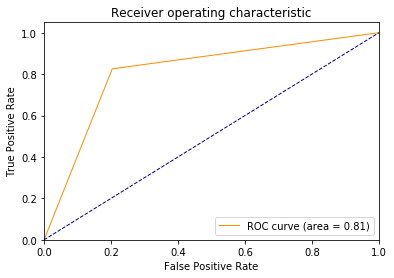

In [56]:
outcome_test = np.argmax(test_labels, 1)
predictions_test = predict_vals

fpr, tpr, thresholds = roc_curve(predictions_test, outcome_test)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [57]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, save_path)
    print("Model restored.") 
    print("Pos review ", new_pos_review)
    print("Neg review ", new_neg_review)
    print(predict_softmax(new_pos_review, vocab))
    print(predict_softmax(new_neg_review, vocab))

INFO:tensorflow:Restoring parameters from ./ch4-softmax-netflix-sentiment.ckpt
Model restored.
Pos review  I think that this is a fantastic movie, it really 
Neg review  Man, this movie really sucked. It was terrible. I could not possibly watch this movie again!
Predict: [[0.06452986 0.93547016]]
[1]
Predict: [[9.9964476e-01 3.5518387e-04]]
[0]
